In [4]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
import numpy as np
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP

Following the data preprocessin approach from this paper 

https://www-sciencedirect-com.libproxy.berkeley.edu/science/article/pii/S003040261831235X

In [5]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [6]:
import matplotlib.patches as patches
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop)

def get_crops(boxes):
    crops = []
    if boxes:
        for box in boxes:
            x, y, w, h = box
            cx = int(x + w/2)
            cy = int(y + h/2)
            crops.append((get_stride(cy), get_stride(cx)))
    return crops
        
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [8]:
#code ref: https://github.com/JenifferWuUCLA/pulmonary-nodules-segmentation/blob/master/tianchi_segment_lung_ROI.ipynb
def preprocess_image(img):
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    #　to renormalize washed out images
    #middle = img[100:400, 100:400]
    middle = img
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    #　underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    # Using Kmeans to separate foreground (radio-opaque tissue)
    #　and background (radio transparent tissue ie lungs)
    # Doing this only on the center of the image to avoid
    #　the non-tissue parts of the image as much as possible
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))
    labels = measure.label(dilation)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)

    mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation
    return img * mask

Examine the results of the transformations

x = 110.00196078431372, y = 178.00196078431372, w = 5.996078431372553, h= 8.996078431372553
[(110.00196078431372, 178.00196078431372, 5.996078431372553, 8.996078431372553)]


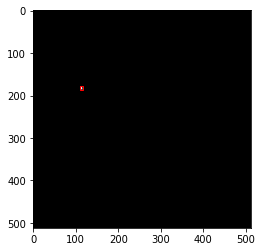

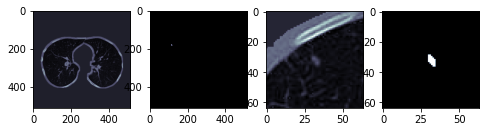

In [437]:
root_dir = "/data/unet/fullsize/train/"
image_name = "LIDC-IDRI-0141_211.jpg"
im = cv2.imread(root_dir + 'images/' + image_name)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ms = cv2.imread(root_dir + 'masks/' + image_name)
ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)
(thresh, ms) = cv2.threshold(ms, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plot_bounding_box(ms)
boxes = get_bounding_box(ms)
print(boxes)
crops = get_crops(boxes)
im = preprocess_image(im)
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(im, 'bone')
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(ms, 'bone')

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(im[crops[0]], 'bone')
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(ms[crops[0]], 'bone')

### Data pre-processing

We have full size 512x512 images (one per slice which has a qualifying nodule), for each patient

A qualifying nodule is the one which has been annotated by all four radiologists

In [270]:
### save images for training
#train
imagefiles = os.listdir('/data/unet/fullsize/train/images/')
for imagefile in tqdm(imagefiles):
    image = cv2.imread('/data/unet/fullsize/train/' + 'images/' + imagefile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread('/data/unet/fullsize/train/' + 'masks/' + imagefile.replace('img','mask'))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    boxes = get_bounding_box(mask)
    crops = get_crops(boxes)
    image = preprocess_image(image)
    print(len(np.unique(image)))
    if image[crops[0]].shape != (64, 64):
        print("error image shape ", image[crops[0]].shape)
        continue
    imageio.imwrite('/data/unet/train/images/' + imagefile, image[crops[0]])
    imageio.imwrite('/data/unet/train/masks/' + imagefile.replace('img','mask'), mask[crops[0]])

  0%|                                                                                                                                                                                                             | 1/4138 [00:00<27:33,  2.50it/s]

237


Lossy conversion from float64 to uint8. Range [-0.46930061299143105, 2.46063849580516]. Convert image to uint8 prior to saving to suppress this warning.
  0%|                                                                                                                                                                                                             | 2/4138 [00:00<26:56,  2.56it/s]

195


Lossy conversion from float64 to uint8. Range [-0.07341071775079565, 1.6884823540746114]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▏                                                                                                                                                                                                            | 3/4138 [00:01<26:27,  2.61it/s]

142


Lossy conversion from float64 to uint8. Range [-0.054290656297760295, 0.8210154052435046]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▏                                                                                                                                                                                                            | 4/4138 [00:01<26:20,  2.61it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7519819237499495, 1.3921311183562555]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▏                                                                                                                                                                                                            | 5/4138 [00:01<26:19,  2.62it/s]

193


Lossy conversion from float64 to uint8. Range [-0.8335993297876995, 2.583277745668236]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▎                                                                                                                                                                                                            | 6/4138 [00:02<26:17,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.18359036754824845, 2.3054728070997332]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▎                                                                                                                                                                                                            | 7/4138 [00:02<25:55,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.10990089792300915, 1.2875596818794073]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▍                                                                                                                                                                                                            | 8/4138 [00:03<25:50,  2.66it/s]

128


Lossy conversion from float64 to uint8. Range [-0.1639109319503414, 1.5914434762295353]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▍                                                                                                                                                                                                            | 9/4138 [00:03<25:47,  2.67it/s]

175


Lossy conversion from float64 to uint8. Range [0.0, 1.5645139775514443]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▍                                                                                                                                                                                                           | 10/4138 [00:03<25:53,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-0.9145905184349107, 2.0484618242836024]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▌                                                                                                                                                                                                           | 11/4138 [00:04<27:28,  2.50it/s]

252


Lossy conversion from float64 to uint8. Range [-0.18698623733087633, 0.818792671114533]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▌                                                                                                                                                                                                           | 12/4138 [00:04<26:51,  2.56it/s]

134


Lossy conversion from float64 to uint8. Range [-0.7868836424428955, 1.8780267083734938]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▋                                                                                                                                                                                                           | 13/4138 [00:05<26:44,  2.57it/s]

241


Lossy conversion from float64 to uint8. Range [-0.11171219386739259, 1.9785757945276667]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▋                                                                                                                                                                                                           | 14/4138 [00:05<26:35,  2.58it/s]

122


Lossy conversion from float64 to uint8. Range [-0.1094742436335032, 1.6865677236635974]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▋                                                                                                                                                                                                           | 15/4138 [00:05<26:07,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8277295935391962, 3.9127046165587713]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▊                                                                                                                                                                                                           | 16/4138 [00:06<26:16,  2.61it/s]

256


Lossy conversion from float64 to uint8. Range [-0.5837570331337658, 3.229507319074643]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▊                                                                                                                                                                                                           | 17/4138 [00:06<25:56,  2.65it/s]

202


Lossy conversion from float64 to uint8. Range [-0.12221684509180053, 2.232641280716015]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▉                                                                                                                                                                                                           | 18/4138 [00:06<26:03,  2.64it/s]

180


Lossy conversion from float64 to uint8. Range [-0.1718371488029664, 2.1779069494754952]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▉                                                                                                                                                                                                           | 19/4138 [00:07<26:11,  2.62it/s]

158


Lossy conversion from float64 to uint8. Range [-0.8924349856319381, 1.50469166590295]. Convert image to uint8 prior to saving to suppress this warning.
  0%|▉                                                                                                                                                                                                           | 20/4138 [00:07<26:00,  2.64it/s]

209


Lossy conversion from float64 to uint8. Range [-0.3435269250632525, 2.180043233416465]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█                                                                                                                                                                                                           | 21/4138 [00:08<25:44,  2.67it/s]

92


Lossy conversion from float64 to uint8. Range [0.0, 1.1329638814911216]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█                                                                                                                                                                                                           | 22/4138 [00:08<25:52,  2.65it/s]

105


Lossy conversion from float64 to uint8. Range [-0.3302283442067085, 2.139532640658176]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▏                                                                                                                                                                                                          | 23/4138 [00:08<26:41,  2.57it/s]

144


Lossy conversion from float64 to uint8. Range [-1.0194531722651674, 3.5525574292497106]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▏                                                                                                                                                                                                          | 24/4138 [00:09<26:23,  2.60it/s]

255


Lossy conversion from float64 to uint8. Range [-1.1175206173359475, 2.7573281681966075]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▏                                                                                                                                                                                                          | 25/4138 [00:09<26:39,  2.57it/s]

238


Lossy conversion from float64 to uint8. Range [-0.05812138506148739, 1.1910969590358638]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▎                                                                                                                                                                                                          | 26/4138 [00:09<26:15,  2.61it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7591414533362735, 4.163451489754095]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▎                                                                                                                                                                                                          | 27/4138 [00:10<26:37,  2.57it/s]

238


Lossy conversion from float64 to uint8. Range [-0.21315510453105627, 2.7697463177659922]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▍                                                                                                                                                                                                          | 28/4138 [00:10<26:15,  2.61it/s]

169


Lossy conversion from float64 to uint8. Range [0.0, 1.8747400225175188]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▍                                                                                                                                                                                                          | 29/4138 [00:11<26:04,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.05522811595358225, 1.7475540298028815]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▍                                                                                                                                                                                                          | 30/4138 [00:11<26:01,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.9006181648476139, 1.3057772236720102]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▌                                                                                                                                                                                                          | 31/4138 [00:11<25:57,  2.64it/s]

211


Lossy conversion from float64 to uint8. Range [-1.2603639706202363, 2.215968911441541]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▌                                                                                                                                                                                                          | 32/4138 [00:12<25:53,  2.64it/s]

217


Lossy conversion from float64 to uint8. Range [-0.9164375443226982, 1.9238684828576553]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▋                                                                                                                                                                                                          | 33/4138 [00:12<26:04,  2.62it/s]

255


Lossy conversion from float64 to uint8. Range [-0.23769407018673053, 1.518742215378348]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▋                                                                                                                                                                                                          | 34/4138 [00:13<26:38,  2.57it/s]

148


Lossy conversion from float64 to uint8. Range [-0.04602736939085365, 1.2574663951678358]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▋                                                                                                                                                                                                          | 35/4138 [00:13<26:57,  2.54it/s]

155


Lossy conversion from float64 to uint8. Range [-0.660029020579022, 3.5025444732043436]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▊                                                                                                                                                                                                          | 36/4138 [00:13<26:36,  2.57it/s]

244


Lossy conversion from float64 to uint8. Range [0.0, 1.7905668448173797]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▊                                                                                                                                                                                                          | 37/4138 [00:14<26:03,  2.62it/s]

125


Lossy conversion from float64 to uint8. Range [-0.25730220001028126, 1.2524052237989358]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▊                                                                                                                                                                                                          | 38/4138 [00:14<26:03,  2.62it/s]

111


Lossy conversion from float64 to uint8. Range [-0.2364571910263882, 1.3963709261791697]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▉                                                                                                                                                                                                          | 39/4138 [00:14<25:46,  2.65it/s]

148


Lossy conversion from float64 to uint8. Range [-1.0245966823565222, 1.8568209555360595]. Convert image to uint8 prior to saving to suppress this warning.
  1%|█▉                                                                                                                                                                                                          | 40/4138 [00:15<25:52,  2.64it/s]

235


Lossy conversion from float64 to uint8. Range [-0.18708401962209553, 0.8131905280325656]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██                                                                                                                                                                                                          | 41/4138 [00:15<25:37,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.08057979865780107, 2.0058776925156656]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██                                                                                                                                                                                                          | 42/4138 [00:16<25:28,  2.68it/s]

145


Lossy conversion from float64 to uint8. Range [-0.3448495617101481, 2.464397795126646]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██                                                                                                                                                                                                          | 43/4138 [00:16<25:40,  2.66it/s]

183


Lossy conversion from float64 to uint8. Range [-0.42288145369242164, 2.6492434699494876]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▏                                                                                                                                                                                                         | 44/4138 [00:16<25:46,  2.65it/s]

186


Lossy conversion from float64 to uint8. Range [-0.7512524465527266, 2.215912395784003]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▏                                                                                                                                                                                                         | 45/4138 [00:17<26:07,  2.61it/s]

188


Lossy conversion from float64 to uint8. Range [-0.0019327510776833573, 1.4281043393550947]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▎                                                                                                                                                                                                         | 46/4138 [00:17<25:53,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [0.06936842900888937, 1.4801456394888386]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▎                                                                                                                                                                                                         | 47/4138 [00:17<25:43,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.1650622378322696, 2.7841242936225252]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▎                                                                                                                                                                                                         | 48/4138 [00:18<25:37,  2.66it/s]

182


Lossy conversion from float64 to uint8. Range [-0.20916533107319515, 2.524049485007493]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▍                                                                                                                                                                                                         | 49/4138 [00:18<25:54,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.35913192079249323, 2.0667038809265317]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▍                                                                                                                                                                                                         | 50/4138 [00:19<25:53,  2.63it/s]

167


Lossy conversion from float64 to uint8. Range [-0.771213012268583, 3.924406402316825]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▌                                                                                                                                                                                                         | 51/4138 [00:19<26:06,  2.61it/s]

158


Lossy conversion from float64 to uint8. Range [0.0, 1.7005697219168558]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▌                                                                                                                                                                                                         | 52/4138 [00:19<25:51,  2.63it/s]

137


Lossy conversion from float64 to uint8. Range [-0.08685070051747157, 0.9766331751665793]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▌                                                                                                                                                                                                         | 53/4138 [00:20<25:38,  2.65it/s]

149


Lossy conversion from float64 to uint8. Range [-1.4006600632700292, 4.208435093542233]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▋                                                                                                                                                                                                         | 54/4138 [00:20<25:28,  2.67it/s]

249


Lossy conversion from float64 to uint8. Range [-0.16246016508507727, 2.0675657398246363]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▋                                                                                                                                                                                                         | 55/4138 [00:20<25:14,  2.70it/s]

138


Lossy conversion from float64 to uint8. Range [-0.16043687397730166, 1.6905103792492284]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▊                                                                                                                                                                                                         | 56/4138 [00:21<25:31,  2.67it/s]

125


Lossy conversion from float64 to uint8. Range [-0.1235941262797116, 1.87632243720469]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▊                                                                                                                                                                                                         | 57/4138 [00:21<26:05,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-0.07440532971551816, 1.4818469368607046]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▊                                                                                                                                                                                                         | 58/4138 [00:22<25:32,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.38439070739228176, 3.5465208021579055]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▉                                                                                                                                                                                                         | 59/4138 [00:22<25:32,  2.66it/s]

170


Lossy conversion from float64 to uint8. Range [0.0, 1.750803447378718]. Convert image to uint8 prior to saving to suppress this warning.
  1%|██▉                                                                                                                                                                                                         | 60/4138 [00:22<25:45,  2.64it/s]

101


Lossy conversion from float64 to uint8. Range [-0.31214491299273434, 1.237324936733354]. Convert image to uint8 prior to saving to suppress this warning.
  1%|███                                                                                                                                                                                                         | 61/4138 [00:23<25:55,  2.62it/s]

142


Lossy conversion from float64 to uint8. Range [-1.1156010156786418, 2.7823292248089464]. Convert image to uint8 prior to saving to suppress this warning.
  1%|███                                                                                                                                                                                                         | 62/4138 [00:23<25:45,  2.64it/s]

205


Lossy conversion from float64 to uint8. Range [-0.03159227570136518, 1.4279704162785212]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███                                                                                                                                                                                                         | 63/4138 [00:23<25:17,  2.68it/s]

91


Lossy conversion from float64 to uint8. Range [-0.9985783187508578, 1.519459467197598]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▏                                                                                                                                                                                                        | 64/4138 [00:24<25:23,  2.67it/s]

228


Lossy conversion from float64 to uint8. Range [-0.07099589542454157, 2.306929297666171]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▏                                                                                                                                                                                                        | 65/4138 [00:24<25:22,  2.68it/s]

147


Lossy conversion from float64 to uint8. Range [-0.09416146240888741, 1.6916842770993596]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▎                                                                                                                                                                                                        | 66/4138 [00:25<25:19,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.2583816978195659, 2.0241282012937107]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▎                                                                                                                                                                                                        | 67/4138 [00:25<25:19,  2.68it/s]

166


Lossy conversion from float64 to uint8. Range [-0.017211479902930482, 2.1249795430421825]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▎                                                                                                                                                                                                        | 68/4138 [00:25<25:30,  2.66it/s]

116


Lossy conversion from float64 to uint8. Range [-0.21772765413210451, 4.268627626463818]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▍                                                                                                                                                                                                        | 69/4138 [00:26<25:44,  2.64it/s]

186


Lossy conversion from float64 to uint8. Range [0.0, 2.1033314155473395]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▍                                                                                                                                                                                                        | 70/4138 [00:26<25:40,  2.64it/s]

140


Lossy conversion from float64 to uint8. Range [-0.8183438176422679, 2.9039812194902406]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▌                                                                                                                                                                                                        | 71/4138 [00:27<25:54,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.03861820351039036, 1.4676753226581811]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▌                                                                                                                                                                                                        | 72/4138 [00:27<25:43,  2.63it/s]

137


Lossy conversion from float64 to uint8. Range [-0.2286866296159026, 2.1594553992552346]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▌                                                                                                                                                                                                        | 73/4138 [00:27<25:27,  2.66it/s]

167


Lossy conversion from float64 to uint8. Range [-0.15484246518187708, 1.1283264220630547]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▋                                                                                                                                                                                                        | 74/4138 [00:28<25:11,  2.69it/s]

134


Lossy conversion from float64 to uint8. Range [-0.792573115716799, 2.6225056489239025]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▋                                                                                                                                                                                                        | 75/4138 [00:28<25:29,  2.66it/s]

228


Lossy conversion from float64 to uint8. Range [-0.5008669077182606, 2.6286649336050782]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▋                                                                                                                                                                                                        | 76/4138 [00:28<25:23,  2.67it/s]

201


Lossy conversion from float64 to uint8. Range [0.0, 1.622182718259413]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▊                                                                                                                                                                                                        | 77/4138 [00:29<25:29,  2.65it/s]

133


Lossy conversion from float64 to uint8. Range [-0.10952290767131381, 1.8251375911705692]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▊                                                                                                                                                                                                        | 78/4138 [00:29<25:23,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [0.0, 1.9155743564283783]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▉                                                                                                                                                                                                        | 79/4138 [00:29<25:12,  2.68it/s]

134


Lossy conversion from float64 to uint8. Range [-0.4992434144898637, 3.2280852921643204]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▉                                                                                                                                                                                                        | 80/4138 [00:30<25:18,  2.67it/s]

178


Lossy conversion from float64 to uint8. Range [-0.28499452744550374, 1.6609357236602726]. Convert image to uint8 prior to saving to suppress this warning.
  2%|███▉                                                                                                                                                                                                        | 81/4138 [00:30<25:36,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [-0.19896705039393342, 1.6393799030120733]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████                                                                                                                                                                                                        | 82/4138 [00:31<25:56,  2.61it/s]

122


Lossy conversion from float64 to uint8. Range [-0.10373305943410721, 2.052489238051994]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████                                                                                                                                                                                                        | 83/4138 [00:31<25:55,  2.61it/s]

164


Lossy conversion from float64 to uint8. Range [-0.3122098700327486, 1.2027252055905322]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▏                                                                                                                                                                                                       | 84/4138 [00:31<25:34,  2.64it/s]

142


Lossy conversion from float64 to uint8. Range [-0.1394897911570186, 0.8591972704593034]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▏                                                                                                                                                                                                       | 85/4138 [00:32<25:26,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [0.0, 1.5095835512140416]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▏                                                                                                                                                                                                       | 86/4138 [00:32<25:09,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 2.934031945027275]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▎                                                                                                                                                                                                       | 87/4138 [00:33<25:20,  2.66it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8028068297159895, 1.8315493205560047]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▎                                                                                                                                                                                                       | 88/4138 [00:33<26:02,  2.59it/s]

173


Lossy conversion from float64 to uint8. Range [-0.511844658190207, 3.643568357592185]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▍                                                                                                                                                                                                       | 89/4138 [00:33<25:50,  2.61it/s]

191


Lossy conversion from float64 to uint8. Range [-0.05767227909336053, 1.4062670860199031]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▍                                                                                                                                                                                                       | 90/4138 [00:34<25:49,  2.61it/s]

139


Lossy conversion from float64 to uint8. Range [-1.1388067974566307, 2.494587491066513]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▍                                                                                                                                                                                                       | 91/4138 [00:34<25:44,  2.62it/s]

218


Lossy conversion from float64 to uint8. Range [-0.4132288194858123, 4.490441668805297]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▌                                                                                                                                                                                                       | 92/4138 [00:34<25:24,  2.65it/s]

172


Lossy conversion from float64 to uint8. Range [-0.2458629400002302, 1.933852681655994]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▌                                                                                                                                                                                                       | 93/4138 [00:35<25:33,  2.64it/s]

168


Lossy conversion from float64 to uint8. Range [-1.012791424660538, 1.884632615693655]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▋                                                                                                                                                                                                       | 94/4138 [00:35<25:39,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.06702487093692153, 1.3564130543961457]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▋                                                                                                                                                                                                       | 95/4138 [00:36<25:24,  2.65it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.7333358399136334]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▋                                                                                                                                                                                                       | 96/4138 [00:36<25:52,  2.60it/s]

136


Lossy conversion from float64 to uint8. Range [-0.27718880179930117, 1.6655996086732519]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▊                                                                                                                                                                                                       | 97/4138 [00:36<25:43,  2.62it/s]

174


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▊                                                                                                                                                                                                       | 98/4138 [00:37<25:37,  2.63it/s]

103


Lossy conversion from float64 to uint8. Range [0.0, 1.6013180825958309]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▉                                                                                                                                                                                                       | 99/4138 [00:37<25:39,  2.62it/s]

167


Lossy conversion from float64 to uint8. Range [-0.08801191447628233, 0.8941157387913513]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▉                                                                                                                                                                                                      | 100/4138 [00:37<25:33,  2.63it/s]

133


Lossy conversion from float64 to uint8. Range [-0.9910622213146105, 2.924805659888401]. Convert image to uint8 prior to saving to suppress this warning.
  2%|████▉                                                                                                                                                                                                      | 101/4138 [00:38<25:55,  2.60it/s]

185


Lossy conversion from float64 to uint8. Range [-0.9193083672930207, 1.7187032467637902]. Convert image to uint8 prior to saving to suppress this warning.
  2%|█████                                                                                                                                                                                                      | 102/4138 [00:38<25:53,  2.60it/s]

253


Lossy conversion from float64 to uint8. Range [-0.013005828130631125, 1.3657090975596757]. Convert image to uint8 prior to saving to suppress this warning.
  2%|█████                                                                                                                                                                                                      | 103/4138 [00:39<25:55,  2.59it/s]

134


Lossy conversion from float64 to uint8. Range [-0.9027063388723807, 4.982969829526194]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████                                                                                                                                                                                                      | 104/4138 [00:39<25:51,  2.60it/s]

205


Lossy conversion from float64 to uint8. Range [-1.0341682534140457, 3.320775847810069]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▏                                                                                                                                                                                                     | 105/4138 [00:39<25:54,  2.60it/s]

234


Lossy conversion from float64 to uint8. Range [-0.08626134504480391, 0.8452762175923885]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▏                                                                                                                                                                                                     | 106/4138 [00:40<25:24,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-0.31999515325505407, 2.155701679954299]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▏                                                                                                                                                                                                     | 107/4138 [00:40<25:13,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [-0.06720931555683829, 1.6781649403309435]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▎                                                                                                                                                                                                     | 108/4138 [00:41<26:15,  2.56it/s]

155


Lossy conversion from float64 to uint8. Range [-0.744707618802425, 2.208959586011547]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▎                                                                                                                                                                                                     | 109/4138 [00:41<26:39,  2.52it/s]

184


Lossy conversion from float64 to uint8. Range [-0.16531547315546738, 0.8773726249433045]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▍                                                                                                                                                                                                     | 110/4138 [00:41<26:09,  2.57it/s]

120


Lossy conversion from float64 to uint8. Range [-0.23785162045155464, 2.2378206700358905]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▍                                                                                                                                                                                                     | 111/4138 [00:42<25:44,  2.61it/s]

154


  3%|█████▍                                                                                                                                                                                                     | 112/4138 [00:42<25:40,  2.61it/s]

230
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [-0.9025704531979567, 5.095423017335776]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▌                                                                                                                                                                                                     | 113/4138 [00:43<25:46,  2.60it/s]

189


Lossy conversion from float64 to uint8. Range [0.0, 1.8682689661684235]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▌                                                                                                                                                                                                     | 114/4138 [00:43<26:01,  2.58it/s]

132


Lossy conversion from float64 to uint8. Range [-0.3093639047159537, 3.7867160908745943]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▋                                                                                                                                                                                                     | 115/4138 [00:43<25:51,  2.59it/s]

154


Lossy conversion from float64 to uint8. Range [-0.24939879035404208, 2.304695077511397]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▋                                                                                                                                                                                                     | 116/4138 [00:44<25:36,  2.62it/s]

167


Lossy conversion from float64 to uint8. Range [-0.2336061670485691, 1.8067591871711328]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▋                                                                                                                                                                                                     | 117/4138 [00:44<25:31,  2.63it/s]

122


Lossy conversion from float64 to uint8. Range [0.0, 1.7105628607186176]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▊                                                                                                                                                                                                     | 118/4138 [00:44<25:12,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-0.7568337127467124, 2.7212120544429164]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▊                                                                                                                                                                                                     | 119/4138 [00:45<25:28,  2.63it/s]

224


Lossy conversion from float64 to uint8. Range [-0.12607844681734576, 1.2400761106574767]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▉                                                                                                                                                                                                     | 120/4138 [00:45<25:01,  2.68it/s]

122


Lossy conversion from float64 to uint8. Range [-0.8417232517303599, 1.7003942907351435]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▉                                                                                                                                                                                                     | 121/4138 [00:46<25:15,  2.65it/s]

210


Lossy conversion from float64 to uint8. Range [-0.7740766817554525, 4.112581032617648]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█████▉                                                                                                                                                                                                     | 122/4138 [00:46<25:01,  2.68it/s]

246


Lossy conversion from float64 to uint8. Range [-0.026170342773052236, 2.0588115433722742]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████                                                                                                                                                                                                     | 123/4138 [00:46<25:08,  2.66it/s]

161


Lossy conversion from float64 to uint8. Range [-0.18130327061663534, 0.922143561094987]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████                                                                                                                                                                                                     | 124/4138 [00:47<25:16,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [-0.3328883673213285, 2.4801525661005273]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▏                                                                                                                                                                                                    | 125/4138 [00:47<25:07,  2.66it/s]

122


Lossy conversion from float64 to uint8. Range [-0.11275182307490762, 1.017205863050552]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▏                                                                                                                                                                                                    | 126/4138 [00:47<25:18,  2.64it/s]

151


Lossy conversion from float64 to uint8. Range [-0.9324023150230877, 1.3178108552528962]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▏                                                                                                                                                                                                    | 127/4138 [00:48<25:30,  2.62it/s]

251


Lossy conversion from float64 to uint8. Range [-0.0814473091408821, 1.974510835480016]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▎                                                                                                                                                                                                    | 128/4138 [00:48<25:20,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7967906595199036, 1.5933324586250721]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▎                                                                                                                                                                                                    | 129/4138 [00:49<25:21,  2.64it/s]

245


Lossy conversion from float64 to uint8. Range [0.0, 1.9066809884055755]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▍                                                                                                                                                                                                    | 130/4138 [00:49<25:12,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7037872174827325, 2.8285768018729573]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▍                                                                                                                                                                                                    | 131/4138 [00:49<25:00,  2.67it/s]

202


Lossy conversion from float64 to uint8. Range [-0.21377644104814628, 2.0118955327295858]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▍                                                                                                                                                                                                    | 132/4138 [00:50<25:03,  2.66it/s]

148


Lossy conversion from float64 to uint8. Range [-0.902550895552993, 2.5517314768727224]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▌                                                                                                                                                                                                    | 133/4138 [00:50<25:16,  2.64it/s]

161


Lossy conversion from float64 to uint8. Range [0.0, 2.1742789393270723]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▌                                                                                                                                                                                                    | 134/4138 [00:50<25:07,  2.66it/s]

110


Lossy conversion from float64 to uint8. Range [-0.1333216743009039, 2.294536010408639]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▌                                                                                                                                                                                                    | 135/4138 [00:51<25:14,  2.64it/s]

150


Lossy conversion from float64 to uint8. Range [-0.059061472829244614, 1.0987226281134757]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▋                                                                                                                                                                                                    | 136/4138 [00:51<24:50,  2.69it/s]

129


Lossy conversion from float64 to uint8. Range [-0.9029310132950459, 5.385495205243993]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▋                                                                                                                                                                                                    | 137/4138 [00:52<25:04,  2.66it/s]

218


Lossy conversion from float64 to uint8. Range [-0.1945256339748552, 4.648865071203624]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▊                                                                                                                                                                                                    | 138/4138 [00:52<24:48,  2.69it/s]

187


Lossy conversion from float64 to uint8. Range [-0.1752676431269269, 0.8130593673965082]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▊                                                                                                                                                                                                    | 139/4138 [00:52<24:55,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7309805186339575, 3.3981865504890156]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▊                                                                                                                                                                                                    | 140/4138 [00:53<24:49,  2.68it/s]

194


Lossy conversion from float64 to uint8. Range [0.0, 1.433318382289928]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▉                                                                                                                                                                                                    | 141/4138 [00:53<24:40,  2.70it/s]

125


Lossy conversion from float64 to uint8. Range [-0.849890090601161, 2.9846351909821025]. Convert image to uint8 prior to saving to suppress this warning.
  3%|██████▉                                                                                                                                                                                                    | 142/4138 [00:53<24:39,  2.70it/s]

197


Lossy conversion from float64 to uint8. Range [-0.08731538227562166, 1.5904795468113724]. Convert image to uint8 prior to saving to suppress this warning.
  3%|███████                                                                                                                                                                                                    | 143/4138 [00:54<24:37,  2.70it/s]

135


Lossy conversion from float64 to uint8. Range [-0.06117021984997667, 2.026439500256347]. Convert image to uint8 prior to saving to suppress this warning.
  3%|███████                                                                                                                                                                                                    | 144/4138 [00:54<24:54,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.14527365793195607, 1.6402777143558112]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████                                                                                                                                                                                                    | 145/4138 [00:55<25:05,  2.65it/s]

123


Lossy conversion from float64 to uint8. Range [-0.21257664806347384, 3.1851900224496803]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▏                                                                                                                                                                                                   | 146/4138 [00:55<24:55,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-0.056493946467544326, 1.7698295760400216]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▏                                                                                                                                                                                                   | 147/4138 [00:55<24:54,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.15549853596687735, 1.7358395380427043]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▎                                                                                                                                                                                                   | 148/4138 [00:56<24:58,  2.66it/s]

166


Lossy conversion from float64 to uint8. Range [-1.467866987579619, 4.010564137715739]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▎                                                                                                                                                                                                   | 149/4138 [00:56<25:00,  2.66it/s]

206


Lossy conversion from float64 to uint8. Range [-0.7211411846420988, 2.2966155973723534]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▎                                                                                                                                                                                                   | 150/4138 [00:56<25:03,  2.65it/s]

242


Lossy conversion from float64 to uint8. Range [-1.1833671010571012, 1.3220740654341538]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▍                                                                                                                                                                                                   | 151/4138 [00:57<25:21,  2.62it/s]

241


Lossy conversion from float64 to uint8. Range [0.0, 1.5266104841058623]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▍                                                                                                                                                                                                   | 152/4138 [00:57<25:05,  2.65it/s]

101


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▌                                                                                                                                                                                                   | 153/4138 [00:58<24:54,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.21543352907922209, 1.4800716214969205]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▌                                                                                                                                                                                                   | 154/4138 [00:58<24:49,  2.67it/s]

184


Lossy conversion from float64 to uint8. Range [-1.0369742701413032, 1.1942370333461756]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▌                                                                                                                                                                                                   | 155/4138 [00:58<24:54,  2.67it/s]

247


Lossy conversion from float64 to uint8. Range [-1.016336892776655, 3.387812552357276]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▋                                                                                                                                                                                                   | 156/4138 [00:59<24:51,  2.67it/s]

204


Lossy conversion from float64 to uint8. Range [-0.17917214450427868, 1.953490022799797]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▋                                                                                                                                                                                                   | 157/4138 [00:59<25:02,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▊                                                                                                                                                                                                   | 158/4138 [00:59<24:58,  2.66it/s]

143


Lossy conversion from float64 to uint8. Range [-0.35477034557443243, 0.9572680068591745]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▊                                                                                                                                                                                                   | 159/4138 [01:00<25:09,  2.64it/s]

98


Lossy conversion from float64 to uint8. Range [-0.058790230777331386, 1.239644431540294]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▊                                                                                                                                                                                                   | 160/4138 [01:00<24:43,  2.68it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0159176016278175, 1.341635669401507]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▉                                                                                                                                                                                                   | 161/4138 [01:01<24:50,  2.67it/s]

235


Lossy conversion from float64 to uint8. Range [-0.18378175919186238, 1.3544738799625728]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▉                                                                                                                                                                                                   | 162/4138 [01:01<25:01,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8449466157607397, 2.7395742776325456]. Convert image to uint8 prior to saving to suppress this warning.
  4%|███████▉                                                                                                                                                                                                   | 163/4138 [01:01<24:59,  2.65it/s]

215


Lossy conversion from float64 to uint8. Range [-0.1759212181493947, 2.138649290727094]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████                                                                                                                                                                                                   | 164/4138 [01:02<24:47,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-0.34005929831910003, 2.2962312596947494]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████                                                                                                                                                                                                   | 165/4138 [01:02<25:01,  2.65it/s]

171


Lossy conversion from float64 to uint8. Range [-0.05278000544351021, 1.1844920134572234]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▏                                                                                                                                                                                                  | 166/4138 [01:02<24:45,  2.67it/s]

130


Lossy conversion from float64 to uint8. Range [-0.045862169930451425, 1.1089221620655336]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▏                                                                                                                                                                                                  | 167/4138 [01:03<24:45,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.16782147854353743, 1.7083265259616793]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▏                                                                                                                                                                                                  | 168/4138 [01:03<24:47,  2.67it/s]

170


Lossy conversion from float64 to uint8. Range [-0.9964789747310611, 2.5967937902976623]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▎                                                                                                                                                                                                  | 169/4138 [01:04<25:02,  2.64it/s]

150


Lossy conversion from float64 to uint8. Range [-0.3539195910090059, 2.204643387064753]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▎                                                                                                                                                                                                  | 170/4138 [01:04<25:05,  2.64it/s]

202


Lossy conversion from float64 to uint8. Range [-0.7899552311379321, 6.589557664082375]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▍                                                                                                                                                                                                  | 171/4138 [01:04<25:07,  2.63it/s]

242


Lossy conversion from float64 to uint8. Range [-0.40774854937137356, 2.1570930946769535]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▍                                                                                                                                                                                                  | 172/4138 [01:05<25:49,  2.56it/s]

145


Lossy conversion from float64 to uint8. Range [0.0, 1.4138053500041112]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▍                                                                                                                                                                                                  | 173/4138 [01:05<25:19,  2.61it/s]

124


Lossy conversion from float64 to uint8. Range [-0.2869074184112816, 1.337881185804706]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▌                                                                                                                                                                                                  | 174/4138 [01:05<25:02,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [-0.9924043504063985, 1.341103345388724]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▌                                                                                                                                                                                                  | 175/4138 [01:06<25:06,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.8058927587978838, 1.5718055167806553]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▋                                                                                                                                                                                                  | 176/4138 [01:06<25:00,  2.64it/s]

185


Lossy conversion from float64 to uint8. Range [-0.7768889920491171, 2.1058093775108824]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▋                                                                                                                                                                                                  | 177/4138 [01:07<25:12,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [-0.9745557661393115, 3.8152448006843462]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▋                                                                                                                                                                                                  | 178/4138 [01:07<25:04,  2.63it/s]

183


Lossy conversion from float64 to uint8. Range [-0.518764669860465, 2.8735239248729227]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▊                                                                                                                                                                                                  | 179/4138 [01:07<25:21,  2.60it/s]

202


Lossy conversion from float64 to uint8. Range [0.0004892418196190002, 1.1777949352212054]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▊                                                                                                                                                                                                  | 180/4138 [01:08<25:00,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.02919241515184334, 1.6016163909426926]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▉                                                                                                                                                                                                  | 181/4138 [01:08<24:31,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [-0.8851536817569858, 3.445303191594109]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▉                                                                                                                                                                                                  | 182/4138 [01:08<24:29,  2.69it/s]

217


Lossy conversion from float64 to uint8. Range [-0.4014431527335091, 4.736013674246225]. Convert image to uint8 prior to saving to suppress this warning.
  4%|████████▉                                                                                                                                                                                                  | 183/4138 [01:09<24:12,  2.72it/s]

188


Lossy conversion from float64 to uint8. Range [-0.06674651361682618, 1.564438630850055]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█████████                                                                                                                                                                                                  | 184/4138 [01:09<24:00,  2.74it/s]

104


Lossy conversion from float64 to uint8. Range [-0.7330127407552971, 2.741272442908265]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█████████                                                                                                                                                                                                  | 185/4138 [01:10<24:16,  2.71it/s]

231


Lossy conversion from float64 to uint8. Range [-0.36699979834429963, 1.4349274404476293]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█████████                                                                                                                                                                                                  | 186/4138 [01:10<24:33,  2.68it/s]

99


Lossy conversion from float64 to uint8. Range [-0.9165541180694632, 2.775319366908477]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▏                                                                                                                                                                                                 | 187/4138 [01:10<24:49,  2.65it/s]

241


Lossy conversion from float64 to uint8. Range [-1.1519113705814976, 1.0965990219113426]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▏                                                                                                                                                                                                 | 188/4138 [01:11<25:01,  2.63it/s]

213


Lossy conversion from float64 to uint8. Range [-0.0732716660953249, 2.0544621882742815]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▎                                                                                                                                                                                                 | 189/4138 [01:11<24:56,  2.64it/s]

125


Lossy conversion from float64 to uint8. Range [-0.10873504807681085, 2.843528150820076]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▎                                                                                                                                                                                                 | 190/4138 [01:11<24:34,  2.68it/s]

175


Lossy conversion from float64 to uint8. Range [-0.2494902797592505, 1.2547369202627008]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▎                                                                                                                                                                                                 | 191/4138 [01:12<24:50,  2.65it/s]

166


Lossy conversion from float64 to uint8. Range [-0.8872400453921246, 3.765275846178247]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▍                                                                                                                                                                                                 | 192/4138 [01:12<24:59,  2.63it/s]

250


Lossy conversion from float64 to uint8. Range [-0.13174026385694226, 2.258590658094896]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▍                                                                                                                                                                                                 | 193/4138 [01:13<24:40,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [0.0, 1.9048176238917935]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▌                                                                                                                                                                                                 | 194/4138 [01:13<24:33,  2.68it/s]

105


Lossy conversion from float64 to uint8. Range [-0.05019193630908258, 2.802844814717618]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▌                                                                                                                                                                                                 | 195/4138 [01:13<24:23,  2.69it/s]

145


Lossy conversion from float64 to uint8. Range [-0.9011110676576333, 5.315999940231896]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▌                                                                                                                                                                                                 | 196/4138 [01:14<24:49,  2.65it/s]

238


Lossy conversion from float64 to uint8. Range [-1.0898551301388029, 1.05997405978808]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▋                                                                                                                                                                                                 | 197/4138 [01:14<24:44,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2409708399938079, 3.4692065965510857]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▋                                                                                                                                                                                                 | 198/4138 [01:14<24:22,  2.69it/s]

178


Lossy conversion from float64 to uint8. Range [-0.27534614340969643, 0.7525474983591758]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▊                                                                                                                                                                                                 | 199/4138 [01:15<24:37,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [-0.2414589197116073, 1.9461126792652943]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▊                                                                                                                                                                                                 | 200/4138 [01:15<24:26,  2.69it/s]

127


Lossy conversion from float64 to uint8. Range [-0.12664767401142232, 0.8940578483325037]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▊                                                                                                                                                                                                 | 201/4138 [01:16<24:16,  2.70it/s]

132


Lossy conversion from float64 to uint8. Range [-0.2334379754189169, 0.7826557744182892]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▉                                                                                                                                                                                                 | 202/4138 [01:16<24:54,  2.63it/s]

173


Lossy conversion from float64 to uint8. Range [-0.05952550627148245, 1.8383146491571345]. Convert image to uint8 prior to saving to suppress this warning.
  5%|█████████▉                                                                                                                                                                                                 | 203/4138 [01:16<24:38,  2.66it/s]

130


Lossy conversion from float64 to uint8. Range [-0.2061702582926373, 1.6853766290312495]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████                                                                                                                                                                                                 | 204/4138 [01:17<24:18,  2.70it/s]

140


Lossy conversion from float64 to uint8. Range [-0.24966142759864002, 0.9170118934990988]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████                                                                                                                                                                                                 | 205/4138 [01:17<24:33,  2.67it/s]

176


Lossy conversion from float64 to uint8. Range [-1.0156321748036263, 1.3766813327889174]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████                                                                                                                                                                                                 | 206/4138 [01:17<24:52,  2.63it/s]

235


Lossy conversion from float64 to uint8. Range [0.0, 1.9581465488660315]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▏                                                                                                                                                                                                | 207/4138 [01:18<24:51,  2.64it/s]

106


Lossy conversion from float64 to uint8. Range [-0.9975753183827727, 1.6767991081214475]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▏                                                                                                                                                                                                | 208/4138 [01:18<24:54,  2.63it/s]

186


Lossy conversion from float64 to uint8. Range [0.0, 1.1049868284198014]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▎                                                                                                                                                                                                | 209/4138 [01:19<24:41,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.0933723851051914, 2.2135106373891817]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▎                                                                                                                                                                                                | 210/4138 [01:19<25:13,  2.60it/s]

158


Lossy conversion from float64 to uint8. Range [-0.030175893766706978, 0.9313702146313538]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▎                                                                                                                                                                                                | 211/4138 [01:19<24:42,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [-0.7907989370857055, 2.9371386243701347]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▍                                                                                                                                                                                                | 212/4138 [01:20<25:12,  2.60it/s]

216


Lossy conversion from float64 to uint8. Range [-0.04719797063684676, 0.8227224534180886]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▍                                                                                                                                                                                                | 213/4138 [01:20<24:52,  2.63it/s]

131


Lossy conversion from float64 to uint8. Range [0.0, 1.6888458585119948]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▍                                                                                                                                                                                                | 214/4138 [01:21<24:40,  2.65it/s]

157


Lossy conversion from float64 to uint8. Range [-0.539562012600251, 2.9228844634247557]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▌                                                                                                                                                                                                | 215/4138 [01:21<24:40,  2.65it/s]

198


Lossy conversion from float64 to uint8. Range [-0.5571116202980437, 2.9475815813869337]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▌                                                                                                                                                                                                | 216/4138 [01:21<24:38,  2.65it/s]

190


Lossy conversion from float64 to uint8. Range [-0.0, 1.0922514564033396]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▋                                                                                                                                                                                                | 217/4138 [01:22<24:21,  2.68it/s]

109


Lossy conversion from float64 to uint8. Range [-0.14286348712092528, 1.3757769041876309]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▋                                                                                                                                                                                                | 218/4138 [01:22<24:16,  2.69it/s]

95


Lossy conversion from float64 to uint8. Range [-0.5407674729004794, 3.6796711560778648]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▋                                                                                                                                                                                                | 219/4138 [01:23<30:45,  2.12it/s]

182


Lossy conversion from float64 to uint8. Range [-0.5077623871154117, 2.158231943547924]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▊                                                                                                                                                                                                | 220/4138 [01:23<28:56,  2.26it/s]

93


Lossy conversion from float64 to uint8. Range [-0.4797209829548984, 2.6813538348534034]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▊                                                                                                                                                                                                | 221/4138 [01:23<27:40,  2.36it/s]

167


Lossy conversion from float64 to uint8. Range [-0.02382098981565339, 2.2528372346807877]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▉                                                                                                                                                                                                | 222/4138 [01:24<26:29,  2.46it/s]

148


Lossy conversion from float64 to uint8. Range [-1.2366763976486104, 3.059095474745234]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▉                                                                                                                                                                                                | 223/4138 [01:24<26:21,  2.48it/s]

221


Lossy conversion from float64 to uint8. Range [-0.4233378040543699, 4.041194310016226]. Convert image to uint8 prior to saving to suppress this warning.
  5%|██████████▉                                                                                                                                                                                                | 224/4138 [01:25<26:09,  2.49it/s]

206


Lossy conversion from float64 to uint8. Range [-0.1455065788821004, 2.5377668718540702]. Convert image to uint8 prior to saving to suppress this warning.
  5%|███████████                                                                                                                                                                                                | 225/4138 [01:25<25:22,  2.57it/s]

149


Lossy conversion from float64 to uint8. Range [-0.45322456359650826, 2.816039854806209]. Convert image to uint8 prior to saving to suppress this warning.
  5%|███████████                                                                                                                                                                                                | 226/4138 [01:25<25:01,  2.61it/s]

195


Lossy conversion from float64 to uint8. Range [-0.7656541269182613, 1.8825428947111684]. Convert image to uint8 prior to saving to suppress this warning.
  5%|███████████▏                                                                                                                                                                                               | 227/4138 [01:26<24:56,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.06539161206333992, 1.2992539497215128]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▏                                                                                                                                                                                               | 228/4138 [01:26<24:44,  2.63it/s]

149


Lossy conversion from float64 to uint8. Range [-0.5861894463064332, 3.2301402565845034]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▏                                                                                                                                                                                               | 229/4138 [01:26<24:34,  2.65it/s]

187


Lossy conversion from float64 to uint8. Range [-0.8765770296377445, 1.3988366221741095]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▎                                                                                                                                                                                               | 230/4138 [01:27<24:25,  2.67it/s]

163


  6%|███████████▎                                                                                                                                                                                               | 231/4138 [01:27<24:47,  2.63it/s]

229
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [-0.05915168375112648, 0.9052518703677208]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▍                                                                                                                                                                                               | 232/4138 [01:28<24:23,  2.67it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.4094592720327577]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▍                                                                                                                                                                                               | 233/4138 [01:28<24:23,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.0819709845104583, 1.0656918735319616]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▍                                                                                                                                                                                               | 234/4138 [01:28<24:34,  2.65it/s]

120


Lossy conversion from float64 to uint8. Range [-0.8977662629954666, 3.4846613709942402]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▌                                                                                                                                                                                               | 235/4138 [01:29<24:26,  2.66it/s]

226


Lossy conversion from float64 to uint8. Range [0.0, 1.1127233555543647]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▌                                                                                                                                                                                               | 236/4138 [01:29<24:22,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.07258656512960858, 0.8459143882476401]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▋                                                                                                                                                                                               | 237/4138 [01:29<24:10,  2.69it/s]

142


Lossy conversion from float64 to uint8. Range [0.0, 2.0472768770692906]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▋                                                                                                                                                                                               | 238/4138 [01:30<24:13,  2.68it/s]

111


Lossy conversion from float64 to uint8. Range [-0.9706306370033246, 3.1627564091388467]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▋                                                                                                                                                                                               | 239/4138 [01:30<24:12,  2.68it/s]

210


Lossy conversion from float64 to uint8. Range [-1.0002648860912915, 1.6454944743933917]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▊                                                                                                                                                                                               | 240/4138 [01:31<24:47,  2.62it/s]

237


Lossy conversion from float64 to uint8. Range [-0.4931758683452261, 1.70773328031076]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▊                                                                                                                                                                                               | 241/4138 [01:31<26:24,  2.46it/s]

115


Lossy conversion from float64 to uint8. Range [-0.9574967810844622, 1.690316389133544]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▊                                                                                                                                                                                               | 242/4138 [01:31<25:59,  2.50it/s]

239


Lossy conversion from float64 to uint8. Range [-0.36950904082495656, 3.522438868136971]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▉                                                                                                                                                                                               | 243/4138 [01:32<25:10,  2.58it/s]

136


Lossy conversion from float64 to uint8. Range [-0.2784479492198191, 2.45349521997901]. Convert image to uint8 prior to saving to suppress this warning.
  6%|███████████▉                                                                                                                                                                                               | 244/4138 [01:32<25:01,  2.59it/s]

172


Lossy conversion from float64 to uint8. Range [0.0, 1.6540872182895685]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████                                                                                                                                                                                               | 245/4138 [01:33<24:55,  2.60it/s]

121


Lossy conversion from float64 to uint8. Range [-0.1913628498198941, 2.07675977578944]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████                                                                                                                                                                                               | 246/4138 [01:33<24:44,  2.62it/s]

170


Lossy conversion from float64 to uint8. Range [-0.1594644555907399, 2.0082608601823315]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████                                                                                                                                                                                               | 247/4138 [01:33<24:36,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.060635752462429394, 1.3175105166428553]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▏                                                                                                                                                                                              | 248/4138 [01:34<24:35,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [-0.3642351516318441, 2.0009651129311354]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▏                                                                                                                                                                                              | 249/4138 [01:34<25:28,  2.54it/s]

126


Lossy conversion from float64 to uint8. Range [-1.0157607573179606, 1.5998441440828275]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▎                                                                                                                                                                                              | 250/4138 [01:35<25:09,  2.58it/s]

213


Lossy conversion from float64 to uint8. Range [-0.787873074190229, 4.319116253881841]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▎                                                                                                                                                                                              | 251/4138 [01:35<25:03,  2.59it/s]

250


Lossy conversion from float64 to uint8. Range [-0.0412784632186357, 0.9391245767647242]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▎                                                                                                                                                                                              | 252/4138 [01:35<24:33,  2.64it/s]

125


Lossy conversion from float64 to uint8. Range [-0.8272220638626812, 1.4672117885326668]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▍                                                                                                                                                                                              | 253/4138 [01:36<24:34,  2.64it/s]

217


Lossy conversion from float64 to uint8. Range [-0.6100796671704469, 3.234233576750446]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▍                                                                                                                                                                                              | 254/4138 [01:36<24:27,  2.65it/s]

153


Lossy conversion from float64 to uint8. Range [-1.0221653574679157, 1.8949924372316174]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▌                                                                                                                                                                                              | 255/4138 [01:36<24:31,  2.64it/s]

226


Lossy conversion from float64 to uint8. Range [-0.7414855675709331, 3.5683868134397514]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▌                                                                                                                                                                                              | 256/4138 [01:37<24:37,  2.63it/s]

159


Lossy conversion from float64 to uint8. Range [-0.05063385216905108, 2.203476420638693]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▌                                                                                                                                                                                              | 257/4138 [01:37<24:20,  2.66it/s]

153


Lossy conversion from float64 to uint8. Range [-0.2057561169673605, 1.6038173967368352]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▋                                                                                                                                                                                              | 258/4138 [01:38<24:10,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-0.07125751279214308, 1.2041437249957294]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▋                                                                                                                                                                                              | 259/4138 [01:38<24:19,  2.66it/s]

132


Lossy conversion from float64 to uint8. Range [-0.4797557887810656, 2.4092192523803027]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▊                                                                                                                                                                                              | 260/4138 [01:38<24:21,  2.65it/s]

197


Lossy conversion from float64 to uint8. Range [-0.2207905300256393, 2.3976008346868114]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▊                                                                                                                                                                                              | 261/4138 [01:39<24:08,  2.68it/s]

157


Lossy conversion from float64 to uint8. Range [-0.009981400066646669, 2.1772196692478456]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▊                                                                                                                                                                                              | 262/4138 [01:39<24:01,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-0.17821367053848183, 1.867277554058312]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▉                                                                                                                                                                                              | 263/4138 [01:39<23:55,  2.70it/s]

132


Lossy conversion from float64 to uint8. Range [-0.5722896674026112, 3.29565969970881]. Convert image to uint8 prior to saving to suppress this warning.
  6%|████████████▉                                                                                                                                                                                              | 264/4138 [01:40<24:28,  2.64it/s]

224


Lossy conversion from float64 to uint8. Range [-0.05938676626010319, 1.6149250322149835]. Convert image to uint8 prior to saving to suppress this warning.
  6%|█████████████                                                                                                                                                                                              | 265/4138 [01:40<24:13,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.22106521333773943, 1.9525885073107219]. Convert image to uint8 prior to saving to suppress this warning.
  6%|█████████████                                                                                                                                                                                              | 266/4138 [01:41<24:17,  2.66it/s]

180


Lossy conversion from float64 to uint8. Range [-0.8145399971501567, 3.6940066501137956]. Convert image to uint8 prior to saving to suppress this warning.
  6%|█████████████                                                                                                                                                                                              | 267/4138 [01:41<24:32,  2.63it/s]

226


Lossy conversion from float64 to uint8. Range [-0.12697655808024572, 1.7282358007372152]. Convert image to uint8 prior to saving to suppress this warning.
  6%|█████████████▏                                                                                                                                                                                             | 268/4138 [01:41<24:31,  2.63it/s]

168


Lossy conversion from float64 to uint8. Range [-0.022852463643390487, 2.266454568659069]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▏                                                                                                                                                                                             | 269/4138 [01:42<24:33,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.7576315913786179, 3.8992719461082586]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▏                                                                                                                                                                                             | 270/4138 [01:42<24:26,  2.64it/s]

225


Lossy conversion from float64 to uint8. Range [-0.155224397840188, 1.066746215192813]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▎                                                                                                                                                                                             | 271/4138 [01:42<24:07,  2.67it/s]

128


Lossy conversion from float64 to uint8. Range [-1.282647894100128, 1.9196042172273555]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▎                                                                                                                                                                                             | 272/4138 [01:43<24:23,  2.64it/s]

239


Lossy conversion from float64 to uint8. Range [-0.1474477032953465, 0.9390473324590928]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▍                                                                                                                                                                                             | 273/4138 [01:43<24:23,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-1.0017543757372391, 2.3146550116158346]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▍                                                                                                                                                                                             | 274/4138 [01:44<24:31,  2.63it/s]

220


Lossy conversion from float64 to uint8. Range [0.0, 2.9377358197611065]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▍                                                                                                                                                                                             | 275/4138 [01:44<24:44,  2.60it/s]

178


Lossy conversion from float64 to uint8. Range [-0.7708457388483904, 3.8775133526633776]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▌                                                                                                                                                                                             | 276/4138 [01:44<25:09,  2.56it/s]

157


Lossy conversion from float64 to uint8. Range [-0.18491692554386843, 0.8490751979356467]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▌                                                                                                                                                                                             | 277/4138 [01:45<24:44,  2.60it/s]

130


Lossy conversion from float64 to uint8. Range [-1.0747372443430006, 3.417357229680205]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▋                                                                                                                                                                                             | 278/4138 [01:45<24:29,  2.63it/s]

243


Lossy conversion from float64 to uint8. Range [-0.8453632746337337, 2.7838950064975596]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▋                                                                                                                                                                                             | 279/4138 [01:46<24:41,  2.60it/s]

240


Lossy conversion from float64 to uint8. Range [-0.16117892296890687, 2.1865937550261747]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▋                                                                                                                                                                                             | 280/4138 [01:46<24:26,  2.63it/s]

134


Lossy conversion from float64 to uint8. Range [0.10253330547188473, 1.528020542831253]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▊                                                                                                                                                                                             | 281/4138 [01:46<24:26,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 2.028646657228319]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▊                                                                                                                                                                                             | 282/4138 [01:47<24:26,  2.63it/s]

118


Lossy conversion from float64 to uint8. Range [-1.0151219359551713, 1.6667645137395521]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▉                                                                                                                                                                                             | 283/4138 [01:47<24:15,  2.65it/s]

219


Lossy conversion from float64 to uint8. Range [-0.05295777981909318, 1.4263902218435067]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▉                                                                                                                                                                                             | 284/4138 [01:47<23:54,  2.69it/s]

142


Lossy conversion from float64 to uint8. Range [-0.8049375991396637, 1.4826288244412988]. Convert image to uint8 prior to saving to suppress this warning.
  7%|█████████████▉                                                                                                                                                                                             | 285/4138 [01:48<24:10,  2.66it/s]

182


Lossy conversion from float64 to uint8. Range [-0.297742656317268, 1.0774284592823395]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████                                                                                                                                                                                             | 286/4138 [01:48<24:05,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-0.23649039319923582, 1.2515190549288466]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████                                                                                                                                                                                             | 287/4138 [01:49<24:12,  2.65it/s]

170


Lossy conversion from float64 to uint8. Range [0.0, 1.597059127171257]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▏                                                                                                                                                                                            | 288/4138 [01:49<24:13,  2.65it/s]

115


Lossy conversion from float64 to uint8. Range [-0.4824152416290268, 2.6663869620911074]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▏                                                                                                                                                                                            | 289/4138 [01:49<24:39,  2.60it/s]

205


Lossy conversion from float64 to uint8. Range [-0.15755534539590646, 1.1232745105981194]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▏                                                                                                                                                                                            | 290/4138 [01:50<24:14,  2.65it/s]

101


Lossy conversion from float64 to uint8. Range [-0.7953499515393712, 2.613480256739036]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▎                                                                                                                                                                                            | 291/4138 [01:50<23:59,  2.67it/s]

236


Lossy conversion from float64 to uint8. Range [-0.014634009794700984, 0.9976719685112944]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▎                                                                                                                                                                                            | 292/4138 [01:50<24:20,  2.63it/s]

150


Lossy conversion from float64 to uint8. Range [0.0, 2.1163050935822403]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▎                                                                                                                                                                                            | 293/4138 [01:51<24:31,  2.61it/s]

118


Lossy conversion from float64 to uint8. Range [-0.20958049455362673, 1.5536601070467069]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▍                                                                                                                                                                                            | 294/4138 [01:51<24:11,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.052454177953647436, 1.9605583662042023]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▍                                                                                                                                                                                            | 295/4138 [01:52<24:28,  2.62it/s]

134


Lossy conversion from float64 to uint8. Range [-0.17023866005778887, 2.127724415815407]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▌                                                                                                                                                                                            | 296/4138 [01:52<24:23,  2.63it/s]

120


Lossy conversion from float64 to uint8. Range [0.0, 1.5868704497411952]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▌                                                                                                                                                                                            | 297/4138 [01:52<24:08,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [-0.053336003418782134, 1.152399877937998]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▌                                                                                                                                                                                            | 298/4138 [01:53<24:05,  2.66it/s]

131


Lossy conversion from float64 to uint8. Range [-0.07179396299527342, 1.5731297238500226]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▋                                                                                                                                                                                            | 299/4138 [01:53<24:02,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8395919575190961, 2.902130339314407]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▋                                                                                                                                                                                            | 300/4138 [01:53<23:51,  2.68it/s]

222


Lossy conversion from float64 to uint8. Range [-0.03204658349342718, 1.8146530075243528]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▊                                                                                                                                                                                            | 301/4138 [01:54<24:19,  2.63it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.732188580794291]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▊                                                                                                                                                                                            | 302/4138 [01:54<24:04,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-0.7677368032070099, 2.656378777005783]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▊                                                                                                                                                                                            | 303/4138 [01:55<24:17,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.17418599603497625, 1.8161608572073262]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▉                                                                                                                                                                                            | 304/4138 [01:55<24:17,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.7636583922388505, 2.0993617562730718]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██████████████▉                                                                                                                                                                                            | 305/4138 [01:55<24:24,  2.62it/s]

242


Lossy conversion from float64 to uint8. Range [-0.7892319275133479, 2.1572335495856483]. Convert image to uint8 prior to saving to suppress this warning.
  7%|███████████████                                                                                                                                                                                            | 306/4138 [01:56<24:27,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.09612408500988844, 1.5983965488651348]. Convert image to uint8 prior to saving to suppress this warning.
  7%|███████████████                                                                                                                                                                                            | 307/4138 [01:56<24:04,  2.65it/s]

166


Lossy conversion from float64 to uint8. Range [-0.032253228563512565, 1.4919511554090568]. Convert image to uint8 prior to saving to suppress this warning.
  7%|███████████████                                                                                                                                                                                            | 308/4138 [01:56<23:59,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.22827329069397304, 1.6642689161762916]. Convert image to uint8 prior to saving to suppress this warning.
  7%|███████████████▏                                                                                                                                                                                           | 309/4138 [01:57<23:53,  2.67it/s]

172


Lossy conversion from float64 to uint8. Range [-0.9960719848505664, 1.7775728196611622]. Convert image to uint8 prior to saving to suppress this warning.
  7%|███████████████▏                                                                                                                                                                                           | 310/4138 [01:57<24:07,  2.64it/s]

178


Lossy conversion from float64 to uint8. Range [-0.10125212108494429, 1.1956548315657944]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▎                                                                                                                                                                                           | 311/4138 [01:58<24:21,  2.62it/s]

152


Lossy conversion from float64 to uint8. Range [-0.2235709599644778, 1.9918464536422986]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▎                                                                                                                                                                                           | 312/4138 [01:58<24:18,  2.62it/s]

114


Lossy conversion from float64 to uint8. Range [-0.02072752944450539, 1.656537595999967]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▎                                                                                                                                                                                           | 313/4138 [01:58<24:11,  2.64it/s]

180


Lossy conversion from float64 to uint8. Range [-0.2395389207061521, 2.2938850779677815]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▍                                                                                                                                                                                           | 314/4138 [01:59<24:23,  2.61it/s]

169


Lossy conversion from float64 to uint8. Range [-0.1937050307936988, 1.1779002073921285]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▍                                                                                                                                                                                           | 315/4138 [01:59<24:20,  2.62it/s]

99


Lossy conversion from float64 to uint8. Range [-0.17053940197492345, 2.2351539146997195]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▌                                                                                                                                                                                           | 316/4138 [02:00<24:21,  2.61it/s]

158


Lossy conversion from float64 to uint8. Range [-0.09070230541586848, 1.765913372744122]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▌                                                                                                                                                                                           | 317/4138 [02:00<24:27,  2.60it/s]

122


Lossy conversion from float64 to uint8. Range [-0.5762633262014513, 3.724405881542318]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▌                                                                                                                                                                                           | 318/4138 [02:00<24:11,  2.63it/s]

194


Lossy conversion from float64 to uint8. Range [0.0, 1.934430662719289]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▋                                                                                                                                                                                           | 319/4138 [02:01<24:17,  2.62it/s]

117


Lossy conversion from float64 to uint8. Range [-0.029794975260148324, 1.1743807619843891]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▋                                                                                                                                                                                           | 320/4138 [02:01<24:03,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [-0.7805692689860363, 4.266494558533022]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▋                                                                                                                                                                                           | 321/4138 [02:01<24:12,  2.63it/s]

223


Lossy conversion from float64 to uint8. Range [-1.0071886027784038, 2.672087165813163]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▊                                                                                                                                                                                           | 322/4138 [02:02<24:06,  2.64it/s]

232


Lossy conversion from float64 to uint8. Range [-0.1082457694920288, 2.1222747830614197]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▊                                                                                                                                                                                           | 323/4138 [02:02<24:01,  2.65it/s]

150


Lossy conversion from float64 to uint8. Range [-0.2339003898016751, 0.9713953684216365]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▉                                                                                                                                                                                           | 324/4138 [02:03<23:59,  2.65it/s]

154


Lossy conversion from float64 to uint8. Range [-0.8167225040625009, 1.9431887611960477]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▉                                                                                                                                                                                           | 325/4138 [02:03<24:20,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.1761117279535889, 1.8128675371987681]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███████████████▉                                                                                                                                                                                           | 326/4138 [02:03<24:08,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [0.0, 1.9503159398668481]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████                                                                                                                                                                                           | 327/4138 [02:04<24:10,  2.63it/s]

112


Lossy conversion from float64 to uint8. Range [-1.2149663620648676, 1.4347723206065321]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████                                                                                                                                                                                           | 328/4138 [02:04<23:59,  2.65it/s]

222


Lossy conversion from float64 to uint8. Range [0.13150771069034234, 1.5668427375206297]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▏                                                                                                                                                                                          | 329/4138 [02:04<23:44,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1276712960120853, 1.5917436025809124]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▏                                                                                                                                                                                          | 330/4138 [02:05<23:45,  2.67it/s]

118


Lossy conversion from float64 to uint8. Range [-0.9165900137385464, 3.92040509921677]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▏                                                                                                                                                                                          | 331/4138 [02:05<23:48,  2.66it/s]

223


Lossy conversion from float64 to uint8. Range [-0.5149005794725234, 2.2540859900056796]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▎                                                                                                                                                                                          | 332/4138 [02:06<24:01,  2.64it/s]

178


Lossy conversion from float64 to uint8. Range [-0.5198626715721594, 1.3480414091330744]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▎                                                                                                                                                                                          | 333/4138 [02:06<25:24,  2.50it/s]

119


Lossy conversion from float64 to uint8. Range [-0.9701452826253741, 1.6996605742878779]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▍                                                                                                                                                                                          | 334/4138 [02:07<32:08,  1.97it/s]

203


Lossy conversion from float64 to uint8. Range [-1.1132436017709542, 3.074475837106614]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▍                                                                                                                                                                                          | 335/4138 [02:07<29:53,  2.12it/s]

228


Lossy conversion from float64 to uint8. Range [-0.2063321816415934, 1.602362617164152]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▍                                                                                                                                                                                          | 336/4138 [02:08<28:15,  2.24it/s]

169


Lossy conversion from float64 to uint8. Range [-0.2555318233371995, 2.95910271503366]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▌                                                                                                                                                                                          | 337/4138 [02:08<27:00,  2.35it/s]

179


Lossy conversion from float64 to uint8. Range [-0.18073845627260285, 2.2417068181167648]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▌                                                                                                                                                                                          | 338/4138 [02:08<25:48,  2.45it/s]

171


Lossy conversion from float64 to uint8. Range [-0.02514077244858233, 1.3987421403739129]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▋                                                                                                                                                                                          | 339/4138 [02:09<24:56,  2.54it/s]

138


Lossy conversion from float64 to uint8. Range [-0.218132361645161, 2.2982324222671036]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▋                                                                                                                                                                                          | 340/4138 [02:09<24:24,  2.59it/s]

170


Lossy conversion from float64 to uint8. Range [-0.11475511912250276, 1.4595032952420757]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▋                                                                                                                                                                                          | 341/4138 [02:09<24:16,  2.61it/s]

185


Lossy conversion from float64 to uint8. Range [-0.12170676635284644, 1.8462774193076055]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▊                                                                                                                                                                                          | 342/4138 [02:10<24:09,  2.62it/s]

133


Lossy conversion from float64 to uint8. Range [-1.2599028629468765, 3.284259375888339]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▊                                                                                                                                                                                          | 343/4138 [02:10<24:08,  2.62it/s]

241


Lossy conversion from float64 to uint8. Range [-0.20427319119514833, 2.1535369773342503]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▉                                                                                                                                                                                          | 344/4138 [02:11<24:08,  2.62it/s]

173


Lossy conversion from float64 to uint8. Range [-0.8321285699409421, 4.2450688552486815]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▉                                                                                                                                                                                          | 345/4138 [02:11<23:44,  2.66it/s]

235


Lossy conversion from float64 to uint8. Range [-0.04135548211701648, 1.058917364072351]. Convert image to uint8 prior to saving to suppress this warning.
  8%|████████████████▉                                                                                                                                                                                          | 346/4138 [02:11<23:48,  2.65it/s]

148


Lossy conversion from float64 to uint8. Range [-0.9916525390568158, 1.7151777967413544]. Convert image to uint8 prior to saving to suppress this warning.
  8%|█████████████████                                                                                                                                                                                          | 347/4138 [02:12<23:33,  2.68it/s]

222


Lossy conversion from float64 to uint8. Range [-0.053755658267537774, 1.1546633331162601]. Convert image to uint8 prior to saving to suppress this warning.
  8%|█████████████████                                                                                                                                                                                          | 348/4138 [02:12<23:32,  2.68it/s]

136


Lossy conversion from float64 to uint8. Range [-0.43573159209651324, 3.3710911107867867]. Convert image to uint8 prior to saving to suppress this warning.
  8%|█████████████████                                                                                                                                                                                          | 349/4138 [02:12<23:47,  2.66it/s]

191


Lossy conversion from float64 to uint8. Range [-0.15492766074255462, 1.4523741882746979]. Convert image to uint8 prior to saving to suppress this warning.
  8%|█████████████████▏                                                                                                                                                                                         | 350/4138 [02:13<23:54,  2.64it/s]

154


Lossy conversion from float64 to uint8. Range [-0.34835409941567586, 2.499740662607921]. Convert image to uint8 prior to saving to suppress this warning.
  8%|█████████████████▏                                                                                                                                                                                         | 351/4138 [02:13<23:49,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [-0.060120193225173174, 2.1114740679501494]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▎                                                                                                                                                                                         | 352/4138 [02:14<23:49,  2.65it/s]

146


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▎                                                                                                                                                                                         | 353/4138 [02:14<23:36,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.8380437520421474, 2.901894636287821]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▎                                                                                                                                                                                         | 354/4138 [02:14<23:46,  2.65it/s]

211


Lossy conversion from float64 to uint8. Range [-0.8298305489914002, 1.5295008787878381]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▍                                                                                                                                                                                         | 355/4138 [02:15<24:12,  2.60it/s]

177


Lossy conversion from float64 to uint8. Range [-0.04709527272956438, 1.9447236057579669]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▍                                                                                                                                                                                         | 356/4138 [02:15<24:01,  2.62it/s]

128


Lossy conversion from float64 to uint8. Range [-0.11237220304105265, 0.8908061779156451]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▌                                                                                                                                                                                         | 357/4138 [02:15<23:41,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-0.23642701873075, 1.775445324267304]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▌                                                                                                                                                                                         | 358/4138 [02:16<23:45,  2.65it/s]

133


Lossy conversion from float64 to uint8. Range [-0.22906376403578266, 1.9098407911480644]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▌                                                                                                                                                                                         | 359/4138 [02:16<23:48,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-0.7435748757425384, 2.2500463931207637]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▋                                                                                                                                                                                         | 360/4138 [02:17<23:50,  2.64it/s]

189


Lossy conversion from float64 to uint8. Range [-1.2233217123592508, 1.4022421733879031]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▋                                                                                                                                                                                         | 361/4138 [02:17<24:06,  2.61it/s]

252


Lossy conversion from float64 to uint8. Range [0.0, 1.4084258457377499]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▊                                                                                                                                                                                         | 362/4138 [02:17<24:03,  2.62it/s]

110


Lossy conversion from float64 to uint8. Range [-1.1797727918324672, 1.2276393635265788]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▊                                                                                                                                                                                         | 363/4138 [02:18<23:57,  2.63it/s]

240


Lossy conversion from float64 to uint8. Range [-0.215074430830602, 1.668259360168405]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▊                                                                                                                                                                                         | 364/4138 [02:18<23:38,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-0.7807933232639384, 1.6303935186064746]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▉                                                                                                                                                                                         | 365/4138 [02:19<24:19,  2.59it/s]

179


Lossy conversion from float64 to uint8. Range [-0.18917886108668433, 2.0455280209267706]. Convert image to uint8 prior to saving to suppress this warning.
  9%|█████████████████▉                                                                                                                                                                                         | 366/4138 [02:19<24:14,  2.59it/s]

164


Lossy conversion from float64 to uint8. Range [-0.1094045355156665, 1.1727058001288568]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████                                                                                                                                                                                         | 367/4138 [02:19<23:54,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-1.3774770933700398, 3.887290335140884]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████                                                                                                                                                                                         | 368/4138 [02:20<23:50,  2.64it/s]

247


Lossy conversion from float64 to uint8. Range [0.0, 2.176730348231597]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████                                                                                                                                                                                         | 369/4138 [02:20<23:51,  2.63it/s]

141


Lossy conversion from float64 to uint8. Range [-0.22162562814865214, 2.132788240981131]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▏                                                                                                                                                                                        | 370/4138 [02:20<23:35,  2.66it/s]

196


Lossy conversion from float64 to uint8. Range [-0.14466149075899076, 1.1657573807476733]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▏                                                                                                                                                                                        | 371/4138 [02:21<23:40,  2.65it/s]

166


Lossy conversion from float64 to uint8. Range [-1.400290406784628, 4.048356965521817]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▏                                                                                                                                                                                        | 372/4138 [02:21<23:53,  2.63it/s]

238


Lossy conversion from float64 to uint8. Range [-0.12932679941315744, 1.537393539350941]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▎                                                                                                                                                                                        | 373/4138 [02:22<23:45,  2.64it/s]

135


Lossy conversion from float64 to uint8. Range [-0.10979639773394902, 1.6027295780153779]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▎                                                                                                                                                                                        | 374/4138 [02:22<23:55,  2.62it/s]

131


Lossy conversion from float64 to uint8. Range [-0.8270042226930076, 2.1257106187587027]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▍                                                                                                                                                                                        | 375/4138 [02:22<24:03,  2.61it/s]

241


Lossy conversion from float64 to uint8. Range [-0.10593261715215783, 1.4246780375957968]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▍                                                                                                                                                                                        | 376/4138 [02:23<23:53,  2.62it/s]

151


Lossy conversion from float64 to uint8. Range [-1.0165773208157716, 1.5000972243439563]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▍                                                                                                                                                                                        | 377/4138 [02:23<24:02,  2.61it/s]

246


Lossy conversion from float64 to uint8. Range [-0.08050147878866792, 1.9269949063929532]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▌                                                                                                                                                                                        | 378/4138 [02:23<23:55,  2.62it/s]

146


Lossy conversion from float64 to uint8. Range [-0.26960190223378727, 1.42254401823536]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▌                                                                                                                                                                                        | 379/4138 [02:24<23:55,  2.62it/s]

150


Lossy conversion from float64 to uint8. Range [-1.0501079001018905, 3.5966292217144216]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▋                                                                                                                                                                                        | 380/4138 [02:24<23:52,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-0.13062044288476887, 3.176986556183466]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▋                                                                                                                                                                                        | 381/4138 [02:25<23:44,  2.64it/s]

157


Lossy conversion from float64 to uint8. Range [0.0, 2.392572510032151]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▋                                                                                                                                                                                        | 382/4138 [02:25<23:51,  2.62it/s]

127


Lossy conversion from float64 to uint8. Range [-0.4183384534480178, 2.1160760152179985]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▊                                                                                                                                                                                        | 383/4138 [02:25<23:36,  2.65it/s]

156


Lossy conversion from float64 to uint8. Range [-0.9823812643693818, 1.2899573382676686]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▊                                                                                                                                                                                        | 384/4138 [02:26<23:45,  2.63it/s]

250


Lossy conversion from float64 to uint8. Range [-0.1355078680633825, 0.8926034659009486]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▉                                                                                                                                                                                        | 385/4138 [02:26<23:26,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.018739124927128, 1.067239363595593]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▉                                                                                                                                                                                        | 386/4138 [02:26<23:09,  2.70it/s]

118


Lossy conversion from float64 to uint8. Range [-0.27519276552166855, 2.723540109643356]. Convert image to uint8 prior to saving to suppress this warning.
  9%|██████████████████▉                                                                                                                                                                                        | 387/4138 [02:27<23:17,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.5454924109090141, 3.7109649403784144]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████                                                                                                                                                                                        | 388/4138 [02:27<23:32,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.9863615492572713, 2.4626134560408905]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████                                                                                                                                                                                        | 389/4138 [02:28<24:17,  2.57it/s]

180


Lossy conversion from float64 to uint8. Range [-1.0657488797133516, 1.8978059853364402]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████▏                                                                                                                                                                                       | 390/4138 [02:28<23:42,  2.63it/s]

161


Lossy conversion from float64 to uint8. Range [-1.0364839782701951, 3.3917366865572496]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████▏                                                                                                                                                                                       | 391/4138 [02:28<23:33,  2.65it/s]

232


Lossy conversion from float64 to uint8. Range [-1.0056377213249934, 1.8296051306251992]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████▏                                                                                                                                                                                       | 392/4138 [02:29<23:35,  2.65it/s]

199


Lossy conversion from float64 to uint8. Range [-0.2002083142059932, 0.7796014070709991]. Convert image to uint8 prior to saving to suppress this warning.
  9%|███████████████████▎                                                                                                                                                                                       | 393/4138 [02:29<23:44,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-0.27248516606065426, 1.5222804751135786]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▎                                                                                                                                                                                       | 394/4138 [02:29<23:33,  2.65it/s]

125


Lossy conversion from float64 to uint8. Range [-0.5646582097809079, 3.454265374508691]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▍                                                                                                                                                                                       | 395/4138 [02:30<23:49,  2.62it/s]

201


Lossy conversion from float64 to uint8. Range [-0.48373475570522884, 3.3031830770965134]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▍                                                                                                                                                                                       | 396/4138 [02:30<23:41,  2.63it/s]

147


Lossy conversion from float64 to uint8. Range [-0.12880248891569085, 2.4053551532353246]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▍                                                                                                                                                                                       | 397/4138 [02:31<23:46,  2.62it/s]

130


Lossy conversion from float64 to uint8. Range [-0.15680688759011235, 2.458513005978408]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▌                                                                                                                                                                                       | 398/4138 [02:31<23:40,  2.63it/s]

156


Lossy conversion from float64 to uint8. Range [-0.031728894965516355, 1.8393954719993568]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▌                                                                                                                                                                                       | 399/4138 [02:31<23:33,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.4637873411662452, 3.0887148592631095]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▌                                                                                                                                                                                       | 400/4138 [02:32<23:41,  2.63it/s]

186


Lossy conversion from float64 to uint8. Range [-1.0183223171049103, 1.339778477714628]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▋                                                                                                                                                                                       | 401/4138 [02:32<23:37,  2.64it/s]

226


Lossy conversion from float64 to uint8. Range [-0.8205016571201221, 5.994280458602269]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▋                                                                                                                                                                                       | 402/4138 [02:33<23:52,  2.61it/s]

209


Lossy conversion from float64 to uint8. Range [-0.26513861244998843, 2.0758490662518367]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▊                                                                                                                                                                                       | 403/4138 [02:33<23:39,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [-0.8390110828534922, 2.4770073945319915]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▊                                                                                                                                                                                       | 404/4138 [02:33<23:34,  2.64it/s]

252


Lossy conversion from float64 to uint8. Range [-0.15232881676370744, 1.015259580005716]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▊                                                                                                                                                                                       | 405/4138 [02:34<23:25,  2.66it/s]

134


Lossy conversion from float64 to uint8. Range [-0.3878561354657372, 2.042698168408005]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▉                                                                                                                                                                                       | 406/4138 [02:34<23:22,  2.66it/s]

209


Lossy conversion from float64 to uint8. Range [-0.18076887270345815, 2.218269408271863]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███████████████████▉                                                                                                                                                                                       | 407/4138 [02:34<23:04,  2.69it/s]

126


Lossy conversion from float64 to uint8. Range [0.0, 2.0525334289863815]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████                                                                                                                                                                                       | 408/4138 [02:35<23:14,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.7758224707348009, 1.2809945984049977]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████                                                                                                                                                                                       | 409/4138 [02:35<23:25,  2.65it/s]

233


Lossy conversion from float64 to uint8. Range [-0.8098638823685245, 3.3936600858147163]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████                                                                                                                                                                                       | 410/4138 [02:36<23:45,  2.62it/s]

211


Lossy conversion from float64 to uint8. Range [-0.027304124006999324, 1.5877184121773675]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▏                                                                                                                                                                                      | 411/4138 [02:36<23:45,  2.61it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 1.7262916050570152]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▏                                                                                                                                                                                      | 412/4138 [02:36<23:36,  2.63it/s]

145


Lossy conversion from float64 to uint8. Range [-0.7455103086016922, 2.8814361233052725]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▎                                                                                                                                                                                      | 413/4138 [02:37<23:53,  2.60it/s]

155


Lossy conversion from float64 to uint8. Range [-0.9296600892805632, 2.8007879658011827]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▎                                                                                                                                                                                      | 414/4138 [02:37<23:57,  2.59it/s]

221


Lossy conversion from float64 to uint8. Range [-0.2408582744686754, 1.6800178181978846]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▎                                                                                                                                                                                      | 415/4138 [02:37<23:36,  2.63it/s]

168


Lossy conversion from float64 to uint8. Range [-1.2807910108615426, 2.6510368215708255]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▍                                                                                                                                                                                      | 416/4138 [02:38<23:49,  2.60it/s]

231


Lossy conversion from float64 to uint8. Range [-0.826482412693005, 1.4377976239121477]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▍                                                                                                                                                                                      | 417/4138 [02:38<23:43,  2.61it/s]

154


Lossy conversion from float64 to uint8. Range [-0.7449726687813162, 2.203546410319735]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▌                                                                                                                                                                                      | 418/4138 [02:39<23:52,  2.60it/s]

218


Lossy conversion from float64 to uint8. Range [0.0, 1.6440888867129342]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▌                                                                                                                                                                                      | 419/4138 [02:39<23:34,  2.63it/s]

172


Lossy conversion from float64 to uint8. Range [0.0, 1.435064542888049]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▌                                                                                                                                                                                      | 420/4138 [02:39<24:11,  2.56it/s]

135


Lossy conversion from float64 to uint8. Range [-0.9964113200252673, 1.6306022757942082]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▋                                                                                                                                                                                      | 421/4138 [02:40<24:21,  2.54it/s]

236


Lossy conversion from float64 to uint8. Range [-0.14194368694348033, 2.0683046829578347]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▋                                                                                                                                                                                      | 422/4138 [02:40<24:02,  2.58it/s]

137


Lossy conversion from float64 to uint8. Range [-0.05552617030641389, 0.9395773578811405]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▊                                                                                                                                                                                      | 423/4138 [02:41<23:35,  2.62it/s]

98


Lossy conversion from float64 to uint8. Range [-0.14205060059387228, 1.5701309867383764]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▊                                                                                                                                                                                      | 424/4138 [02:41<23:24,  2.64it/s]

200


Lossy conversion from float64 to uint8. Range [-0.1345023539590212, 1.2143748911998724]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▊                                                                                                                                                                                      | 425/4138 [02:41<23:17,  2.66it/s]

154


Lossy conversion from float64 to uint8. Range [-0.8450092034511664, 2.7698249175727447]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▉                                                                                                                                                                                      | 426/4138 [02:42<23:06,  2.68it/s]

241


Lossy conversion from float64 to uint8. Range [-0.7374500979015816, 2.7590084714186958]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▉                                                                                                                                                                                      | 427/4138 [02:42<23:19,  2.65it/s]

153


Lossy conversion from float64 to uint8. Range [-0.7065574007468639, 2.7083173460315297]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████████████████████▉                                                                                                                                                                                      | 428/4138 [02:42<23:10,  2.67it/s]

234


Lossy conversion from float64 to uint8. Range [-0.26606770549517894, 1.2152665269198946]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████                                                                                                                                                                                      | 429/4138 [02:43<23:13,  2.66it/s]

175


Lossy conversion from float64 to uint8. Range [-0.02807238294312417, 1.7107125977494622]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████                                                                                                                                                                                      | 430/4138 [02:43<22:53,  2.70it/s]

127


Lossy conversion from float64 to uint8. Range [-0.2482240646094615, 1.3615289628030498]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████▏                                                                                                                                                                                     | 431/4138 [02:44<22:48,  2.71it/s]

163


Lossy conversion from float64 to uint8. Range [-0.1945605001380593, 1.8249871366564818]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████▏                                                                                                                                                                                     | 432/4138 [02:44<23:07,  2.67it/s]

169


Lossy conversion from float64 to uint8. Range [-0.27494641720738466, 1.5172496289864332]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████▏                                                                                                                                                                                     | 433/4138 [02:44<22:56,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-0.503138620667785, 2.7087276338370545]. Convert image to uint8 prior to saving to suppress this warning.
 10%|█████████████████████▎                                                                                                                                                                                     | 434/4138 [02:45<23:03,  2.68it/s]

185


Lossy conversion from float64 to uint8. Range [-0.030388604552649256, 1.507043746344426]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▎                                                                                                                                                                                     | 435/4138 [02:45<23:05,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [-1.114986013964848, 2.073402903389742]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▍                                                                                                                                                                                     | 436/4138 [02:45<23:33,  2.62it/s]

238


Lossy conversion from float64 to uint8. Range [-0.04451245546397893, 1.3294568320213154]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▍                                                                                                                                                                                     | 437/4138 [02:46<23:41,  2.60it/s]

132


Lossy conversion from float64 to uint8. Range [-0.04115908055064703, 1.3917910493356658]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▍                                                                                                                                                                                     | 438/4138 [02:46<23:11,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.15859355635500008, 2.211612655504472]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▌                                                                                                                                                                                     | 439/4138 [02:47<23:27,  2.63it/s]

149


Lossy conversion from float64 to uint8. Range [-0.31870342474511637, 2.084469797150035]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▌                                                                                                                                                                                     | 440/4138 [02:47<23:13,  2.65it/s]

157


Lossy conversion from float64 to uint8. Range [-0.2522271211352494, 2.2367648192917935]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▋                                                                                                                                                                                     | 441/4138 [02:47<23:06,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.10881569848871935, 1.4835080573503316]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▋                                                                                                                                                                                     | 442/4138 [02:48<22:51,  2.70it/s]

142


Lossy conversion from float64 to uint8. Range [0.0, 1.8141526496342968]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▋                                                                                                                                                                                     | 443/4138 [02:48<22:40,  2.72it/s]

123


Lossy conversion from float64 to uint8. Range [-0.2979273454086811, 1.518786148042233]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▊                                                                                                                                                                                     | 444/4138 [02:48<22:40,  2.72it/s]

125


Lossy conversion from float64 to uint8. Range [0.0, 1.8976698665719975]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▊                                                                                                                                                                                     | 445/4138 [02:49<22:50,  2.69it/s]

136


Lossy conversion from float64 to uint8. Range [-0.22533357487379202, 4.510976811641027]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▉                                                                                                                                                                                     | 446/4138 [02:49<22:43,  2.71it/s]

174


Lossy conversion from float64 to uint8. Range [-0.23396493682310762, 3.0933195593084264]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▉                                                                                                                                                                                     | 447/4138 [02:50<23:08,  2.66it/s]

187


Lossy conversion from float64 to uint8. Range [0.0, 1.949659471321911]. Convert image to uint8 prior to saving to suppress this warning.
 11%|█████████████████████▉                                                                                                                                                                                     | 448/4138 [02:50<23:26,  2.62it/s]

102


Lossy conversion from float64 to uint8. Range [-0.1768544413594727, 2.1975863148013097]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████                                                                                                                                                                                     | 449/4138 [02:50<23:10,  2.65it/s]

168


Lossy conversion from float64 to uint8. Range [-0.020731738300566765, 1.1464018896198622]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████                                                                                                                                                                                     | 450/4138 [02:51<23:01,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.1974658545519907, 1.3214863859252526]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████                                                                                                                                                                                     | 451/4138 [02:51<23:01,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [-0.3027338373105386, 2.8543905964001515]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▏                                                                                                                                                                                    | 452/4138 [02:51<23:09,  2.65it/s]

210


Lossy conversion from float64 to uint8. Range [-0.2749828112670742, 1.7779884802885846]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▏                                                                                                                                                                                    | 453/4138 [02:52<23:52,  2.57it/s]

161


Lossy conversion from float64 to uint8. Range [-1.1942913078589465, 2.874888808726017]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▎                                                                                                                                                                                    | 454/4138 [02:52<23:43,  2.59it/s]

235


Lossy conversion from float64 to uint8. Range [-0.08195292004566783, 0.910548236839276]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▎                                                                                                                                                                                    | 455/4138 [02:53<28:12,  2.18it/s]

132


Lossy conversion from float64 to uint8. Range [-0.768504973541831, 1.6092575008974286]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▎                                                                                                                                                                                    | 456/4138 [02:53<27:04,  2.27it/s]

140


Lossy conversion from float64 to uint8. Range [-0.1738477049799234, 1.1251471509055824]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▍                                                                                                                                                                                    | 457/4138 [02:54<25:33,  2.40it/s]

130


Lossy conversion from float64 to uint8. Range [-0.17603601149275855, 1.3651739108087404]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▍                                                                                                                                                                                    | 458/4138 [02:54<24:50,  2.47it/s]

156


Lossy conversion from float64 to uint8. Range [-0.16343809304120568, 2.6748236484330365]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▌                                                                                                                                                                                    | 459/4138 [02:54<24:01,  2.55it/s]

175


Lossy conversion from float64 to uint8. Range [-0.20171629172968883, 1.5432608014528844]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▌                                                                                                                                                                                    | 460/4138 [02:55<23:43,  2.58it/s]

111


Lossy conversion from float64 to uint8. Range [-0.5050269595471096, 3.3622115792167686]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▌                                                                                                                                                                                    | 461/4138 [02:55<24:05,  2.54it/s]

181


Lossy conversion from float64 to uint8. Range [-0.005021882274357909, 1.5972135313162314]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▋                                                                                                                                                                                    | 462/4138 [02:55<23:30,  2.61it/s]

117


Lossy conversion from float64 to uint8. Range [-0.051887890019321925, 1.5175403847162863]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▋                                                                                                                                                                                    | 463/4138 [02:56<23:18,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-0.24938334258274716, 1.0287791407759488]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▊                                                                                                                                                                                    | 464/4138 [02:56<23:11,  2.64it/s]

97


Lossy conversion from float64 to uint8. Range [-0.10395989770146247, 1.9020819324804132]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▊                                                                                                                                                                                    | 465/4138 [02:57<23:10,  2.64it/s]

173


Lossy conversion from float64 to uint8. Range [-1.0161746350272303, 1.8289126139214154]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▊                                                                                                                                                                                    | 466/4138 [02:57<23:02,  2.66it/s]

179


Lossy conversion from float64 to uint8. Range [-0.44983739217898866, 3.2923558456075455]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▉                                                                                                                                                                                    | 467/4138 [02:57<22:55,  2.67it/s]

194


Lossy conversion from float64 to uint8. Range [-0.9602282613449972, 1.3273438188886677]. Convert image to uint8 prior to saving to suppress this warning.
 11%|██████████████████████▉                                                                                                                                                                                    | 468/4138 [02:58<23:01,  2.66it/s]

252


Lossy conversion from float64 to uint8. Range [-0.03962102082743781, 1.519072122200485]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████                                                                                                                                                                                    | 469/4138 [02:58<22:50,  2.68it/s]

126


Lossy conversion from float64 to uint8. Range [0.034792257054716794, 1.133130339773168]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████                                                                                                                                                                                    | 470/4138 [02:58<22:44,  2.69it/s]

155


Lossy conversion from float64 to uint8. Range [-0.733267858133589, 1.6140521096557559]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████                                                                                                                                                                                    | 471/4138 [02:59<22:51,  2.67it/s]

238


Lossy conversion from float64 to uint8. Range [-0.5016628663499862, 1.5231278989151062]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████▏                                                                                                                                                                                   | 472/4138 [02:59<22:50,  2.67it/s]

203


Lossy conversion from float64 to uint8. Range [-0.7549339119625018, 2.9072129425119946]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████▏                                                                                                                                                                                   | 473/4138 [03:00<23:38,  2.58it/s]

240


Lossy conversion from float64 to uint8. Range [-0.06763018492071163, 1.5581061446939215]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████▎                                                                                                                                                                                   | 474/4138 [03:00<23:38,  2.58it/s]

127


Lossy conversion from float64 to uint8. Range [-0.30221920371547406, 1.1441440083721228]. Convert image to uint8 prior to saving to suppress this warning.
 11%|███████████████████████▎                                                                                                                                                                                   | 475/4138 [03:00<23:27,  2.60it/s]

175


Lossy conversion from float64 to uint8. Range [-0.7461930892131653, 3.0910987916823514]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▎                                                                                                                                                                                   | 476/4138 [03:01<23:12,  2.63it/s]

251


Lossy conversion from float64 to uint8. Range [-0.1413875275192961, 2.443046074418635]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▍                                                                                                                                                                                   | 477/4138 [03:01<22:59,  2.65it/s]

177


Lossy conversion from float64 to uint8. Range [-1.031121862151555, 2.4297683983965777]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▍                                                                                                                                                                                   | 478/4138 [03:02<23:02,  2.65it/s]

248


Lossy conversion from float64 to uint8. Range [-0.5995947760964229, 2.906075103446487]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▍                                                                                                                                                                                   | 479/4138 [03:02<23:10,  2.63it/s]

244


Lossy conversion from float64 to uint8. Range [-0.28054586151760474, 1.9998816208481551]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▌                                                                                                                                                                                   | 480/4138 [03:02<22:57,  2.65it/s]

175


Lossy conversion from float64 to uint8. Range [-0.9018044904536373, 5.695721690444514]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▌                                                                                                                                                                                   | 481/4138 [03:03<22:56,  2.66it/s]

223


Lossy conversion from float64 to uint8. Range [-0.04472621470422684, 0.9767718307865638]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▋                                                                                                                                                                                   | 482/4138 [03:03<22:59,  2.65it/s]

131


Lossy conversion from float64 to uint8. Range [-0.017006298066768094, 1.5283197515776445]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▋                                                                                                                                                                                   | 483/4138 [03:03<22:47,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.008080443374364222, 1.9453599680292808]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▋                                                                                                                                                                                   | 484/4138 [03:04<22:59,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.8869902727612157, 5.408340143242588]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▊                                                                                                                                                                                   | 485/4138 [03:04<23:15,  2.62it/s]

239


Lossy conversion from float64 to uint8. Range [-0.16061672146716868, 2.104246132515483]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▊                                                                                                                                                                                   | 486/4138 [03:05<22:54,  2.66it/s]

166


Lossy conversion from float64 to uint8. Range [0.0, 2.479671478408148]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▉                                                                                                                                                                                   | 487/4138 [03:05<22:53,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-0.017727114246539447, 1.3663983164774327]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▉                                                                                                                                                                                   | 488/4138 [03:05<22:42,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-0.14282231379825877, 2.5139226693411554]. Convert image to uint8 prior to saving to suppress this warning.
 12%|███████████████████████▉                                                                                                                                                                                   | 489/4138 [03:06<22:50,  2.66it/s]

166


Lossy conversion from float64 to uint8. Range [0.07132325044170357, 1.4168629228521816]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████                                                                                                                                                                                   | 490/4138 [03:06<22:52,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-1.1769230333474845, 1.5767700593526055]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████                                                                                                                                                                                   | 491/4138 [03:06<23:26,  2.59it/s]

227


Lossy conversion from float64 to uint8. Range [-0.7281234790986632, 3.635160234296569]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▏                                                                                                                                                                                  | 492/4138 [03:07<23:11,  2.62it/s]

199


Lossy conversion from float64 to uint8. Range [-0.7135375286221485, 2.6058014913182412]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▏                                                                                                                                                                                  | 493/4138 [03:07<23:13,  2.61it/s]

226


Lossy conversion from float64 to uint8. Range [-0.1774986784538115, 1.3851918165853048]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▏                                                                                                                                                                                  | 494/4138 [03:08<23:01,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-0.9182813211964935, 2.80674668340152]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▎                                                                                                                                                                                  | 495/4138 [03:08<22:57,  2.64it/s]

229


Lossy conversion from float64 to uint8. Range [-0.7298740203613434, 3.365144145848514]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▎                                                                                                                                                                                  | 496/4138 [03:08<22:47,  2.66it/s]

191


Lossy conversion from float64 to uint8. Range [-0.9053589272866301, 4.884820548064702]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▍                                                                                                                                                                                  | 497/4138 [03:09<22:46,  2.67it/s]

218


Lossy conversion from float64 to uint8. Range [0.0, 1.1762929047239414]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▍                                                                                                                                                                                  | 498/4138 [03:09<22:48,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.18166869659972973, 1.377922079492925]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▍                                                                                                                                                                                  | 499/4138 [03:09<22:30,  2.69it/s]

158


Lossy conversion from float64 to uint8. Range [-0.1889479090752616, 1.6050947498914723]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▌                                                                                                                                                                                  | 500/4138 [03:10<22:23,  2.71it/s]

166


Lossy conversion from float64 to uint8. Range [-0.2567469075676971, 2.2761220862201053]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▌                                                                                                                                                                                  | 501/4138 [03:10<22:36,  2.68it/s]

170


Lossy conversion from float64 to uint8. Range [-0.8009098365710904, 1.758213780997977]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▋                                                                                                                                                                                  | 502/4138 [03:11<23:09,  2.62it/s]

162


Lossy conversion from float64 to uint8. Range [-0.18215602070243672, 1.4261674769192993]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▋                                                                                                                                                                                  | 503/4138 [03:11<22:59,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-1.0628304616941668, 3.2963340029113346]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▋                                                                                                                                                                                  | 504/4138 [03:11<23:15,  2.60it/s]

140


Lossy conversion from float64 to uint8. Range [-0.7393576896573159, 2.876866291867511]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▊                                                                                                                                                                                  | 505/4138 [03:12<23:24,  2.59it/s]

232


Lossy conversion from float64 to uint8. Range [-0.9574172678411212, 1.444292253625564]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▊                                                                                                                                                                                  | 506/4138 [03:12<23:20,  2.59it/s]

216


Lossy conversion from float64 to uint8. Range [-1.1725407272015123, 1.5613939767266627]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▊                                                                                                                                                                                  | 507/4138 [03:13<23:26,  2.58it/s]

226


Lossy conversion from float64 to uint8. Range [-0.20459382247164937, 1.1153666914776441]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▉                                                                                                                                                                                  | 508/4138 [03:13<23:25,  2.58it/s]

175


Lossy conversion from float64 to uint8. Range [-0.16238988794695003, 1.3681741612547014]. Convert image to uint8 prior to saving to suppress this warning.
 12%|████████████████████████▉                                                                                                                                                                                  | 509/4138 [03:13<23:18,  2.59it/s]

173


Lossy conversion from float64 to uint8. Range [-1.072951908498471, 2.7042453164289433]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████                                                                                                                                                                                  | 510/4138 [03:14<23:15,  2.60it/s]

187


Lossy conversion from float64 to uint8. Range [-0.17555728451113028, 1.8659564126936536]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████                                                                                                                                                                                  | 511/4138 [03:14<22:53,  2.64it/s]

145


Lossy conversion from float64 to uint8. Range [-0.006224463094578576, 1.1252586307200236]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████                                                                                                                                                                                  | 512/4138 [03:14<22:43,  2.66it/s]

140


Lossy conversion from float64 to uint8. Range [-0.27556468841314535, 1.5010248114624976]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████▏                                                                                                                                                                                 | 513/4138 [03:15<22:44,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.6635396049291405, 3.1431627056012794]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████▏                                                                                                                                                                                 | 514/4138 [03:15<23:10,  2.61it/s]

248


Lossy conversion from float64 to uint8. Range [-1.2284101227024684, 1.4231503435403328]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████▎                                                                                                                                                                                 | 515/4138 [03:16<23:13,  2.60it/s]

237


Lossy conversion from float64 to uint8. Range [-0.7998392184425218, 3.269000376932537]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████▎                                                                                                                                                                                 | 516/4138 [03:16<23:30,  2.57it/s]

245


Lossy conversion from float64 to uint8. Range [-1.2427821566588977, 2.8522428556047577]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█████████████████████████▎                                                                                                                                                                                 | 517/4138 [03:16<23:29,  2.57it/s]

232


Lossy conversion from float64 to uint8. Range [-0.0010947174284914305, 1.3562012677467552]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▍                                                                                                                                                                                 | 518/4138 [03:17<23:27,  2.57it/s]

138


Lossy conversion from float64 to uint8. Range [-0.975253055428598, 3.537380213214125]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▍                                                                                                                                                                                 | 519/4138 [03:17<23:34,  2.56it/s]

187


Lossy conversion from float64 to uint8. Range [-0.3055464093458586, 1.636048001796622]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▌                                                                                                                                                                                 | 520/4138 [03:18<23:18,  2.59it/s]

129


Lossy conversion from float64 to uint8. Range [-0.4133052479041924, 1.802075742997285]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▌                                                                                                                                                                                 | 521/4138 [03:18<24:09,  2.50it/s]

129


Lossy conversion from float64 to uint8. Range [-0.9048863900068154, 1.6576359074462834]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▌                                                                                                                                                                                 | 522/4138 [03:18<24:02,  2.51it/s]

149


Lossy conversion from float64 to uint8. Range [-0.29136269723495356, 1.8664619767359858]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▋                                                                                                                                                                                 | 523/4138 [03:19<23:34,  2.56it/s]

96


Lossy conversion from float64 to uint8. Range [-0.8419599573948904, 3.0571913006349756]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▋                                                                                                                                                                                 | 524/4138 [03:19<23:37,  2.55it/s]

248


Lossy conversion from float64 to uint8. Range [-0.15269588734629025, 1.2417882349670777]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▊                                                                                                                                                                                 | 525/4138 [03:19<23:11,  2.60it/s]

143


Lossy conversion from float64 to uint8. Range [-0.4454801557726824, 2.4885398763784865]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▊                                                                                                                                                                                 | 526/4138 [03:20<23:02,  2.61it/s]

192


Lossy conversion from float64 to uint8. Range [0.0, 1.7310987072044424]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▊                                                                                                                                                                                 | 527/4138 [03:20<22:44,  2.65it/s]

124


Lossy conversion from float64 to uint8. Range [-0.7993898071075264, 2.6857855462501554]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▉                                                                                                                                                                                 | 528/4138 [03:21<23:02,  2.61it/s]

191


Lossy conversion from float64 to uint8. Range [-0.7394727527701934, 1.5357634576061425]. Convert image to uint8 prior to saving to suppress this warning.
 13%|█████████████████████████▉                                                                                                                                                                                 | 529/4138 [03:21<22:59,  2.62it/s]

243


Lossy conversion from float64 to uint8. Range [-0.8161639599289254, 3.0963675267088786]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████                                                                                                                                                                                 | 530/4138 [03:21<23:00,  2.61it/s]

247


Lossy conversion from float64 to uint8. Range [-0.20992886635471708, 1.193565572540989]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████                                                                                                                                                                                 | 531/4138 [03:22<22:55,  2.62it/s]

130


Lossy conversion from float64 to uint8. Range [-0.006102750995959252, 0.9852501501281112]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████                                                                                                                                                                                 | 532/4138 [03:22<22:37,  2.66it/s]

128


Lossy conversion from float64 to uint8. Range [-0.1279871324898911, 2.3992657401846036]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▏                                                                                                                                                                                | 533/4138 [03:23<22:33,  2.66it/s]

161


Lossy conversion from float64 to uint8. Range [-0.7466543235933242, 1.5084514357487229]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▏                                                                                                                                                                                | 534/4138 [03:23<22:26,  2.68it/s]

203


Lossy conversion from float64 to uint8. Range [-0.9680497512350944, 1.6783678623648206]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▏                                                                                                                                                                                | 535/4138 [03:23<22:51,  2.63it/s]

237


Lossy conversion from float64 to uint8. Range [-0.8091274751240864, 2.688206002483952]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▎                                                                                                                                                                                | 536/4138 [03:24<22:31,  2.66it/s]

246


Lossy conversion from float64 to uint8. Range [-0.11194133361861064, 1.7396866844199825]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▎                                                                                                                                                                                | 537/4138 [03:24<22:30,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8898276494883667, 3.7670894727358597]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▍                                                                                                                                                                                | 538/4138 [03:24<22:40,  2.65it/s]

191


Lossy conversion from float64 to uint8. Range [-0.8497825501959564, 1.7392945984553259]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▍                                                                                                                                                                                | 539/4138 [03:25<22:47,  2.63it/s]

239


Lossy conversion from float64 to uint8. Range [-1.4950516245500358, 1.508688259226569]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▍                                                                                                                                                                                | 540/4138 [03:25<23:00,  2.61it/s]

206


Lossy conversion from float64 to uint8. Range [-0.12182101362111893, 1.6196437281188358]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▌                                                                                                                                                                                | 541/4138 [03:26<22:35,  2.65it/s]

150


Lossy conversion from float64 to uint8. Range [-0.04010537521073401, 1.763099846389627]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▌                                                                                                                                                                                | 542/4138 [03:26<22:12,  2.70it/s]

128


Lossy conversion from float64 to uint8. Range [-0.13738273353595162, 1.9795004429690763]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▋                                                                                                                                                                                | 543/4138 [03:26<22:52,  2.62it/s]

141


Lossy conversion from float64 to uint8. Range [-0.1217566750117998, 2.1462116948946033]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▋                                                                                                                                                                                | 544/4138 [03:27<23:55,  2.50it/s]

142


Lossy conversion from float64 to uint8. Range [-0.17031940460073877, 0.9336140596566493]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▋                                                                                                                                                                                | 545/4138 [03:27<23:17,  2.57it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8805910518403907, 2.5617924479953142]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▊                                                                                                                                                                                | 546/4138 [03:27<23:04,  2.59it/s]

247


Lossy conversion from float64 to uint8. Range [-0.015206349295898399, 2.7371261698054976]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▊                                                                                                                                                                                | 547/4138 [03:28<22:46,  2.63it/s]

170


Lossy conversion from float64 to uint8. Range [-0.17054170604641425, 2.738812256984352]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▉                                                                                                                                                                                | 548/4138 [03:28<23:08,  2.59it/s]

178


Lossy conversion from float64 to uint8. Range [-0.3341398623009733, 2.4090304812776764]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▉                                                                                                                                                                                | 549/4138 [03:29<22:52,  2.62it/s]

129


Lossy conversion from float64 to uint8. Range [-0.13921862665322499, 1.8851620525930883]. Convert image to uint8 prior to saving to suppress this warning.
 13%|██████████████████████████▉                                                                                                                                                                                | 550/4138 [03:29<22:53,  2.61it/s]

160


Lossy conversion from float64 to uint8. Range [-0.9849339836120556, 1.5602176359999131]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████                                                                                                                                                                                | 551/4138 [03:29<22:47,  2.62it/s]

255


Lossy conversion from float64 to uint8. Range [-0.46135610986055925, 1.1279722845599676]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████                                                                                                                                                                                | 552/4138 [03:30<22:43,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.05033748290553133, 1.5307077062352392]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▏                                                                                                                                                                               | 553/4138 [03:30<22:26,  2.66it/s]

143


Lossy conversion from float64 to uint8. Range [-0.16188652964312525, 1.964333849253677]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▏                                                                                                                                                                               | 554/4138 [03:30<22:13,  2.69it/s]

155


Lossy conversion from float64 to uint8. Range [-0.2553982454382124, 1.735098176069471]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▏                                                                                                                                                                               | 555/4138 [03:31<22:23,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [-0.7826971084647196, 2.898940652304891]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▎                                                                                                                                                                               | 556/4138 [03:31<22:26,  2.66it/s]

217


Lossy conversion from float64 to uint8. Range [-0.04938107128710782, 1.6023101153217514]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▎                                                                                                                                                                               | 557/4138 [03:32<22:20,  2.67it/s]

121


Lossy conversion from float64 to uint8. Range [-1.2155245493224172, 3.00111032915245]. Convert image to uint8 prior to saving to suppress this warning.
 13%|███████████████████████████▎                                                                                                                                                                               | 558/4138 [03:32<22:44,  2.62it/s]

242


Lossy conversion from float64 to uint8. Range [-0.996427462304833, 1.8647809344676634]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▍                                                                                                                                                                               | 559/4138 [03:32<22:48,  2.62it/s]

177


Lossy conversion from float64 to uint8. Range [-0.3483635381681975, 1.2306817724430743]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▍                                                                                                                                                                               | 560/4138 [03:33<22:32,  2.65it/s]

170


Lossy conversion from float64 to uint8. Range [-1.043392002854184, 3.325902391033329]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▌                                                                                                                                                                               | 561/4138 [03:33<22:34,  2.64it/s]

246


Lossy conversion from float64 to uint8. Range [-0.745058543291096, 2.357765586896561]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▌                                                                                                                                                                               | 562/4138 [03:34<22:55,  2.60it/s]

199


Lossy conversion from float64 to uint8. Range [-0.8218161754135141, 2.692723300388427]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▌                                                                                                                                                                               | 563/4138 [03:34<22:38,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.23875262093307462, 1.4168094171643475]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▋                                                                                                                                                                               | 564/4138 [03:34<22:35,  2.64it/s]

169


Lossy conversion from float64 to uint8. Range [-0.869255255086294, 2.7829265560906915]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▋                                                                                                                                                                               | 565/4138 [03:35<23:08,  2.57it/s]

243


Lossy conversion from float64 to uint8. Range [-0.24268428124907693, 1.445749849949908]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▊                                                                                                                                                                               | 566/4138 [03:35<22:48,  2.61it/s]

152


Lossy conversion from float64 to uint8. Range [-1.0219849080940737, 2.7277647955421873]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▊                                                                                                                                                                               | 567/4138 [03:35<22:48,  2.61it/s]

189


Lossy conversion from float64 to uint8. Range [0.0, 2.0467473127101528]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▊                                                                                                                                                                               | 568/4138 [03:36<22:46,  2.61it/s]

140


Lossy conversion from float64 to uint8. Range [-0.6307296737504015, 3.519458799017417]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▉                                                                                                                                                                               | 569/4138 [03:36<22:35,  2.63it/s]

220


Lossy conversion from float64 to uint8. Range [-0.04875741640498778, 2.422715927164021]. Convert image to uint8 prior to saving to suppress this warning.
 14%|███████████████████████████▉                                                                                                                                                                               | 570/4138 [03:37<22:35,  2.63it/s]

167


Lossy conversion from float64 to uint8. Range [-0.15032293727711424, 1.4631266812033472]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████                                                                                                                                                                               | 571/4138 [03:37<22:25,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [-6.938893903907228e-17, 2.162472503577226]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████                                                                                                                                                                               | 572/4138 [03:37<22:06,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.12260612339586346, 1.1245805324700522]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████                                                                                                                                                                               | 573/4138 [03:38<22:17,  2.66it/s]

153


Lossy conversion from float64 to uint8. Range [-0.5875480201257093, 3.1203549404225432]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▏                                                                                                                                                                              | 574/4138 [03:38<22:47,  2.61it/s]

172


Lossy conversion from float64 to uint8. Range [0.0, 1.8502585321698648]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▏                                                                                                                                                                              | 575/4138 [03:38<22:23,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [-1.2272028057932636, 1.84222261138961]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▎                                                                                                                                                                              | 576/4138 [03:39<22:45,  2.61it/s]

252


Lossy conversion from float64 to uint8. Range [0.0, 2.1249880260875487]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▎                                                                                                                                                                              | 577/4138 [03:39<22:56,  2.59it/s]

131


Lossy conversion from float64 to uint8. Range [-0.304704805443609, 2.1648344766827003]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▎                                                                                                                                                                              | 578/4138 [03:40<22:37,  2.62it/s]

94


Lossy conversion from float64 to uint8. Range [-0.6676137740916936, 2.9131541054043306]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▍                                                                                                                                                                              | 579/4138 [03:40<22:41,  2.61it/s]

235


Lossy conversion from float64 to uint8. Range [-0.12611615346450453, 2.4113153382332304]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▍                                                                                                                                                                              | 580/4138 [03:40<22:36,  2.62it/s]

160


Lossy conversion from float64 to uint8. Range [-0.8389077684133301, 2.027548703750702]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▌                                                                                                                                                                              | 581/4138 [03:41<22:38,  2.62it/s]

180


Lossy conversion from float64 to uint8. Range [-0.8597894791648074, 2.3901748136111536]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▌                                                                                                                                                                              | 582/4138 [03:41<22:47,  2.60it/s]

201


Lossy conversion from float64 to uint8. Range [-0.01881346749179355, 1.136011528652192]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▌                                                                                                                                                                              | 583/4138 [03:42<22:36,  2.62it/s]

147


Lossy conversion from float64 to uint8. Range [-0.74945906834049, 2.283910185853093]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▋                                                                                                                                                                              | 584/4138 [03:42<22:42,  2.61it/s]

212


Lossy conversion from float64 to uint8. Range [-0.12143566003661652, 2.0133858329106804]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▋                                                                                                                                                                              | 585/4138 [03:42<22:23,  2.64it/s]

151


Lossy conversion from float64 to uint8. Range [-0.04679151789026643, 1.580530198242713]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▋                                                                                                                                                                              | 586/4138 [03:43<22:05,  2.68it/s]

123


Lossy conversion from float64 to uint8. Range [-0.013906706836687875, 1.7023385234322486]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▊                                                                                                                                                                              | 587/4138 [03:43<22:13,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.5329283927418198, 2.013916015120469]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▊                                                                                                                                                                              | 588/4138 [03:43<22:19,  2.65it/s]

197


Lossy conversion from float64 to uint8. Range [-0.06709770008858917, 1.6230149900281472]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▉                                                                                                                                                                              | 589/4138 [03:44<22:33,  2.62it/s]

127


Lossy conversion from float64 to uint8. Range [-0.29429321843189105, 1.650224655540353]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▉                                                                                                                                                                              | 590/4138 [03:44<22:27,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.044769103168083434, 2.3289250315840713]. Convert image to uint8 prior to saving to suppress this warning.
 14%|████████████████████████████▉                                                                                                                                                                              | 591/4138 [03:45<22:33,  2.62it/s]

162


Lossy conversion from float64 to uint8. Range [-0.017705428315968472, 1.7213209639646323]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████                                                                                                                                                                              | 592/4138 [03:45<22:20,  2.65it/s]

113


Lossy conversion from float64 to uint8. Range [-0.36051891682689546, 2.319010898592157]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████                                                                                                                                                                              | 593/4138 [03:45<22:18,  2.65it/s]

91


Lossy conversion from float64 to uint8. Range [-0.4069743343516287, 1.059476027381974]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▏                                                                                                                                                                             | 594/4138 [03:46<22:27,  2.63it/s]

86


Lossy conversion from float64 to uint8. Range [-0.17674760408077367, 2.07513772567319]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▏                                                                                                                                                                             | 595/4138 [03:46<22:36,  2.61it/s]

168


Lossy conversion from float64 to uint8. Range [-0.6878652156815563, 3.162777589751783]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▏                                                                                                                                                                             | 596/4138 [03:46<22:42,  2.60it/s]

243


Lossy conversion from float64 to uint8. Range [-0.7013133940514994, 3.660876950101539]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▎                                                                                                                                                                             | 597/4138 [03:47<22:40,  2.60it/s]

216


Lossy conversion from float64 to uint8. Range [-0.8830795407873878, 3.18344951773759]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▎                                                                                                                                                                             | 598/4138 [03:47<22:43,  2.60it/s]

246


Lossy conversion from float64 to uint8. Range [-0.3489131667344982, 4.165460550264881]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▍                                                                                                                                                                             | 599/4138 [03:48<22:39,  2.60it/s]

208


Lossy conversion from float64 to uint8. Range [-0.10824417489460053, 0.8961684126302055]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████████████████████████████▍                                                                                                                                                                             | 600/4138 [03:48<22:26,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.7652061290085684, 1.9644210550971644]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▍                                                                                                                                                                             | 601/4138 [03:48<22:27,  2.63it/s]

241


Lossy conversion from float64 to uint8. Range [-0.6540486692701022, 3.5262116163819326]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▌                                                                                                                                                                             | 602/4138 [03:49<22:37,  2.61it/s]

223


Lossy conversion from float64 to uint8. Range [-0.33426213753126677, 1.9355730575901462]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▌                                                                                                                                                                             | 603/4138 [03:49<22:25,  2.63it/s]

163


Lossy conversion from float64 to uint8. Range [-0.21338122587991998, 2.1278961579003637]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▋                                                                                                                                                                             | 604/4138 [03:50<22:20,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8481765687938999, 4.199939295266013]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▋                                                                                                                                                                             | 605/4138 [03:50<22:41,  2.59it/s]

253


Lossy conversion from float64 to uint8. Range [-0.31440905801987334, 1.4109892044427512]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▋                                                                                                                                                                             | 606/4138 [03:50<22:35,  2.61it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8887910669105477, 3.0644198999393266]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▊                                                                                                                                                                             | 607/4138 [03:51<22:47,  2.58it/s]

177


Lossy conversion from float64 to uint8. Range [0.0, 1.258976261799881]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▊                                                                                                                                                                             | 608/4138 [03:51<22:28,  2.62it/s]

126


Lossy conversion from float64 to uint8. Range [-0.21272415685101495, 1.1870711083165195]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▉                                                                                                                                                                             | 609/4138 [03:51<22:16,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [-0.04378679871329644, 1.9595841053451692]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▉                                                                                                                                                                             | 610/4138 [03:52<21:58,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [-0.02124787093928378, 1.1198004595668625]. Convert image to uint8 prior to saving to suppress this warning.
 15%|█████████████████████████████▉                                                                                                                                                                             | 611/4138 [03:52<21:51,  2.69it/s]

151


Lossy conversion from float64 to uint8. Range [-0.3001212396929122, 1.5119569265992396]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████                                                                                                                                                                             | 612/4138 [03:53<21:56,  2.68it/s]

157


Lossy conversion from float64 to uint8. Range [-0.21521062447141906, 1.7295344356617384]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████                                                                                                                                                                             | 613/4138 [03:53<21:42,  2.71it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.3059011681768518]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████                                                                                                                                                                             | 614/4138 [03:53<21:54,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.04179703828144035, 0.9974572834968424]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▏                                                                                                                                                                            | 615/4138 [03:54<22:05,  2.66it/s]

129


Lossy conversion from float64 to uint8. Range [-0.8491509890845442, 3.1487775663889903]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▏                                                                                                                                                                            | 616/4138 [03:54<22:30,  2.61it/s]

197


Lossy conversion from float64 to uint8. Range [-0.2643113357059343, 1.9783784872563634]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▎                                                                                                                                                                            | 617/4138 [03:54<22:21,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.5108627546512811, 2.1703156450477943]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▎                                                                                                                                                                            | 618/4138 [03:55<22:13,  2.64it/s]

192


Lossy conversion from float64 to uint8. Range [-0.4189362609019814, 2.623650878057926]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▎                                                                                                                                                                            | 619/4138 [03:55<21:59,  2.67it/s]

182


Lossy conversion from float64 to uint8. Range [-0.026875807857217368, 1.811126987521641]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▍                                                                                                                                                                            | 620/4138 [03:56<21:55,  2.67it/s]

129


Lossy conversion from float64 to uint8. Range [-0.8045807364494855, 3.056792078680986]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▍                                                                                                                                                                            | 621/4138 [03:56<22:32,  2.60it/s]

217


Lossy conversion from float64 to uint8. Range [-0.2887088344996845, 2.4391315171266954]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▌                                                                                                                                                                            | 622/4138 [03:56<22:25,  2.61it/s]

171


Lossy conversion from float64 to uint8. Range [-0.42749550141138565, 1.947125723199203]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▌                                                                                                                                                                            | 623/4138 [03:57<23:36,  2.48it/s]

124


Lossy conversion from float64 to uint8. Range [-0.1351136429872291, 0.8745179144898398]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▌                                                                                                                                                                            | 624/4138 [03:57<23:04,  2.54it/s]

135


Lossy conversion from float64 to uint8. Range [-0.22198328076094515, 2.1474502164413547]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▋                                                                                                                                                                            | 625/4138 [03:58<22:54,  2.56it/s]

163


Lossy conversion from float64 to uint8. Range [-0.8577770345157094, 3.2183543541363893]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▋                                                                                                                                                                            | 626/4138 [03:58<23:15,  2.52it/s]

237


Lossy conversion from float64 to uint8. Range [-0.03745496691295592, 1.237651868491086]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▊                                                                                                                                                                            | 627/4138 [03:58<22:55,  2.55it/s]

136


Lossy conversion from float64 to uint8. Range [-0.14557394830520548, 1.8228131279993525]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▊                                                                                                                                                                            | 628/4138 [03:59<22:33,  2.59it/s]

161


Lossy conversion from float64 to uint8. Range [0.0, 1.7818456139266574]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▊                                                                                                                                                                            | 629/4138 [03:59<22:28,  2.60it/s]

137


Lossy conversion from float64 to uint8. Range [-0.6732115965381749, 2.5365177828743346]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▉                                                                                                                                                                            | 630/4138 [03:59<22:22,  2.61it/s]

222


Lossy conversion from float64 to uint8. Range [-0.39325840956799923, 4.674760192767129]. Convert image to uint8 prior to saving to suppress this warning.
 15%|██████████████████████████████▉                                                                                                                                                                            | 631/4138 [04:00<22:10,  2.64it/s]

199


Lossy conversion from float64 to uint8. Range [-0.2548508582988117, 1.1327575598469892]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████                                                                                                                                                                            | 632/4138 [04:00<22:07,  2.64it/s]

158


Lossy conversion from float64 to uint8. Range [-1.0201092353381018, 0.8905840375512046]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████                                                                                                                                                                            | 633/4138 [04:01<22:02,  2.65it/s]

185


Lossy conversion from float64 to uint8. Range [-0.13627310979524035, 1.5279334537258757]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████                                                                                                                                                                            | 634/4138 [04:01<22:15,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [-0.020891484400493793, 1.628027231373869]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▏                                                                                                                                                                           | 635/4138 [04:01<22:06,  2.64it/s]

125


Lossy conversion from float64 to uint8. Range [-0.3724863997672, 1.17658732141562]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▏                                                                                                                                                                           | 636/4138 [04:02<22:07,  2.64it/s]

102


Lossy conversion from float64 to uint8. Range [-0.02513797336033902, 2.399161876046749]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▏                                                                                                                                                                           | 637/4138 [04:02<21:58,  2.66it/s]

128


Lossy conversion from float64 to uint8. Range [-0.18192864664348998, 2.523588962412136]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▎                                                                                                                                                                           | 638/4138 [04:02<21:49,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-0.06739905722439282, 1.7238731762855573]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▎                                                                                                                                                                           | 639/4138 [04:03<21:53,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.3973596640826707, 1.9518177564199815]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▍                                                                                                                                                                           | 640/4138 [04:03<22:01,  2.65it/s]

119


Lossy conversion from float64 to uint8. Range [-0.7755222448712494, 2.1486107369814276]. Convert image to uint8 prior to saving to suppress this warning.
 15%|███████████████████████████████▍                                                                                                                                                                           | 641/4138 [04:04<22:03,  2.64it/s]

152


Lossy conversion from float64 to uint8. Range [-0.1884066606477079, 2.182956655563347]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▍                                                                                                                                                                           | 642/4138 [04:04<21:51,  2.67it/s]

167


Lossy conversion from float64 to uint8. Range [-0.21123807998940855, 2.133116243125042]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▌                                                                                                                                                                           | 643/4138 [04:04<22:01,  2.64it/s]

146


Lossy conversion from float64 to uint8. Range [-0.3518511534190817, 1.173456243283787]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▌                                                                                                                                                                           | 644/4138 [04:05<21:46,  2.67it/s]

169


Lossy conversion from float64 to uint8. Range [-0.1275144531255192, 1.393494586219082]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▋                                                                                                                                                                           | 645/4138 [04:05<21:32,  2.70it/s]

161


Lossy conversion from float64 to uint8. Range [0.0, 2.977494700243366]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▋                                                                                                                                                                           | 646/4138 [04:06<21:47,  2.67it/s]

169


Lossy conversion from float64 to uint8. Range [-0.03653141171192312, 2.345259259712588]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▋                                                                                                                                                                           | 647/4138 [04:06<21:38,  2.69it/s]

152


Lossy conversion from float64 to uint8. Range [-0.08222770518276164, 1.5798293008573727]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▊                                                                                                                                                                           | 648/4138 [04:06<21:23,  2.72it/s]

127


Lossy conversion from float64 to uint8. Range [-0.36709694667807397, 2.2164918269226397]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▊                                                                                                                                                                           | 649/4138 [04:07<21:17,  2.73it/s]

125


Lossy conversion from float64 to uint8. Range [-0.9762188920516893, 1.3607473189890509]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▉                                                                                                                                                                           | 650/4138 [04:07<21:33,  2.70it/s]

242


Lossy conversion from float64 to uint8. Range [-0.03370521870839161, 1.1816782594011763]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▉                                                                                                                                                                           | 651/4138 [04:07<21:34,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-0.09745559535184538, 2.909232231333613]. Convert image to uint8 prior to saving to suppress this warning.
 16%|███████████████████████████████▉                                                                                                                                                                           | 652/4138 [04:08<22:02,  2.64it/s]

165


Lossy conversion from float64 to uint8. Range [-0.06847733321967815, 2.674914734565265]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████                                                                                                                                                                           | 653/4138 [04:08<21:49,  2.66it/s]

148


Lossy conversion from float64 to uint8. Range [-0.8588978048007058, 2.276032833403467]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████                                                                                                                                                                           | 654/4138 [04:09<22:09,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.011688812346800033, 1.2187104651040392]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▏                                                                                                                                                                          | 655/4138 [04:09<22:03,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1103010458026656, 1.9009439076830073]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▏                                                                                                                                                                          | 656/4138 [04:09<21:45,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7852431981339089, 1.3232219981819862]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▏                                                                                                                                                                          | 657/4138 [04:10<21:50,  2.66it/s]

245


Lossy conversion from float64 to uint8. Range [-0.028728192653898248, 1.4121891821388424]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▎                                                                                                                                                                          | 658/4138 [04:10<22:04,  2.63it/s]

111


Lossy conversion from float64 to uint8. Range [-0.502714498047867, 1.6594734993133633]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▎                                                                                                                                                                          | 659/4138 [04:11<32:00,  1.81it/s]

121


Lossy conversion from float64 to uint8. Range [-0.026685262503484103, 1.1471707458996538]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▍                                                                                                                                                                          | 660/4138 [04:11<29:03,  1.99it/s]

130


Lossy conversion from float64 to uint8. Range [-1.0356911662622923, 1.055982763540893]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▍                                                                                                                                                                          | 661/4138 [04:12<26:46,  2.16it/s]

220


Lossy conversion from float64 to uint8. Range [-0.18683063557932378, 2.1437181877530476]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▍                                                                                                                                                                          | 662/4138 [04:12<25:08,  2.30it/s]

132


Lossy conversion from float64 to uint8. Range [-0.8453219286716424, 4.342495440249714]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▌                                                                                                                                                                          | 663/4138 [04:12<24:22,  2.38it/s]

249


Lossy conversion from float64 to uint8. Range [0.02334242562543426, 1.191143936898114]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▌                                                                                                                                                                          | 664/4138 [04:13<23:57,  2.42it/s]

154


Lossy conversion from float64 to uint8. Range [-0.26005996603931725, 1.6669861345348307]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▌                                                                                                                                                                          | 665/4138 [04:13<23:22,  2.48it/s]

168


Lossy conversion from float64 to uint8. Range [-0.45943050665882496, 3.428552427393606]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▋                                                                                                                                                                          | 666/4138 [04:14<23:06,  2.50it/s]

203


Lossy conversion from float64 to uint8. Range [0.0, 1.1323131251115501]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▋                                                                                                                                                                          | 667/4138 [04:14<22:43,  2.55it/s]

138


Lossy conversion from float64 to uint8. Range [-0.6190422495244592, 2.8316912301952577]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▊                                                                                                                                                                          | 668/4138 [04:14<22:30,  2.57it/s]

197


Lossy conversion from float64 to uint8. Range [-0.733248574353751, 2.2904573625492537]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▊                                                                                                                                                                          | 669/4138 [04:15<22:21,  2.59it/s]

158


Lossy conversion from float64 to uint8. Range [-0.03543371426243014, 1.5132076285799756]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▊                                                                                                                                                                          | 670/4138 [04:15<21:52,  2.64it/s]

128


Lossy conversion from float64 to uint8. Range [-0.2098615617866372, 1.7567726997729487]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▉                                                                                                                                                                          | 671/4138 [04:16<21:42,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-0.19047499959717237, 1.2303046013134]. Convert image to uint8 prior to saving to suppress this warning.
 16%|████████████████████████████████▉                                                                                                                                                                          | 672/4138 [04:16<21:39,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-0.11045779381618775, 0.9718893615449813]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████                                                                                                                                                                          | 673/4138 [04:16<21:26,  2.69it/s]

131


Lossy conversion from float64 to uint8. Range [-0.38357990580985396, 2.5035616632446374]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████                                                                                                                                                                          | 674/4138 [04:17<21:12,  2.72it/s]

128


Lossy conversion from float64 to uint8. Range [-0.2287726442692035, 1.585046972760794]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████                                                                                                                                                                          | 675/4138 [04:17<21:28,  2.69it/s]

106


Lossy conversion from float64 to uint8. Range [-0.16923475433795895, 1.666138481669114]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▏                                                                                                                                                                         | 676/4138 [04:17<21:20,  2.70it/s]

96


Lossy conversion from float64 to uint8. Range [-0.19177223166860602, 1.6461714276235235]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▏                                                                                                                                                                         | 677/4138 [04:18<21:25,  2.69it/s]

157


Lossy conversion from float64 to uint8. Range [-0.8961766414721486, 3.283646469678867]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▎                                                                                                                                                                         | 678/4138 [04:18<21:38,  2.66it/s]

149


Lossy conversion from float64 to uint8. Range [-0.9812115162998037, 3.207920681359285]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▎                                                                                                                                                                         | 679/4138 [04:19<21:52,  2.64it/s]

256


Lossy conversion from float64 to uint8. Range [-0.13085321840143396, 1.8618400124229488]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▎                                                                                                                                                                         | 680/4138 [04:19<21:45,  2.65it/s]

142


Lossy conversion from float64 to uint8. Range [-0.3194782566097502, 3.3158976579550905]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▍                                                                                                                                                                         | 681/4138 [04:19<21:41,  2.66it/s]

177


Lossy conversion from float64 to uint8. Range [-0.047735178378267976, 2.2057700175665618]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█████████████████████████████████▍                                                                                                                                                                         | 682/4138 [04:20<21:32,  2.67it/s]

150


Lossy conversion from float64 to uint8. Range [-0.12512551182488935, 1.2439962594249663]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▌                                                                                                                                                                         | 683/4138 [04:20<21:15,  2.71it/s]

142


Lossy conversion from float64 to uint8. Range [-0.2323330919230015, 1.4005123306083371]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▌                                                                                                                                                                         | 684/4138 [04:20<21:14,  2.71it/s]

173


Lossy conversion from float64 to uint8. Range [-0.9674169123801637, 2.8009476883847917]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▌                                                                                                                                                                         | 685/4138 [04:21<21:25,  2.69it/s]

246


Lossy conversion from float64 to uint8. Range [-0.5995515657500636, 3.8455630758023043]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▋                                                                                                                                                                         | 686/4138 [04:21<21:23,  2.69it/s]

173


Lossy conversion from float64 to uint8. Range [-0.20087149580120015, 1.655128206525559]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▋                                                                                                                                                                         | 687/4138 [04:21<21:25,  2.68it/s]

176


Lossy conversion from float64 to uint8. Range [0.0, 2.367499613366337]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▊                                                                                                                                                                         | 688/4138 [04:22<21:27,  2.68it/s]

162


Lossy conversion from float64 to uint8. Range [-0.23065374062633118, 2.31048001484371]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▊                                                                                                                                                                         | 689/4138 [04:22<21:24,  2.68it/s]

169


Lossy conversion from float64 to uint8. Range [0.0, 2.0501762170270643]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▊                                                                                                                                                                         | 690/4138 [04:23<25:51,  2.22it/s]

138


Lossy conversion from float64 to uint8. Range [-0.33470705678726453, 1.5350919290391538]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▉                                                                                                                                                                         | 691/4138 [04:23<25:03,  2.29it/s]

106


Lossy conversion from float64 to uint8. Range [-0.02972502083876613, 1.8068841355317578]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▉                                                                                                                                                                         | 692/4138 [04:24<23:46,  2.42it/s]

139


Lossy conversion from float64 to uint8. Range [-0.37366066911454837, 2.1263860638043988]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█████████████████████████████████▉                                                                                                                                                                         | 693/4138 [04:24<23:02,  2.49it/s]

202


Lossy conversion from float64 to uint8. Range [-0.8126192847562269, 1.508178255780956]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████                                                                                                                                                                         | 694/4138 [04:24<22:34,  2.54it/s]

137


Lossy conversion from float64 to uint8. Range [-0.11994043248209797, 1.5771133933106452]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████                                                                                                                                                                         | 695/4138 [04:25<22:25,  2.56it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7754114003821555, 3.2242677929066956]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▏                                                                                                                                                                        | 696/4138 [04:25<22:32,  2.54it/s]

236


Lossy conversion from float64 to uint8. Range [-0.2445343749871118, 1.8021560888948462]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▏                                                                                                                                                                        | 697/4138 [04:26<22:16,  2.57it/s]

119


Lossy conversion from float64 to uint8. Range [-0.2930275414371502, 2.0305146211981633]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▏                                                                                                                                                                        | 698/4138 [04:26<22:11,  2.58it/s]

130


Lossy conversion from float64 to uint8. Range [-0.03473923505443747, 1.9972001022121353]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▎                                                                                                                                                                        | 699/4138 [04:26<21:58,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-0.06514785634315083, 1.6212453393253454]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▎                                                                                                                                                                        | 700/4138 [04:27<21:40,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [-0.4981882420923203, 1.4191341992342914]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▍                                                                                                                                                                        | 701/4138 [04:27<22:46,  2.52it/s]

139


Lossy conversion from float64 to uint8. Range [-0.8109663405054213, 3.093494246500756]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▍                                                                                                                                                                        | 702/4138 [04:27<22:28,  2.55it/s]

254


Lossy conversion from float64 to uint8. Range [-0.1692478028002598, 2.0690569598531563]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▍                                                                                                                                                                        | 703/4138 [04:28<22:16,  2.57it/s]

149


Lossy conversion from float64 to uint8. Range [-0.5476160261707863, 2.588372995393918]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▌                                                                                                                                                                        | 704/4138 [04:28<21:51,  2.62it/s]

184


Lossy conversion from float64 to uint8. Range [-0.17800791280939862, 1.2572970817063684]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▌                                                                                                                                                                        | 705/4138 [04:29<22:02,  2.60it/s]

145


Lossy conversion from float64 to uint8. Range [-0.27287990430900994, 2.009047017934626]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▋                                                                                                                                                                        | 706/4138 [04:29<21:37,  2.64it/s]

151


Lossy conversion from float64 to uint8. Range [-0.9573216909983424, 5.043478913329699]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▋                                                                                                                                                                        | 707/4138 [04:29<21:35,  2.65it/s]

211


Lossy conversion from float64 to uint8. Range [-0.6006142593334862, 3.4390115267618233]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▋                                                                                                                                                                        | 708/4138 [04:30<21:42,  2.63it/s]

171


Lossy conversion from float64 to uint8. Range [-1.1168456436431573, 2.5625893918357185]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▊                                                                                                                                                                        | 709/4138 [04:30<21:57,  2.60it/s]

250


Lossy conversion from float64 to uint8. Range [-0.28371540968733194, 1.1124831915350557]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▊                                                                                                                                                                        | 710/4138 [04:31<21:52,  2.61it/s]

152


Lossy conversion from float64 to uint8. Range [0.0, 1.8123148743637307]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▉                                                                                                                                                                        | 711/4138 [04:31<21:54,  2.61it/s]

139


Lossy conversion from float64 to uint8. Range [-0.6996088589392396, 3.5404080695767552]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▉                                                                                                                                                                        | 712/4138 [04:31<21:56,  2.60it/s]

238


Lossy conversion from float64 to uint8. Range [-0.8893765970411225, 4.722975753443]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████████████████████████████████▉                                                                                                                                                                        | 713/4138 [04:32<21:56,  2.60it/s]

192


Lossy conversion from float64 to uint8. Range [-1.0243706772922008, 1.1241792050539878]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████                                                                                                                                                                        | 714/4138 [04:32<21:46,  2.62it/s]

119


Lossy conversion from float64 to uint8. Range [-0.12071667652182187, 2.3782542938699676]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████                                                                                                                                                                        | 715/4138 [04:32<21:37,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.065754050096973, 2.1165775052726032]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▏                                                                                                                                                                       | 716/4138 [04:33<21:38,  2.64it/s]

135


Lossy conversion from float64 to uint8. Range [-0.22266531716904056, 1.3828726639689934]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▏                                                                                                                                                                       | 717/4138 [04:33<21:38,  2.63it/s]

194


Lossy conversion from float64 to uint8. Range [-0.05302170916757968, 0.974092252416631]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▏                                                                                                                                                                       | 718/4138 [04:34<21:32,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.19050477864553955, 2.0448857364178266]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▎                                                                                                                                                                       | 719/4138 [04:34<21:44,  2.62it/s]

164


Lossy conversion from float64 to uint8. Range [-0.9018455502775341, 4.061240041108141]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▎                                                                                                                                                                       | 720/4138 [04:34<21:47,  2.61it/s]

201


Lossy conversion from float64 to uint8. Range [-0.9002944901449134, 1.4842700653312846]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▎                                                                                                                                                                       | 721/4138 [04:35<21:50,  2.61it/s]

162


Lossy conversion from float64 to uint8. Range [-0.1664544529067538, 2.8042270762368635]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▍                                                                                                                                                                       | 722/4138 [04:35<21:35,  2.64it/s]

181


Lossy conversion from float64 to uint8. Range [-0.22854358705929517, 1.6636316467682086]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▍                                                                                                                                                                       | 723/4138 [04:35<21:18,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.3484432140841164, 1.375417724552742]. Convert image to uint8 prior to saving to suppress this warning.
 17%|███████████████████████████████████▌                                                                                                                                                                       | 724/4138 [04:36<21:26,  2.65it/s]

97


Lossy conversion from float64 to uint8. Range [-0.2094005152498911, 1.2218365044950468]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▌                                                                                                                                                                       | 725/4138 [04:36<21:28,  2.65it/s]

176


Lossy conversion from float64 to uint8. Range [-0.786036421462128, 2.8292426360051453]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▌                                                                                                                                                                       | 726/4138 [04:37<21:47,  2.61it/s]

204


Lossy conversion from float64 to uint8. Range [-1.0667567479885403, 3.253518955925865]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▋                                                                                                                                                                       | 727/4138 [04:37<21:47,  2.61it/s]

233


Lossy conversion from float64 to uint8. Range [-0.14161709818808893, 1.855493171839996]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▋                                                                                                                                                                       | 728/4138 [04:37<22:08,  2.57it/s]

115


Lossy conversion from float64 to uint8. Range [-0.9526416205483483, 3.031470894072876]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▊                                                                                                                                                                       | 729/4138 [04:38<22:02,  2.58it/s]

207


Lossy conversion from float64 to uint8. Range [-0.2902347402096645, 1.5778541827956136]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▊                                                                                                                                                                       | 730/4138 [04:38<21:51,  2.60it/s]

157


Lossy conversion from float64 to uint8. Range [-0.9963429405757014, 1.9255276198096205]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▊                                                                                                                                                                       | 731/4138 [04:39<21:49,  2.60it/s]

242


Lossy conversion from float64 to uint8. Range [0.0, 1.3075321930907657]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▉                                                                                                                                                                       | 732/4138 [04:39<21:44,  2.61it/s]

129


Lossy conversion from float64 to uint8. Range [-0.829689447020122, 1.6097257090520483]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████████████████████████████████▉                                                                                                                                                                       | 733/4138 [04:39<21:55,  2.59it/s]

176


Lossy conversion from float64 to uint8. Range [-0.014118737254073335, 1.3157305855166048]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████                                                                                                                                                                       | 734/4138 [04:40<21:38,  2.62it/s]

108


Lossy conversion from float64 to uint8. Range [-0.0679324760191547, 0.900387814538811]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████                                                                                                                                                                       | 735/4138 [04:40<21:30,  2.64it/s]

134


Lossy conversion from float64 to uint8. Range [-0.17760533292423447, 1.9230727429842203]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████                                                                                                                                                                       | 736/4138 [04:40<21:47,  2.60it/s]

134


Lossy conversion from float64 to uint8. Range [-0.08850228398844673, 1.6322415760906483]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▏                                                                                                                                                                      | 737/4138 [04:41<21:54,  2.59it/s]

132


Lossy conversion from float64 to uint8. Range [-0.04122087301088958, 1.420709505824197]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▏                                                                                                                                                                      | 738/4138 [04:41<21:53,  2.59it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7891794450205635, 1.58096761461159]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▎                                                                                                                                                                      | 739/4138 [04:42<21:44,  2.61it/s]

198


Lossy conversion from float64 to uint8. Range [-0.2187926065053041, 2.0138780905568243]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▎                                                                                                                                                                      | 740/4138 [04:42<22:21,  2.53it/s]

144


Lossy conversion from float64 to uint8. Range [-0.0055142541099084666, 2.3485695623543528]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▎                                                                                                                                                                      | 741/4138 [04:42<22:12,  2.55it/s]

156


Lossy conversion from float64 to uint8. Range [-1.0514747900880925, 3.273988548004994]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▍                                                                                                                                                                      | 742/4138 [04:43<21:54,  2.58it/s]

246


Lossy conversion from float64 to uint8. Range [-0.5264229023558268, 2.271162349099804]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▍                                                                                                                                                                      | 743/4138 [04:43<21:50,  2.59it/s]

182


Lossy conversion from float64 to uint8. Range [-0.6166400877766234, 1.4458760717932342]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▍                                                                                                                                                                      | 744/4138 [04:44<22:42,  2.49it/s]

121


Lossy conversion from float64 to uint8. Range [-0.11703894256930852, 2.1973043796628957]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▌                                                                                                                                                                      | 745/4138 [04:44<22:00,  2.57it/s]

143


Lossy conversion from float64 to uint8. Range [-0.9613589736055659, 2.86740748983173]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▌                                                                                                                                                                      | 746/4138 [04:44<21:55,  2.58it/s]

236


Lossy conversion from float64 to uint8. Range [-0.2098124337244323, 1.407588241348304]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▋                                                                                                                                                                      | 747/4138 [04:45<21:31,  2.63it/s]

189


Lossy conversion from float64 to uint8. Range [-1.0021630586441275, 3.5121166652786675]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▋                                                                                                                                                                      | 748/4138 [04:45<21:31,  2.63it/s]

252


Lossy conversion from float64 to uint8. Range [-0.19315682483772703, 1.379082079848031]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▋                                                                                                                                                                      | 749/4138 [04:45<21:08,  2.67it/s]

174


Lossy conversion from float64 to uint8. Range [-0.5120327357893507, 2.2151360548951806]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▊                                                                                                                                                                      | 750/4138 [04:46<21:20,  2.65it/s]

181


Lossy conversion from float64 to uint8. Range [-0.03245779699425832, 2.021602278648222]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▊                                                                                                                                                                      | 751/4138 [04:46<21:06,  2.67it/s]

145


Lossy conversion from float64 to uint8. Range [-0.1728087982819897, 2.2610975012469527]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▉                                                                                                                                                                      | 752/4138 [04:47<21:19,  2.65it/s]

141


Lossy conversion from float64 to uint8. Range [-0.11101514825925446, 2.54934036112728]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▉                                                                                                                                                                      | 753/4138 [04:47<21:07,  2.67it/s]

129


Lossy conversion from float64 to uint8. Range [-1.393472635131901, 2.9923487589626347]. Convert image to uint8 prior to saving to suppress this warning.
 18%|████████████████████████████████████▉                                                                                                                                                                      | 754/4138 [04:47<21:23,  2.64it/s]

233


Lossy conversion from float64 to uint8. Range [-0.9859232814982626, 1.3476768472037606]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████                                                                                                                                                                      | 755/4138 [04:48<21:21,  2.64it/s]

249


Lossy conversion from float64 to uint8. Range [-0.2758055097487826, 1.3394770579042172]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████                                                                                                                                                                      | 756/4138 [04:48<21:14,  2.65it/s]

97


Lossy conversion from float64 to uint8. Range [-0.10829516727440391, 1.2415987677317648]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▏                                                                                                                                                                     | 757/4138 [04:48<21:12,  2.66it/s]

166


Lossy conversion from float64 to uint8. Range [-0.044550200492839295, 1.2970043508405358]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▏                                                                                                                                                                     | 758/4138 [04:49<21:02,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.20062708744706198, 1.8346596753239695]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▏                                                                                                                                                                     | 759/4138 [04:49<21:10,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [-0.01913683703818508, 1.6168402912993844]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▎                                                                                                                                                                     | 760/4138 [04:50<20:54,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.8349512128740357]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▎                                                                                                                                                                     | 761/4138 [04:50<20:56,  2.69it/s]

139


Lossy conversion from float64 to uint8. Range [-0.1079865467509851, 1.8987798711320412]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▍                                                                                                                                                                     | 762/4138 [04:50<20:55,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.08665779350204476, 0.8610900427465967]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▍                                                                                                                                                                     | 763/4138 [04:51<21:27,  2.62it/s]

149


Lossy conversion from float64 to uint8. Range [-0.9845112083842648, 2.439354139519966]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▍                                                                                                                                                                     | 764/4138 [04:51<21:25,  2.62it/s]

173


Lossy conversion from float64 to uint8. Range [-0.11187905280375414, 1.2450456641310215]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█████████████████████████████████████▌                                                                                                                                                                     | 765/4138 [04:51<21:23,  2.63it/s]

123


Lossy conversion from float64 to uint8. Range [-0.06921735211830277, 1.179726165898777]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▌                                                                                                                                                                     | 766/4138 [04:52<21:07,  2.66it/s]

124


Lossy conversion from float64 to uint8. Range [-1.2797556742165674, 2.6683541538380693]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▋                                                                                                                                                                     | 767/4138 [04:52<21:22,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.8045659844939392, 3.495574562214515]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▋                                                                                                                                                                     | 768/4138 [04:53<21:29,  2.61it/s]

222


Lossy conversion from float64 to uint8. Range [-0.0064265507627093935, 1.466936922187335]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▋                                                                                                                                                                     | 769/4138 [04:53<21:10,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.24036046196166758, 1.6501490941430887]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▊                                                                                                                                                                     | 770/4138 [04:53<21:09,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.8904937756614538, 3.4795862307665884]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▊                                                                                                                                                                     | 771/4138 [04:54<21:02,  2.67it/s]

220


Lossy conversion from float64 to uint8. Range [-0.06678417192581854, 2.315459860684438]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▊                                                                                                                                                                     | 772/4138 [04:54<20:56,  2.68it/s]

129


Lossy conversion from float64 to uint8. Range [-0.7165848503593689, 2.630745457277045]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▉                                                                                                                                                                     | 773/4138 [04:54<20:42,  2.71it/s]

243


Lossy conversion from float64 to uint8. Range [-0.1200523111913704, 2.040483018575417]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█████████████████████████████████████▉                                                                                                                                                                     | 774/4138 [04:55<20:49,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-0.0470432622408827, 2.2314373359848725]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████                                                                                                                                                                     | 775/4138 [04:55<20:53,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.73045540997801]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████                                                                                                                                                                     | 776/4138 [04:56<20:47,  2.70it/s]

94


Lossy conversion from float64 to uint8. Range [-0.19048515812929287, 1.5232308029290678]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████                                                                                                                                                                     | 777/4138 [04:56<21:10,  2.65it/s]

157


Lossy conversion from float64 to uint8. Range [-0.049508628138853865, 1.9945098019206258]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▏                                                                                                                                                                    | 778/4138 [04:56<21:01,  2.66it/s]

146


Lossy conversion from float64 to uint8. Range [-0.44194820267843055, 2.5907558597079725]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▏                                                                                                                                                                    | 779/4138 [04:57<21:12,  2.64it/s]

194


Lossy conversion from float64 to uint8. Range [-0.5129616962062665, 1.2992280166430146]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▎                                                                                                                                                                    | 780/4138 [04:57<23:04,  2.43it/s]

150


Lossy conversion from float64 to uint8. Range [-0.19214027237457687, 2.0746388672236087]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▎                                                                                                                                                                    | 781/4138 [04:58<22:43,  2.46it/s]

171


Lossy conversion from float64 to uint8. Range [-0.14831034438467142, 1.0282914859421846]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▎                                                                                                                                                                    | 782/4138 [04:58<22:05,  2.53it/s]

136


Lossy conversion from float64 to uint8. Range [-1.1880400963768574, 1.665705722541829]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▍                                                                                                                                                                    | 783/4138 [04:58<21:53,  2.55it/s]

194


Lossy conversion from float64 to uint8. Range [-0.03490407976366135, 0.9430097378964855]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▍                                                                                                                                                                    | 784/4138 [04:59<21:36,  2.59it/s]

138


Lossy conversion from float64 to uint8. Range [-0.16668817278530684, 1.0178409402315762]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▌                                                                                                                                                                    | 785/4138 [04:59<21:19,  2.62it/s]

131


Lossy conversion from float64 to uint8. Range [-0.25722324993908835, 1.1819678066711172]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▌                                                                                                                                                                    | 786/4138 [04:59<20:54,  2.67it/s]

150


Lossy conversion from float64 to uint8. Range [-1.044491282255524, 3.325120731668022]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▌                                                                                                                                                                    | 787/4138 [05:00<20:56,  2.67it/s]

248


Lossy conversion from float64 to uint8. Range [-0.21959454010005044, 1.5213557289110826]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▋                                                                                                                                                                    | 788/4138 [05:00<20:43,  2.69it/s]

151


Lossy conversion from float64 to uint8. Range [-0.8245977258681662, 3.5086705610291595]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▋                                                                                                                                                                    | 789/4138 [05:01<20:53,  2.67it/s]

255


Lossy conversion from float64 to uint8. Range [-0.31738878952957994, 1.758825552242023]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▊                                                                                                                                                                    | 790/4138 [05:01<21:05,  2.65it/s]

148


Lossy conversion from float64 to uint8. Range [-0.5046890422673525, 2.483265721534769]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▊                                                                                                                                                                    | 791/4138 [05:01<20:43,  2.69it/s]

183


Lossy conversion from float64 to uint8. Range [-0.9042072796792707, 5.610879581068631]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▊                                                                                                                                                                    | 792/4138 [05:02<20:40,  2.70it/s]

214


Lossy conversion from float64 to uint8. Range [-0.0615886597387216, 1.8959985666273391]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▉                                                                                                                                                                    | 793/4138 [05:02<20:41,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.081675865037942, 1.3776072999193818]. Convert image to uint8 prior to saving to suppress this warning.
 19%|██████████████████████████████████████▉                                                                                                                                                                    | 794/4138 [05:02<20:37,  2.70it/s]

122


Lossy conversion from float64 to uint8. Range [-0.019927301880915918, 1.4985463315542016]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████                                                                                                                                                                    | 795/4138 [05:03<20:27,  2.72it/s]

131


Lossy conversion from float64 to uint8. Range [-0.12776076450158222, 0.9622586279797453]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████                                                                                                                                                                    | 796/4138 [05:03<20:18,  2.74it/s]

134


Lossy conversion from float64 to uint8. Range [-0.8893961278234418, 3.818133874286493]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████                                                                                                                                                                    | 797/4138 [05:04<20:37,  2.70it/s]

248


Lossy conversion from float64 to uint8. Range [-0.21638375751353417, 2.5224347800662152]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▏                                                                                                                                                                   | 798/4138 [05:04<20:39,  2.69it/s]

175


Lossy conversion from float64 to uint8. Range [-0.22551728466293666, 0.8761618090833927]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▏                                                                                                                                                                   | 799/4138 [05:04<21:00,  2.65it/s]

146


Lossy conversion from float64 to uint8. Range [-0.09912271595659367, 1.5341725959779398]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▏                                                                                                                                                                   | 800/4138 [05:05<21:12,  2.62it/s]

133


Lossy conversion from float64 to uint8. Range [-0.2674461812574207, 2.068307268306215]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▎                                                                                                                                                                   | 801/4138 [05:05<21:01,  2.65it/s]

160


Lossy conversion from float64 to uint8. Range [0.004416309439049553, 1.0069949857033975]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▎                                                                                                                                                                   | 802/4138 [05:05<20:57,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.04476793578330053, 0.9482748084863731]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▍                                                                                                                                                                   | 803/4138 [05:06<20:55,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-1.2030560290075543, 1.60554080801732]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▍                                                                                                                                                                   | 804/4138 [05:06<20:58,  2.65it/s]

208


Lossy conversion from float64 to uint8. Range [0.0, 1.736320923094963]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▍                                                                                                                                                                   | 805/4138 [05:07<20:51,  2.66it/s]

126


Lossy conversion from float64 to uint8. Range [-0.7737372397597285, 2.3990826386767194]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████████████████████████████████████▌                                                                                                                                                                   | 806/4138 [05:07<21:16,  2.61it/s]

191


Lossy conversion from float64 to uint8. Range [-0.3777364170835566, 2.347555987560555]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▌                                                                                                                                                                   | 807/4138 [05:07<21:27,  2.59it/s]

196


Lossy conversion from float64 to uint8. Range [-0.19106036801846749, 1.6585756032471446]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▋                                                                                                                                                                   | 808/4138 [05:08<21:10,  2.62it/s]

168


Lossy conversion from float64 to uint8. Range [-0.09843813471327453, 1.1172886000693325]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▋                                                                                                                                                                   | 809/4138 [05:08<21:05,  2.63it/s]

152


Lossy conversion from float64 to uint8. Range [-0.054712854254193304, 1.7824576650456183]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▋                                                                                                                                                                   | 810/4138 [05:09<21:05,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [-1.1831792841973214, 1.7002404640062476]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▊                                                                                                                                                                   | 811/4138 [05:09<21:12,  2.62it/s]

216


Lossy conversion from float64 to uint8. Range [-0.06234627484973033, 1.2114002246554516]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▊                                                                                                                                                                   | 812/4138 [05:09<21:05,  2.63it/s]

133


Lossy conversion from float64 to uint8. Range [-0.849100989632768, 4.288245774179335]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▉                                                                                                                                                                   | 813/4138 [05:10<21:13,  2.61it/s]

249


Lossy conversion from float64 to uint8. Range [-0.025586469297197996, 0.9608405346213488]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▉                                                                                                                                                                   | 814/4138 [05:10<21:01,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8637554708970107, 3.9639548980683466]. Convert image to uint8 prior to saving to suppress this warning.
 20%|███████████████████████████████████████▉                                                                                                                                                                   | 815/4138 [05:10<21:08,  2.62it/s]

243


Lossy conversion from float64 to uint8. Range [-0.14790259186137644, 0.9794922759628099]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████                                                                                                                                                                   | 816/4138 [05:11<21:02,  2.63it/s]

127


Lossy conversion from float64 to uint8. Range [-1.0649566391062726, 2.6578592388983284]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████                                                                                                                                                                   | 817/4138 [05:11<20:59,  2.64it/s]

184


Lossy conversion from float64 to uint8. Range [-1.0384591674950456, 1.1715609569823946]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▏                                                                                                                                                                  | 818/4138 [05:12<20:50,  2.66it/s]

215


Lossy conversion from float64 to uint8. Range [-0.9151082767868816, 2.070036525155599]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▏                                                                                                                                                                  | 819/4138 [05:12<21:16,  2.60it/s]

254


Lossy conversion from float64 to uint8. Range [-0.055787524838265046, 1.3834290477417779]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▏                                                                                                                                                                  | 820/4138 [05:12<20:55,  2.64it/s]

115


Lossy conversion from float64 to uint8. Range [0.0, 1.3701883409500113]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▎                                                                                                                                                                  | 821/4138 [05:13<21:09,  2.61it/s]

134


Lossy conversion from float64 to uint8. Range [-0.08162117264603974, 2.3296720359368415]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▎                                                                                                                                                                  | 822/4138 [05:13<21:04,  2.62it/s]

150


Lossy conversion from float64 to uint8. Range [-0.7308426338958686, 2.2380399468024903]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▎                                                                                                                                                                  | 823/4138 [05:13<21:11,  2.61it/s]

215


Lossy conversion from float64 to uint8. Range [-0.07966195468066102, 2.8297015340310994]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▍                                                                                                                                                                  | 824/4138 [05:14<21:10,  2.61it/s]

154


Lossy conversion from float64 to uint8. Range [-0.20776509141457117, 2.0329704984818426]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▍                                                                                                                                                                  | 825/4138 [05:14<20:56,  2.64it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7928492798617527, 1.7350995687694708]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▌                                                                                                                                                                  | 826/4138 [05:15<21:29,  2.57it/s]

219


Lossy conversion from float64 to uint8. Range [-1.2269006375225726, 1.234010202530865]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▌                                                                                                                                                                  | 827/4138 [05:15<21:14,  2.60it/s]

238


Lossy conversion from float64 to uint8. Range [-0.516426336876496, 2.6608828291027473]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▌                                                                                                                                                                  | 828/4138 [05:15<20:59,  2.63it/s]

167


Lossy conversion from float64 to uint8. Range [-0.8420678100543421, 1.438778371061456]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▋                                                                                                                                                                  | 829/4138 [05:16<20:59,  2.63it/s]

143


Lossy conversion from float64 to uint8. Range [0.0, 2.923934457024168]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▋                                                                                                                                                                  | 830/4138 [05:16<21:02,  2.62it/s]

176


Lossy conversion from float64 to uint8. Range [-1.0012390102248019, 2.101016078650706]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▊                                                                                                                                                                  | 831/4138 [05:17<21:02,  2.62it/s]

225


Lossy conversion from float64 to uint8. Range [0.0, 1.9613766890491828]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▊                                                                                                                                                                  | 832/4138 [05:17<20:59,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.8088346050562257, 1.2375513433214322]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▊                                                                                                                                                                  | 833/4138 [05:17<20:59,  2.62it/s]

232


Lossy conversion from float64 to uint8. Range [-0.9878572377945973, 3.7811959207178885]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▉                                                                                                                                                                  | 834/4138 [05:18<20:54,  2.63it/s]

231


Lossy conversion from float64 to uint8. Range [0.026644527575048975, 1.5181013124464882]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████████████████████████████████████▉                                                                                                                                                                  | 835/4138 [05:18<20:49,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.28327263161168187, 2.0858214181357866]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████                                                                                                                                                                  | 836/4138 [05:18<21:45,  2.53it/s]

156


Lossy conversion from float64 to uint8. Range [-0.06221769797844303, 0.9374527407284673]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████                                                                                                                                                                  | 837/4138 [05:19<21:04,  2.61it/s]

119


Lossy conversion from float64 to uint8. Range [-0.8609238288277283, 1.423822720625808]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████                                                                                                                                                                  | 838/4138 [05:19<20:56,  2.63it/s]

224


Lossy conversion from float64 to uint8. Range [-0.9013777689299178, 1.3563987943641842]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▏                                                                                                                                                                 | 839/4138 [05:20<20:42,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 3.187381886351119]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▏                                                                                                                                                                 | 840/4138 [05:20<20:30,  2.68it/s]

143


Lossy conversion from float64 to uint8. Range [-0.17912746546890038, 1.9242594649925997]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▎                                                                                                                                                                 | 841/4138 [05:20<20:22,  2.70it/s]

148


Lossy conversion from float64 to uint8. Range [0.0, 1.1683750721908797]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▎                                                                                                                                                                 | 842/4138 [05:21<20:18,  2.70it/s]

131


Lossy conversion from float64 to uint8. Range [0.0, 1.0689155623362174]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▎                                                                                                                                                                 | 843/4138 [05:21<20:15,  2.71it/s]

103


Lossy conversion from float64 to uint8. Range [-0.7335495576187712, 2.303452213505439]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▍                                                                                                                                                                 | 844/4138 [05:21<20:36,  2.66it/s]

213


Lossy conversion from float64 to uint8. Range [-0.26023858902909075, 1.0360417375444275]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▍                                                                                                                                                                 | 845/4138 [05:22<20:39,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.2846983026285937, 0.961718460971613]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▌                                                                                                                                                                 | 846/4138 [05:22<20:45,  2.64it/s]

151


Lossy conversion from float64 to uint8. Range [-0.21432535936414343, 2.1361254184082457]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▌                                                                                                                                                                 | 847/4138 [05:23<20:42,  2.65it/s]

178


Lossy conversion from float64 to uint8. Range [-0.0668247417730467, 1.335556051506212]. Convert image to uint8 prior to saving to suppress this warning.
 20%|█████████████████████████████████████████▌                                                                                                                                                                 | 848/4138 [05:23<20:35,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7793920359873083, 2.2100602513264525]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▋                                                                                                                                                                 | 849/4138 [05:23<20:45,  2.64it/s]

204


Lossy conversion from float64 to uint8. Range [-1.0868519588902898, 2.8741943025493657]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▋                                                                                                                                                                 | 850/4138 [05:24<20:47,  2.64it/s]

243


Lossy conversion from float64 to uint8. Range [-0.044962516180776346, 1.4295327993493452]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▋                                                                                                                                                                 | 851/4138 [05:24<20:31,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-1.215919933488498, 2.8106319626882916]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▊                                                                                                                                                                 | 852/4138 [05:24<20:47,  2.63it/s]

248


Lossy conversion from float64 to uint8. Range [-0.35211573059943396, 2.3109058110185314]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▊                                                                                                                                                                 | 853/4138 [05:25<20:50,  2.63it/s]

93


Lossy conversion from float64 to uint8. Range [-0.8948287074143815, 5.742154403713763]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▉                                                                                                                                                                 | 854/4138 [05:25<20:47,  2.63it/s]

183


Lossy conversion from float64 to uint8. Range [-0.2360938936150004, 1.7112673954728892]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▉                                                                                                                                                                 | 855/4138 [05:26<20:30,  2.67it/s]

175


Lossy conversion from float64 to uint8. Range [-0.6405493470749372, 2.653251188574695]. Convert image to uint8 prior to saving to suppress this warning.
 21%|█████████████████████████████████████████▉                                                                                                                                                                 | 856/4138 [05:26<20:44,  2.64it/s]

236


Lossy conversion from float64 to uint8. Range [-0.06276680260164061, 2.0585240129527183]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████                                                                                                                                                                 | 857/4138 [05:26<20:51,  2.62it/s]

118


Lossy conversion from float64 to uint8. Range [-0.05830770585755794, 1.5436880435728444]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████                                                                                                                                                                 | 858/4138 [05:27<20:38,  2.65it/s]

173


Lossy conversion from float64 to uint8. Range [-0.21607746115025497, 2.334001906908303]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▏                                                                                                                                                                | 859/4138 [05:27<20:26,  2.67it/s]

167


Lossy conversion from float64 to uint8. Range [0.0, 2.495917883193561]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▏                                                                                                                                                                | 860/4138 [05:27<20:29,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-0.1362217669445641, 2.395902732070275]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▏                                                                                                                                                                | 861/4138 [05:28<20:40,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.20049991763527888, 1.7724954632722032]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▎                                                                                                                                                                | 862/4138 [05:28<20:34,  2.65it/s]

177


Lossy conversion from float64 to uint8. Range [-1.0951306048220755, 3.4920004414643864]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▎                                                                                                                                                                | 863/4138 [05:29<20:40,  2.64it/s]

216


Lossy conversion from float64 to uint8. Range [0.0, 1.5955846103769704]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▍                                                                                                                                                                | 864/4138 [05:29<20:26,  2.67it/s]

119


Lossy conversion from float64 to uint8. Range [-0.1601329033806906, 1.167140951657]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▍                                                                                                                                                                | 865/4138 [05:29<20:11,  2.70it/s]

130


Lossy conversion from float64 to uint8. Range [-0.7745687170440776, 3.4534192048129793]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▍                                                                                                                                                                | 866/4138 [05:30<20:51,  2.62it/s]

248


Lossy conversion from float64 to uint8. Range [-0.9366209550193904, 2.704254111078291]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▌                                                                                                                                                                | 867/4138 [05:30<21:00,  2.60it/s]

214


Lossy conversion from float64 to uint8. Range [-0.034595801110063065, 1.0956918743323816]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▌                                                                                                                                                                | 868/4138 [05:30<20:31,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.943088349788806, 1.297177691966297]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▋                                                                                                                                                                | 869/4138 [05:31<20:42,  2.63it/s]

231


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▋                                                                                                                                                                | 870/4138 [05:31<20:22,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1177605142626164, 1.5907553014456104]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▋                                                                                                                                                                | 871/4138 [05:32<20:33,  2.65it/s]

178


Lossy conversion from float64 to uint8. Range [-0.2841528333323113, 1.8718927914275567]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▊                                                                                                                                                                | 872/4138 [05:32<20:29,  2.66it/s]

164


Lossy conversion from float64 to uint8. Range [-0.18462301629613753, 0.9066045593832178]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▊                                                                                                                                                                | 873/4138 [05:32<20:22,  2.67it/s]

124


Lossy conversion from float64 to uint8. Range [-0.9018392146786338, 5.0498438490564]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▉                                                                                                                                                                | 874/4138 [05:33<20:31,  2.65it/s]

200


Lossy conversion from float64 to uint8. Range [-0.9622456035438606, 2.3758231279664956]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▉                                                                                                                                                                | 875/4138 [05:33<20:29,  2.65it/s]

251


Lossy conversion from float64 to uint8. Range [-0.2526535681883627, 1.677696624615095]. Convert image to uint8 prior to saving to suppress this warning.
 21%|██████████████████████████████████████████▉                                                                                                                                                                | 876/4138 [05:33<20:13,  2.69it/s]

126


Lossy conversion from float64 to uint8. Range [-0.12720488431752974, 1.6183453752188213]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████                                                                                                                                                                | 877/4138 [05:34<20:20,  2.67it/s]

144


Lossy conversion from float64 to uint8. Range [-0.061535765722268466, 2.0122925971344943]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████                                                                                                                                                                | 878/4138 [05:34<20:12,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-0.3790396157204493, 2.6888835267755518]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████                                                                                                                                                                | 879/4138 [05:35<20:31,  2.65it/s]

201


Lossy conversion from float64 to uint8. Range [-1.2391834640621557, 1.6260363555416601]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▏                                                                                                                                                               | 880/4138 [05:35<20:58,  2.59it/s]

232


Lossy conversion from float64 to uint8. Range [-0.146524171477739, 1.4490841336862152]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▏                                                                                                                                                               | 881/4138 [05:35<21:04,  2.58it/s]

101


Lossy conversion from float64 to uint8. Range [-0.2663681905139635, 1.8448263151075144]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▎                                                                                                                                                               | 882/4138 [05:36<20:41,  2.62it/s]

154


Lossy conversion from float64 to uint8. Range [-1.0462504956986665, 1.2793788445740921]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▎                                                                                                                                                               | 883/4138 [05:36<20:30,  2.64it/s]

230


Lossy conversion from float64 to uint8. Range [-1.0363697962390872, 1.5693630799936373]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▎                                                                                                                                                               | 884/4138 [05:37<20:38,  2.63it/s]

242


Lossy conversion from float64 to uint8. Range [-0.7019497479762112, 2.1707319569507213]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▍                                                                                                                                                               | 885/4138 [05:37<20:24,  2.66it/s]

235


Lossy conversion from float64 to uint8. Range [-0.2422518618848291, 2.683354431263236]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▍                                                                                                                                                               | 886/4138 [05:37<20:20,  2.67it/s]

172


Lossy conversion from float64 to uint8. Range [-0.24001419991954792, 3.0011834139773432]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▌                                                                                                                                                               | 887/4138 [05:38<20:07,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [-0.20018081596033624, 1.5610637679445556]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▌                                                                                                                                                               | 888/4138 [05:38<20:02,  2.70it/s]

196


Lossy conversion from float64 to uint8. Range [0.0, 2.2557544986621823]. Convert image to uint8 prior to saving to suppress this warning.
 21%|███████████████████████████████████████████▌                                                                                                                                                               | 889/4138 [05:38<19:49,  2.73it/s]

108


Lossy conversion from float64 to uint8. Range [-0.824214832917476, 1.916607829965181]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▋                                                                                                                                                               | 890/4138 [05:39<20:14,  2.67it/s]

246


Lossy conversion from float64 to uint8. Range [-1.394230160545884, 4.125227546014329]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▋                                                                                                                                                               | 891/4138 [05:39<20:17,  2.67it/s]

248


Lossy conversion from float64 to uint8. Range [-0.4068691580169214, 2.90885694468021]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▊                                                                                                                                                               | 892/4138 [05:40<20:07,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [0.0, 1.470403450259019]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▊                                                                                                                                                               | 893/4138 [05:40<19:57,  2.71it/s]

123


Lossy conversion from float64 to uint8. Range [-0.5394588973093961, 2.525920480390513]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▊                                                                                                                                                               | 894/4138 [05:40<20:18,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.13657196653663234, 1.359188955674675]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▉                                                                                                                                                               | 895/4138 [05:41<20:32,  2.63it/s]

127


Lossy conversion from float64 to uint8. Range [-0.2833655674874974, 1.8980486638388547]. Convert image to uint8 prior to saving to suppress this warning.
 22%|███████████████████████████████████████████▉                                                                                                                                                               | 896/4138 [05:41<20:31,  2.63it/s]

103


Lossy conversion from float64 to uint8. Range [-0.14632975091472095, 1.4446845057352613]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████                                                                                                                                                               | 897/4138 [05:41<20:27,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-1.0564410157129758, 3.2863748431743898]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████                                                                                                                                                               | 898/4138 [05:42<20:48,  2.59it/s]

243


Lossy conversion from float64 to uint8. Range [-0.03582515424170791, 1.2952953772656726]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████                                                                                                                                                               | 899/4138 [05:42<20:35,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [0.0, 2.1533821549563026]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▏                                                                                                                                                              | 900/4138 [05:43<20:31,  2.63it/s]

141


Lossy conversion from float64 to uint8. Range [-0.5854371921649179, 3.1966173091009797]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▏                                                                                                                                                              | 901/4138 [05:43<20:58,  2.57it/s]

220


Lossy conversion from float64 to uint8. Range [-0.30811955535471036, 2.0624766380221784]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▏                                                                                                                                                              | 902/4138 [05:43<20:41,  2.61it/s]

121


Lossy conversion from float64 to uint8. Range [-0.1084165108033682, 1.777639973350073]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▎                                                                                                                                                              | 903/4138 [05:44<20:32,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.002166803828349371, 2.656832221509294]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▎                                                                                                                                                              | 904/4138 [05:44<20:21,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.16472576726776175, 2.127270671955895]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▍                                                                                                                                                              | 905/4138 [05:44<20:26,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-0.23126237452953635, 1.9888917955321745]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▍                                                                                                                                                              | 906/4138 [05:45<20:25,  2.64it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8956803371659404, 3.368634638480057]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▍                                                                                                                                                              | 907/4138 [05:45<20:26,  2.63it/s]

222


Lossy conversion from float64 to uint8. Range [0.0, 2.194990511571914]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▌                                                                                                                                                              | 908/4138 [05:46<20:34,  2.62it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1969186430336568, 2.0750589139188205]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▌                                                                                                                                                              | 909/4138 [05:46<20:14,  2.66it/s]

183


Lossy conversion from float64 to uint8. Range [-0.19171289238337866, 1.3501618420038346]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▋                                                                                                                                                              | 910/4138 [05:46<20:03,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-0.9906072400827853, 3.7577621510947656]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▋                                                                                                                                                              | 911/4138 [05:47<19:51,  2.71it/s]

242


Lossy conversion from float64 to uint8. Range [-0.9399237401885874, 2.9695873541625684]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▋                                                                                                                                                              | 912/4138 [05:47<19:39,  2.73it/s]

210


Lossy conversion from float64 to uint8. Range [-0.7641102805724705, 2.697349358219465]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▊                                                                                                                                                              | 913/4138 [05:47<20:12,  2.66it/s]

233


Lossy conversion from float64 to uint8. Range [-0.7143511347169019, 3.1011990442018766]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▊                                                                                                                                                              | 914/4138 [05:48<20:24,  2.63it/s]

251


Lossy conversion from float64 to uint8. Range [0.08492408716870561, 1.088070385809789]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▉                                                                                                                                                              | 915/4138 [05:48<20:17,  2.65it/s]

140


Lossy conversion from float64 to uint8. Range [-0.16627067259145906, 1.547201153258651]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▉                                                                                                                                                              | 916/4138 [05:49<20:11,  2.66it/s]

157


Lossy conversion from float64 to uint8. Range [0.0, 2.4137516066593703]. Convert image to uint8 prior to saving to suppress this warning.
 22%|████████████████████████████████████████████▉                                                                                                                                                              | 917/4138 [05:49<20:00,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [-0.05079154890264773, 1.6642574974519897]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████                                                                                                                                                              | 918/4138 [05:49<19:56,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.7442681871467516]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████                                                                                                                                                              | 919/4138 [05:50<19:52,  2.70it/s]

144


Lossy conversion from float64 to uint8. Range [-0.21589336333258546, 1.5024504561078174]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▏                                                                                                                                                             | 920/4138 [05:50<20:03,  2.67it/s]

158


Lossy conversion from float64 to uint8. Range [-0.1921534775202111, 1.9614427341764513]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▏                                                                                                                                                             | 921/4138 [05:50<19:50,  2.70it/s]

133


Lossy conversion from float64 to uint8. Range [-0.6033890242518134, 2.860968846803926]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▏                                                                                                                                                             | 922/4138 [05:51<20:00,  2.68it/s]

252


Lossy conversion from float64 to uint8. Range [0.0, 1.3323292268615892]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▎                                                                                                                                                             | 923/4138 [05:51<20:11,  2.65it/s]

109


Lossy conversion from float64 to uint8. Range [-0.3163517490137064, 0.9850188752391218]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▎                                                                                                                                                             | 924/4138 [05:52<20:23,  2.63it/s]

143


Lossy conversion from float64 to uint8. Range [-0.6511051700551396, 2.009556945484752]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▍                                                                                                                                                             | 925/4138 [05:52<20:23,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [0.0, 1.7798807742170635]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▍                                                                                                                                                             | 926/4138 [05:53<24:04,  2.22it/s]

132


Lossy conversion from float64 to uint8. Range [-1.480324281225781, 4.4806507013258265]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▍                                                                                                                                                             | 927/4138 [05:53<23:06,  2.32it/s]

209


Lossy conversion from float64 to uint8. Range [-0.24113299251581816, 4.181795048916884]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▌                                                                                                                                                             | 928/4138 [05:53<22:19,  2.40it/s]

182


Lossy conversion from float64 to uint8. Range [-0.4915374175081547, 3.128819312530949]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▌                                                                                                                                                             | 929/4138 [05:54<21:44,  2.46it/s]

172


Lossy conversion from float64 to uint8. Range [-0.00727615553151605, 2.656210234842854]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▌                                                                                                                                                             | 930/4138 [05:54<21:24,  2.50it/s]

175


Lossy conversion from float64 to uint8. Range [0.0, 1.9599791537767879]. Convert image to uint8 prior to saving to suppress this warning.
 22%|█████████████████████████████████████████████▋                                                                                                                                                             | 931/4138 [05:54<20:54,  2.56it/s]

143


Lossy conversion from float64 to uint8. Range [-0.4698474260762196, 2.5358761924386233]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▋                                                                                                                                                             | 932/4138 [05:55<20:55,  2.55it/s]

174


Lossy conversion from float64 to uint8. Range [-1.021937857530191, 3.4165723859599866]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▊                                                                                                                                                             | 933/4138 [05:55<20:46,  2.57it/s]

231


Lossy conversion from float64 to uint8. Range [-0.8988748483710709, 3.3841704709006493]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▊                                                                                                                                                             | 934/4138 [05:56<20:50,  2.56it/s]

233


Lossy conversion from float64 to uint8. Range [-0.03153080354480673, 1.1049399687647077]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▊                                                                                                                                                             | 935/4138 [05:56<20:31,  2.60it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8203667648708804, 3.110350925467992]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▉                                                                                                                                                             | 936/4138 [05:56<20:33,  2.60it/s]

241


Lossy conversion from float64 to uint8. Range [-1.18508216713353, 1.8849839455410948]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████████████████████████████████████████▉                                                                                                                                                             | 937/4138 [05:57<20:50,  2.56it/s]

205


Lossy conversion from float64 to uint8. Range [-0.8291939736988663, 3.0670991756183925]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████                                                                                                                                                             | 938/4138 [05:57<21:14,  2.51it/s]

228


Lossy conversion from float64 to uint8. Range [-0.7511760640045196, 1.9928213903256247]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████                                                                                                                                                             | 939/4138 [05:58<21:05,  2.53it/s]

200


Lossy conversion from float64 to uint8. Range [-0.4549108323750752, 2.7305974544744487]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████                                                                                                                                                             | 940/4138 [05:58<20:55,  2.55it/s]

170


Lossy conversion from float64 to uint8. Range [-0.33809606783264856, 3.597006221550522]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▏                                                                                                                                                            | 941/4138 [05:58<20:36,  2.59it/s]

199


Lossy conversion from float64 to uint8. Range [-0.020706037860562385, 1.6318380830764458]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▏                                                                                                                                                            | 942/4138 [05:59<20:30,  2.60it/s]

124


Lossy conversion from float64 to uint8. Range [-0.7254859560716537, 1.4076981453611603]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▎                                                                                                                                                            | 943/4138 [05:59<20:25,  2.61it/s]

227


Lossy conversion from float64 to uint8. Range [-0.4046303269097336, 1.3061055155833905]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▎                                                                                                                                                            | 944/4138 [06:00<20:08,  2.64it/s]

159


Lossy conversion from float64 to uint8. Range [-1.004444541493107, 1.8634430649298594]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▎                                                                                                                                                            | 945/4138 [06:00<20:12,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.8352827591594428, 5.681594462210112]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▍                                                                                                                                                            | 946/4138 [06:00<20:33,  2.59it/s]

245


Lossy conversion from float64 to uint8. Range [-0.7650922422749707, 2.8219100450701036]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▍                                                                                                                                                            | 947/4138 [06:01<20:46,  2.56it/s]

209


Lossy conversion from float64 to uint8. Range [-1.0951917885971474, 3.718735436788671]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▌                                                                                                                                                            | 948/4138 [06:01<20:38,  2.57it/s]

227


Lossy conversion from float64 to uint8. Range [-0.3664918913167803, 1.5700455617108333]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▌                                                                                                                                                            | 949/4138 [06:02<22:03,  2.41it/s]

157


Lossy conversion from float64 to uint8. Range [0.0, 1.7262498765431493]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▌                                                                                                                                                            | 950/4138 [06:02<21:26,  2.48it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7668114150978266, 1.8841093200412904]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 951/4138 [06:02<21:10,  2.51it/s]

254


Lossy conversion from float64 to uint8. Range [-0.8912923763402503, 3.419652321243267]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 952/4138 [06:03<21:10,  2.51it/s]

244


Lossy conversion from float64 to uint8. Range [-0.7602148366323203, 4.082560525839995]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▊                                                                                                                                                            | 953/4138 [06:03<20:55,  2.54it/s]

244


Lossy conversion from float64 to uint8. Range [-0.15974342500882652, 0.9091459125430987]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▊                                                                                                                                                            | 954/4138 [06:03<20:36,  2.57it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 2.0839266854196166]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▊                                                                                                                                                            | 955/4138 [06:04<20:23,  2.60it/s]

116


Lossy conversion from float64 to uint8. Range [-0.4458365466750453, 3.086865755219358]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▉                                                                                                                                                            | 956/4138 [06:04<20:10,  2.63it/s]

195


Lossy conversion from float64 to uint8. Range [-0.22462572400356215, 2.028562055185833]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▉                                                                                                                                                            | 957/4138 [06:05<20:14,  2.62it/s]

157


Lossy conversion from float64 to uint8. Range [-0.9322209943560484, 2.7907982973309466]. Convert image to uint8 prior to saving to suppress this warning.
 23%|██████████████████████████████████████████████▉                                                                                                                                                            | 958/4138 [06:05<20:38,  2.57it/s]

224


Lossy conversion from float64 to uint8. Range [-0.054144691840432135, 1.2532229619973159]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████                                                                                                                                                            | 959/4138 [06:05<20:13,  2.62it/s]

120


Lossy conversion from float64 to uint8. Range [-0.003523104935860599, 0.9493619855751381]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████                                                                                                                                                            | 960/4138 [06:06<20:04,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.05108508487928368, 1.7122139294439225]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▏                                                                                                                                                           | 961/4138 [06:06<19:49,  2.67it/s]

127


Lossy conversion from float64 to uint8. Range [-0.4426157296249718, 3.687958846269281]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▏                                                                                                                                                           | 962/4138 [06:07<19:58,  2.65it/s]

200


Lossy conversion from float64 to uint8. Range [-1.362857529413752, 3.302475200624473]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▏                                                                                                                                                           | 963/4138 [06:07<20:07,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [0.0, 1.9788542342326954]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▎                                                                                                                                                           | 964/4138 [06:07<20:06,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.23814124427028877, 1.9826173990396863]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▎                                                                                                                                                           | 965/4138 [06:08<19:47,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.2406036997998928, 1.4599978631106223]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▍                                                                                                                                                           | 966/4138 [06:08<19:51,  2.66it/s]

178


Lossy conversion from float64 to uint8. Range [0.0, 1.4396308896805576]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▍                                                                                                                                                           | 967/4138 [06:08<19:50,  2.66it/s]

116


Lossy conversion from float64 to uint8. Range [-1.4870422398980703, 1.5133127970170108]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▍                                                                                                                                                           | 968/4138 [06:09<19:58,  2.65it/s]

229


Lossy conversion from float64 to uint8. Range [0.0, 1.5290488068995862]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▌                                                                                                                                                           | 969/4138 [06:09<20:01,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [-0.49396801614572083, 3.5431872727705267]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▌                                                                                                                                                           | 970/4138 [06:10<20:14,  2.61it/s]

204


Lossy conversion from float64 to uint8. Range [-0.03223249338025167, 0.8975936083854408]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▋                                                                                                                                                           | 971/4138 [06:10<19:53,  2.65it/s]

101


Lossy conversion from float64 to uint8. Range [-0.18774823997796297, 2.1828639064706508]. Convert image to uint8 prior to saving to suppress this warning.
 23%|███████████████████████████████████████████████▋                                                                                                                                                           | 972/4138 [06:10<19:48,  2.66it/s]

158


Lossy conversion from float64 to uint8. Range [-0.9786347621567285, 3.489659821688922]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▋                                                                                                                                                           | 973/4138 [06:11<19:42,  2.68it/s]

236


Lossy conversion from float64 to uint8. Range [-0.8001981057015002, 1.7649890911262425]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▊                                                                                                                                                           | 974/4138 [06:11<19:57,  2.64it/s]

164


Lossy conversion from float64 to uint8. Range [-0.13504224503303314, 1.8030407673278994]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▊                                                                                                                                                           | 975/4138 [06:11<20:01,  2.63it/s]

131


Lossy conversion from float64 to uint8. Range [-0.8879973971140124, 3.7296554838908014]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▉                                                                                                                                                           | 976/4138 [06:12<20:06,  2.62it/s]

245


Lossy conversion from float64 to uint8. Range [-0.8383886720117396, 1.3721056690000393]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▉                                                                                                                                                           | 977/4138 [06:12<19:55,  2.64it/s]

169


Lossy conversion from float64 to uint8. Range [-0.30620770904734884, 1.86285679941861]. Convert image to uint8 prior to saving to suppress this warning.
 24%|███████████████████████████████████████████████▉                                                                                                                                                           | 978/4138 [06:13<21:07,  2.49it/s]

145


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████                                                                                                                                                           | 979/4138 [06:13<20:45,  2.54it/s]

117


Lossy conversion from float64 to uint8. Range [-0.12725933830201422, 1.8670641022706664]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████                                                                                                                                                           | 980/4138 [06:13<20:48,  2.53it/s]

151


Lossy conversion from float64 to uint8. Range [-0.8049949896776559, 1.5386262778607858]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▏                                                                                                                                                          | 981/4138 [06:14<20:44,  2.54it/s]

179


Lossy conversion from float64 to uint8. Range [0.0, 1.9953184924246448]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▏                                                                                                                                                          | 982/4138 [06:14<20:17,  2.59it/s]

101


Lossy conversion from float64 to uint8. Range [-0.20228451989696913, 0.9704022587110469]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▏                                                                                                                                                          | 983/4138 [06:15<19:54,  2.64it/s]

153


Lossy conversion from float64 to uint8. Range [-0.5460566146977921, 2.968673841666723]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▎                                                                                                                                                          | 984/4138 [06:15<19:57,  2.63it/s]

179


Lossy conversion from float64 to uint8. Range [-0.7931178641744335, 3.8861710104403997]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▎                                                                                                                                                          | 985/4138 [06:15<20:09,  2.61it/s]

215


Lossy conversion from float64 to uint8. Range [-0.9675772267490779, 3.215970670610773]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▎                                                                                                                                                          | 986/4138 [06:16<30:29,  1.72it/s]

236


Lossy conversion from float64 to uint8. Range [-0.03224373315893224, 1.483747365295663]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▍                                                                                                                                                          | 987/4138 [06:17<29:09,  1.80it/s]

140


Lossy conversion from float64 to uint8. Range [-0.17186511236950985, 2.0297073290829073]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▍                                                                                                                                                          | 988/4138 [06:17<26:50,  1.96it/s]

139


Lossy conversion from float64 to uint8. Range [-0.1453833727704406, 2.0139885684672194]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▌                                                                                                                                                          | 989/4138 [06:18<24:37,  2.13it/s]

143


Lossy conversion from float64 to uint8. Range [-0.4459612935502636, 2.5340592990648543]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▌                                                                                                                                                          | 990/4138 [06:18<23:05,  2.27it/s]

207


Lossy conversion from float64 to uint8. Range [-0.10467507862691301, 1.2850804762246077]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▌                                                                                                                                                          | 991/4138 [06:18<22:10,  2.36it/s]

146


Lossy conversion from float64 to uint8. Range [-0.5311335716304879, 2.3075242929224515]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 992/4138 [06:19<21:16,  2.47it/s]

166


Lossy conversion from float64 to uint8. Range [0.0, 1.2724809013108918]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 993/4138 [06:19<20:36,  2.54it/s]

155


Lossy conversion from float64 to uint8. Range [-0.1485417574874542, 1.7962325541374393]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▊                                                                                                                                                          | 994/4138 [06:20<21:03,  2.49it/s]

144


Lossy conversion from float64 to uint8. Range [-0.03233152375349622, 1.3524222737633045]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▊                                                                                                                                                          | 995/4138 [06:20<20:44,  2.53it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7322700130121986, 2.1624813558775835]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▊                                                                                                                                                          | 996/4138 [06:20<20:41,  2.53it/s]

210


Lossy conversion from float64 to uint8. Range [0.0, 1.0988257591633355]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▉                                                                                                                                                          | 997/4138 [06:21<20:27,  2.56it/s]

138


Lossy conversion from float64 to uint8. Range [-0.38873609282409843, 2.698287395118616]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▉                                                                                                                                                          | 998/4138 [06:21<20:08,  2.60it/s]

208


Lossy conversion from float64 to uint8. Range [-1.2250871256353724, 1.4286109624316425]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████                                                                                                                                                          | 999/4138 [06:21<20:02,  2.61it/s]

219


Lossy conversion from float64 to uint8. Range [-0.01922812554805687, 1.5053290198814973]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▊                                                                                                                                                         | 1000/4138 [06:22<19:55,  2.62it/s]

120


Lossy conversion from float64 to uint8. Range [-0.03729637705015693, 2.5998465542573337]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▊                                                                                                                                                         | 1001/4138 [06:22<20:04,  2.60it/s]

174


Lossy conversion from float64 to uint8. Range [-0.2139044539629477, 1.957904634392449]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▉                                                                                                                                                         | 1002/4138 [06:23<19:55,  2.62it/s]

172


Lossy conversion from float64 to uint8. Range [-0.07982047637889812, 2.7910048502881226]. Convert image to uint8 prior to saving to suppress this warning.
 24%|████████████████████████████████████████████████▉                                                                                                                                                         | 1003/4138 [06:23<19:51,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.010306347661036459, 1.8056011598892987]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████                                                                                                                                                         | 1004/4138 [06:23<19:30,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-1.1856052516265563, 1.9033505708646818]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████                                                                                                                                                         | 1005/4138 [06:24<19:53,  2.63it/s]

191


Lossy conversion from float64 to uint8. Range [-0.8236193579759779, 3.568110697277926]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████                                                                                                                                                         | 1006/4138 [06:24<19:48,  2.64it/s]

254


Lossy conversion from float64 to uint8. Range [-0.8627759373270435, 3.0814846357796597]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▏                                                                                                                                                        | 1007/4138 [06:24<19:47,  2.64it/s]

231


Lossy conversion from float64 to uint8. Range [-0.4045196070893603, 0.8394464584903624]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▏                                                                                                                                                        | 1008/4138 [06:25<19:53,  2.62it/s]

150


Lossy conversion from float64 to uint8. Range [-1.2366009179493158, 2.8108467035606433]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▎                                                                                                                                                        | 1009/4138 [06:25<19:49,  2.63it/s]

209


Lossy conversion from float64 to uint8. Range [-0.893823146356835, 2.9703803103630286]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▎                                                                                                                                                        | 1010/4138 [06:26<20:17,  2.57it/s]

164


Lossy conversion from float64 to uint8. Range [-0.07708577145432949, 1.2523424968459165]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▎                                                                                                                                                        | 1011/4138 [06:26<19:50,  2.63it/s]

117


Lossy conversion from float64 to uint8. Range [-0.43784626879142674, 1.9341429133889843]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▍                                                                                                                                                        | 1012/4138 [06:26<19:48,  2.63it/s]

202


Lossy conversion from float64 to uint8. Range [-0.5229001169765712, 2.970602390782685]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████████████████████████████████████████████▍                                                                                                                                                        | 1013/4138 [06:27<19:47,  2.63it/s]

182


Lossy conversion from float64 to uint8. Range [-0.1881017833273464, 3.166144967925614]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▍                                                                                                                                                        | 1014/4138 [06:27<19:54,  2.62it/s]

153


Lossy conversion from float64 to uint8. Range [-0.9078210831210836, 5.8283405637895935]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▌                                                                                                                                                        | 1015/4138 [06:28<19:34,  2.66it/s]

205


Lossy conversion from float64 to uint8. Range [-0.16783763415814676, 1.1447252270934798]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▌                                                                                                                                                        | 1016/4138 [06:28<19:29,  2.67it/s]

147


Lossy conversion from float64 to uint8. Range [-0.12093757050611877, 1.7744201024565112]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▋                                                                                                                                                        | 1017/4138 [06:28<19:24,  2.68it/s]

145


Lossy conversion from float64 to uint8. Range [-0.009925299315559324, 1.6319037326518204]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▋                                                                                                                                                        | 1018/4138 [06:29<19:13,  2.70it/s]

115


Lossy conversion from float64 to uint8. Range [-0.24811967379038807, 2.9389388442833306]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▋                                                                                                                                                        | 1019/4138 [06:29<19:28,  2.67it/s]

179


Lossy conversion from float64 to uint8. Range [0.06774525196072796, 1.4735830224961057]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▊                                                                                                                                                        | 1020/4138 [06:29<19:30,  2.66it/s]

130


Lossy conversion from float64 to uint8. Range [-0.9062429274096626, 5.605555568108825]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▊                                                                                                                                                        | 1021/4138 [06:30<19:32,  2.66it/s]

217


Lossy conversion from float64 to uint8. Range [-0.6253223251663813, 2.930248362159781]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▉                                                                                                                                                        | 1022/4138 [06:30<19:40,  2.64it/s]

246


Lossy conversion from float64 to uint8. Range [-0.1615099103884402, 2.3387991382546267]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▉                                                                                                                                                        | 1023/4138 [06:31<19:43,  2.63it/s]

161


Lossy conversion from float64 to uint8. Range [-0.002698286500727035, 1.3536287435016787]. Convert image to uint8 prior to saving to suppress this warning.
 25%|█████████████████████████████████████████████████▉                                                                                                                                                        | 1024/4138 [06:31<19:51,  2.61it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0909400111419654, 1.8799329911245104]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████                                                                                                                                                        | 1025/4138 [06:31<19:55,  2.60it/s]

242


Lossy conversion from float64 to uint8. Range [-0.06692426968707216, 1.1928207271678455]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████                                                                                                                                                        | 1026/4138 [06:32<19:32,  2.65it/s]

131


Lossy conversion from float64 to uint8. Range [-0.1165122338976747, 1.9243579607392969]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▏                                                                                                                                                       | 1027/4138 [06:32<19:33,  2.65it/s]

139


Lossy conversion from float64 to uint8. Range [-0.7879244884574668, 3.8767803214737326]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▏                                                                                                                                                       | 1028/4138 [06:32<19:54,  2.60it/s]

216


Lossy conversion from float64 to uint8. Range [-0.1872596933414732, 0.8773488912151467]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▏                                                                                                                                                       | 1029/4138 [06:33<19:36,  2.64it/s]

126


Lossy conversion from float64 to uint8. Range [-1.046999550526432, 2.2107122328373987]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▎                                                                                                                                                       | 1030/4138 [06:33<19:34,  2.65it/s]

222


Lossy conversion from float64 to uint8. Range [-0.2114334637563668, 1.0718008818338487]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▎                                                                                                                                                       | 1031/4138 [06:34<19:13,  2.69it/s]

143


Lossy conversion from float64 to uint8. Range [-0.8380029345779105, 2.000461252225729]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▍                                                                                                                                                       | 1032/4138 [06:34<19:11,  2.70it/s]

199


Lossy conversion from float64 to uint8. Range [-0.15538916721874538, 1.2711170125417472]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▍                                                                                                                                                       | 1033/4138 [06:34<19:29,  2.65it/s]

146


Lossy conversion from float64 to uint8. Range [-1.256056351990843, 3.3544142688769267]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▍                                                                                                                                                       | 1034/4138 [06:35<19:31,  2.65it/s]

250


Lossy conversion from float64 to uint8. Range [0.0, 1.369336535652142]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 1035/4138 [06:35<19:28,  2.66it/s]

117


Lossy conversion from float64 to uint8. Range [-1.3460620162347687, 3.984362990781315]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 1036/4138 [06:35<19:34,  2.64it/s]

244


Lossy conversion from float64 to uint8. Range [-0.30336506530897955, 1.2652258235948717]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 1037/4138 [06:36<19:27,  2.66it/s]

186


Lossy conversion from float64 to uint8. Range [-1.1781043641790128, 1.6219805125874454]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▋                                                                                                                                                       | 1038/4138 [06:36<19:45,  2.61it/s]

215


Lossy conversion from float64 to uint8. Range [-0.9386897707001249, 2.5979400820918164]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▋                                                                                                                                                       | 1039/4138 [06:37<19:44,  2.62it/s]

227


Lossy conversion from float64 to uint8. Range [-0.868136423424428, 3.0643838269887906]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▊                                                                                                                                                       | 1040/4138 [06:37<19:52,  2.60it/s]

165


Lossy conversion from float64 to uint8. Range [-0.23772065065877337, 1.5215993312985572]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▊                                                                                                                                                       | 1041/4138 [06:37<19:28,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0313470313850905, 2.9603515126104836]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▊                                                                                                                                                       | 1042/4138 [06:38<19:51,  2.60it/s]

224


Lossy conversion from float64 to uint8. Range [0.10218777782480737, 1.0193985445459928]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▉                                                                                                                                                       | 1043/4138 [06:38<19:30,  2.64it/s]

116


Lossy conversion from float64 to uint8. Range [-0.9018145886581933, 5.700793416210868]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████████████████████████████████████████████▉                                                                                                                                                       | 1044/4138 [06:38<19:39,  2.62it/s]

217


Lossy conversion from float64 to uint8. Range [0.0, 1.88740364755782]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████                                                                                                                                                       | 1045/4138 [06:39<19:33,  2.64it/s]

137


Lossy conversion from float64 to uint8. Range [-0.01083778308826646, 1.850508037954537]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████                                                                                                                                                       | 1046/4138 [06:39<19:17,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [-0.4404288587432821, 2.5235477989313244]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████                                                                                                                                                       | 1047/4138 [06:40<19:27,  2.65it/s]

164


Lossy conversion from float64 to uint8. Range [-0.12762150932134897, 1.2522030870876069]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▏                                                                                                                                                      | 1048/4138 [06:40<19:12,  2.68it/s]

120


Lossy conversion from float64 to uint8. Range [-0.7966936058476365, 1.9852751089123073]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▏                                                                                                                                                      | 1049/4138 [06:40<19:21,  2.66it/s]

224


Lossy conversion from float64 to uint8. Range [-0.14232424189790377, 2.566066465041697]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▎                                                                                                                                                      | 1050/4138 [06:41<19:16,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-0.9385722291655832, 2.7882421429298243]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▎                                                                                                                                                      | 1051/4138 [06:41<19:27,  2.64it/s]

245


Lossy conversion from float64 to uint8. Range [-0.2622142855450175, 1.5153929209941992]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▎                                                                                                                                                      | 1052/4138 [06:41<19:12,  2.68it/s]

160


Lossy conversion from float64 to uint8. Range [-0.8235206746843037, 2.8241080464255712]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▍                                                                                                                                                      | 1053/4138 [06:42<19:30,  2.64it/s]

237


Lossy conversion from float64 to uint8. Range [-0.7478656821352997, 3.576809876867723]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▍                                                                                                                                                      | 1054/4138 [06:42<19:57,  2.57it/s]

247


Lossy conversion from float64 to uint8. Range [-0.7313225012706535, 2.891493186868353]. Convert image to uint8 prior to saving to suppress this warning.
 25%|███████████████████████████████████████████████████▌                                                                                                                                                      | 1055/4138 [06:43<19:51,  2.59it/s]

207


Lossy conversion from float64 to uint8. Range [-0.32079131026076413, 1.2632145534899695]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▌                                                                                                                                                      | 1056/4138 [06:43<19:41,  2.61it/s]

163


Lossy conversion from float64 to uint8. Range [-0.003017598223275317, 2.3211620825135895]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▌                                                                                                                                                      | 1057/4138 [06:43<19:31,  2.63it/s]

154


Lossy conversion from float64 to uint8. Range [-0.04208907849571919, 1.5246293358406915]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▋                                                                                                                                                      | 1058/4138 [06:44<19:20,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [0.0, 1.4093913319157239]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▋                                                                                                                                                      | 1059/4138 [06:44<19:10,  2.68it/s]

131


Lossy conversion from float64 to uint8. Range [-0.17088596569029105, 1.7232326149359813]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▋                                                                                                                                                      | 1060/4138 [06:45<19:01,  2.70it/s]

97


Lossy conversion from float64 to uint8. Range [-0.1686698937845641, 2.174017417834736]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▊                                                                                                                                                      | 1061/4138 [06:45<19:12,  2.67it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.5771373439418144]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▊                                                                                                                                                      | 1062/4138 [06:45<19:06,  2.68it/s]

133


Lossy conversion from float64 to uint8. Range [-0.2552264907981861, 1.741784185018314]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▉                                                                                                                                                      | 1063/4138 [06:46<19:16,  2.66it/s]

151


Lossy conversion from float64 to uint8. Range [-0.7858342657773895, 1.9758662903816433]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▉                                                                                                                                                      | 1064/4138 [06:46<19:19,  2.65it/s]

254


Lossy conversion from float64 to uint8. Range [-0.5442805660722196, 1.976163624328321]. Convert image to uint8 prior to saving to suppress this warning.
 26%|███████████████████████████████████████████████████▉                                                                                                                                                      | 1065/4138 [06:47<21:07,  2.42it/s]

127


Lossy conversion from float64 to uint8. Range [-0.16084998700171022, 1.2692343865144171]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████                                                                                                                                                      | 1066/4138 [06:47<20:41,  2.47it/s]

164


Lossy conversion from float64 to uint8. Range [-0.6258339003546697, 1.9869928231671585]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████                                                                                                                                                      | 1067/4138 [06:47<20:37,  2.48it/s]

198


Lossy conversion from float64 to uint8. Range [-0.808172606384042, 0.9260184769114556]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▏                                                                                                                                                     | 1068/4138 [06:48<20:26,  2.50it/s]

228


Lossy conversion from float64 to uint8. Range [-0.23199401153106858, 1.9533637828364945]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▏                                                                                                                                                     | 1069/4138 [06:48<20:17,  2.52it/s]

143


Lossy conversion from float64 to uint8. Range [-0.35512167560857116, 1.7182143625285378]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▏                                                                                                                                                     | 1070/4138 [06:48<20:16,  2.52it/s]

149


Lossy conversion from float64 to uint8. Range [-0.016205855263299405, 1.8839906232523982]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▎                                                                                                                                                     | 1071/4138 [06:49<19:53,  2.57it/s]

128


Lossy conversion from float64 to uint8. Range [-0.07886739532666306, 1.6361674426902524]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▎                                                                                                                                                     | 1072/4138 [06:49<19:28,  2.62it/s]

99


Lossy conversion from float64 to uint8. Range [-0.8533778863693011, 2.993842801950968]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▍                                                                                                                                                     | 1073/4138 [06:50<19:30,  2.62it/s]

249


Lossy conversion from float64 to uint8. Range [-0.154919528606524, 1.8972143536630277]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▍                                                                                                                                                     | 1074/4138 [06:50<19:21,  2.64it/s]

164


Lossy conversion from float64 to uint8. Range [-0.8661564043643276, 2.399516383974988]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▍                                                                                                                                                     | 1075/4138 [06:50<19:23,  2.63it/s]

212


Lossy conversion from float64 to uint8. Range [-0.5870948650050223, 2.3764170889216687]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▌                                                                                                                                                     | 1076/4138 [06:51<19:17,  2.64it/s]

159


Lossy conversion from float64 to uint8. Range [-0.07779208985764482, 0.9928166768681616]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▌                                                                                                                                                     | 1077/4138 [06:51<19:15,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [-0.030211869726250153, 0.9416059140098508]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▌                                                                                                                                                     | 1078/4138 [06:51<18:59,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.05299157396095963, 0.8757005968530764]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▋                                                                                                                                                     | 1079/4138 [06:52<18:52,  2.70it/s]

146


Lossy conversion from float64 to uint8. Range [0.0, 2.3114796047612383]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▋                                                                                                                                                     | 1080/4138 [06:52<18:53,  2.70it/s]

153


Lossy conversion from float64 to uint8. Range [-0.18773290557724823, 2.0979381689335774]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▊                                                                                                                                                     | 1081/4138 [06:53<18:53,  2.70it/s]

157


Lossy conversion from float64 to uint8. Range [-1.0323095267661602, 2.8144552693711833]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▊                                                                                                                                                     | 1082/4138 [06:53<19:21,  2.63it/s]

250


Lossy conversion from float64 to uint8. Range [-0.2111539628133947, 1.7986474426254915]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▊                                                                                                                                                     | 1083/4138 [06:53<19:14,  2.65it/s]

189


Lossy conversion from float64 to uint8. Range [-0.23319847740666122, 2.4712975395004277]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▉                                                                                                                                                     | 1084/4138 [06:54<19:10,  2.65it/s]

155


Lossy conversion from float64 to uint8. Range [-0.3456372206439636, 1.9369421354526095]. Convert image to uint8 prior to saving to suppress this warning.
 26%|████████████████████████████████████████████████████▉                                                                                                                                                     | 1085/4138 [06:54<19:05,  2.67it/s]

160


Lossy conversion from float64 to uint8. Range [-0.0664038342199094, 1.2173279044938734]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████                                                                                                                                                     | 1086/4138 [06:54<19:01,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-0.3465567904377159, 2.275363460115593]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████                                                                                                                                                     | 1087/4138 [06:55<19:05,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8092811259986566, 2.45193753327515]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████                                                                                                                                                     | 1088/4138 [06:55<18:51,  2.70it/s]

218


Lossy conversion from float64 to uint8. Range [-0.20972012863177317, 2.8961847977134423]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▏                                                                                                                                                    | 1089/4138 [06:56<18:51,  2.69it/s]

168


Lossy conversion from float64 to uint8. Range [-0.24211014299702457, 2.119787546259343]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▏                                                                                                                                                    | 1090/4138 [06:56<19:03,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.03350966098133438, 1.598526497345492]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▎                                                                                                                                                    | 1091/4138 [06:56<18:57,  2.68it/s]

135


Lossy conversion from float64 to uint8. Range [-0.21811286977378735, 2.378414402660336]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▎                                                                                                                                                    | 1092/4138 [06:57<19:10,  2.65it/s]

176


Lossy conversion from float64 to uint8. Range [-0.024511817687064563, 1.7795724525763246]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▎                                                                                                                                                    | 1093/4138 [06:57<18:53,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-1.160815717101173, 1.6730018074327349]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▍                                                                                                                                                    | 1094/4138 [06:57<18:45,  2.71it/s]

221


Lossy conversion from float64 to uint8. Range [-0.8493913412824884, 3.1296987891293937]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▍                                                                                                                                                    | 1095/4138 [06:58<18:59,  2.67it/s]

206


Lossy conversion from float64 to uint8. Range [-0.3250427722420035, 1.4561701850771185]. Convert image to uint8 prior to saving to suppress this warning.
 26%|█████████████████████████████████████████████████████▌                                                                                                                                                    | 1096/4138 [06:58<20:01,  2.53it/s]

157


Lossy conversion from float64 to uint8. Range [-0.19471834928715614, 1.711970860724704]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▌                                                                                                                                                    | 1097/4138 [06:59<19:38,  2.58it/s]

167


Lossy conversion from float64 to uint8. Range [-0.7444795678015212, 2.1788578943940164]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▌                                                                                                                                                    | 1098/4138 [06:59<19:40,  2.58it/s]

209


Lossy conversion from float64 to uint8. Range [-0.09928958722514825, 1.6740574567357234]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▋                                                                                                                                                    | 1099/4138 [06:59<19:29,  2.60it/s]

168


Lossy conversion from float64 to uint8. Range [-1.3877787807814457e-17, 3.033894477615691]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▋                                                                                                                                                    | 1100/4138 [07:00<19:21,  2.62it/s]

136


Lossy conversion from float64 to uint8. Range [-1.1205011972138483, 3.1513561411260835]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▋                                                                                                                                                    | 1101/4138 [07:00<19:41,  2.57it/s]

236


Lossy conversion from float64 to uint8. Range [-0.04204456854298607, 2.296991467266962]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▊                                                                                                                                                    | 1102/4138 [07:01<19:31,  2.59it/s]

143


Lossy conversion from float64 to uint8. Range [-1.1400493450804718, 4.900825230329073]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▊                                                                                                                                                    | 1103/4138 [07:01<19:19,  2.62it/s]

221


Lossy conversion from float64 to uint8. Range [-0.03753932621833917, 0.9614809894420022]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▉                                                                                                                                                    | 1104/4138 [07:01<18:56,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.05746842894010877, 1.0437496817333038]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▉                                                                                                                                                    | 1105/4138 [07:02<19:02,  2.65it/s]

143


Lossy conversion from float64 to uint8. Range [-0.14687964706538592, 0.9095863298809171]. Convert image to uint8 prior to saving to suppress this warning.
 27%|█████████████████████████████████████████████████████▉                                                                                                                                                    | 1106/4138 [07:02<19:03,  2.65it/s]

143


Lossy conversion from float64 to uint8. Range [-1.2172912023188664, 1.299918333436854]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████                                                                                                                                                    | 1107/4138 [07:02<18:50,  2.68it/s]

201


Lossy conversion from float64 to uint8. Range [-0.01842050818013068, 1.8799186438397055]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████                                                                                                                                                    | 1108/4138 [07:03<18:45,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.98750448057153, 1.874643161433248]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▏                                                                                                                                                   | 1109/4138 [07:03<18:59,  2.66it/s]

111


Lossy conversion from float64 to uint8. Range [-0.6720024178376811, 3.172552521870229]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▏                                                                                                                                                   | 1110/4138 [07:04<19:18,  2.61it/s]

248


Lossy conversion from float64 to uint8. Range [0.0, 2.1943207758718573]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▏                                                                                                                                                   | 1111/4138 [07:04<19:00,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-0.07455760697098725, 0.9699752385118627]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▎                                                                                                                                                   | 1112/4138 [07:04<18:55,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.06758919253577694, 1.206685172446247]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▎                                                                                                                                                   | 1113/4138 [07:05<18:41,  2.70it/s]

120


Lossy conversion from float64 to uint8. Range [-1.0207995750378667, 2.197545981881711]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▍                                                                                                                                                   | 1114/4138 [07:05<18:51,  2.67it/s]

183


Lossy conversion from float64 to uint8. Range [-0.04745574480412048, 1.9138130419706827]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▍                                                                                                                                                   | 1115/4138 [07:05<18:44,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-0.15450847640903287, 0.9657362494138105]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▍                                                                                                                                                   | 1116/4138 [07:06<18:33,  2.71it/s]

100


Lossy conversion from float64 to uint8. Range [-0.02376880190899587, 1.3520798753766705]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▌                                                                                                                                                   | 1117/4138 [07:06<18:44,  2.69it/s]

140


Lossy conversion from float64 to uint8. Range [-1.2397788492083597, 1.1667907770990946]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▌                                                                                                                                                   | 1118/4138 [07:07<19:04,  2.64it/s]

252


Lossy conversion from float64 to uint8. Range [-0.7551609973342412, 3.4625742520164224]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▌                                                                                                                                                   | 1119/4138 [07:07<19:27,  2.59it/s]

245


Lossy conversion from float64 to uint8. Range [-0.17326121784058726, 1.06036406227288]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▋                                                                                                                                                   | 1120/4138 [07:07<19:14,  2.61it/s]

136


Lossy conversion from float64 to uint8. Range [-0.18441783612481755, 1.3890307453371038]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▋                                                                                                                                                   | 1121/4138 [07:08<19:24,  2.59it/s]

167


Lossy conversion from float64 to uint8. Range [-0.15460285498826487, 1.7897147096977475]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▊                                                                                                                                                   | 1122/4138 [07:08<19:27,  2.58it/s]

145


Lossy conversion from float64 to uint8. Range [-1.09817668222683, 1.7275510143949913]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▊                                                                                                                                                   | 1123/4138 [07:08<19:17,  2.61it/s]

238


Lossy conversion from float64 to uint8. Range [-0.057482097767040136, 1.0064217562005142]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▊                                                                                                                                                   | 1124/4138 [07:09<19:13,  2.61it/s]

130


Lossy conversion from float64 to uint8. Range [-0.33342552394362296, 1.6560625781491782]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▉                                                                                                                                                   | 1125/4138 [07:09<19:34,  2.57it/s]

100


Lossy conversion from float64 to uint8. Range [-0.8528850977338952, 1.7121155740981735]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████████████████████████████████████████████████▉                                                                                                                                                   | 1126/4138 [07:10<19:29,  2.57it/s]

243


Lossy conversion from float64 to uint8. Range [-0.7890489494400176, 3.9039125039735665]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████                                                                                                                                                   | 1127/4138 [07:10<19:30,  2.57it/s]

199


Lossy conversion from float64 to uint8. Range [0.0, 2.000321252928714]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████                                                                                                                                                   | 1128/4138 [07:10<19:07,  2.62it/s]

107


Lossy conversion from float64 to uint8. Range [-1.0990666747796012, 4.802853559371767]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████                                                                                                                                                   | 1129/4138 [07:11<19:06,  2.62it/s]

215


Lossy conversion from float64 to uint8. Range [-1.2032501871795451, 1.3741507237944663]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▏                                                                                                                                                  | 1130/4138 [07:11<18:53,  2.65it/s]

239


Lossy conversion from float64 to uint8. Range [-0.07814608602460779, 1.8639539109628414]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▏                                                                                                                                                  | 1131/4138 [07:12<18:55,  2.65it/s]

141


Lossy conversion from float64 to uint8. Range [-0.023181036125429346, 1.6129528716242867]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▎                                                                                                                                                  | 1132/4138 [07:12<18:52,  2.65it/s]

125


Lossy conversion from float64 to uint8. Range [-0.7143308702069925, 2.95652209849727]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▎                                                                                                                                                  | 1133/4138 [07:12<19:07,  2.62it/s]

230


Lossy conversion from float64 to uint8. Range [-0.38850855512430227, 2.461501295743115]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▎                                                                                                                                                  | 1134/4138 [07:13<19:09,  2.61it/s]

202


Lossy conversion from float64 to uint8. Range [-0.43996220256455515, 4.92263484276978]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▍                                                                                                                                                  | 1135/4138 [07:13<18:51,  2.65it/s]

159


Lossy conversion from float64 to uint8. Range [-1.0340390068766496, 2.5047486636962075]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▍                                                                                                                                                  | 1136/4138 [07:13<19:03,  2.63it/s]

234


Lossy conversion from float64 to uint8. Range [-0.04564501252473711, 2.091106590326482]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████████████████████████████████████████████████▌                                                                                                                                                  | 1137/4138 [07:14<18:59,  2.63it/s]

152


Lossy conversion from float64 to uint8. Range [-0.5648223465122927, 3.1181127941476086]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▌                                                                                                                                                  | 1138/4138 [07:14<19:10,  2.61it/s]

159


Lossy conversion from float64 to uint8. Range [-0.8854936728819689, 3.728312926604154]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▌                                                                                                                                                  | 1139/4138 [07:15<19:09,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.5191059001937824, 3.3841378779315554]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▋                                                                                                                                                  | 1140/4138 [07:15<19:16,  2.59it/s]

172


Lossy conversion from float64 to uint8. Range [-0.22741472411751013, 1.3874480166430734]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▋                                                                                                                                                  | 1141/4138 [07:15<19:00,  2.63it/s]

146


Lossy conversion from float64 to uint8. Range [-0.3343823105469075, 1.300846419364317]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▋                                                                                                                                                  | 1142/4138 [07:16<18:53,  2.64it/s]

78


Lossy conversion from float64 to uint8. Range [-0.8314659658556296, 1.8957696910522468]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▊                                                                                                                                                  | 1143/4138 [07:16<18:52,  2.65it/s]

223


Lossy conversion from float64 to uint8. Range [-0.06653049682583033, 1.1385668539752707]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▊                                                                                                                                                  | 1144/4138 [07:16<19:06,  2.61it/s]

120


Lossy conversion from float64 to uint8. Range [-0.667779758789433, 2.732868944728882]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▉                                                                                                                                                  | 1145/4138 [07:17<19:12,  2.60it/s]

237


Lossy conversion from float64 to uint8. Range [-0.04275642194835874, 1.2398380409587604]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▉                                                                                                                                                  | 1146/4138 [07:17<18:53,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [-0.04223517773974205, 1.7431224172526585]. Convert image to uint8 prior to saving to suppress this warning.
 28%|███████████████████████████████████████████████████████▉                                                                                                                                                  | 1147/4138 [07:18<18:51,  2.64it/s]

129


Lossy conversion from float64 to uint8. Range [-0.2726686608005516, 1.3281766642569524]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████                                                                                                                                                  | 1148/4138 [07:18<18:48,  2.65it/s]

168


Lossy conversion from float64 to uint8. Range [-0.27460498158835744, 1.6182646319322445]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████                                                                                                                                                  | 1149/4138 [07:18<18:57,  2.63it/s]

105


Lossy conversion from float64 to uint8. Range [-0.797067764035232, 1.7521415480467728]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▏                                                                                                                                                 | 1150/4138 [07:19<19:13,  2.59it/s]

171


Lossy conversion from float64 to uint8. Range [-1.2333079952367185, 1.1116392762514076]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▏                                                                                                                                                 | 1151/4138 [07:19<19:27,  2.56it/s]

248


Lossy conversion from float64 to uint8. Range [-0.18124825068005204, 1.3161991687373413]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▏                                                                                                                                                 | 1152/4138 [07:20<19:20,  2.57it/s]

122


Lossy conversion from float64 to uint8. Range [-0.01048509682547359, 1.1600758878888557]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▎                                                                                                                                                 | 1153/4138 [07:20<19:16,  2.58it/s]

143


Lossy conversion from float64 to uint8. Range [-0.8249883300817334, 3.1032738939352202]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▎                                                                                                                                                 | 1154/4138 [07:20<19:33,  2.54it/s]

228


Lossy conversion from float64 to uint8. Range [-0.049129715584288323, 0.8205780732628852]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▍                                                                                                                                                 | 1155/4138 [07:21<19:17,  2.58it/s]

147


Lossy conversion from float64 to uint8. Range [-0.48510863943202853, 4.97482036697885]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▍                                                                                                                                                 | 1156/4138 [07:21<19:13,  2.59it/s]

167


Lossy conversion from float64 to uint8. Range [-0.0799676555029912, 1.746833103884137]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▍                                                                                                                                                 | 1157/4138 [07:22<19:06,  2.60it/s]

138


Lossy conversion from float64 to uint8. Range [0.10713062139928622, 1.5051105704759236]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▌                                                                                                                                                 | 1158/4138 [07:22<18:56,  2.62it/s]

137


Lossy conversion from float64 to uint8. Range [-0.1752097091348407, 1.3306523766967988]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▌                                                                                                                                                 | 1159/4138 [07:22<18:51,  2.63it/s]

184


Lossy conversion from float64 to uint8. Range [-0.0825686216065255, 0.8649793651523308]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▋                                                                                                                                                 | 1160/4138 [07:23<22:11,  2.24it/s]

129


Lossy conversion from float64 to uint8. Range [-0.25180315856102653, 1.6036023785903515]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▋                                                                                                                                                 | 1161/4138 [07:23<21:08,  2.35it/s]

121


Lossy conversion from float64 to uint8. Range [-0.4543875867590311, 1.5239505911189715]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▋                                                                                                                                                 | 1162/4138 [07:24<22:30,  2.20it/s]

148


Lossy conversion from float64 to uint8. Range [-0.07042652538174214, 1.0715416635044124]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▊                                                                                                                                                 | 1163/4138 [07:24<21:14,  2.33it/s]

127


Lossy conversion from float64 to uint8. Range [-0.12400848724838072, 2.150151227613247]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▊                                                                                                                                                 | 1164/4138 [07:24<20:22,  2.43it/s]

145


Lossy conversion from float64 to uint8. Range [-0.43144469309610534, 2.4054675250562236]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▊                                                                                                                                                 | 1165/4138 [07:25<19:48,  2.50it/s]

153


Lossy conversion from float64 to uint8. Range [-0.04971778613961667, 1.76676735749122]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▉                                                                                                                                                 | 1166/4138 [07:25<19:11,  2.58it/s]

129


Lossy conversion from float64 to uint8. Range [-0.16960818671372357, 1.3615404832524243]. Convert image to uint8 prior to saving to suppress this warning.
 28%|████████████████████████████████████████████████████████▉                                                                                                                                                 | 1167/4138 [07:26<18:50,  2.63it/s]

184


Lossy conversion from float64 to uint8. Range [0.1370190223758115, 1.5116133045141367]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████                                                                                                                                                 | 1168/4138 [07:26<18:42,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.13090846280197824, 1.734190227948095]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████                                                                                                                                                 | 1169/4138 [07:26<18:28,  2.68it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7437384086298564, 2.5503347493545347]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████                                                                                                                                                 | 1170/4138 [07:27<18:20,  2.70it/s]

239


Lossy conversion from float64 to uint8. Range [-0.8426074552470089, 4.350917761662839]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                | 1171/4138 [07:27<18:18,  2.70it/s]

252


Lossy conversion from float64 to uint8. Range [-1.0737798133984806, 3.3661459638930045]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                | 1172/4138 [07:27<18:16,  2.71it/s]

233


Lossy conversion from float64 to uint8. Range [-0.21773579747566865, 1.6336988103017798]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                | 1173/4138 [07:28<18:23,  2.69it/s]

169


Lossy conversion from float64 to uint8. Range [-0.46811884826542166, 3.3944287508301283]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                | 1174/4138 [07:28<18:18,  2.70it/s]

206


Lossy conversion from float64 to uint8. Range [-0.16176486508020668, 1.6206442836468955]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                | 1175/4138 [07:29<18:21,  2.69it/s]

139


Lossy conversion from float64 to uint8. Range [-0.3970525894080559, 1.9611364277018342]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                | 1176/4138 [07:29<19:19,  2.55it/s]

116


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                | 1177/4138 [07:29<18:54,  2.61it/s]

1


Lossy conversion from float64 to uint8. Range [-0.47595778855611315, 2.106810743368367]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                | 1178/4138 [07:30<18:37,  2.65it/s]

188


Lossy conversion from float64 to uint8. Range [-0.806314580564239, 1.621274398522158]. Convert image to uint8 prior to saving to suppress this warning.
 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                | 1179/4138 [07:30<18:51,  2.61it/s]

178


Lossy conversion from float64 to uint8. Range [-0.016684773185719783, 0.8955248409322848]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▌                                                                                                                                                | 1180/4138 [07:30<18:30,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.9599458420364624, 1.789966032724328]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▋                                                                                                                                                | 1181/4138 [07:31<18:29,  2.67it/s]

158


Lossy conversion from float64 to uint8. Range [-0.1526264495172051, 0.8916084285954475]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▋                                                                                                                                                | 1182/4138 [07:31<18:34,  2.65it/s]

124


Lossy conversion from float64 to uint8. Range [0.0, 2.1229274963012266]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▋                                                                                                                                                | 1183/4138 [07:32<18:42,  2.63it/s]

137


Lossy conversion from float64 to uint8. Range [-0.940331095515884, 2.8759323762289046]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▊                                                                                                                                                | 1184/4138 [07:32<18:47,  2.62it/s]

226


Lossy conversion from float64 to uint8. Range [0.0, 1.8740682448500978]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▊                                                                                                                                                | 1185/4138 [07:32<18:44,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.7781556223569713, 2.7632026257777667]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▉                                                                                                                                                | 1186/4138 [07:33<18:57,  2.59it/s]

222


Lossy conversion from float64 to uint8. Range [-0.178976653320448, 1.537014168597219]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▉                                                                                                                                                | 1187/4138 [07:33<18:46,  2.62it/s]

119


Lossy conversion from float64 to uint8. Range [-0.3096721049049047, 1.2687740341049407]. Convert image to uint8 prior to saving to suppress this warning.
 29%|█████████████████████████████████████████████████████████▉                                                                                                                                                | 1188/4138 [07:34<18:45,  2.62it/s]

116


Lossy conversion from float64 to uint8. Range [-0.1320148786683374, 1.9384062463501028]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████                                                                                                                                                | 1189/4138 [07:34<18:51,  2.61it/s]

143


Lossy conversion from float64 to uint8. Range [-0.7035096093347984, 3.291878449564288]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████                                                                                                                                                | 1190/4138 [07:34<18:46,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.39803905338291734, 1.719257694735077]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▏                                                                                                                                               | 1191/4138 [07:35<19:35,  2.51it/s]

120


Lossy conversion from float64 to uint8. Range [-0.9665380509810965, 1.1770671475895458]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▏                                                                                                                                               | 1192/4138 [07:35<19:18,  2.54it/s]

164


Lossy conversion from float64 to uint8. Range [-0.7896392886644041, 6.3831918090049085]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▏                                                                                                                                               | 1193/4138 [07:35<18:59,  2.59it/s]

229


Lossy conversion from float64 to uint8. Range [-0.7144802190555648, 2.697488109726806]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▎                                                                                                                                               | 1194/4138 [07:36<18:48,  2.61it/s]

221


Lossy conversion from float64 to uint8. Range [-0.894598445886601, 1.435988184704537]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▎                                                                                                                                               | 1195/4138 [07:36<18:35,  2.64it/s]

207


Lossy conversion from float64 to uint8. Range [-0.0701375967501285, 2.0691271298230993]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▍                                                                                                                                               | 1196/4138 [07:37<18:38,  2.63it/s]

146


Lossy conversion from float64 to uint8. Range [-1.1134837132521624, 3.058310882629847]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▍                                                                                                                                               | 1197/4138 [07:37<18:39,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.027188948629519216, 1.203410127996527]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▍                                                                                                                                               | 1198/4138 [07:37<18:23,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-1.0842314322850997, 2.701768575927275]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▌                                                                                                                                               | 1199/4138 [07:38<18:52,  2.59it/s]

249


Lossy conversion from float64 to uint8. Range [-0.22161034586566203, 1.7037861303932293]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▌                                                                                                                                               | 1200/4138 [07:38<18:36,  2.63it/s]

143


Lossy conversion from float64 to uint8. Range [-1.017915780824436, 1.5488307425211978]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▋                                                                                                                                               | 1201/4138 [07:39<18:28,  2.65it/s]

178


Lossy conversion from float64 to uint8. Range [-0.7982291138110303, 3.273181358095447]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▋                                                                                                                                               | 1202/4138 [07:39<18:48,  2.60it/s]

244


Lossy conversion from float64 to uint8. Range [0.0, 1.4924546852505927]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▋                                                                                                                                               | 1203/4138 [07:39<18:24,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-0.9951927979455275, 1.7637576739738725]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▊                                                                                                                                               | 1204/4138 [07:40<18:34,  2.63it/s]

232


Lossy conversion from float64 to uint8. Range [-0.1657793698800852, 1.9289922053795265]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▊                                                                                                                                               | 1205/4138 [07:40<18:29,  2.64it/s]

154


Lossy conversion from float64 to uint8. Range [-0.14827379517741573, 2.4642010350207793]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▊                                                                                                                                               | 1206/4138 [07:40<18:30,  2.64it/s]

147


Lossy conversion from float64 to uint8. Range [-0.4071669525614509, 1.8264068904254225]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▉                                                                                                                                               | 1207/4138 [07:41<18:41,  2.61it/s]

148


Lossy conversion from float64 to uint8. Range [-0.5661727582082161, 3.220187827174403]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██████████████████████████████████████████████████████████▉                                                                                                                                               | 1208/4138 [07:41<18:39,  2.62it/s]

145


Lossy conversion from float64 to uint8. Range [-0.18988183835266523, 1.9388887069609027]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████                                                                                                                                               | 1209/4138 [07:42<18:36,  2.62it/s]

146


Lossy conversion from float64 to uint8. Range [-0.44892657492034665, 4.84326531970139]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████                                                                                                                                               | 1210/4138 [07:42<18:28,  2.64it/s]

158


Lossy conversion from float64 to uint8. Range [-0.7600939560975526, 3.688581700083154]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████                                                                                                                                               | 1211/4138 [07:42<18:26,  2.65it/s]

241


Lossy conversion from float64 to uint8. Range [-0.04436719437732691, 1.5860538646903977]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▏                                                                                                                                              | 1212/4138 [07:43<18:11,  2.68it/s]

141


Lossy conversion from float64 to uint8. Range [-0.03568329090825024, 1.2215047472476446]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▏                                                                                                                                              | 1213/4138 [07:43<18:17,  2.66it/s]

132


Lossy conversion from float64 to uint8. Range [-1.0036694998792175, 3.3412974637921904]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▎                                                                                                                                              | 1214/4138 [07:43<18:23,  2.65it/s]

219


Lossy conversion from float64 to uint8. Range [-1.0182827483676158, 1.254628168347299]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▎                                                                                                                                              | 1215/4138 [07:44<18:26,  2.64it/s]

250


Lossy conversion from float64 to uint8. Range [-0.03841492421412622, 1.5034351369529162]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▎                                                                                                                                              | 1216/4138 [07:44<18:26,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.20765440002568544, 1.9568633501827568]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▍                                                                                                                                              | 1217/4138 [07:45<18:13,  2.67it/s]

186


Lossy conversion from float64 to uint8. Range [-0.9292318541161226, 2.808609385575935]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▍                                                                                                                                              | 1218/4138 [07:45<18:32,  2.62it/s]

218


Lossy conversion from float64 to uint8. Range [-0.2740455796996876, 1.3816962290941466]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▌                                                                                                                                              | 1219/4138 [07:45<18:38,  2.61it/s]

103


Lossy conversion from float64 to uint8. Range [-0.26118679913551873, 2.1821425381658766]. Convert image to uint8 prior to saving to suppress this warning.
 29%|███████████████████████████████████████████████████████████▌                                                                                                                                              | 1220/4138 [07:46<18:29,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.27079433713708756, 1.4757778845112666]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▌                                                                                                                                              | 1221/4138 [07:46<18:20,  2.65it/s]

167


Lossy conversion from float64 to uint8. Range [-0.16988016504367964, 2.4679906129408122]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▋                                                                                                                                              | 1222/4138 [07:46<18:15,  2.66it/s]

155


Lossy conversion from float64 to uint8. Range [-0.04951584461075745, 1.769617614093241]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▋                                                                                                                                              | 1223/4138 [07:47<18:12,  2.67it/s]

129


Lossy conversion from float64 to uint8. Range [-1.0376723524153275, 1.9143002558862336]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▊                                                                                                                                              | 1224/4138 [07:47<18:18,  2.65it/s]

209


Lossy conversion from float64 to uint8. Range [-0.135565354027408, 1.6627713079031952]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▊                                                                                                                                              | 1225/4138 [07:48<18:13,  2.66it/s]

134


Lossy conversion from float64 to uint8. Range [-0.9317400246358696, 2.8187571513912646]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▊                                                                                                                                              | 1226/4138 [07:48<18:22,  2.64it/s]

223


Lossy conversion from float64 to uint8. Range [-0.9379199469364257, 2.6944604844172138]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▉                                                                                                                                              | 1227/4138 [07:48<18:19,  2.65it/s]

213


Lossy conversion from float64 to uint8. Range [-0.5355076753951836, 3.5223407892462792]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▉                                                                                                                                              | 1228/4138 [07:49<18:34,  2.61it/s]

225


Lossy conversion from float64 to uint8. Range [-0.038656064449850924, 0.9065827633525225]. Convert image to uint8 prior to saving to suppress this warning.
 30%|███████████████████████████████████████████████████████████▉                                                                                                                                              | 1229/4138 [07:49<18:18,  2.65it/s]

111


Lossy conversion from float64 to uint8. Range [-0.018808153601199057, 2.260104982034887]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████                                                                                                                                              | 1230/4138 [07:49<18:21,  2.64it/s]

140


Lossy conversion from float64 to uint8. Range [-0.03508825133758436, 1.2446695729224548]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████                                                                                                                                              | 1231/4138 [07:50<18:19,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8372575288770474, 2.2407393248574463]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▏                                                                                                                                             | 1232/4138 [07:50<18:26,  2.63it/s]

226


Lossy conversion from float64 to uint8. Range [-1.236880090954927, 2.703842493804178]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▏                                                                                                                                             | 1233/4138 [07:51<18:41,  2.59it/s]

220


Lossy conversion from float64 to uint8. Range [-0.05641872046236417, 1.3289700043738337]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▏                                                                                                                                             | 1234/4138 [07:51<18:38,  2.60it/s]

139


Lossy conversion from float64 to uint8. Range [-0.02663633056922105, 1.5189013040658286]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▎                                                                                                                                             | 1235/4138 [07:51<18:31,  2.61it/s]

113


Lossy conversion from float64 to uint8. Range [-0.34202392766416867, 1.7879245273101474]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▎                                                                                                                                             | 1236/4138 [07:52<19:04,  2.54it/s]

121


Lossy conversion from float64 to uint8. Range [-0.13236094849511224, 2.404206923574143]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▍                                                                                                                                             | 1237/4138 [07:52<18:59,  2.55it/s]

156


Lossy conversion from float64 to uint8. Range [-0.21908075633735796, 2.19511510257226]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▍                                                                                                                                             | 1238/4138 [07:53<18:46,  2.57it/s]

166


Lossy conversion from float64 to uint8. Range [-0.35286648569747103, 1.5035541792338218]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▍                                                                                                                                             | 1239/4138 [07:53<18:27,  2.62it/s]

125


Lossy conversion from float64 to uint8. Range [-1.164010871070234, 1.3926749187026355]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 1240/4138 [07:53<18:44,  2.58it/s]

211


Lossy conversion from float64 to uint8. Range [-1.0360124327833093, 1.421016568025118]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 1241/4138 [07:54<18:42,  2.58it/s]

252


Lossy conversion from float64 to uint8. Range [-0.9515507765962407, 2.923695195149173]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▋                                                                                                                                             | 1242/4138 [07:54<18:41,  2.58it/s]

234


Lossy conversion from float64 to uint8. Range [-0.8761991404343247, 4.184281660641418]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▋                                                                                                                                             | 1243/4138 [07:55<18:47,  2.57it/s]

220


Lossy conversion from float64 to uint8. Range [-0.38071598229682424, 4.981237911164413]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▋                                                                                                                                             | 1244/4138 [07:55<18:26,  2.62it/s]

162


Lossy conversion from float64 to uint8. Range [-0.8517114288350152, 2.046538194394872]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▊                                                                                                                                             | 1245/4138 [07:55<18:21,  2.63it/s]

251


Lossy conversion from float64 to uint8. Range [-0.15469190313313733, 1.498281699928238]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▊                                                                                                                                             | 1246/4138 [07:56<18:20,  2.63it/s]

124


Lossy conversion from float64 to uint8. Range [-0.22410521891338703, 2.3302140181214943]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▊                                                                                                                                             | 1247/4138 [07:56<18:25,  2.61it/s]

169


Lossy conversion from float64 to uint8. Range [-0.21406688578767405, 1.4138666729104754]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▉                                                                                                                                             | 1248/4138 [07:56<18:34,  2.59it/s]

142


Lossy conversion from float64 to uint8. Range [-0.11003849009132563, 1.1676067428588128]. Convert image to uint8 prior to saving to suppress this warning.
 30%|████████████████████████████████████████████████████████████▉                                                                                                                                             | 1249/4138 [07:57<18:32,  2.60it/s]

131


Lossy conversion from float64 to uint8. Range [-1.139217817577189, 2.522031288845319]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████                                                                                                                                             | 1250/4138 [07:57<18:13,  2.64it/s]

223


Lossy conversion from float64 to uint8. Range [-0.34758004082152244, 2.018484553946642]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████                                                                                                                                             | 1251/4138 [07:58<18:15,  2.64it/s]

91


Lossy conversion from float64 to uint8. Range [-0.2835220619948895, 1.7339342504539623]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████                                                                                                                                             | 1252/4138 [07:58<18:42,  2.57it/s]

160


Lossy conversion from float64 to uint8. Range [-0.4917653849573383, 3.162892215407076]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                            | 1253/4138 [07:58<18:42,  2.57it/s]

198


Lossy conversion from float64 to uint8. Range [-0.01508392013821839, 1.2683569734609956]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                            | 1254/4138 [07:59<18:26,  2.61it/s]

129


Lossy conversion from float64 to uint8. Range [-0.33182583472650046, 3.9022315635273035]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                            | 1255/4138 [07:59<18:13,  2.64it/s]

188


Lossy conversion from float64 to uint8. Range [-0.9941133747909425, 2.794482456589942]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                            | 1256/4138 [07:59<18:17,  2.63it/s]

158


Lossy conversion from float64 to uint8. Range [-0.9905139426027395, 3.1493604587190696]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                            | 1257/4138 [08:00<18:38,  2.57it/s]

184


Lossy conversion from float64 to uint8. Range [-0.2106406023306795, 1.7762147083424642]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                            | 1258/4138 [08:00<18:17,  2.62it/s]

157


Lossy conversion from float64 to uint8. Range [-0.8028786343398502, 1.8585767036667384]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                            | 1259/4138 [08:01<18:23,  2.61it/s]

188


Lossy conversion from float64 to uint8. Range [-1.0815067280371358, 3.4300064575009137]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                            | 1260/4138 [08:01<18:28,  2.60it/s]

250


Lossy conversion from float64 to uint8. Range [-0.2630374096840322, 2.389357536101026]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                            | 1261/4138 [08:01<18:11,  2.63it/s]

140


Lossy conversion from float64 to uint8. Range [-0.18182936304830596, 1.1827720074033465]. Convert image to uint8 prior to saving to suppress this warning.
 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                            | 1262/4138 [08:02<18:13,  2.63it/s]

128


Lossy conversion from float64 to uint8. Range [-0.10576049284128555, 1.7686038397472053]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                            | 1263/4138 [08:02<17:59,  2.66it/s]

142


Lossy conversion from float64 to uint8. Range [-0.060656074517419944, 1.044215013922011]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                            | 1264/4138 [08:03<17:58,  2.66it/s]

122


Lossy conversion from float64 to uint8. Range [0.0, 1.9137330530135368]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▊                                                                                                                                            | 1265/4138 [08:03<17:55,  2.67it/s]

103


Lossy conversion from float64 to uint8. Range [-0.1373356985134444, 1.4012216606131118]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▊                                                                                                                                            | 1266/4138 [08:03<17:53,  2.68it/s]

130


Lossy conversion from float64 to uint8. Range [-1.399136921231943, 4.148359076143538]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▊                                                                                                                                            | 1267/4138 [08:04<18:06,  2.64it/s]

246


Lossy conversion from float64 to uint8. Range [-0.7525184603799224, 3.536393406429108]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                            | 1268/4138 [08:04<17:59,  2.66it/s]

160


Lossy conversion from float64 to uint8. Range [-0.09127752901639455, 1.4700028147186937]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                            | 1269/4138 [08:04<18:05,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1752231957421197, 2.4242601591873942]. Convert image to uint8 prior to saving to suppress this warning.
 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                            | 1270/4138 [08:05<18:08,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [-0.7706064313214755, 3.0787546154655487]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████                                                                                                                                            | 1271/4138 [08:05<18:13,  2.62it/s]

237


Lossy conversion from float64 to uint8. Range [-0.0027159174028135017, 1.0228264911099507]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████                                                                                                                                            | 1272/4138 [08:06<18:15,  2.62it/s]

141


Lossy conversion from float64 to uint8. Range [-0.43050829054168066, 2.62953669729808]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                           | 1273/4138 [08:06<18:06,  2.64it/s]

166


Lossy conversion from float64 to uint8. Range [-0.7929763933221852, 2.96119812740754]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                           | 1274/4138 [08:06<18:16,  2.61it/s]

238


Lossy conversion from float64 to uint8. Range [-1.014567322734894, 3.443972044982394]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                           | 1275/4138 [08:07<18:15,  2.61it/s]

251


Lossy conversion from float64 to uint8. Range [-0.17761435543048223, 2.173912991625569]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                           | 1276/4138 [08:07<18:17,  2.61it/s]

166


Lossy conversion from float64 to uint8. Range [-0.8186920259803268, 2.5280145586469303]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                           | 1277/4138 [08:07<18:03,  2.64it/s]

241


Lossy conversion from float64 to uint8. Range [-1.3356360053658658, 2.2796667109160427]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                           | 1278/4138 [08:08<18:04,  2.64it/s]

238


Lossy conversion from float64 to uint8. Range [-1.057844424986627, 1.559976547667619]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                           | 1279/4138 [08:08<17:49,  2.67it/s]

228


Lossy conversion from float64 to uint8. Range [-0.05663847649564505, 1.5016113967632239]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                           | 1280/4138 [08:09<17:53,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-1.01621457939441, 1.5466787907765225]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                           | 1281/4138 [08:09<17:41,  2.69it/s]

223


Lossy conversion from float64 to uint8. Range [-0.7929771549654521, 1.802910310540344]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                           | 1282/4138 [08:09<17:54,  2.66it/s]

206


Lossy conversion from float64 to uint8. Range [-0.8838835870345838, 1.569572930143921]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                           | 1283/4138 [08:10<17:59,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-0.11464109902664642, 1.6104779249234094]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                           | 1284/4138 [08:10<17:54,  2.66it/s]

131


Lossy conversion from float64 to uint8. Range [-0.795950817624372, 2.866128039621578]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                           | 1285/4138 [08:10<18:07,  2.62it/s]

198


Lossy conversion from float64 to uint8. Range [-0.22725016290806946, 1.618835182714946]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                           | 1286/4138 [08:11<18:00,  2.64it/s]

164


Lossy conversion from float64 to uint8. Range [-0.03932029045782854, 1.803211265838412]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                           | 1287/4138 [08:11<17:50,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.12062360725015892, 1.2581085154815046]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                           | 1288/4138 [08:12<17:39,  2.69it/s]

96


Lossy conversion from float64 to uint8. Range [-1.0572113762003763, 1.8607649845755396]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                           | 1289/4138 [08:12<17:41,  2.68it/s]

228


Lossy conversion from float64 to uint8. Range [-0.007257261036545908, 1.5238259446004832]. Convert image to uint8 prior to saving to suppress this warning.
 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                           | 1290/4138 [08:12<17:30,  2.71it/s]

132


Lossy conversion from float64 to uint8. Range [-0.38789714212270154, 2.8441179890208788]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████                                                                                                                                           | 1291/4138 [08:13<17:47,  2.67it/s]

194


Lossy conversion from float64 to uint8. Range [-0.18383474140571762, 2.2256746957269993]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████                                                                                                                                           | 1292/4138 [08:13<17:43,  2.68it/s]

175


Lossy conversion from float64 to uint8. Range [-0.08626412020409337, 2.605785816388256]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████                                                                                                                                           | 1293/4138 [08:13<17:48,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-0.07622981416640971, 2.082714481948468]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                          | 1294/4138 [08:14<17:43,  2.67it/s]

152


Lossy conversion from float64 to uint8. Range [-1.0249811432652776, 1.5175307494309083]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                          | 1295/4138 [08:14<17:44,  2.67it/s]

225


Lossy conversion from float64 to uint8. Range [-0.8554215305573328, 0.4797991746855744]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                          | 1296/4138 [08:15<17:52,  2.65it/s]

253


Lossy conversion from float64 to uint8. Range [-0.7904790084295522, 6.521176126674475]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                          | 1297/4138 [08:15<17:56,  2.64it/s]

237


Lossy conversion from float64 to uint8. Range [-0.03570151214425835, 1.4974655002507853]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                          | 1298/4138 [08:15<17:39,  2.68it/s]

129


Lossy conversion from float64 to uint8. Range [-0.1586538789531275, 1.1007658321430527]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                          | 1299/4138 [08:16<17:37,  2.68it/s]

99


Lossy conversion from float64 to uint8. Range [-0.48687362506819953, 1.3734049178104386]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                          | 1300/4138 [08:16<18:29,  2.56it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7361437611165095, 2.211211268089972]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                          | 1301/4138 [08:17<18:15,  2.59it/s]

187


Lossy conversion from float64 to uint8. Range [-0.9037898922489841, 1.5406897865593538]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                          | 1302/4138 [08:17<18:25,  2.57it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7684332286125026, 2.055327480015266]. Convert image to uint8 prior to saving to suppress this warning.
 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                          | 1303/4138 [08:17<18:18,  2.58it/s]

236


Lossy conversion from float64 to uint8. Range [-0.5785600236190606, 3.2092587399061543]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                          | 1304/4138 [08:18<18:19,  2.58it/s]

154


Lossy conversion from float64 to uint8. Range [-1.059544941183198, 2.6945768551432057]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                          | 1305/4138 [08:18<18:16,  2.58it/s]

232


Lossy conversion from float64 to uint8. Range [-0.24883134036928853, 1.8391488371839657]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                          | 1306/4138 [08:18<18:20,  2.57it/s]

171


Lossy conversion from float64 to uint8. Range [-1.0459952711564633, 3.477368459177262]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                          | 1307/4138 [08:20<31:16,  1.51it/s]

249


Lossy conversion from float64 to uint8. Range [-0.7571734648164532, 1.6300101638638584]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                          | 1308/4138 [08:20<28:17,  1.67it/s]

181


Lossy conversion from float64 to uint8. Range [-0.4130690233738998, 2.623514028252143]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                          | 1309/4138 [08:21<24:52,  1.90it/s]

177


Lossy conversion from float64 to uint8. Range [-0.34385047769393107, 2.213643242476947]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                          | 1310/4138 [08:21<22:32,  2.09it/s]

162


Lossy conversion from float64 to uint8. Range [-0.8301528223360908, 2.243253398068704]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                          | 1311/4138 [08:21<21:14,  2.22it/s]

199


Lossy conversion from float64 to uint8. Range [-0.930932938394843, 2.8457252710285856]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████                                                                                                                                          | 1312/4138 [08:22<20:20,  2.32it/s]

220


Lossy conversion from float64 to uint8. Range [-0.2389589678447673, 1.442848300614116]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████                                                                                                                                          | 1313/4138 [08:22<19:37,  2.40it/s]

157


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                         | 1314/4138 [08:22<18:50,  2.50it/s]

109


Lossy conversion from float64 to uint8. Range [-0.7628000366564607, 2.883757974954638]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                         | 1315/4138 [08:23<18:51,  2.49it/s]

217


Lossy conversion from float64 to uint8. Range [-0.02244273048808117, 1.3881157646465634]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                         | 1316/4138 [08:23<18:27,  2.55it/s]

142


Lossy conversion from float64 to uint8. Range [-0.024891964932196853, 1.797241067901026]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                         | 1317/4138 [08:24<18:10,  2.59it/s]

109


Lossy conversion from float64 to uint8. Range [-0.21439597085213732, 1.9424218020199053]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                         | 1318/4138 [08:24<18:07,  2.59it/s]

148


Lossy conversion from float64 to uint8. Range [0.0, 2.261683227453821]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                         | 1319/4138 [08:24<18:01,  2.61it/s]

153


Lossy conversion from float64 to uint8. Range [-0.13252948617383026, 1.0693160180448633]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                         | 1320/4138 [08:25<17:46,  2.64it/s]

120


Lossy conversion from float64 to uint8. Range [-0.14013377693361903, 2.0548987423846854]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                         | 1321/4138 [08:25<18:19,  2.56it/s]

145


Lossy conversion from float64 to uint8. Range [-0.3381571999315298, 1.8463948963045929]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1322/4138 [08:26<18:12,  2.58it/s]

208


Lossy conversion from float64 to uint8. Range [-0.10671876408829559, 1.6364529108370482]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1323/4138 [08:26<17:55,  2.62it/s]

120


Lossy conversion from float64 to uint8. Range [-0.9088659123057087, 1.8495502640007395]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                         | 1324/4138 [08:26<17:57,  2.61it/s]

246


Lossy conversion from float64 to uint8. Range [0.0, 1.6524502870145272]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                         | 1325/4138 [08:27<17:43,  2.64it/s]

142


Lossy conversion from float64 to uint8. Range [-0.6767072032796942, 3.04202116724559]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                         | 1326/4138 [08:27<17:43,  2.65it/s]

237


Lossy conversion from float64 to uint8. Range [-0.80248523548418, 4.86064375459217]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                         | 1327/4138 [08:27<17:47,  2.63it/s]

252


Lossy conversion from float64 to uint8. Range [-0.21981083947361987, 1.0439235804689149]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                         | 1328/4138 [08:28<17:37,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [0.0, 2.751261285580813]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1329/4138 [08:28<17:39,  2.65it/s]

132


Lossy conversion from float64 to uint8. Range [-0.3091864892605721, 2.0077043406800006]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1330/4138 [08:29<17:39,  2.65it/s]

156


Lossy conversion from float64 to uint8. Range [-1.036429468719167, 1.584157785120259]. Convert image to uint8 prior to saving to suppress this warning.
 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1331/4138 [08:29<17:35,  2.66it/s]

205


Lossy conversion from float64 to uint8. Range [-0.24892960116580626, 1.1264128993936346]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████                                                                                                                                         | 1332/4138 [08:29<17:38,  2.65it/s]

171


Lossy conversion from float64 to uint8. Range [-0.09110973916577421, 2.107223803824597]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████                                                                                                                                         | 1333/4138 [08:30<18:34,  2.52it/s]

148


Lossy conversion from float64 to uint8. Range [-0.03353238624199581, 2.3982432536594986]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████                                                                                                                                         | 1334/4138 [08:30<18:11,  2.57it/s]

165


Lossy conversion from float64 to uint8. Range [-0.799121701196289, 1.9332486370667505]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1335/4138 [08:30<17:55,  2.61it/s]

170


Lossy conversion from float64 to uint8. Range [-1.0563315562161548, 2.8244523992933965]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1336/4138 [08:31<18:11,  2.57it/s]

229


Lossy conversion from float64 to uint8. Range [-0.29081971793833034, 1.8398952606950618]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1337/4138 [08:31<18:14,  2.56it/s]

136


Lossy conversion from float64 to uint8. Range [-0.05048244842082198, 1.2251197931879794]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1338/4138 [08:32<17:50,  2.62it/s]

133


Lossy conversion from float64 to uint8. Range [-0.07757450613031512, 2.292223132048086]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1339/4138 [08:32<17:37,  2.65it/s]

119


Lossy conversion from float64 to uint8. Range [-2.4077234452144114, 1.397970776786617]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1340/4138 [08:32<17:52,  2.61it/s]

243


Lossy conversion from float64 to uint8. Range [-0.817644638887554, 2.787382342364614]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1341/4138 [08:33<17:47,  2.62it/s]

241


Lossy conversion from float64 to uint8. Range [-1.167267834538575, 1.4475781263736405]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1342/4138 [08:33<17:55,  2.60it/s]

214


Lossy conversion from float64 to uint8. Range [-0.13503681807574427, 2.0880354736721696]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1343/4138 [08:34<17:49,  2.61it/s]

150


Lossy conversion from float64 to uint8. Range [-0.4449846750339975, 1.6194410789926332]. Convert image to uint8 prior to saving to suppress this warning.
 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1344/4138 [08:34<19:01,  2.45it/s]

121


Lossy conversion from float64 to uint8. Range [-0.7727436446607391, 3.1951263132655217]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1345/4138 [08:34<18:51,  2.47it/s]

241


Lossy conversion from float64 to uint8. Range [-0.1647188724406131, 1.5812097914371637]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1346/4138 [08:35<18:18,  2.54it/s]

140


Lossy conversion from float64 to uint8. Range [-0.9797852690314408, 2.285338348073103]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1347/4138 [08:35<18:05,  2.57it/s]

221


Lossy conversion from float64 to uint8. Range [-0.10035275428536376, 2.4193260590894186]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1348/4138 [08:36<17:56,  2.59it/s]

179


Lossy conversion from float64 to uint8. Range [-0.020330299568922718, 1.4769838949846434]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1349/4138 [08:36<17:45,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.4563206013791061, 4.487150915384924]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1350/4138 [08:36<17:37,  2.64it/s]

212


Lossy conversion from float64 to uint8. Range [-0.15670756721636225, 1.381770628561296]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1351/4138 [08:37<17:36,  2.64it/s]

139


Lossy conversion from float64 to uint8. Range [-1.313722620403015, 2.6427325235084833]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1352/4138 [08:37<17:37,  2.63it/s]

239


Lossy conversion from float64 to uint8. Range [-0.7681413869606317, 3.311492588352943]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████                                                                                                                                        | 1353/4138 [08:37<17:40,  2.63it/s]

251


Lossy conversion from float64 to uint8. Range [-0.2228333971003796, 1.0976120418018993]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████                                                                                                                                        | 1354/4138 [08:38<17:39,  2.63it/s]

179


Lossy conversion from float64 to uint8. Range [-0.6344150599390546, 3.3463857949917024]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1355/4138 [08:38<17:37,  2.63it/s]

238


Lossy conversion from float64 to uint8. Range [-0.8234975412544465, 2.057612617255274]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1356/4138 [08:39<17:49,  2.60it/s]

242


Lossy conversion from float64 to uint8. Range [-0.08433424763447614, 1.0798383313041358]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1357/4138 [08:39<17:38,  2.63it/s]

152


Lossy conversion from float64 to uint8. Range [-0.380663027816476, 1.78828079818615]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1358/4138 [08:39<17:49,  2.60it/s]

122


Lossy conversion from float64 to uint8. Range [-0.9705871507706707, 2.5430394999241086]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1359/4138 [08:40<17:40,  2.62it/s]

221


Lossy conversion from float64 to uint8. Range [-0.24836984955010616, 1.5783188646564148]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1360/4138 [08:40<17:38,  2.62it/s]

83


Lossy conversion from float64 to uint8. Range [-0.893331995490524, 3.3277533708115845]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1361/4138 [08:40<17:36,  2.63it/s]

191


Lossy conversion from float64 to uint8. Range [-0.3226549546604564, 1.5196494067889958]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1362/4138 [08:41<17:25,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [-0.8262527266145574, 2.560041304869206]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1363/4138 [08:41<17:19,  2.67it/s]

248


Lossy conversion from float64 to uint8. Range [-1.256788902852294, 2.261728650541316]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1364/4138 [08:42<17:27,  2.65it/s]

249


Lossy conversion from float64 to uint8. Range [-1.2714461015161407, 2.036918178968465]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1365/4138 [08:42<17:37,  2.62it/s]

249


Lossy conversion from float64 to uint8. Range [-0.250167456559625, 2.118866067659324]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1366/4138 [08:42<17:37,  2.62it/s]

167


Lossy conversion from float64 to uint8. Range [-0.22636277643121963, 2.6648221746732728]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1367/4138 [08:43<17:30,  2.64it/s]

182


Lossy conversion from float64 to uint8. Range [-0.5376916561990043, 3.3526546638795405]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1368/4138 [08:43<17:32,  2.63it/s]

195


Lossy conversion from float64 to uint8. Range [-1.279519547237772, 1.5829136995734698]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1369/4138 [08:44<17:46,  2.60it/s]

203


Lossy conversion from float64 to uint8. Range [-1.0136524266953368, 1.894969565126587]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1370/4138 [08:44<17:37,  2.62it/s]

197


Lossy conversion from float64 to uint8. Range [9.71445146547012e-17, 2.4406453450577996]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1371/4138 [08:44<17:25,  2.65it/s]

148


Lossy conversion from float64 to uint8. Range [-0.7241922195471989, 2.5211158608106925]. Convert image to uint8 prior to saving to suppress this warning.
 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1372/4138 [08:45<17:24,  2.65it/s]

214


Lossy conversion from float64 to uint8. Range [-0.18433528043353678, 1.3650906040971715]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████                                                                                                                                       | 1373/4138 [08:45<17:26,  2.64it/s]

185


Lossy conversion from float64 to uint8. Range [-0.25908952887558406, 1.4925111887586286]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████                                                                                                                                       | 1374/4138 [08:45<17:19,  2.66it/s]

182


Lossy conversion from float64 to uint8. Range [-0.21737724154643281, 1.6618603841492328]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████                                                                                                                                       | 1375/4138 [08:46<17:22,  2.65it/s]

176


Lossy conversion from float64 to uint8. Range [-0.12916906851715793, 2.0085311592126187]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1376/4138 [08:46<17:11,  2.68it/s]

160


Lossy conversion from float64 to uint8. Range [-0.702746202982277, 3.1721350716684147]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1377/4138 [08:47<17:23,  2.65it/s]

253


Lossy conversion from float64 to uint8. Range [-0.040756512664253924, 1.9357766710448168]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1378/4138 [08:47<17:22,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-0.07547791948511216, 0.8724126232087138]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1379/4138 [08:47<17:09,  2.68it/s]

148


Lossy conversion from float64 to uint8. Range [-0.09191722747587774, 1.7233957876898363]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1380/4138 [08:48<17:13,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1724942645671029, 2.417002637079639]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1381/4138 [08:48<17:07,  2.68it/s]

164


Lossy conversion from float64 to uint8. Range [-0.018066396912154902, 2.0130727175127427]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1382/4138 [08:48<17:04,  2.69it/s]

142


Lossy conversion from float64 to uint8. Range [-0.22903314041758346, 1.3880240311938676]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1383/4138 [08:49<17:19,  2.65it/s]

68


Lossy conversion from float64 to uint8. Range [-0.7925783387895914, 5.377124874431533]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1384/4138 [08:49<17:34,  2.61it/s]

194


Lossy conversion from float64 to uint8. Range [-0.7191850649347619, 2.8858798308037277]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1385/4138 [08:50<17:32,  2.62it/s]

208


Lossy conversion from float64 to uint8. Range [-0.05317763084513208, 1.8930700579321158]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1386/4138 [08:50<17:30,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.23170706887906098, 1.9473303062371572]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1387/4138 [08:50<17:26,  2.63it/s]

197


Lossy conversion from float64 to uint8. Range [-0.24883983701681198, 2.16303426614358]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1388/4138 [08:51<17:38,  2.60it/s]

116


Lossy conversion from float64 to uint8. Range [-1.1870957421169055, 1.4479279426361256]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1389/4138 [08:51<17:33,  2.61it/s]

249


Lossy conversion from float64 to uint8. Range [-1.2226883917884284, 1.4078310633746067]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1390/4138 [08:51<17:39,  2.59it/s]

219


Lossy conversion from float64 to uint8. Range [0.0, 1.8926763992358662]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1391/4138 [08:52<17:23,  2.63it/s]

102


Lossy conversion from float64 to uint8. Range [-1.0819011154649438, 3.6818716681345767]. Convert image to uint8 prior to saving to suppress this warning.
 34%|███████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1392/4138 [08:52<17:28,  2.62it/s]

242


Lossy conversion from float64 to uint8. Range [-0.07125680472438874, 1.013851370483481]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████                                                                                                                                      | 1393/4138 [08:53<20:48,  2.20it/s]

151


Lossy conversion from float64 to uint8. Range [-0.09371517786133766, 1.3044921543700094]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████                                                                                                                                      | 1394/4138 [08:53<19:45,  2.31it/s]

125


Lossy conversion from float64 to uint8. Range [-0.035888680593219965, 1.482005997004134]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████                                                                                                                                      | 1395/4138 [08:54<18:51,  2.42it/s]

125


Lossy conversion from float64 to uint8. Range [-0.9141120644319216, 5.05146126722066]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1396/4138 [08:54<18:42,  2.44it/s]

222


Lossy conversion from float64 to uint8. Range [-0.6651414083152383, 3.1835756922644274]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1397/4138 [08:54<18:23,  2.48it/s]

242


Lossy conversion from float64 to uint8. Range [-0.08858674948244927, 0.9286671278645634]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1398/4138 [08:55<17:58,  2.54it/s]

124


Lossy conversion from float64 to uint8. Range [-0.2717871894908362, 1.9606990874537287]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1399/4138 [08:55<17:29,  2.61it/s]

164


Lossy conversion from float64 to uint8. Range [-0.08803302560447451, 0.863717201216]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1400/4138 [08:55<17:06,  2.67it/s]

125


Lossy conversion from float64 to uint8. Range [-0.03823880252163648, 1.154373769043299]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1401/4138 [08:56<17:11,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8070237086905502, 2.8802661802387095]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1402/4138 [08:56<17:30,  2.61it/s]

234


Lossy conversion from float64 to uint8. Range [-0.6393903617674934, 3.1251560856437397]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1403/4138 [08:57<17:26,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.022028229275530244, 1.4456197867883733]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1404/4138 [08:57<17:17,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.13082210194950955, 1.7011932988353569]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1405/4138 [08:57<17:08,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [0.0, 1.4549540693168803]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1406/4138 [08:58<17:12,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.20362439456499495, 2.2239513248993306]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1407/4138 [08:58<17:23,  2.62it/s]

126


Lossy conversion from float64 to uint8. Range [-0.9575396774801959, 2.298791883981479]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1408/4138 [08:59<17:32,  2.59it/s]

218


Lossy conversion from float64 to uint8. Range [0.0, 2.109297125194343]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1409/4138 [08:59<17:14,  2.64it/s]

106


Lossy conversion from float64 to uint8. Range [-0.16578827554989728, 1.13904112163977]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1410/4138 [08:59<17:07,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [0.0, 1.8546203003160706]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1411/4138 [09:00<17:05,  2.66it/s]

149


Lossy conversion from float64 to uint8. Range [-0.045875976693896064, 2.143725078097338]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1412/4138 [09:00<16:56,  2.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.9878774961178254, 2.387756394826656]. Convert image to uint8 prior to saving to suppress this warning.
 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1413/4138 [09:00<17:00,  2.67it/s]

177


Lossy conversion from float64 to uint8. Range [0.0, 1.0338276149510557]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                     | 1414/4138 [09:01<16:51,  2.69it/s]

109


Lossy conversion from float64 to uint8. Range [-0.30789605296639116, 1.7513172583948633]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                     | 1415/4138 [09:01<16:52,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-0.8037975321219325, 3.8002722106135898]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                     | 1416/4138 [09:02<17:06,  2.65it/s]

235


Lossy conversion from float64 to uint8. Range [-1.0172475982168683, 1.4722214938169937]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1417/4138 [09:02<16:56,  2.68it/s]

219


Lossy conversion from float64 to uint8. Range [-0.21077380754530523, 2.4606877963676954]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1418/4138 [09:02<16:54,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-0.9385715648970222, 2.8294900079954446]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1419/4138 [09:03<16:50,  2.69it/s]

223


Lossy conversion from float64 to uint8. Range [-0.274164511513071, 0.9791937299543443]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1420/4138 [09:03<16:59,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [-0.3431533238032581, 2.968887017071105]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1421/4138 [09:03<16:55,  2.67it/s]

161


Lossy conversion from float64 to uint8. Range [-0.2917827793671562, 2.153181073627194]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1422/4138 [09:04<16:57,  2.67it/s]

97


Lossy conversion from float64 to uint8. Range [-0.10910780263635164, 1.8052059241433747]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1423/4138 [09:04<16:45,  2.70it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.027727449700312]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1424/4138 [09:04<16:36,  2.72it/s]

108


Lossy conversion from float64 to uint8. Range [-0.8549986962376329, 3.8618825594941892]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1425/4138 [09:05<17:06,  2.64it/s]

229


Lossy conversion from float64 to uint8. Range [-0.031043487370634087, 1.2357805528614512]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1426/4138 [09:05<16:50,  2.68it/s]

109


Lossy conversion from float64 to uint8. Range [-0.36690812348640395, 4.89128481463155]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1427/4138 [09:06<16:38,  2.71it/s]

156


Lossy conversion from float64 to uint8. Range [-0.14893858520293796, 1.9549334394002167]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1428/4138 [09:06<16:47,  2.69it/s]

147


Lossy conversion from float64 to uint8. Range [-0.34625655021127394, 1.7996068369867064]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1429/4138 [09:06<16:58,  2.66it/s]

84


Lossy conversion from float64 to uint8. Range [-0.6099644793785692, 2.5162165719479104]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1430/4138 [09:07<16:55,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [-0.838383953455564, 4.16898166432529]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1431/4138 [09:07<17:11,  2.63it/s]

255


Lossy conversion from float64 to uint8. Range [-0.13341281278741382, 1.9204126311144643]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1432/4138 [09:08<16:59,  2.65it/s]

175


Lossy conversion from float64 to uint8. Range [-0.3246660457353218, 2.2123264140152497]. Convert image to uint8 prior to saving to suppress this warning.
 35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1433/4138 [09:08<17:05,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.05715264594022968, 1.3070190477552748]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                    | 1434/4138 [09:08<16:52,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.08671613545508706, 2.049367078924379]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                    | 1435/4138 [09:09<16:46,  2.69it/s]

124


Lossy conversion from float64 to uint8. Range [-0.800049537966721, 3.1165324716443266]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                    | 1436/4138 [09:09<17:15,  2.61it/s]

234


Lossy conversion from float64 to uint8. Range [-0.9900249473282402, 1.6427873279103131]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1437/4138 [09:09<17:05,  2.63it/s]

218


Lossy conversion from float64 to uint8. Range [-0.2015935535549753, 1.4552926560056763]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1438/4138 [09:10<16:59,  2.65it/s]

167


Lossy conversion from float64 to uint8. Range [0.0, 1.4295150286836065]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1439/4138 [09:10<16:53,  2.66it/s]

120


Lossy conversion from float64 to uint8. Range [-1.0174518503852366, 1.40940674877744]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1440/4138 [09:11<16:46,  2.68it/s]

241


Lossy conversion from float64 to uint8. Range [-0.3011378668710391, 2.1209755071874583]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1441/4138 [09:11<16:49,  2.67it/s]

177


Lossy conversion from float64 to uint8. Range [-0.909156827214643, 2.5704734009096017]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1442/4138 [09:11<16:54,  2.66it/s]

239


Lossy conversion from float64 to uint8. Range [0.053010295315252254, 1.0405097228287308]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1443/4138 [09:12<16:49,  2.67it/s]

126


Lossy conversion from float64 to uint8. Range [-0.04125503950752539, 1.6846382381629146]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1444/4138 [09:12<16:39,  2.70it/s]

124


Lossy conversion from float64 to uint8. Range [-0.17462665799859697, 1.8653554350501786]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1445/4138 [09:12<16:42,  2.69it/s]

121


Lossy conversion from float64 to uint8. Range [0.0, 1.2453349119201251]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1446/4138 [09:13<16:57,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [-0.9185758734901435, 3.7456853875557687]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1447/4138 [09:13<17:03,  2.63it/s]

232


Lossy conversion from float64 to uint8. Range [-0.056161668657080666, 0.9173078323865421]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1448/4138 [09:14<16:50,  2.66it/s]

109


Lossy conversion from float64 to uint8. Range [-0.42987228500624813, 1.6978856307461758]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1449/4138 [09:14<16:41,  2.69it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1703669568058842, 2.3669279042096103]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1450/4138 [09:14<16:47,  2.67it/s]

169


Lossy conversion from float64 to uint8. Range [-1.0848102520926237, 3.076328549885673]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1451/4138 [09:15<16:52,  2.65it/s]

226


Lossy conversion from float64 to uint8. Range [-0.1870247131190099, 1.4036135077748686]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1452/4138 [09:15<16:46,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.08769416786696853, 1.0792660269034349]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1453/4138 [09:15<16:45,  2.67it/s]

152


Lossy conversion from float64 to uint8. Range [-0.23780794100427066, 1.5655657919208932]. Convert image to uint8 prior to saving to suppress this warning.
 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1454/4138 [09:16<16:43,  2.68it/s]

171


Lossy conversion from float64 to uint8. Range [-0.7744950798862953, 3.5720754503497614]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                   | 1455/4138 [09:16<17:02,  2.62it/s]

241


Lossy conversion from float64 to uint8. Range [-1.4409896821870607, 3.172403705007315]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                   | 1456/4138 [09:17<16:52,  2.65it/s]

243


Lossy conversion from float64 to uint8. Range [-1.2613534090648277, 1.1681162839210573]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                   | 1457/4138 [09:17<16:50,  2.65it/s]

250


Lossy conversion from float64 to uint8. Range [-0.10325553213037922, 2.034675474482544]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1458/4138 [09:17<17:14,  2.59it/s]

151


Lossy conversion from float64 to uint8. Range [-0.0975025048506448, 2.2368383938247556]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1459/4138 [09:18<16:57,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.009406858773871029, 1.388879810685517]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1460/4138 [09:18<16:54,  2.64it/s]

90


Lossy conversion from float64 to uint8. Range [-0.1762084099837437, 1.47424985617341]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1461/4138 [09:18<16:43,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.14272269585191508, 1.0461104489390927]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1462/4138 [09:19<16:38,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8602520262982012, 2.4711108312896304]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1463/4138 [09:19<16:28,  2.71it/s]

203


Lossy conversion from float64 to uint8. Range [-1.2232994235652301, 2.9248539836292657]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1464/4138 [09:20<16:49,  2.65it/s]

227


Lossy conversion from float64 to uint8. Range [-0.4534819468366805, 2.5550586430607636]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1465/4138 [09:20<16:40,  2.67it/s]

188


Lossy conversion from float64 to uint8. Range [-0.048889875211397864, 1.393045303885861]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1466/4138 [09:20<16:25,  2.71it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0576303993262859, 2.7455688004533645]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1467/4138 [09:21<16:41,  2.67it/s]

245


Lossy conversion from float64 to uint8. Range [-0.9645285340569683, 2.4917976574772465]. Convert image to uint8 prior to saving to suppress this warning.
 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1468/4138 [09:21<16:44,  2.66it/s]

229


Lossy conversion from float64 to uint8. Range [-0.1920273373855516, 1.9174799050035598]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1469/4138 [09:21<16:47,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-0.39704904485660714, 3.3661634382503864]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1470/4138 [09:22<16:46,  2.65it/s]

199


Lossy conversion from float64 to uint8. Range [-0.17154476993592271, 1.762764006215828]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1471/4138 [09:22<16:32,  2.69it/s]

127


Lossy conversion from float64 to uint8. Range [-0.08075015547600953, 1.6201238711426222]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1472/4138 [09:23<16:33,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-1.1598587567168535, 1.5353250664456382]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1473/4138 [09:23<16:58,  2.62it/s]

209


Lossy conversion from float64 to uint8. Range [0.0, 1.6796684350948634]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1474/4138 [09:23<16:38,  2.67it/s]

112


Lossy conversion from float64 to uint8. Range [-0.21928649404763445, 2.0770251514097513]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1475/4138 [09:24<16:38,  2.67it/s]

175


Lossy conversion from float64 to uint8. Range [-0.9400426254028749, 1.5319905777864484]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1476/4138 [09:24<16:36,  2.67it/s]

181


Lossy conversion from float64 to uint8. Range [-1.2534874090144905, 2.773135332794109]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1477/4138 [09:24<16:41,  2.66it/s]

249


Lossy conversion from float64 to uint8. Range [-0.17454945036004452, 2.135901948776949]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1478/4138 [09:25<16:46,  2.64it/s]

126


Lossy conversion from float64 to uint8. Range [-0.22307124611713308, 2.091341787155056]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1479/4138 [09:25<16:40,  2.66it/s]

145


Lossy conversion from float64 to uint8. Range [-0.49856977105503736, 1.3945651254365385]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1480/4138 [09:26<16:38,  2.66it/s]

206


Lossy conversion from float64 to uint8. Range [-1.0006942073982708, 2.0663094860923477]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 1481/4138 [09:26<16:38,  2.66it/s]

249


Lossy conversion from float64 to uint8. Range [-0.13364815831872168, 1.7098128609532957]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 1482/4138 [09:26<16:42,  2.65it/s]

168


Lossy conversion from float64 to uint8. Range [-1.235210539590869, 3.0403203019365432]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1483/4138 [09:27<16:52,  2.62it/s]

215


Lossy conversion from float64 to uint8. Range [-0.20902796578454477, 1.9758399388423604]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1484/4138 [09:27<16:34,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.6414316348153082, 2.870883813463641]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1485/4138 [09:27<16:39,  2.65it/s]

252


Lossy conversion from float64 to uint8. Range [-0.1890348922251669, 0.7953844605644055]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1486/4138 [09:28<16:33,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.2994632979133943, 1.27686315921217]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1487/4138 [09:28<16:24,  2.69it/s]

171


Lossy conversion from float64 to uint8. Range [-0.09951225023837619, 1.7290659980587861]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1488/4138 [09:29<16:32,  2.67it/s]

120


Lossy conversion from float64 to uint8. Range [-0.11649139960642192, 1.565557117124578]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1489/4138 [09:29<16:42,  2.64it/s]

158


Lossy conversion from float64 to uint8. Range [-1.075286734489063, 3.206346931362681]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1490/4138 [09:29<16:39,  2.65it/s]

184


Lossy conversion from float64 to uint8. Range [-1.212867656392118, 3.9445322583430396]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1491/4138 [09:30<16:51,  2.62it/s]

236


Lossy conversion from float64 to uint8. Range [-0.4315313706077929, 3.012292878276617]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1492/4138 [09:30<16:48,  2.62it/s]

185


Lossy conversion from float64 to uint8. Range [-0.14664626442356893, 1.1251150727947092]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1493/4138 [09:30<16:41,  2.64it/s]

178


Lossy conversion from float64 to uint8. Range [-0.2785849472910983, 2.4956467016956907]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1494/4138 [09:31<16:36,  2.65it/s]

204


Lossy conversion from float64 to uint8. Range [-0.1925073428350687, 1.4030252616296526]. Convert image to uint8 prior to saving to suppress this warning.
 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1495/4138 [09:31<16:43,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.107586596948212, 1.8961238217939371]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1496/4138 [09:32<16:52,  2.61it/s]

146


Lossy conversion from float64 to uint8. Range [-0.11916159089619473, 1.3020475574178318]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1497/4138 [09:32<16:34,  2.66it/s]

132


Lossy conversion from float64 to uint8. Range [-0.12374796536101647, 0.9072576632658916]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1498/4138 [09:32<16:41,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.8476583444936046, 5.345940704880507]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1499/4138 [09:33<16:58,  2.59it/s]

212


Lossy conversion from float64 to uint8. Range [-0.21389955729906313, 1.8708797761032618]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1500/4138 [09:33<17:11,  2.56it/s]

140


Lossy conversion from float64 to uint8. Range [-0.028770096896047977, 0.9758340614366477]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1501/4138 [09:34<16:47,  2.62it/s]

137


Lossy conversion from float64 to uint8. Range [-0.24010612152417662, 0.9768693901217993]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1502/4138 [09:34<16:45,  2.62it/s]

154


Lossy conversion from float64 to uint8. Range [-0.8709611736800065, 3.1006650689701085]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1503/4138 [09:34<16:58,  2.59it/s]

243


Lossy conversion from float64 to uint8. Range [-0.8451220767608946, 4.117920404489291]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1504/4138 [09:35<16:51,  2.60it/s]

213


Lossy conversion from float64 to uint8. Range [0.0, 2.04910545945943]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1505/4138 [09:35<16:31,  2.66it/s]

103


Lossy conversion from float64 to uint8. Range [-0.8710465896212841, 3.5904559774745235]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1506/4138 [09:35<16:30,  2.66it/s]

178


Lossy conversion from float64 to uint8. Range [-0.1975172906607201, 1.792437973035861]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1507/4138 [09:36<16:32,  2.65it/s]

171


Lossy conversion from float64 to uint8. Range [-0.2409855835232411, 2.5370002086900745]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1508/4138 [09:36<16:38,  2.63it/s]

187


Lossy conversion from float64 to uint8. Range [-0.4656745498104098, 3.1144286453145833]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 1509/4138 [09:37<16:33,  2.65it/s]

167


Lossy conversion from float64 to uint8. Range [-0.05468223036366433, 1.218051161020354]. Convert image to uint8 prior to saving to suppress this warning.
 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 1510/4138 [09:37<16:35,  2.64it/s]

100


Lossy conversion from float64 to uint8. Range [-0.029694516720555068, 1.4094819162557524]. Convert image to uint8 prior to saving to suppress this warning.
 37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1511/4138 [09:37<16:25,  2.66it/s]

128


Lossy conversion from float64 to uint8. Range [0.07837130164117619, 1.5122714234059447]. Convert image to uint8 prior to saving to suppress this warning.
 37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1512/4138 [09:38<16:30,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.15970703167587855, 1.6600131468592059]. Convert image to uint8 prior to saving to suppress this warning.
 37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1513/4138 [09:38<16:33,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.9292123154090375, 2.7926003128789025]. Convert image to uint8 prior to saving to suppress this warning.
 37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1514/4138 [09:38<16:36,  2.63it/s]

219


Lossy conversion from float64 to uint8. Range [-0.8642294599294503, 3.1329115208409575]. Convert image to uint8 prior to saving to suppress this warning.
 37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1515/4138 [09:39<16:36,  2.63it/s]

191


Lossy conversion from float64 to uint8. Range [-0.8408850572864566, 1.5115875789762874]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                                | 1516/4138 [09:39<16:50,  2.60it/s]

217


Lossy conversion from float64 to uint8. Range [-0.7258673319327492, 2.6263333074605923]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                                | 1517/4138 [09:40<16:48,  2.60it/s]

158


Lossy conversion from float64 to uint8. Range [-0.29185938730370825, 1.8408649055283743]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                                | 1518/4138 [09:40<16:55,  2.58it/s]

104


Lossy conversion from float64 to uint8. Range [-0.2568291739984267, 1.4442878496755018]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1519/4138 [09:40<16:39,  2.62it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.8701085848631587]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1520/4138 [09:41<16:35,  2.63it/s]

141


Lossy conversion from float64 to uint8. Range [-0.23154914581697006, 2.2274695033557235]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1521/4138 [09:41<16:29,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-0.008955217880560808, 1.4299945647998866]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1522/4138 [09:41<16:24,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-1.2677565520988765, 2.5666540211721114]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1523/4138 [09:42<16:22,  2.66it/s]

239


Lossy conversion from float64 to uint8. Range [-0.6198656550872254, 2.994627012073942]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1524/4138 [09:42<16:27,  2.65it/s]

248


Lossy conversion from float64 to uint8. Range [-0.00961097990174937, 1.885801102449105]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1525/4138 [09:43<16:18,  2.67it/s]

143


Lossy conversion from float64 to uint8. Range [-0.009025264441169287, 2.0408121206106835]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1526/4138 [09:43<16:11,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-0.01644306521187244, 1.9753754542332556]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1527/4138 [09:43<16:10,  2.69it/s]

141


Lossy conversion from float64 to uint8. Range [-0.020926456884393343, 1.4607430056916357]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1528/4138 [09:44<16:00,  2.72it/s]

140


Lossy conversion from float64 to uint8. Range [-0.274213703244302, 1.5428825932219141]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1529/4138 [09:44<16:08,  2.69it/s]

120


Lossy conversion from float64 to uint8. Range [-0.15694588719680458, 2.042361230526078]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1530/4138 [09:44<16:13,  2.68it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7772718457653742, 2.9109608959899598]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1531/4138 [09:45<16:23,  2.65it/s]

229


Lossy conversion from float64 to uint8. Range [-0.8192645360509461, 2.739830558928668]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1532/4138 [09:45<16:35,  2.62it/s]

230


Lossy conversion from float64 to uint8. Range [-0.9564796190276004, 2.600684287630861]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1533/4138 [09:46<16:42,  2.60it/s]

217


Lossy conversion from float64 to uint8. Range [-0.015499816060992471, 1.1494237301452033]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1534/4138 [09:46<16:36,  2.61it/s]

146


Lossy conversion from float64 to uint8. Range [-1.0867152055696907, 2.393476970682263]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1535/4138 [09:46<16:33,  2.62it/s]

256


Lossy conversion from float64 to uint8. Range [-0.21633262019322547, 1.8483514338841334]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1536/4138 [09:47<16:22,  2.65it/s]

172


Lossy conversion from float64 to uint8. Range [-0.41496221365323455, 2.4579854677791086]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                               | 1537/4138 [09:47<16:08,  2.68it/s]

196


Lossy conversion from float64 to uint8. Range [0.0, 2.2027735509196478]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                               | 1538/4138 [09:47<15:59,  2.71it/s]

140


Lossy conversion from float64 to uint8. Range [-0.9940920566419619, 1.3810072887758358]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1539/4138 [09:48<16:27,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.06240606979368423, 2.6465544601396624]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1540/4138 [09:48<16:18,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-0.17559297659849543, 1.3936285732909817]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1541/4138 [09:49<16:12,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.3775080623827662, 4.099341434672655]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1542/4138 [09:49<16:19,  2.65it/s]

203


Lossy conversion from float64 to uint8. Range [-0.3844650684600091, 1.7536819726757038]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1543/4138 [09:49<17:15,  2.51it/s]

159


Lossy conversion from float64 to uint8. Range [0.0, 1.9265332500747057]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1544/4138 [09:50<16:59,  2.54it/s]

147


Lossy conversion from float64 to uint8. Range [-0.2312891912108769, 1.0822441868435213]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1545/4138 [09:50<16:44,  2.58it/s]

157


Lossy conversion from float64 to uint8. Range [-1.0202298138728425, 1.5080483145286259]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1546/4138 [09:51<16:27,  2.62it/s]

217


Lossy conversion from float64 to uint8. Range [-0.10010746502607316, 2.202692625013068]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1547/4138 [09:51<16:25,  2.63it/s]

165


Lossy conversion from float64 to uint8. Range [-0.32438528824661, 1.3692234766582536]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1548/4138 [09:51<16:28,  2.62it/s]

133


Lossy conversion from float64 to uint8. Range [-0.03345382886274357, 1.8297956932612014]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1549/4138 [09:52<16:32,  2.61it/s]

139


Lossy conversion from float64 to uint8. Range [-0.23993333193069505, 1.9288594045817202]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1550/4138 [09:52<16:32,  2.61it/s]

132


Lossy conversion from float64 to uint8. Range [-0.2950345631077646, 1.6325135674284281]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1551/4138 [09:52<16:29,  2.61it/s]

161


Lossy conversion from float64 to uint8. Range [-0.0589545822489719, 1.522570876424279]. Convert image to uint8 prior to saving to suppress this warning.
 38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1552/4138 [09:53<16:13,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.937877154320063, 3.233976697850024]. Convert image to uint8 prior to saving to suppress this warning.
 38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1553/4138 [09:53<16:18,  2.64it/s]

221


Lossy conversion from float64 to uint8. Range [-1.4751660846201533, 4.48337598429083]. Convert image to uint8 prior to saving to suppress this warning.
 38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1554/4138 [09:54<16:27,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.3762482704345497, 0.8855019378225601]. Convert image to uint8 prior to saving to suppress this warning.
 38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 1555/4138 [09:54<16:36,  2.59it/s]

165


Lossy conversion from float64 to uint8. Range [-0.010133108918769888, 1.4292410417961694]. Convert image to uint8 prior to saving to suppress this warning.
 38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 1556/4138 [09:54<16:23,  2.63it/s]

89


Lossy conversion from float64 to uint8. Range [-1.070555548597873, 2.7743884179754708]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1557/4138 [09:55<16:21,  2.63it/s]

196


Lossy conversion from float64 to uint8. Range [-0.0033498868732791008, 1.7248158468946306]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1558/4138 [09:55<16:13,  2.65it/s]

111


Lossy conversion from float64 to uint8. Range [-1.3175039800342507, 2.0655606598555094]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1559/4138 [09:56<16:15,  2.64it/s]

230


Lossy conversion from float64 to uint8. Range [-0.2062433074366174, 2.316313983284253]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1560/4138 [09:56<16:21,  2.63it/s]

164


Lossy conversion from float64 to uint8. Range [0.0, 1.1214519205889715]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1561/4138 [09:56<16:20,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8938346228645064, 3.2544922555868854]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1562/4138 [09:57<16:25,  2.62it/s]

144


Lossy conversion from float64 to uint8. Range [-0.17187413843030094, 1.9039925565040325]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1563/4138 [09:57<16:22,  2.62it/s]

145


Lossy conversion from float64 to uint8. Range [-0.19480380080482004, 1.4785125128139152]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1564/4138 [09:57<16:23,  2.62it/s]

168


Lossy conversion from float64 to uint8. Range [-0.00031117639938736035, 1.4548901300045045]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1565/4138 [09:58<16:24,  2.61it/s]

144


Lossy conversion from float64 to uint8. Range [-1.0859212730688657, 1.026122351730003]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1566/4138 [09:58<16:25,  2.61it/s]

163


Lossy conversion from float64 to uint8. Range [-0.8049499013814654, 4.111607177199076]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1567/4138 [09:59<16:32,  2.59it/s]

208


Lossy conversion from float64 to uint8. Range [-0.31658176049251685, 1.9278992659662169]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1568/4138 [09:59<16:46,  2.55it/s]

147


Lossy conversion from float64 to uint8. Range [-0.10638781993089377, 2.418688122431778]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1569/4138 [09:59<16:27,  2.60it/s]

128


Lossy conversion from float64 to uint8. Range [-0.14456387015201347, 2.3324743116931144]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1570/4138 [10:00<16:15,  2.63it/s]

179


Lossy conversion from float64 to uint8. Range [-0.06985206016699258, 1.7053821838942982]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1571/4138 [10:00<16:12,  2.64it/s]

124


Lossy conversion from float64 to uint8. Range [-1.2789581964100714, 2.4663415307536583]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1572/4138 [10:01<16:20,  2.62it/s]

228


Lossy conversion from float64 to uint8. Range [-0.15887006111514476, 1.728519345612716]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1573/4138 [10:01<16:21,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-0.12258166834859613, 3.0457780841122]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1574/4138 [10:01<16:22,  2.61it/s]

157


Lossy conversion from float64 to uint8. Range [-0.019037818345756314, 2.1454586734811603]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1575/4138 [10:02<16:19,  2.62it/s]

123


Lossy conversion from float64 to uint8. Range [-0.09581755060049049, 1.6093706555389171]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1576/4138 [10:02<16:18,  2.62it/s]

147


Lossy conversion from float64 to uint8. Range [-1.0014717805999591, 1.7659340224037998]. Convert image to uint8 prior to saving to suppress this warning.
 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1577/4138 [10:02<16:20,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-0.18826339888019605, 1.636205191070999]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1578/4138 [10:03<16:12,  2.63it/s]

158


Lossy conversion from float64 to uint8. Range [-0.23751040901357312, 1.6149774217119308]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1579/4138 [10:03<16:02,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8606886120321423, 2.2676700929957927]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1580/4138 [10:04<16:24,  2.60it/s]

248


Lossy conversion from float64 to uint8. Range [-0.14718619577247868, 1.4679537870995372]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1581/4138 [10:04<16:22,  2.60it/s]

95


Lossy conversion from float64 to uint8. Range [-0.3132799002662697, 1.8188350685980477]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1582/4138 [10:04<16:39,  2.56it/s]

148


Lossy conversion from float64 to uint8. Range [-0.024277768635418702, 1.4354761796052664]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1583/4138 [10:05<16:15,  2.62it/s]

119


Lossy conversion from float64 to uint8. Range [-0.1430113230213876, 2.0356009655722103]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1584/4138 [10:05<16:09,  2.63it/s]

147


Lossy conversion from float64 to uint8. Range [-0.18257336422249773, 2.09774861702877]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1585/4138 [10:05<16:15,  2.62it/s]

210


Lossy conversion from float64 to uint8. Range [-0.16410203726907618, 1.8916934281215363]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1586/4138 [10:06<16:08,  2.64it/s]

175


Lossy conversion from float64 to uint8. Range [-0.326476253852232, 1.3548026065743326]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1587/4138 [10:06<16:16,  2.61it/s]

151


Lossy conversion from float64 to uint8. Range [-0.8180131798534802, 2.033809296666868]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1588/4138 [10:07<16:15,  2.61it/s]

247


Lossy conversion from float64 to uint8. Range [-0.19027633622946047, 2.100321909530058]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1589/4138 [10:07<15:59,  2.66it/s]

154


Lossy conversion from float64 to uint8. Range [-0.37170178072706633, 1.9432834587643748]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1590/4138 [10:07<15:54,  2.67it/s]

79


Lossy conversion from float64 to uint8. Range [-0.4868546075661165, 3.586901453932303]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1591/4138 [10:08<16:03,  2.64it/s]

199


Lossy conversion from float64 to uint8. Range [-0.23523659773540276, 1.1759093271751644]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1592/4138 [10:08<15:54,  2.67it/s]

172


Lossy conversion from float64 to uint8. Range [-0.03128753495006551, 1.570273571288161]. Convert image to uint8 prior to saving to suppress this warning.
 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1593/4138 [10:08<15:50,  2.68it/s]

153


Lossy conversion from float64 to uint8. Range [-0.7128098607113905, 3.0141878948257332]. Convert image to uint8 prior to saving to suppress this warning.
 39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1594/4138 [10:09<15:54,  2.66it/s]

230


Lossy conversion from float64 to uint8. Range [-0.8221452473897575, 3.1536641830058216]. Convert image to uint8 prior to saving to suppress this warning.
 39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1595/4138 [10:09<16:11,  2.62it/s]

244


Lossy conversion from float64 to uint8. Range [-0.35521360930475404, 1.5142361645846039]. Convert image to uint8 prior to saving to suppress this warning.
 39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1596/4138 [10:10<16:02,  2.64it/s]

190


Lossy conversion from float64 to uint8. Range [-0.09851972024961043, 1.8259039404637358]. Convert image to uint8 prior to saving to suppress this warning.
 39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1597/4138 [10:10<15:52,  2.67it/s]

175


Lossy conversion from float64 to uint8. Range [-0.6640224484570807, 1.7738426083621108]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1598/4138 [10:10<15:59,  2.65it/s]

195


Lossy conversion from float64 to uint8. Range [-0.7993052424341919, 1.8335299470589022]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1599/4138 [10:11<16:07,  2.63it/s]

161


Lossy conversion from float64 to uint8. Range [-0.866998791710885, 2.961096080361691]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1600/4138 [10:11<15:55,  2.65it/s]

203


Lossy conversion from float64 to uint8. Range [-0.8196412401255192, 3.260255568567062]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1601/4138 [10:12<16:02,  2.64it/s]

244


Lossy conversion from float64 to uint8. Range [-0.005799251929613338, 0.7835410684648056]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1602/4138 [10:12<15:51,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [-1.4531952955363712, 1.8070994921345565]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1603/4138 [10:12<15:51,  2.66it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8727430360438097, 2.2857506990170995]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1604/4138 [10:13<16:01,  2.63it/s]

241


Lossy conversion from float64 to uint8. Range [-0.411979931236785, 2.3765418160280287]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1605/4138 [10:13<15:58,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-0.9792484442968055, 2.3459651252862876]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1606/4138 [10:13<15:59,  2.64it/s]

219


Lossy conversion from float64 to uint8. Range [-0.4119572688017906, 4.005808951626507]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1607/4138 [10:14<16:04,  2.62it/s]

204


Lossy conversion from float64 to uint8. Range [-0.9651241606325643, 3.7028399980302042]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1608/4138 [10:14<16:01,  2.63it/s]

227


Lossy conversion from float64 to uint8. Range [-0.03576588632674675, 1.9094456741761423]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1609/4138 [10:15<15:56,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-1.010107099627395, 2.763016368174691]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1610/4138 [10:15<15:51,  2.66it/s]

204


Lossy conversion from float64 to uint8. Range [-0.8776809588310471, 1.766740458355917]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1611/4138 [10:15<15:55,  2.64it/s]

228


Lossy conversion from float64 to uint8. Range [-0.7888712385112855, 6.450680825855661]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1612/4138 [10:16<15:56,  2.64it/s]

244


Lossy conversion from float64 to uint8. Range [-0.15014802312942252, 2.190033789168579]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1613/4138 [10:16<16:08,  2.61it/s]

157


Lossy conversion from float64 to uint8. Range [-0.26137776844157184, 1.9740265290924313]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1614/4138 [10:16<15:55,  2.64it/s]

122


Lossy conversion from float64 to uint8. Range [0.07789124989936676, 1.0451959453277508]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1615/4138 [10:17<15:46,  2.67it/s]

124


Lossy conversion from float64 to uint8. Range [0.07978018167956556, 1.2835433362788409]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1616/4138 [10:17<15:39,  2.68it/s]

124


Lossy conversion from float64 to uint8. Range [-0.027269598856414817, 1.8978753641333361]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1617/4138 [10:18<15:34,  2.70it/s]

111


Lossy conversion from float64 to uint8. Range [-0.13550944159497597, 1.3069674333419878]. Convert image to uint8 prior to saving to suppress this warning.
 39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1618/4138 [10:18<15:27,  2.72it/s]

128


Lossy conversion from float64 to uint8. Range [-1.181430300938634, 2.348229965223281]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1619/4138 [10:18<15:42,  2.67it/s]

197


Lossy conversion from float64 to uint8. Range [-0.026982569874506465, 1.0209925547360428]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1620/4138 [10:19<16:08,  2.60it/s]

113


Lossy conversion from float64 to uint8. Range [-0.11898255573236514, 1.8434713514573293]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1621/4138 [10:19<15:56,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.22789052581596608, 2.10139606204057]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1622/4138 [10:19<15:40,  2.67it/s]

211


Lossy conversion from float64 to uint8. Range [-0.6495082470673081, 3.287417201007142]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1623/4138 [10:20<15:40,  2.67it/s]

159


Lossy conversion from float64 to uint8. Range [-0.9178319246268833, 1.7066811549228427]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1624/4138 [10:20<15:49,  2.65it/s]

253


Lossy conversion from float64 to uint8. Range [-0.07948228457665804, 1.0990182474738355]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1625/4138 [10:21<15:52,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.24430771148692354, 2.204933010981633]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1626/4138 [10:21<15:53,  2.63it/s]

165


Lossy conversion from float64 to uint8. Range [-0.08472496861259757, 0.8895197737986135]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1627/4138 [10:21<15:53,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.7899827727111947, 2.29379681891952]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1628/4138 [10:22<15:43,  2.66it/s]

252


Lossy conversion from float64 to uint8. Range [-0.7084700828930951, 2.6858915145870026]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1629/4138 [10:22<15:42,  2.66it/s]

221


Lossy conversion from float64 to uint8. Range [-0.003911363287092248, 1.891555216522787]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1630/4138 [10:23<19:05,  2.19it/s]

133


Lossy conversion from float64 to uint8. Range [-0.3355369733266839, 2.4527392191837682]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1631/4138 [10:23<18:07,  2.31it/s]

206


Lossy conversion from float64 to uint8. Range [-0.5753972576893928, 1.8739522656165613]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1632/4138 [10:24<17:51,  2.34it/s]

178


Lossy conversion from float64 to uint8. Range [-0.05905625029619907, 2.0756932749547072]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1633/4138 [10:25<26:42,  1.56it/s]

106


Lossy conversion from float64 to uint8. Range [-0.026758874466146047, 1.7476802113650935]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1634/4138 [10:26<31:54,  1.31it/s]

123


Lossy conversion from float64 to uint8. Range [-0.10813832670538547, 1.1773019089023127]. Convert image to uint8 prior to saving to suppress this warning.
 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1635/4138 [10:26<27:03,  1.54it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7531617661002327, 2.258427895759371]. Convert image to uint8 prior to saving to suppress this warning.
 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1636/4138 [10:26<23:43,  1.76it/s]

203


Lossy conversion from float64 to uint8. Range [-0.17785678097071841, 2.086419106826755]. Convert image to uint8 prior to saving to suppress this warning.
 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 1637/4138 [10:27<21:25,  1.95it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8076852686404407, 4.3602764286832185]. Convert image to uint8 prior to saving to suppress this warning.
 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 1638/4138 [10:27<19:57,  2.09it/s]

220


Lossy conversion from float64 to uint8. Range [-0.03388224348446822, 1.5013147898352937]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1639/4138 [10:28<18:31,  2.25it/s]

131


Lossy conversion from float64 to uint8. Range [-0.18804370902392298, 1.7748111316548159]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1640/4138 [10:28<17:39,  2.36it/s]

170


Lossy conversion from float64 to uint8. Range [-0.25221402245430863, 2.104509852630015]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1641/4138 [10:28<17:03,  2.44it/s]

126


Lossy conversion from float64 to uint8. Range [-1.2704675688954252, 3.283708313248005]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 1642/4138 [10:29<16:56,  2.46it/s]

249


Lossy conversion from float64 to uint8. Range [-0.1683342710222899, 1.5407307746841088]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 1643/4138 [10:29<16:26,  2.53it/s]

181


Lossy conversion from float64 to uint8. Range [-0.14249459568451667, 1.3355462221249421]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 1644/4138 [10:30<16:01,  2.59it/s]

129


Lossy conversion from float64 to uint8. Range [-0.019278422325512367, 1.9268067689304154]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 1645/4138 [10:30<15:50,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8298241448285288, 4.156378427658427]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 1646/4138 [10:30<15:46,  2.63it/s]

255


Lossy conversion from float64 to uint8. Range [-0.14421055808073127, 1.4333128411949947]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1647/4138 [10:31<15:32,  2.67it/s]

101


Lossy conversion from float64 to uint8. Range [-0.205581753245138, 1.1235177676779906]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1648/4138 [10:31<15:25,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [0.09326444109171377, 1.0219570213242912]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1649/4138 [10:31<15:46,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [0.0, 1.856237787434048]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1650/4138 [10:32<15:41,  2.64it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.3182302659692042]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1651/4138 [10:32<15:31,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [0.08365661667509802, 1.1277182119524647]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1652/4138 [10:32<15:24,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [-1.2105880332934056, 2.40245875683072]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1653/4138 [10:33<15:33,  2.66it/s]

253


Lossy conversion from float64 to uint8. Range [-0.6597727121887135, 3.0138464130523235]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1654/4138 [10:33<15:38,  2.65it/s]

219


Lossy conversion from float64 to uint8. Range [-0.9714921006024975, 1.1940501854258054]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1655/4138 [10:34<15:41,  2.64it/s]

254


Lossy conversion from float64 to uint8. Range [0.0, 2.047195291364536]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1656/4138 [10:34<15:48,  2.62it/s]

106


Lossy conversion from float64 to uint8. Range [-0.7518876943209619, 1.4570401177697387]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1657/4138 [10:34<15:40,  2.64it/s]

205


Lossy conversion from float64 to uint8. Range [-0.024997313910696036, 2.5936924554162153]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1658/4138 [10:35<15:50,  2.61it/s]

163


Lossy conversion from float64 to uint8. Range [-0.17665038861671395, 2.1589887667458068]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1659/4138 [10:35<16:08,  2.56it/s]

141


Lossy conversion from float64 to uint8. Range [-0.8766415458203587, 1.5683174100817827]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1660/4138 [10:36<15:49,  2.61it/s]

155


Lossy conversion from float64 to uint8. Range [-0.8181903998847164, 2.6093643173264542]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1661/4138 [10:36<15:52,  2.60it/s]

244


Lossy conversion from float64 to uint8. Range [-0.05152256147942875, 2.0621274551813737]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1662/4138 [10:36<15:47,  2.61it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 2.3719437556538137]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1663/4138 [10:37<15:43,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [-0.5577766987023848, 3.642615524776017]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1664/4138 [10:37<15:47,  2.61it/s]

181


Lossy conversion from float64 to uint8. Range [0.0, 1.6779070466576287]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1665/4138 [10:37<15:55,  2.59it/s]

146


Lossy conversion from float64 to uint8. Range [-0.0778113281928462, 1.472937976526348]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1666/4138 [10:38<15:42,  2.62it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7438171774987302, 2.2001631873035197]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1667/4138 [10:38<15:41,  2.63it/s]

187


Lossy conversion from float64 to uint8. Range [-0.35410045050024247, 1.7592057964116339]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1668/4138 [10:39<15:44,  2.61it/s]

210


Lossy conversion from float64 to uint8. Range [-0.2969629512000767, 0.5204112915033232]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1669/4138 [10:39<15:40,  2.63it/s]

80


Lossy conversion from float64 to uint8. Range [-0.957581331629309, 2.3191542092857858]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1670/4138 [10:39<15:44,  2.61it/s]

221


Lossy conversion from float64 to uint8. Range [0.0, 1.1958819812309638]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1671/4138 [10:40<15:32,  2.64it/s]

129


Lossy conversion from float64 to uint8. Range [-0.4897949954777576, 2.064225520671901]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1672/4138 [10:40<15:19,  2.68it/s]

186


Lossy conversion from float64 to uint8. Range [-0.12659263480513985, 2.1932590915420636]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1673/4138 [10:41<15:39,  2.62it/s]

123


Lossy conversion from float64 to uint8. Range [-0.3014515593434019, 0.9821072501665525]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1674/4138 [10:41<15:47,  2.60it/s]

159


Lossy conversion from float64 to uint8. Range [-0.42155775304563703, 3.489668275275923]. Convert image to uint8 prior to saving to suppress this warning.
 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1675/4138 [10:41<15:47,  2.60it/s]

195


Lossy conversion from float64 to uint8. Range [-0.04189796794628923, 1.6221537264223513]. Convert image to uint8 prior to saving to suppress this warning.
 41%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1676/4138 [10:42<15:33,  2.64it/s]

128


Lossy conversion from float64 to uint8. Range [-0.8326097204848882, 1.9463249486075302]. Convert image to uint8 prior to saving to suppress this warning.
 41%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1677/4138 [10:42<15:31,  2.64it/s]

241


Lossy conversion from float64 to uint8. Range [-0.11691590797989884, 1.4541363352619057]. Convert image to uint8 prior to saving to suppress this warning.
 41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1678/4138 [10:42<15:30,  2.64it/s]

181


Lossy conversion from float64 to uint8. Range [-1.0124661233304113, 1.1774111123122477]. Convert image to uint8 prior to saving to suppress this warning.
 41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1679/4138 [10:43<15:25,  2.66it/s]

218


Lossy conversion from float64 to uint8. Range [-1.4068469128458494, 2.83232027096961]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1680/4138 [10:43<15:27,  2.65it/s]

240


Lossy conversion from float64 to uint8. Range [-0.03925174363005986, 0.9547863136978725]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1681/4138 [10:44<15:16,  2.68it/s]

131


Lossy conversion from float64 to uint8. Range [0.034558703487176684, 1.2481270116160421]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1682/4138 [10:44<15:22,  2.66it/s]

154


Lossy conversion from float64 to uint8. Range [-0.2035119542682236, 1.5990775084865139]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 1683/4138 [10:44<15:21,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [-0.11740937587438449, 1.5328534535865916]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 1684/4138 [10:45<15:18,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [0.0, 2.2609513591485433]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1685/4138 [10:45<15:10,  2.69it/s]

106


Lossy conversion from float64 to uint8. Range [-1.0343494728590412, 1.5701387621866334]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1686/4138 [10:45<15:13,  2.68it/s]

235


Lossy conversion from float64 to uint8. Range [-0.9255209820983231, 3.944354294085628]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1687/4138 [10:46<15:10,  2.69it/s]

158


Lossy conversion from float64 to uint8. Range [-0.18550875023657232, 1.3475433322035164]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 1688/4138 [10:46<15:17,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [-0.1679144114534173, 1.4466073226520537]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 1689/4138 [10:47<15:12,  2.68it/s]

97


Lossy conversion from float64 to uint8. Range [-0.15512839135673448, 2.144983431257508]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 1690/4138 [10:47<15:22,  2.66it/s]

130


Lossy conversion from float64 to uint8. Range [-0.2957866095172082, 2.02741754521446]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1691/4138 [10:47<15:12,  2.68it/s]

158


Lossy conversion from float64 to uint8. Range [-0.8078079376191376, 1.1628740427911672]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1692/4138 [10:48<15:19,  2.66it/s]

227


Lossy conversion from float64 to uint8. Range [-0.3606975378673355, 1.1098281293837136]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1693/4138 [10:48<15:31,  2.62it/s]

146


Lossy conversion from float64 to uint8. Range [-0.11421614489766066, 0.8783126826457688]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1694/4138 [10:48<15:24,  2.64it/s]

130


Lossy conversion from float64 to uint8. Range [-0.28384787165746195, 1.5200650537377187]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1695/4138 [10:49<15:14,  2.67it/s]

145


Lossy conversion from float64 to uint8. Range [-1.2589234860770235, 3.1795216280380685]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 1696/4138 [10:49<15:27,  2.63it/s]

230


Lossy conversion from float64 to uint8. Range [-0.07943223928087952, 1.0779686302645466]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 1697/4138 [10:50<15:20,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7533879170350483, 2.2952740025884815]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 1698/4138 [10:50<15:27,  2.63it/s]

199


Lossy conversion from float64 to uint8. Range [0.0, 1.70978660724464]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 1699/4138 [10:50<15:14,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-0.0066520130788364626, 2.4387422005237798]. Convert image to uint8 prior to saving to suppress this warning.
 41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 1700/4138 [10:51<15:08,  2.68it/s]

130


Lossy conversion from float64 to uint8. Range [-0.027840431394892225, 1.711226477446267]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1701/4138 [10:51<14:58,  2.71it/s]

128


Lossy conversion from float64 to uint8. Range [-0.22495322326204398, 1.0668456821135661]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1702/4138 [10:51<15:04,  2.69it/s]

176


Lossy conversion from float64 to uint8. Range [-0.057081302060440195, 1.0177586567829853]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1703/4138 [10:52<15:04,  2.69it/s]

139


Lossy conversion from float64 to uint8. Range [0.08514701756374583, 1.5407825384531775]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1704/4138 [10:52<15:04,  2.69it/s]

134


Lossy conversion from float64 to uint8. Range [-1.0396997381039, 3.4964551437446083]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1705/4138 [10:53<15:29,  2.62it/s]

252


Lossy conversion from float64 to uint8. Range [-1.114737131777333, 3.1790244171432436]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1706/4138 [10:53<15:20,  2.64it/s]

231


Lossy conversion from float64 to uint8. Range [-0.3207798162480994, 2.282864178041215]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1707/4138 [10:53<15:17,  2.65it/s]

204


Lossy conversion from float64 to uint8. Range [-0.2328134220477112, 2.2584183113857947]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1708/4138 [10:54<15:29,  2.61it/s]

140


Lossy conversion from float64 to uint8. Range [-0.1981202681832693, 0.9755689105814823]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1709/4138 [10:54<15:18,  2.64it/s]

134


Lossy conversion from float64 to uint8. Range [-0.4284051358663276, 2.821459156587601]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1710/4138 [10:54<15:19,  2.64it/s]

200


Lossy conversion from float64 to uint8. Range [-0.8458112778757346, 2.060971746427813]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1711/4138 [10:55<15:33,  2.60it/s]

247


Lossy conversion from float64 to uint8. Range [0.0, 1.6746740350416425]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1712/4138 [10:55<15:24,  2.62it/s]

144


Lossy conversion from float64 to uint8. Range [-0.3727911007630715, 3.111955126230615]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1713/4138 [10:56<15:27,  2.61it/s]

185


Lossy conversion from float64 to uint8. Range [-0.999909226847243, 0.8234014232469747]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 1714/4138 [10:56<15:18,  2.64it/s]

235


Lossy conversion from float64 to uint8. Range [-0.8281163810415768, 1.637919334996525]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 1715/4138 [10:56<15:21,  2.63it/s]

178


Lossy conversion from float64 to uint8. Range [-0.27155010748138025, 1.6035771731555737]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 1716/4138 [10:57<15:18,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.24350538549140224, 2.537174349795317]. Convert image to uint8 prior to saving to suppress this warning.
 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 1717/4138 [10:57<15:15,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [0.0, 2.0879321223758684]. Convert image to uint8 prior to saving to suppress this warning.
 42%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 1718/4138 [10:57<15:08,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.8048904701949319, 2.770291902551903]. Convert image to uint8 prior to saving to suppress this warning.
 42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 1719/4138 [10:58<15:18,  2.63it/s]

251


Lossy conversion from float64 to uint8. Range [-0.14045108914674911, 0.879357563049656]. Convert image to uint8 prior to saving to suppress this warning.
 42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 1720/4138 [10:58<15:13,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.15131036543962245, 1.252261822984428]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1721/4138 [10:59<15:08,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-0.26127492410587644, 2.3224399323047753]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1722/4138 [10:59<15:03,  2.67it/s]

181


Lossy conversion from float64 to uint8. Range [-0.09943019481190993, 1.8560015047534282]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1723/4138 [10:59<14:59,  2.68it/s]

136


Lossy conversion from float64 to uint8. Range [-0.4719579920035464, 1.169288045164017]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 1724/4138 [11:00<16:01,  2.51it/s]

122


Lossy conversion from float64 to uint8. Range [-1.0585699384603413, 3.181757953119818]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 1725/4138 [11:00<15:51,  2.54it/s]

235


Lossy conversion from float64 to uint8. Range [-0.20624262814429292, 2.343900100843258]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 1726/4138 [11:01<15:41,  2.56it/s]

109


Lossy conversion from float64 to uint8. Range [-1.3970106473943649, 4.163090273870121]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 1727/4138 [11:01<15:37,  2.57it/s]

248


Lossy conversion from float64 to uint8. Range [-0.19921974897815875, 0.9654854107790548]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 1728/4138 [11:01<15:29,  2.59it/s]

138


Lossy conversion from float64 to uint8. Range [-0.7629595252918294, 3.548557602865087]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 1729/4138 [11:02<15:50,  2.53it/s]

244


Lossy conversion from float64 to uint8. Range [-0.6372329619752384, 2.777573012059148]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 1730/4138 [11:02<15:43,  2.55it/s]

250


Lossy conversion from float64 to uint8. Range [-0.04370281898177236, 1.2450209110621246]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1731/4138 [11:02<15:17,  2.62it/s]

118


Lossy conversion from float64 to uint8. Range [-0.016090660540909393, 1.6542343217928874]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1732/4138 [11:03<15:09,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8693406632465832, 3.574137519025393]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1733/4138 [11:03<15:13,  2.63it/s]

214


Lossy conversion from float64 to uint8. Range [-1.0331725909363012, 3.5106017842457575]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1734/4138 [11:04<15:17,  2.62it/s]

254


Lossy conversion from float64 to uint8. Range [-0.22169688919808855, 1.3498448553160363]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1735/4138 [11:04<15:17,  2.62it/s]

161


Lossy conversion from float64 to uint8. Range [-0.9391922644714935, 2.535897281829268]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1736/4138 [11:04<15:14,  2.63it/s]

233


Lossy conversion from float64 to uint8. Range [-1.1900196643279692, 1.6937744062479274]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 1737/4138 [11:05<15:39,  2.56it/s]

209


Lossy conversion from float64 to uint8. Range [-1.0891940064894414, 2.8310017892852755]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 1738/4138 [11:05<15:23,  2.60it/s]

232


Lossy conversion from float64 to uint8. Range [-0.03329207512181109, 1.8403154161538666]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1739/4138 [11:06<15:17,  2.61it/s]

139


Lossy conversion from float64 to uint8. Range [-0.9660333266116151, 2.2449397805906544]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1740/4138 [11:06<15:11,  2.63it/s]

212


Lossy conversion from float64 to uint8. Range [-0.02613500601456636, 0.9096662958270155]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1741/4138 [11:06<15:04,  2.65it/s]

114


Lossy conversion from float64 to uint8. Range [-0.8458062936309638, 5.912283507893641]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 1742/4138 [11:07<15:14,  2.62it/s]

199


Lossy conversion from float64 to uint8. Range [-0.28219649599987046, 1.972691736614817]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 1743/4138 [11:07<15:06,  2.64it/s]

180


Lossy conversion from float64 to uint8. Range [-0.11543308370929083, 1.6174807159188043]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 1744/4138 [11:07<15:02,  2.65it/s]

155


Lossy conversion from float64 to uint8. Range [-0.1869933800057466, 1.524714622990902]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 1745/4138 [11:08<15:07,  2.64it/s]

122


Lossy conversion from float64 to uint8. Range [-0.8250917007197341, 2.0658790654257837]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 1746/4138 [11:08<15:13,  2.62it/s]

229


Lossy conversion from float64 to uint8. Range [-0.8950134251101368, 5.7102123177607]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1747/4138 [11:09<15:22,  2.59it/s]

182


Lossy conversion from float64 to uint8. Range [-0.9045676102022957, 4.099240432737718]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1748/4138 [11:09<15:20,  2.60it/s]

184


Lossy conversion from float64 to uint8. Range [-0.16330838634028216, 1.7688257355469847]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1749/4138 [11:09<15:19,  2.60it/s]

177


Lossy conversion from float64 to uint8. Range [-0.9941727987567063, 1.5142169962654124]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1750/4138 [11:10<15:13,  2.61it/s]

230


Lossy conversion from float64 to uint8. Range [-0.7448883271171673, 3.288992629656754]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1751/4138 [11:10<14:59,  2.65it/s]

235


Lossy conversion from float64 to uint8. Range [-0.2390890254118966, 1.4617557898687201]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1752/4138 [11:11<15:23,  2.58it/s]

158


Lossy conversion from float64 to uint8. Range [-0.2876741298148472, 1.80082723834968]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1753/4138 [11:11<15:14,  2.61it/s]

105


Lossy conversion from float64 to uint8. Range [-0.9020289370806212, 1.9878787214639957]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1754/4138 [11:11<15:00,  2.65it/s]

169


Lossy conversion from float64 to uint8. Range [0.08259678136753007, 1.0543231848864658]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 1755/4138 [11:12<15:01,  2.64it/s]

120


Lossy conversion from float64 to uint8. Range [-1.01978588490344, 1.5207023792741365]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 1756/4138 [11:12<14:57,  2.65it/s]

213


Lossy conversion from float64 to uint8. Range [-0.8354748828155144, 2.7794609927930836]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1757/4138 [11:12<14:46,  2.68it/s]

237


Lossy conversion from float64 to uint8. Range [-1.153838229612264, 1.6727237715792882]. Convert image to uint8 prior to saving to suppress this warning.
 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1758/4138 [11:13<15:14,  2.60it/s]

219


Lossy conversion from float64 to uint8. Range [-0.36382997684229906, 2.3038529567802573]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1759/4138 [11:13<15:17,  2.59it/s]

198


Lossy conversion from float64 to uint8. Range [-0.013243747287756912, 2.029717181594937]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 1760/4138 [11:14<15:04,  2.63it/s]

141


Lossy conversion from float64 to uint8. Range [-0.15020921946427987, 1.6213679209739686]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 1761/4138 [11:14<15:06,  2.62it/s]

159


Lossy conversion from float64 to uint8. Range [-0.1972454907281056, 1.4975518018819989]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1762/4138 [11:14<15:17,  2.59it/s]

164


Lossy conversion from float64 to uint8. Range [-0.7434527669365752, 3.472064006026256]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1763/4138 [11:15<15:29,  2.55it/s]

249


Lossy conversion from float64 to uint8. Range [-0.5229785246619258, 1.8603823176067]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1764/4138 [11:15<15:40,  2.53it/s]

189


Lossy conversion from float64 to uint8. Range [-0.8994976122466986, 1.735730329899505]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 1765/4138 [11:16<15:45,  2.51it/s]

149


Lossy conversion from float64 to uint8. Range [-0.8399332768384631, 4.211563897424301]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 1766/4138 [11:16<15:45,  2.51it/s]

256


Lossy conversion from float64 to uint8. Range [-0.839793208008621, 4.719681338577986]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1767/4138 [11:16<15:50,  2.49it/s]

213


Lossy conversion from float64 to uint8. Range [-1.2571136749542333, 3.062724695491361]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1768/4138 [11:17<15:40,  2.52it/s]

239


Lossy conversion from float64 to uint8. Range [-0.35265960948577757, 1.734502919744772]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1769/4138 [11:17<16:29,  2.39it/s]

115


Lossy conversion from float64 to uint8. Range [-0.13635967356660386, 2.1141887792959544]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 1770/4138 [11:18<15:56,  2.48it/s]

148


Lossy conversion from float64 to uint8. Range [-1.3964553821504013, 3.2873342478066037]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 1771/4138 [11:18<15:52,  2.49it/s]

239


Lossy conversion from float64 to uint8. Range [-1.0225918068344102, 3.5710336709181263]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1772/4138 [11:18<15:35,  2.53it/s]

254


Lossy conversion from float64 to uint8. Range [-0.1281790994782406, 2.754219876896824]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1773/4138 [11:19<15:27,  2.55it/s]

140


Lossy conversion from float64 to uint8. Range [-0.029110623584819535, 1.4337227996023305]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1774/4138 [11:19<15:06,  2.61it/s]

143


Lossy conversion from float64 to uint8. Range [-0.8571622432983064, 3.1694102489983003]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1775/4138 [11:19<15:15,  2.58it/s]

239


Lossy conversion from float64 to uint8. Range [-0.14190673683354757, 1.7902719164557783]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1776/4138 [11:20<15:05,  2.61it/s]

127


Lossy conversion from float64 to uint8. Range [-0.019987208158575652, 2.003964533842625]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1777/4138 [11:20<14:57,  2.63it/s]

148


Lossy conversion from float64 to uint8. Range [-0.1791859535750623, 1.1473548821330337]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 1778/4138 [11:21<14:52,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 2.3085475057144023]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 1779/4138 [11:21<14:57,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-0.13180856312869205, 1.4275184052047936]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1780/4138 [11:21<15:13,  2.58it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7681961211185351, 2.3587096950171857]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1781/4138 [11:22<15:12,  2.58it/s]

188


Lossy conversion from float64 to uint8. Range [-0.3281979628447882, 4.974775236731613]. Convert image to uint8 prior to saving to suppress this warning.
 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1782/4138 [11:22<14:53,  2.64it/s]

154


Lossy conversion from float64 to uint8. Range [-0.20626276708997582, 1.6448985273212011]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1783/4138 [11:23<14:47,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [-0.47249832904293254, 2.883099670739559]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1784/4138 [11:23<14:47,  2.65it/s]

195


Lossy conversion from float64 to uint8. Range [-0.21345601663215244, 1.972488484370658]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1785/4138 [11:23<14:53,  2.63it/s]

174


Lossy conversion from float64 to uint8. Range [-0.11430543071876614, 1.4054060495736895]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1786/4138 [11:24<14:54,  2.63it/s]

183


Lossy conversion from float64 to uint8. Range [-0.19507673010569226, 1.7143927631937985]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1787/4138 [11:24<14:48,  2.65it/s]

115


Lossy conversion from float64 to uint8. Range [-0.04112103787121865, 1.4903698962532497]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1788/4138 [11:24<14:43,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.24943516884140354, 1.672488137606146]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1789/4138 [11:25<14:51,  2.63it/s]

161


Lossy conversion from float64 to uint8. Range [-0.029852437054175826, 0.8156684796420025]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1790/4138 [11:25<14:45,  2.65it/s]

106


Lossy conversion from float64 to uint8. Range [-0.3011052772552043, 2.0328466638670655]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1791/4138 [11:26<15:18,  2.56it/s]

133


Lossy conversion from float64 to uint8. Range [-0.3406339966814115, 2.0882569131222497]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1792/4138 [11:26<16:24,  2.38it/s]

115


Lossy conversion from float64 to uint8. Range [0.0, 1.0886410701306914]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1793/4138 [11:26<15:41,  2.49it/s]

108


Lossy conversion from float64 to uint8. Range [-0.7295012852659031, 3.783723290852054]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1794/4138 [11:27<15:17,  2.55it/s]

205


Lossy conversion from float64 to uint8. Range [-1.1107955236652163, 1.8008768243551703]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1795/4138 [11:27<15:06,  2.58it/s]

235


Lossy conversion from float64 to uint8. Range [-0.9942462216815794, 1.5694896677837376]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 1796/4138 [11:28<14:55,  2.62it/s]

228


Lossy conversion from float64 to uint8. Range [-0.03331707822548033, 1.5938295337315054]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 1797/4138 [11:28<14:49,  2.63it/s]

106


Lossy conversion from float64 to uint8. Range [-0.20220785831205415, 1.8551713689955072]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1798/4138 [11:28<14:51,  2.62it/s]

169


Lossy conversion from float64 to uint8. Range [-0.7379877173831967, 2.288222971260663]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1799/4138 [11:29<14:50,  2.63it/s]

217


Lossy conversion from float64 to uint8. Range [-0.02778292194615713, 2.4204443175166697]. Convert image to uint8 prior to saving to suppress this warning.
 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1800/4138 [11:29<14:42,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.11271629484384749, 2.997147666474708]. Convert image to uint8 prior to saving to suppress this warning.
 44%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 1801/4138 [11:29<14:36,  2.67it/s]

180


Lossy conversion from float64 to uint8. Range [0.05747088785105265, 1.5156971499950171]. Convert image to uint8 prior to saving to suppress this warning.
 44%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 1802/4138 [11:30<14:27,  2.69it/s]

136


Lossy conversion from float64 to uint8. Range [-1.196668998707183, 2.069275478735207]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1803/4138 [11:30<14:23,  2.70it/s]

249


Lossy conversion from float64 to uint8. Range [-0.402304440726253, 0.8887395549509826]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1804/4138 [11:31<14:30,  2.68it/s]

175


Lossy conversion from float64 to uint8. Range [-0.28323946148243995, 1.1597259893654437]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1805/4138 [11:31<14:24,  2.70it/s]

152


Lossy conversion from float64 to uint8. Range [0.0, 2.0279316690965206]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1806/4138 [11:31<14:28,  2.69it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 1.2577704513485939]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1807/4138 [11:32<14:35,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [0.0, 1.1060745312109097]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1808/4138 [11:32<14:24,  2.70it/s]

127


Lossy conversion from float64 to uint8. Range [-0.09456915206877214, 1.5825242137544246]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1809/4138 [11:32<14:28,  2.68it/s]

133


Lossy conversion from float64 to uint8. Range [-0.4865354699550253, 3.2205517095797673]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1810/4138 [11:33<14:45,  2.63it/s]

201


Lossy conversion from float64 to uint8. Range [-0.6258486347093167, 3.949935463783658]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1811/4138 [11:33<14:30,  2.67it/s]

174


Lossy conversion from float64 to uint8. Range [-1.046889206555889, 2.8332316820156573]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1812/4138 [11:34<14:31,  2.67it/s]

218


Lossy conversion from float64 to uint8. Range [-0.3778827893950181, 2.705825210612535]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1813/4138 [11:34<14:27,  2.68it/s]

188


Lossy conversion from float64 to uint8. Range [-0.1158818465000409, 2.285957825845284]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1814/4138 [11:34<14:29,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.03291771943713452, 1.7020264988601317]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1815/4138 [11:35<14:23,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [-0.5230859772868983, 1.8740975466882077]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1816/4138 [11:35<15:52,  2.44it/s]

130


Lossy conversion from float64 to uint8. Range [0.0, 1.0237563501397282]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1817/4138 [11:36<15:18,  2.53it/s]

131


Lossy conversion from float64 to uint8. Range [-1.0128477006805832, 2.662966180760175]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1818/4138 [11:36<15:02,  2.57it/s]

232


Lossy conversion from float64 to uint8. Range [-0.746763440480925, 2.2219639697748126]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 1819/4138 [11:36<15:00,  2.58it/s]

182


Lossy conversion from float64 to uint8. Range [-0.14870087394467668, 1.6467020508350043]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 1820/4138 [11:37<14:39,  2.64it/s]

98


Lossy conversion from float64 to uint8. Range [-0.19332242015698478, 1.836481301926582]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1821/4138 [11:37<14:24,  2.68it/s]

108


Lossy conversion from float64 to uint8. Range [-0.1903260590352391, 2.0531871860637616]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1822/4138 [11:37<14:29,  2.66it/s]

174


Lossy conversion from float64 to uint8. Range [-0.5156664492579556, 3.1370739297333197]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1823/4138 [11:38<14:45,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [-0.2984625145462136, 2.5211060060965846]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1824/4138 [11:38<14:43,  2.62it/s]

174


Lossy conversion from float64 to uint8. Range [-0.08293214986807754, 1.7526090583640468]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1825/4138 [11:39<14:34,  2.64it/s]

142


Lossy conversion from float64 to uint8. Range [-0.07184586708609915, 1.6686189222153731]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1826/4138 [11:39<14:23,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.03152647788898955, 1.0616977511842582]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1827/4138 [11:39<14:14,  2.71it/s]

143


Lossy conversion from float64 to uint8. Range [-1.011271881575634, 1.8948628546384365]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1828/4138 [11:40<14:16,  2.70it/s]

213


Lossy conversion from float64 to uint8. Range [0.0, 1.9031796136325725]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1829/4138 [11:40<14:24,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [-0.18556139809179953, 1.7909538987134919]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1830/4138 [11:40<14:31,  2.65it/s]

143


Lossy conversion from float64 to uint8. Range [-0.7543368114387583, 2.4225468054324404]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1831/4138 [11:41<14:35,  2.64it/s]

199


Lossy conversion from float64 to uint8. Range [-1.0523178768672319, 1.3810267100437268]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1832/4138 [11:41<14:21,  2.68it/s]

249


Lossy conversion from float64 to uint8. Range [-0.621393087057097, 1.9700285137210083]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1833/4138 [11:42<14:31,  2.65it/s]

203


Lossy conversion from float64 to uint8. Range [-0.31592904583908854, 1.8097402843586252]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 1834/4138 [11:42<14:32,  2.64it/s]

209


Lossy conversion from float64 to uint8. Range [-0.06018789558508906, 1.613409011568264]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 1835/4138 [11:42<14:19,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [-0.24730420092527763, 1.3358563979351121]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1836/4138 [11:43<14:18,  2.68it/s]

164


Lossy conversion from float64 to uint8. Range [-0.36201587784102623, 1.8771011562991435]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1837/4138 [11:43<15:00,  2.56it/s]

123


Lossy conversion from float64 to uint8. Range [-1.0060464952059371, 1.7778408291290755]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1838/4138 [11:43<14:48,  2.59it/s]

214


Lossy conversion from float64 to uint8. Range [-0.21065231834841708, 2.1991241806036053]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1839/4138 [11:44<14:39,  2.61it/s]

168


Lossy conversion from float64 to uint8. Range [-0.8548039592351762, 3.452342049125341]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1840/4138 [11:44<14:47,  2.59it/s]

251


Lossy conversion from float64 to uint8. Range [-0.7619365452266798, 2.556093927348968]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1841/4138 [11:45<14:46,  2.59it/s]

160


Lossy conversion from float64 to uint8. Range [-0.9013903450432997, 1.4992243803457768]. Convert image to uint8 prior to saving to suppress this warning.
 45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 1842/4138 [11:45<15:00,  2.55it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8490781459068605, 5.849562841295604]. Convert image to uint8 prior to saving to suppress this warning.
 45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 1843/4138 [11:45<14:59,  2.55it/s]

225


Lossy conversion from float64 to uint8. Range [-0.05177469553736548, 0.8174353924320951]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1844/4138 [11:46<14:38,  2.61it/s]

147


Lossy conversion from float64 to uint8. Range [-0.0018849371733723273, 1.4719692544110763]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1845/4138 [11:46<14:24,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-0.024539639714801338, 1.6201556634190986]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1846/4138 [11:46<14:13,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-0.25294211214258355, 1.794237741150867]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1847/4138 [11:47<14:11,  2.69it/s]

168


Lossy conversion from float64 to uint8. Range [0.1429252940092155, 1.505636805572712]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1848/4138 [11:47<14:11,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-1.00920145680337, 1.6541048100357798]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1849/4138 [11:48<14:11,  2.69it/s]

204


Lossy conversion from float64 to uint8. Range [-0.14685313398382677, 1.927096478419297]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1850/4138 [11:48<14:18,  2.66it/s]

145


Lossy conversion from float64 to uint8. Range [-0.062048367483441294, 1.1951594816729212]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1851/4138 [11:48<14:21,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [0.03531637140580359, 1.3210007146214908]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 1852/4138 [11:49<14:17,  2.67it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7042832139943722, 3.2575847084349654]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 1853/4138 [11:49<14:23,  2.65it/s]

246


Lossy conversion from float64 to uint8. Range [0.0, 1.451872606628978]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 1854/4138 [11:49<14:18,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.2605596926874853, 0.9718539764399918]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 1855/4138 [11:50<14:14,  2.67it/s]

81


Lossy conversion from float64 to uint8. Range [-1.1756633437951625, 1.5511967619542526]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 1856/4138 [11:50<14:30,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-1.003125634595455, 1.4764783589887809]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1857/4138 [11:51<14:22,  2.65it/s]

254


Lossy conversion from float64 to uint8. Range [-0.3970988260479304, 2.4749504342680066]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1858/4138 [11:51<14:18,  2.66it/s]

202


Lossy conversion from float64 to uint8. Range [-0.1147062769374428, 1.1047106336233414]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1859/4138 [11:51<14:20,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 1.3136619474056994]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 1860/4138 [11:52<14:12,  2.67it/s]

128


Lossy conversion from float64 to uint8. Range [-0.8280318703850763, 2.5698130820775265]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 1861/4138 [11:52<14:20,  2.65it/s]

224


Lossy conversion from float64 to uint8. Range [-0.07534069692537115, 0.6974281010812152]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 1862/4138 [11:53<18:13,  2.08it/s]

177


Lossy conversion from float64 to uint8. Range [-0.5576873623693207, 2.6316884512786882]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 1863/4138 [11:53<17:00,  2.23it/s]

186


Lossy conversion from float64 to uint8. Range [-0.06740126921294654, 1.491804816576264]. Convert image to uint8 prior to saving to suppress this warning.
 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 1864/4138 [11:54<16:05,  2.36it/s]

137


Lossy conversion from float64 to uint8. Range [-0.19655267484754346, 1.3638341418125006]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1865/4138 [11:54<15:28,  2.45it/s]

129


Lossy conversion from float64 to uint8. Range [-0.03031078959213069, 1.9563285380946325]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1866/4138 [11:54<14:56,  2.53it/s]

107


Lossy conversion from float64 to uint8. Range [-0.027231310538337213, 2.533561139909786]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1867/4138 [11:55<14:32,  2.60it/s]

142


Lossy conversion from float64 to uint8. Range [-0.11322210885328733, 2.488268949713501]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1868/4138 [11:55<14:19,  2.64it/s]

168


Lossy conversion from float64 to uint8. Range [-0.8250629140973907, 2.1212197899015934]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1869/4138 [11:55<14:24,  2.62it/s]

249


Lossy conversion from float64 to uint8. Range [-0.18537138177744042, 2.155010422342146]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 1870/4138 [11:56<14:37,  2.58it/s]

163


Lossy conversion from float64 to uint8. Range [-0.7977136345733854, 2.0546585715070482]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 1871/4138 [11:56<14:35,  2.59it/s]

222


Lossy conversion from float64 to uint8. Range [0.0, 1.832151123368969]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 1872/4138 [11:57<14:18,  2.64it/s]

107


Lossy conversion from float64 to uint8. Range [-0.8229077699587313, 3.1348672081075057]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 1873/4138 [11:57<14:19,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.30726986821317864, 1.192834858998508]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 1874/4138 [11:57<14:20,  2.63it/s]

78


Lossy conversion from float64 to uint8. Range [-0.5631487376769416, 2.2607533255792482]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1875/4138 [11:58<14:23,  2.62it/s]

199


Lossy conversion from float64 to uint8. Range [-0.23624162281689542, 1.572273575369253]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1876/4138 [11:58<14:13,  2.65it/s]

169


Lossy conversion from float64 to uint8. Range [-0.27298020461933226, 1.8379228169596415]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 1877/4138 [11:58<14:03,  2.68it/s]

186


Lossy conversion from float64 to uint8. Range [-0.9993938797025, 2.521464360811753]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 1878/4138 [11:59<14:27,  2.61it/s]

150


Lossy conversion from float64 to uint8. Range [-0.014778834213901493, 1.1799925369100572]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 1879/4138 [11:59<14:11,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-0.47134308133371927, 1.1514457898825712]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1880/4138 [12:00<14:12,  2.65it/s]

170


Lossy conversion from float64 to uint8. Range [-0.08322428650784267, 1.0348618996126029]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1881/4138 [12:00<14:20,  2.62it/s]

130


Lossy conversion from float64 to uint8. Range [-0.011266261653825762, 1.7417636795198757]. Convert image to uint8 prior to saving to suppress this warning.
 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1882/4138 [12:00<14:06,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [-0.5426803546579966, 3.2015858462744053]. Convert image to uint8 prior to saving to suppress this warning.
 46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 1883/4138 [12:01<14:11,  2.65it/s]

215


Lossy conversion from float64 to uint8. Range [-0.31211819841683724, 1.9942808429979009]. Convert image to uint8 prior to saving to suppress this warning.
 46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 1884/4138 [12:01<14:30,  2.59it/s]

156


Lossy conversion from float64 to uint8. Range [-0.16990100268621885, 1.641374157649699]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1885/4138 [12:02<14:17,  2.63it/s]

160


Lossy conversion from float64 to uint8. Range [-1.0764040654927105, 2.851294440161269]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1886/4138 [12:02<14:24,  2.61it/s]

219


Lossy conversion from float64 to uint8. Range [-1.0576323900581381, 2.143737098559256]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1887/4138 [12:02<14:21,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.02012929627802361, 1.2017687893244726]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1888/4138 [12:03<14:13,  2.64it/s]

134


Lossy conversion from float64 to uint8. Range [-0.9946592314890916, 3.9932566627576658]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1889/4138 [12:03<14:12,  2.64it/s]

229


Lossy conversion from float64 to uint8. Range [-0.2348028125697678, 1.198445075873506]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 1890/4138 [12:03<14:06,  2.65it/s]

176


Lossy conversion from float64 to uint8. Range [-0.47009005730715625, 1.8088371145716455]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 1891/4138 [12:04<13:58,  2.68it/s]

204


Lossy conversion from float64 to uint8. Range [-0.14468774933417095, 1.086834630121037]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 1892/4138 [12:04<14:01,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-0.6044569527318456, 2.902987801772052]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1893/4138 [12:05<14:01,  2.67it/s]

254


Lossy conversion from float64 to uint8. Range [-1.1751763852637864, 1.5362910683637345]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1894/4138 [12:05<14:16,  2.62it/s]

201


Lossy conversion from float64 to uint8. Range [-1.1443621670210862, 1.6099617911562352]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1895/4138 [12:05<14:18,  2.61it/s]

222


Lossy conversion from float64 to uint8. Range [-0.38905806942426335, 1.916227047124647]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1896/4138 [12:06<14:18,  2.61it/s]

195


Lossy conversion from float64 to uint8. Range [-1.0134857825019359, 1.0528635859420248]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1897/4138 [12:06<14:06,  2.65it/s]

168


Lossy conversion from float64 to uint8. Range [-0.05042099798886988, 1.3955928959344017]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1898/4138 [12:06<13:51,  2.70it/s]

121


Lossy conversion from float64 to uint8. Range [-0.0, 1.0911922074016096]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1899/4138 [12:07<13:43,  2.72it/s]

97


Lossy conversion from float64 to uint8. Range [-0.7194503932628582, 2.5513722673669674]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 1900/4138 [12:07<13:55,  2.68it/s]

240


Lossy conversion from float64 to uint8. Range [-0.8582876268884357, 2.208799554413661]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 1901/4138 [12:08<14:03,  2.65it/s]

246


Lossy conversion from float64 to uint8. Range [-0.896111003788907, 2.9815406446591]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 1902/4138 [12:08<14:17,  2.61it/s]

162


Lossy conversion from float64 to uint8. Range [0.09825021898760108, 1.5340350616104743]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1903/4138 [12:08<14:11,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.15771612168872107, 1.7431543278367014]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1904/4138 [12:09<14:03,  2.65it/s]

170


Lossy conversion from float64 to uint8. Range [-0.11041129633072444, 0.8334997366653286]. Convert image to uint8 prior to saving to suppress this warning.
 46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1905/4138 [12:09<14:01,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [0.0019285515379106266, 1.1464374979503693]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 1906/4138 [12:09<13:54,  2.68it/s]

136


Lossy conversion from float64 to uint8. Range [-0.26882924489953647, 3.405675877936562]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 1907/4138 [12:10<13:50,  2.69it/s]

165


Lossy conversion from float64 to uint8. Range [-1.0830575834898866, 2.4013278851106192]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1908/4138 [12:10<13:55,  2.67it/s]

247


Lossy conversion from float64 to uint8. Range [-1.2084530078213729, 4.333481445723623]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1909/4138 [12:11<14:00,  2.65it/s]

223


Lossy conversion from float64 to uint8. Range [-0.10682819015553253, 1.8320615313190587]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1910/4138 [12:11<13:56,  2.66it/s]

148


Lossy conversion from float64 to uint8. Range [-0.26077081396141777, 1.3644650988357125]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 1911/4138 [12:11<13:54,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-0.9705702824182494, 2.2137490296484827]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 1912/4138 [12:12<14:00,  2.65it/s]

205


Lossy conversion from float64 to uint8. Range [-0.00756568859703752, 1.6401968727359655]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1913/4138 [12:12<13:46,  2.69it/s]

117


Lossy conversion from float64 to uint8. Range [-0.8325981655243035, 2.4474922811523343]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1914/4138 [12:12<13:44,  2.70it/s]

195


Lossy conversion from float64 to uint8. Range [-0.056998903071087306, 0.9964090761385451]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1915/4138 [12:13<13:52,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.2888454103764851, 1.5478448025496807]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 1916/4138 [12:13<14:03,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-0.3724976527641081, 1.8093651370042274]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 1917/4138 [12:14<14:08,  2.62it/s]

159


Lossy conversion from float64 to uint8. Range [-0.020192129224075542, 1.6747724096167895]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1918/4138 [12:14<14:08,  2.62it/s]

131


Lossy conversion from float64 to uint8. Range [-0.08309666605725345, 1.612869788218271]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1919/4138 [12:14<13:58,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 1.785272709195122]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1920/4138 [12:15<13:58,  2.65it/s]

133


Lossy conversion from float64 to uint8. Range [-0.8863239498719917, 2.0192293356869366]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1921/4138 [12:15<13:50,  2.67it/s]

205


Lossy conversion from float64 to uint8. Range [-0.900860787461044, 1.4464186701191144]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1922/4138 [12:15<13:52,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [0.0, 1.4755090088439076]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1923/4138 [12:16<13:43,  2.69it/s]

101


Lossy conversion from float64 to uint8. Range [0.0, 1.5013171993871663]. Convert image to uint8 prior to saving to suppress this warning.
 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1924/4138 [12:16<13:32,  2.73it/s]

107


Lossy conversion from float64 to uint8. Range [-1.0013666844127396, 2.5168612085300075]. Convert image to uint8 prior to saving to suppress this warning.
 47%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1925/4138 [12:17<13:54,  2.65it/s]

252


Lossy conversion from float64 to uint8. Range [-0.6794225319582261, 3.080660211579496]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1926/4138 [12:17<13:45,  2.68it/s]

227


Lossy conversion from float64 to uint8. Range [-0.03529326456561154, 1.8429149911905034]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1927/4138 [12:17<13:50,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-1.0948853796274385, 3.604982769052831]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1928/4138 [12:18<14:13,  2.59it/s]

228


Lossy conversion from float64 to uint8. Range [-0.8854257639037226, 3.422722195144264]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 1929/4138 [12:18<14:14,  2.59it/s]

215


Lossy conversion from float64 to uint8. Range [0.0, 2.050172626743689]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 1930/4138 [12:18<14:14,  2.58it/s]

142


Lossy conversion from float64 to uint8. Range [-0.10222647858480421, 1.4821082763552984]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1931/4138 [12:19<14:11,  2.59it/s]

151


Lossy conversion from float64 to uint8. Range [-0.3025667424267331, 2.3480559744979552]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1932/4138 [12:19<13:57,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.01941667757670144, 2.4078277569450983]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1933/4138 [12:20<13:52,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-0.8740456728295045, 5.267586008448585]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 1934/4138 [12:20<14:08,  2.60it/s]

243


Lossy conversion from float64 to uint8. Range [0.0, 1.9356795605038943]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 1935/4138 [12:20<13:54,  2.64it/s]

112


Lossy conversion from float64 to uint8. Range [-0.03518081758717394, 1.1429785713337284]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1936/4138 [12:21<13:44,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.9148960476107966, 2.075227700350188]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1937/4138 [12:21<13:57,  2.63it/s]

255


Lossy conversion from float64 to uint8. Range [-0.06720417592436431, 2.132097234231719]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1938/4138 [12:22<13:55,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [-0.11510648492772721, 1.45814540252168]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 1939/4138 [12:22<13:53,  2.64it/s]

192


Lossy conversion from float64 to uint8. Range [-0.09263105010473204, 2.1278357969555106]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 1940/4138 [12:22<13:40,  2.68it/s]

147


Lossy conversion from float64 to uint8. Range [-0.16961426254774273, 1.2409625374045203]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1941/4138 [12:23<13:36,  2.69it/s]

133


Lossy conversion from float64 to uint8. Range [-0.17029646503301943, 1.0378637659602385]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1942/4138 [12:23<13:31,  2.71it/s]

126


Lossy conversion from float64 to uint8. Range [-0.28640586876724516, 1.8028456287322798]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1943/4138 [12:23<13:36,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.13014837374028104, 1.683938650223258]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 1944/4138 [12:24<13:29,  2.71it/s]

92


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 1945/4138 [12:24<13:31,  2.70it/s]

155


Lossy conversion from float64 to uint8. Range [-0.832245162842889, 3.003370912586546]. Convert image to uint8 prior to saving to suppress this warning.
 47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 1946/4138 [12:24<13:41,  2.67it/s]

246


Lossy conversion from float64 to uint8. Range [-0.3163866042332892, 1.4038962413760228]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 1947/4138 [12:25<13:45,  2.65it/s]

145


Lossy conversion from float64 to uint8. Range [0.0, 1.1608238111522438]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 1948/4138 [12:25<13:45,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 1.5083742491000822]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1949/4138 [12:26<13:38,  2.67it/s]

137


Lossy conversion from float64 to uint8. Range [-0.4939557444217155, 1.4815071185717863]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1950/4138 [12:26<13:48,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-0.23807151177826888, 2.3522696258662714]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1951/4138 [12:26<13:50,  2.63it/s]

163


Lossy conversion from float64 to uint8. Range [-0.15422006390228582, 0.9929167762464368]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1952/4138 [12:27<13:53,  2.62it/s]

122


Lossy conversion from float64 to uint8. Range [-0.9191598192876416, 1.67449343029043]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1953/4138 [12:27<13:57,  2.61it/s]

256


Lossy conversion from float64 to uint8. Range [-0.2178729913093472, 1.6660215862223875]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1954/4138 [12:28<14:03,  2.59it/s]

178


Lossy conversion from float64 to uint8. Range [0.0, 1.3934753273038623]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1955/4138 [12:28<13:53,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [0.049242419257573077, 1.4403874483577288]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1956/4138 [12:28<13:43,  2.65it/s]

133


Lossy conversion from float64 to uint8. Range [-0.34381283813629654, 1.0534143705291088]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1957/4138 [12:29<13:38,  2.66it/s]

96


Lossy conversion from float64 to uint8. Range [-0.058915998855539796, 0.9052475217025167]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1958/4138 [12:29<13:28,  2.70it/s]

138


Lossy conversion from float64 to uint8. Range [-0.2914781715824117, 1.0867608372172541]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1959/4138 [12:29<13:29,  2.69it/s]

161


Lossy conversion from float64 to uint8. Range [-0.07956412262737747, 1.2451586365392038]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1960/4138 [12:30<13:29,  2.69it/s]

128


Lossy conversion from float64 to uint8. Range [-0.18950274531574068, 1.981535524414384]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1961/4138 [12:30<13:33,  2.67it/s]

147


Lossy conversion from float64 to uint8. Range [-0.17192963997470614, 1.7824834256486393]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1962/4138 [12:31<13:39,  2.66it/s]

104


Lossy conversion from float64 to uint8. Range [-0.2204940522546233, 1.438398442870133]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1963/4138 [12:31<13:25,  2.70it/s]

164


Lossy conversion from float64 to uint8. Range [-0.04669354852733163, 1.7062327013916896]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1964/4138 [12:31<13:23,  2.71it/s]

129


Lossy conversion from float64 to uint8. Range [-0.1834112492924787, 1.2674128413821029]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1965/4138 [12:32<13:33,  2.67it/s]

174


Lossy conversion from float64 to uint8. Range [-0.58813485333756, 2.928819021431229]. Convert image to uint8 prior to saving to suppress this warning.
 48%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1966/4138 [12:32<13:35,  2.66it/s]

195


Lossy conversion from float64 to uint8. Range [-0.7407773644606377, 2.34305495247305]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1967/4138 [12:32<13:35,  2.66it/s]

232


Lossy conversion from float64 to uint8. Range [-0.036647126445194814, 2.3629320525402644]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1968/4138 [12:33<14:10,  2.55it/s]

136


Lossy conversion from float64 to uint8. Range [-0.7575519705365994, 1.558980660988165]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1969/4138 [12:34<27:06,  1.33it/s]

173


Lossy conversion from float64 to uint8. Range [-0.05011471562714483, 1.0062671470447577]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1970/4138 [12:35<26:24,  1.37it/s]

130


Lossy conversion from float64 to uint8. Range [-0.9766467293673893, 4.380905651746356]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1971/4138 [12:35<22:27,  1.61it/s]

214


Lossy conversion from float64 to uint8. Range [-0.2744704373127329, 1.8870774165207875]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1972/4138 [12:36<20:14,  1.78it/s]

154


Lossy conversion from float64 to uint8. Range [-0.3445495293708225, 1.9073630409199092]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1973/4138 [12:36<18:43,  1.93it/s]

153


Lossy conversion from float64 to uint8. Range [-0.1707144722171914, 1.287848540344528]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1974/4138 [12:37<17:14,  2.09it/s]

145


Lossy conversion from float64 to uint8. Range [-0.10105992251232758, 1.175764988175983]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1975/4138 [12:37<16:05,  2.24it/s]

96


Lossy conversion from float64 to uint8. Range [-0.10214547161041858, 1.9445833477153607]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1976/4138 [12:37<15:14,  2.36it/s]

142


Lossy conversion from float64 to uint8. Range [-0.4839108730653876, 2.1032629162346255]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1977/4138 [12:38<14:55,  2.41it/s]

187


Lossy conversion from float64 to uint8. Range [-0.017147609720052612, 1.6462984202228774]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1978/4138 [12:38<14:36,  2.46it/s]

131


Lossy conversion from float64 to uint8. Range [-0.2664973886420183, 2.3445738421459237]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1979/4138 [12:39<14:16,  2.52it/s]

173


Lossy conversion from float64 to uint8. Range [-0.14879548218372463, 1.2437496286033072]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1980/4138 [12:39<14:10,  2.54it/s]

145


Lossy conversion from float64 to uint8. Range [-0.23883270173230667, 1.3773979138196153]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1981/4138 [12:39<13:56,  2.58it/s]

150


Lossy conversion from float64 to uint8. Range [-0.04084480530954043, 0.968999955635938]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1982/4138 [12:40<13:40,  2.63it/s]

123


Lossy conversion from float64 to uint8. Range [-0.8293872273155019, 1.6361625895576362]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1983/4138 [12:40<13:40,  2.63it/s]

175


Lossy conversion from float64 to uint8. Range [-0.35074336467865924, 1.1657506268917184]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1984/4138 [12:40<13:37,  2.63it/s]

148


Lossy conversion from float64 to uint8. Range [-0.9338536192178638, 0.7802480427581557]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1985/4138 [12:41<13:53,  2.58it/s]

253


Lossy conversion from float64 to uint8. Range [-0.0408100626920266, 0.9550719439767769]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1986/4138 [12:41<13:38,  2.63it/s]

106


Lossy conversion from float64 to uint8. Range [-0.034515061875642204, 0.8775319098170079]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1987/4138 [12:42<13:46,  2.60it/s]

139


Lossy conversion from float64 to uint8. Range [-0.10858921772588812, 1.8167258101648949]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 1988/4138 [12:42<13:45,  2.60it/s]

148


Lossy conversion from float64 to uint8. Range [-0.3980403855590302, 2.2882987572258204]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 1989/4138 [12:42<13:32,  2.65it/s]

208


Lossy conversion from float64 to uint8. Range [-0.058890880344653375, 1.2406690731773915]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1990/4138 [12:43<13:34,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-0.13254112431007176, 1.6401023971168516]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1991/4138 [12:43<13:33,  2.64it/s]

166


Lossy conversion from float64 to uint8. Range [-0.005609729054215706, 1.4503567672448774]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1992/4138 [12:44<13:28,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.1110279767031137, 2.4384709696551594]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1993/4138 [12:44<13:26,  2.66it/s]

155


Lossy conversion from float64 to uint8. Range [-0.019833297975901585, 2.3326488279987023]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1994/4138 [12:44<13:29,  2.65it/s]

152


Lossy conversion from float64 to uint8. Range [-1.066622704994812, 3.2308207495779815]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1995/4138 [12:45<13:34,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [-0.22361564436332668, 1.6554966922780285]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1996/4138 [12:45<13:36,  2.62it/s]

168


Lossy conversion from float64 to uint8. Range [-0.9202131771544809, 1.7116262503125654]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1997/4138 [12:45<13:39,  2.61it/s]

254


Lossy conversion from float64 to uint8. Range [-1.260364627011967, 3.2496527231248633]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1998/4138 [12:46<13:41,  2.61it/s]

239


Lossy conversion from float64 to uint8. Range [0.0, 1.9472324399891991]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1999/4138 [12:46<13:28,  2.65it/s]

110


Lossy conversion from float64 to uint8. Range [-6.938893903907228e-17, 1.9200834616862297]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2000/4138 [12:47<13:17,  2.68it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7674828722822175, 2.3523005132806074]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2001/4138 [12:47<13:28,  2.64it/s]

192


Lossy conversion from float64 to uint8. Range [-0.6111462933692462, 2.9551307044808177]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2002/4138 [12:47<13:34,  2.62it/s]

187


Lossy conversion from float64 to uint8. Range [-1.1404137741714166, 2.57439978514971]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2003/4138 [12:48<13:30,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.17486841204760084, 2.5028030179426555]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2004/4138 [12:48<13:35,  2.62it/s]

142


Lossy conversion from float64 to uint8. Range [-0.8547636393449561, 3.5129651069898475]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2005/4138 [12:48<13:34,  2.62it/s]

253


Lossy conversion from float64 to uint8. Range [-0.08927234288747954, 1.515345358655144]. Convert image to uint8 prior to saving to suppress this warning.
 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2006/4138 [12:49<13:25,  2.65it/s]

122


Lossy conversion from float64 to uint8. Range [-1.0964468962366163, 3.8431404961724147]. Convert image to uint8 prior to saving to suppress this warning.
 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2007/4138 [12:49<13:30,  2.63it/s]

202


Lossy conversion from float64 to uint8. Range [-0.051629391978851316, 1.8774235658750158]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2008/4138 [12:50<14:13,  2.49it/s]

152


Lossy conversion from float64 to uint8. Range [-0.3029445909176371, 2.1021133404553978]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2009/4138 [12:50<14:29,  2.45it/s]

141


Lossy conversion from float64 to uint8. Range [-1.015195048698342, 1.5406395300717246]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2010/4138 [12:50<14:06,  2.52it/s]

234


Lossy conversion from float64 to uint8. Range [-0.22821910871471068, 2.0043083494194787]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 2011/4138 [12:51<13:50,  2.56it/s]

115


Lossy conversion from float64 to uint8. Range [-0.4017854721460469, 1.8396806134048234]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 2012/4138 [12:51<13:38,  2.60it/s]

141


Lossy conversion from float64 to uint8. Range [-0.27177919682790874, 1.3027346410145602]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 2013/4138 [12:52<13:32,  2.61it/s]

126


Lossy conversion from float64 to uint8. Range [-1.0960935105455252, 3.509332033775254]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 2014/4138 [12:52<13:30,  2.62it/s]

222


Lossy conversion from float64 to uint8. Range [-0.7693960753550382, 2.3957718418851304]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 2015/4138 [12:52<13:33,  2.61it/s]

157


Lossy conversion from float64 to uint8. Range [-0.9066084297996981, 5.600284087854443]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 2016/4138 [12:53<13:33,  2.61it/s]

209


Lossy conversion from float64 to uint8. Range [-0.9455830015277302, 1.768466234288341]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 2017/4138 [12:53<13:35,  2.60it/s]

225


Lossy conversion from float64 to uint8. Range [-0.7752920056948798, 2.3887658555377413]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2018/4138 [12:54<13:44,  2.57it/s]

197


Lossy conversion from float64 to uint8. Range [-0.02819498377872898, 1.030483087074751]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2019/4138 [12:54<13:23,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.09208655584812714, 1.1154569212751428]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2020/4138 [12:54<13:19,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8038231209707858, 4.062231623933665]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 2021/4138 [12:55<13:21,  2.64it/s]

251


Lossy conversion from float64 to uint8. Range [-0.14983337538306502, 1.2399606393243854]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 2022/4138 [12:55<13:22,  2.64it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8668432514853793, 2.920689822471577]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2023/4138 [12:55<13:25,  2.63it/s]

163


Lossy conversion from float64 to uint8. Range [-0.9074511365329502, 1.7562982029908671]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2024/4138 [12:56<13:34,  2.59it/s]

248


Lossy conversion from float64 to uint8. Range [-0.03563732363805472, 1.994887331326885]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2025/4138 [12:56<13:20,  2.64it/s]

142


Lossy conversion from float64 to uint8. Range [-0.16025731925198894, 1.644119699929724]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2026/4138 [12:57<13:20,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [-0.17316721971925111, 1.08826892883408]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2027/4138 [12:57<13:23,  2.63it/s]

148


Lossy conversion from float64 to uint8. Range [-0.9964576187816221, 3.6323282091965505]. Convert image to uint8 prior to saving to suppress this warning.
 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2028/4138 [12:57<13:33,  2.59it/s]

235


Lossy conversion from float64 to uint8. Range [-0.8349623793750633, 2.077467870762856]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2029/4138 [12:58<13:22,  2.63it/s]

207


Lossy conversion from float64 to uint8. Range [-0.22457648323711413, 2.1358231189036267]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2030/4138 [12:58<13:12,  2.66it/s]

204


Lossy conversion from float64 to uint8. Range [-0.06347149737091354, 1.911936179168871]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 2031/4138 [12:58<13:11,  2.66it/s]

142


Lossy conversion from float64 to uint8. Range [-1.0267234851026665, 3.554988851790412]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 2032/4138 [12:59<13:15,  2.65it/s]

238


Lossy conversion from float64 to uint8. Range [0.0, 1.7465072504201486]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 2033/4138 [12:59<13:18,  2.63it/s]

152


Lossy conversion from float64 to uint8. Range [-1.0153712236871997, 1.4974935069288025]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 2034/4138 [13:00<13:24,  2.62it/s]

224


Lossy conversion from float64 to uint8. Range [-0.19108026961082242, 1.5194760387117616]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 2035/4138 [13:00<13:33,  2.58it/s]

169


Lossy conversion from float64 to uint8. Range [-0.7227618964167446, 2.4218381060388734]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 2036/4138 [13:00<13:33,  2.59it/s]

215


Lossy conversion from float64 to uint8. Range [-0.08624929956591658, 1.7437414920297778]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 2037/4138 [13:01<13:23,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [-1.2316909310623956, 1.7064520067136069]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 2038/4138 [13:01<13:31,  2.59it/s]

242


Lossy conversion from float64 to uint8. Range [-0.8524871394998976, 2.568763095286524]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 2039/4138 [13:02<13:33,  2.58it/s]

219


Lossy conversion from float64 to uint8. Range [-0.07631788876175115, 2.5470427921276264]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 2040/4138 [13:02<13:34,  2.58it/s]

171


Lossy conversion from float64 to uint8. Range [-0.9821535012879902, 1.3938425208576692]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2041/4138 [13:02<13:29,  2.59it/s]

223


Lossy conversion from float64 to uint8. Range [-0.09801457522192046, 1.3838070916806537]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2042/4138 [13:03<13:19,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.15567341894309242, 2.494445128122736]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2043/4138 [13:03<13:24,  2.61it/s]

131


Lossy conversion from float64 to uint8. Range [-0.9380213248737108, 1.9922627089738618]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 2044/4138 [13:03<13:21,  2.61it/s]

237


Lossy conversion from float64 to uint8. Range [-0.04880271002220543, 2.8826179007592594]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 2045/4138 [13:04<13:24,  2.60it/s]

178


Lossy conversion from float64 to uint8. Range [-0.8469398153041096, 5.561416542585134]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 2046/4138 [13:04<13:23,  2.60it/s]

245


Lossy conversion from float64 to uint8. Range [-0.8145050355906654, 2.089835923436599]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 2047/4138 [13:05<13:26,  2.59it/s]

246


Lossy conversion from float64 to uint8. Range [-0.0368239855789624, 0.7630219579241545]. Convert image to uint8 prior to saving to suppress this warning.
 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 2048/4138 [13:05<13:25,  2.60it/s]

146


Lossy conversion from float64 to uint8. Range [-1.0014341477672846, 3.39018321507374]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2049/4138 [13:05<13:19,  2.61it/s]

254


Lossy conversion from float64 to uint8. Range [-0.125282768469778, 1.7117849897203985]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2050/4138 [13:06<13:13,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.8114602555050189, 4.194787386327227]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2051/4138 [13:06<13:26,  2.59it/s]

227


Lossy conversion from float64 to uint8. Range [0.0, 1.3655092861586124]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 2052/4138 [13:06<13:09,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8646532372069721, 2.17416710147126]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 2053/4138 [13:07<13:18,  2.61it/s]

195


Lossy conversion from float64 to uint8. Range [-0.5677376553609175, 2.8529951808366154]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 2054/4138 [13:07<13:13,  2.63it/s]

191


Lossy conversion from float64 to uint8. Range [-1.0070854762500017, 3.191242862572632]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 2055/4138 [13:08<13:14,  2.62it/s]

214


Lossy conversion from float64 to uint8. Range [-0.03687148353149955, 1.7251356344230429]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 2056/4138 [13:08<13:01,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.21909485671272083, 2.1919831826195852]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 2057/4138 [13:08<13:02,  2.66it/s]

178


Lossy conversion from float64 to uint8. Range [-0.7308393908016091, 3.2318958372984645]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 2058/4138 [13:09<12:51,  2.70it/s]

212


Lossy conversion from float64 to uint8. Range [0.0, 1.327814711784608]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 2059/4138 [13:09<12:50,  2.70it/s]

109


Lossy conversion from float64 to uint8. Range [-0.23080260492611804, 1.4608794562712581]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 2060/4138 [13:09<12:56,  2.68it/s]

165


Lossy conversion from float64 to uint8. Range [0.0, 1.926301297521165]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 2061/4138 [13:10<12:57,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.17388139781907608, 1.0779281722778902]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2062/4138 [13:10<12:55,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-1.2526929922006835, 3.1974526601282323]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2063/4138 [13:11<12:58,  2.67it/s]

234


Lossy conversion from float64 to uint8. Range [-0.0539365518245658, 2.2352056645923146]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 2064/4138 [13:11<12:58,  2.66it/s]

109


Lossy conversion from float64 to uint8. Range [-0.2531064365055682, 1.5937404342369583]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 2065/4138 [13:11<12:58,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-0.047916387289605775, 1.5471598949083463]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 2066/4138 [13:12<12:50,  2.69it/s]

130


Lossy conversion from float64 to uint8. Range [-2.510276919781622, 1.579282563448538]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2067/4138 [13:12<13:03,  2.64it/s]

234


Lossy conversion from float64 to uint8. Range [0.0, 1.8484220854287419]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2068/4138 [13:12<12:53,  2.67it/s]

140


Lossy conversion from float64 to uint8. Range [-0.09591210311543051, 0.6778053649533504]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2069/4138 [13:13<12:51,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.7607053919136999, 2.24733000421616]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2070/4138 [13:13<13:07,  2.63it/s]

242


Lossy conversion from float64 to uint8. Range [-0.056543724676516534, 2.051870479440753]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2071/4138 [13:14<12:54,  2.67it/s]

134


Lossy conversion from float64 to uint8. Range [-0.07194919519806543, 2.202161120396532]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 2072/4138 [13:14<12:49,  2.68it/s]

150


Lossy conversion from float64 to uint8. Range [-0.8239342960139506, 1.252932697745923]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 2073/4138 [13:14<12:56,  2.66it/s]

240


Lossy conversion from float64 to uint8. Range [-0.1410971706655855, 2.1677023075164015]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 2074/4138 [13:15<12:59,  2.65it/s]

166


Lossy conversion from float64 to uint8. Range [-1.236948590553796, 2.9359025581422142]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 2075/4138 [13:15<13:04,  2.63it/s]

250


Lossy conversion from float64 to uint8. Range [-0.856579399143496, 3.164193722798114]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 2076/4138 [13:16<13:15,  2.59it/s]

234


Lossy conversion from float64 to uint8. Range [-0.23086532243184135, 2.1173637007545154]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 2077/4138 [13:16<13:13,  2.60it/s]

119


Lossy conversion from float64 to uint8. Range [-0.9971789621826641, 1.3628504672611874]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 2078/4138 [13:16<13:10,  2.61it/s]

165


Lossy conversion from float64 to uint8. Range [-0.40605071405888643, 1.159570135964764]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 2079/4138 [13:17<13:24,  2.56it/s]

162


Lossy conversion from float64 to uint8. Range [-0.21240061804853533, 1.7359019119502281]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 2080/4138 [13:17<13:26,  2.55it/s]

152


Lossy conversion from float64 to uint8. Range [-3.239811121402932e-05, 2.1272699557278982]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 2081/4138 [13:17<13:05,  2.62it/s]

132


Lossy conversion from float64 to uint8. Range [-0.3624610850996933, 1.8418288089567558]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2082/4138 [13:18<13:33,  2.53it/s]

120


Lossy conversion from float64 to uint8. Range [-0.06244106490124911, 2.24467543740505]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2083/4138 [13:18<13:19,  2.57it/s]

149


Lossy conversion from float64 to uint8. Range [-0.8868415809497199, 4.71034475213883]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2084/4138 [13:19<13:26,  2.55it/s]

211


Lossy conversion from float64 to uint8. Range [-0.14394983983762902, 2.3796546581937954]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 2085/4138 [13:19<13:15,  2.58it/s]

158


Lossy conversion from float64 to uint8. Range [-0.5973077360926949, 2.006381422189914]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 2086/4138 [13:19<13:13,  2.59it/s]

151


Lossy conversion from float64 to uint8. Range [-0.21876537088034687, 2.2478364300613873]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2087/4138 [13:20<13:02,  2.62it/s]

169


Lossy conversion from float64 to uint8. Range [-0.83749084268865, 1.6670316713294717]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2088/4138 [13:20<13:02,  2.62it/s]

250


Lossy conversion from float64 to uint8. Range [-0.03304560092960173, 1.5460225606327653]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2089/4138 [13:21<12:47,  2.67it/s]

127


Lossy conversion from float64 to uint8. Range [-0.33632664824531233, 1.8340272890046931]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2090/4138 [13:21<12:53,  2.65it/s]

172


Lossy conversion from float64 to uint8. Range [-0.28089446584630595, 2.057795619950733]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2091/4138 [13:21<12:58,  2.63it/s]

185


Lossy conversion from float64 to uint8. Range [-0.9602230567497612, 2.528363891479378]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2092/4138 [13:22<12:45,  2.67it/s]

225


Lossy conversion from float64 to uint8. Range [-0.14997617577629724, 1.6765089163885527]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 2093/4138 [13:22<12:48,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 2.1654394802593333]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 2094/4138 [13:23<15:50,  2.15it/s]

99


Lossy conversion from float64 to uint8. Range [-0.45194163631438317, 3.649757435763084]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2095/4138 [13:23<14:53,  2.29it/s]

201


Lossy conversion from float64 to uint8. Range [0.0, 2.092609815794537]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2096/4138 [13:23<14:07,  2.41it/s]

107


Lossy conversion from float64 to uint8. Range [-0.34703533156865507, 2.913374800982205]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2097/4138 [13:24<13:47,  2.47it/s]

199


Lossy conversion from float64 to uint8. Range [-0.2275790351029979, 0.825674321951768]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 2098/4138 [13:24<13:21,  2.54it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8152043342872349, 2.004438742368005]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 2099/4138 [13:25<13:27,  2.52it/s]

252


Lossy conversion from float64 to uint8. Range [0.0, 1.389550682167421]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 2100/4138 [13:25<13:19,  2.55it/s]

131


Lossy conversion from float64 to uint8. Range [-0.3011196680855572, 2.0594080698534096]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 2101/4138 [13:25<13:19,  2.55it/s]

135


Lossy conversion from float64 to uint8. Range [-0.740794533413144, 2.231881774558936]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 2102/4138 [13:26<13:08,  2.58it/s]

219


Lossy conversion from float64 to uint8. Range [-1.0344839347038974, 3.4702742813005605]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 2103/4138 [13:26<13:08,  2.58it/s]

254


Lossy conversion from float64 to uint8. Range [-0.8285237346844461, 1.9733183794700344]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 2104/4138 [13:27<13:06,  2.58it/s]

249


Lossy conversion from float64 to uint8. Range [-0.07987766290767447, 1.8139092203536147]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2105/4138 [13:27<12:51,  2.64it/s]

134


Lossy conversion from float64 to uint8. Range [-0.3182706173831106, 2.508007729385948]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2106/4138 [13:27<12:47,  2.65it/s]

207


Lossy conversion from float64 to uint8. Range [-0.6353587796509844, 2.226789857928015]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2107/4138 [13:28<12:45,  2.65it/s]

192


Lossy conversion from float64 to uint8. Range [-0.9096664424281617, 3.851306105041043]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2108/4138 [13:28<12:42,  2.66it/s]

240


Lossy conversion from float64 to uint8. Range [-0.040393683178171554, 1.4540190272706117]. Convert image to uint8 prior to saving to suppress this warning.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2109/4138 [13:28<12:34,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-0.05710200543899474, 2.2216993346688243]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2110/4138 [13:29<12:38,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.32985195979154386, 1.453609233218985]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2111/4138 [13:29<12:40,  2.66it/s]

82


Lossy conversion from float64 to uint8. Range [-0.8753124154615103, 1.6484515337204346]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2112/4138 [13:29<12:38,  2.67it/s]

150


Lossy conversion from float64 to uint8. Range [-0.09050984800798663, 0.8278815704529181]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2113/4138 [13:30<12:38,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.3827899398135757, 1.7746968127834184]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2114/4138 [13:30<12:41,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8926035051514059, 1.634157327898155]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2115/4138 [13:31<12:35,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-0.7226707307457405, 3.2314385955951135]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 2116/4138 [13:31<12:39,  2.66it/s]

252


Lossy conversion from float64 to uint8. Range [-1.180555058716383, 2.1092629013256654]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 2117/4138 [13:31<12:57,  2.60it/s]

217


Lossy conversion from float64 to uint8. Range [-0.04541382090412466, 1.7677989286063949]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2118/4138 [13:32<12:49,  2.63it/s]

125


Lossy conversion from float64 to uint8. Range [-0.2005561550452624, 2.253595985243627]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2119/4138 [13:32<12:44,  2.64it/s]

160


Lossy conversion from float64 to uint8. Range [-0.2662096598922555, 1.3931215862035617]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2120/4138 [13:33<12:37,  2.66it/s]

155


Lossy conversion from float64 to uint8. Range [-0.15803957466951365, 1.8607235405065792]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2121/4138 [13:33<13:07,  2.56it/s]

145


Lossy conversion from float64 to uint8. Range [-0.8975759027163821, 2.0902615388823063]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2122/4138 [13:33<12:52,  2.61it/s]

159


Lossy conversion from float64 to uint8. Range [-0.9137081893335104, 1.783652101826242]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2123/4138 [13:34<12:54,  2.60it/s]

227


Lossy conversion from float64 to uint8. Range [-0.16615771772421178, 1.63284559244196]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2124/4138 [13:34<12:52,  2.61it/s]

127


Lossy conversion from float64 to uint8. Range [-0.21501217085577726, 2.3086250839839297]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2125/4138 [13:34<12:45,  2.63it/s]

174


Lossy conversion from float64 to uint8. Range [-0.15504184532227386, 2.772597186762458]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 2126/4138 [13:35<12:39,  2.65it/s]

171


Lossy conversion from float64 to uint8. Range [-0.11674476663606217, 1.3192026003029846]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 2127/4138 [13:35<12:29,  2.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.8036605496971247, 1.9775167426071196]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 2128/4138 [13:36<12:38,  2.65it/s]

167


Lossy conversion from float64 to uint8. Range [-0.147519645657793, 2.108423326754358]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 2129/4138 [13:36<12:38,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.051754174483592534, 2.4789079144897053]. Convert image to uint8 prior to saving to suppress this warning.
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 2130/4138 [13:36<12:29,  2.68it/s]

158


Lossy conversion from float64 to uint8. Range [0.0, 1.96766495286767]. Convert image to uint8 prior to saving to suppress this warning.
 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2131/4138 [13:37<12:30,  2.68it/s]

132


Lossy conversion from float64 to uint8. Range [-0.22967360232965278, 1.8511826567943135]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2132/4138 [13:37<12:36,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.34113552354151433, 1.4786084212281918]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2133/4138 [13:37<12:46,  2.62it/s]

154


Lossy conversion from float64 to uint8. Range [-0.20066594287508624, 1.461146879318495]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 2134/4138 [13:38<12:39,  2.64it/s]

168


Lossy conversion from float64 to uint8. Range [-0.7247621154441938, 2.8517445130465755]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 2135/4138 [13:38<12:42,  2.63it/s]

222


Lossy conversion from float64 to uint8. Range [-0.3480093703770118, 2.7125247920161106]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2136/4138 [13:39<12:39,  2.64it/s]

200


Lossy conversion from float64 to uint8. Range [-0.1929541383218762, 1.9709947588423988]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2137/4138 [13:39<12:41,  2.63it/s]

122


Lossy conversion from float64 to uint8. Range [-0.3283596370698492, 1.4701457863227898]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2138/4138 [13:39<12:43,  2.62it/s]

85


Lossy conversion from float64 to uint8. Range [-0.1482284478443507, 1.5869461917220034]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 2139/4138 [13:40<12:29,  2.67it/s]

95


Lossy conversion from float64 to uint8. Range [-0.2922400975818541, 1.6807808003488947]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 2140/4138 [13:40<12:36,  2.64it/s]

101


Lossy conversion from float64 to uint8. Range [-0.04788479722059516, 2.8740598804475197]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2141/4138 [13:40<12:28,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [-0.11387046938927921, 1.18431010667661]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2142/4138 [13:41<12:28,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-1.239757267274031, 3.0655996256476574]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2143/4138 [13:41<12:40,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-0.19564232382426902, 1.940121609990835]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2144/4138 [13:42<12:42,  2.61it/s]

141


Lossy conversion from float64 to uint8. Range [-0.4141914070090085, 3.5318257983067234]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2145/4138 [13:42<12:36,  2.63it/s]

207


Lossy conversion from float64 to uint8. Range [-0.7656988291185082, 2.05797158583162]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2146/4138 [13:42<12:34,  2.64it/s]

240


Lossy conversion from float64 to uint8. Range [-0.03713873853836683, 1.2260417750707744]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2147/4138 [13:43<12:31,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [-0.0252035698213389, 2.205408214988988]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2148/4138 [13:43<12:29,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [-0.19495356708890904, 1.913960411076838]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2149/4138 [13:44<12:22,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.9622791346120213, 2.557782047466185]. Convert image to uint8 prior to saving to suppress this warning.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2150/4138 [13:44<12:17,  2.69it/s]

202


Lossy conversion from float64 to uint8. Range [-0.883548049879944, 2.3378321134438163]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2151/4138 [13:44<12:20,  2.68it/s]

174


Lossy conversion from float64 to uint8. Range [-0.876017575992808, 1.509112603046073]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2152/4138 [13:45<12:13,  2.71it/s]

151


Lossy conversion from float64 to uint8. Range [-1.1770578682495771, 1.6100943826315026]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2153/4138 [13:45<12:17,  2.69it/s]

229


Lossy conversion from float64 to uint8. Range [-0.16558144094314925, 2.37459287883628]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2154/4138 [13:45<12:26,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [-0.13086015641035992, 1.6403118162248327]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2155/4138 [13:46<12:24,  2.67it/s]

160


Lossy conversion from float64 to uint8. Range [-0.0882860671840906, 2.254427041015752]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2156/4138 [13:46<12:23,  2.67it/s]

173


Lossy conversion from float64 to uint8. Range [-0.9812187381264715, 3.273352642981453]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2157/4138 [13:46<12:18,  2.68it/s]

216


Lossy conversion from float64 to uint8. Range [-0.27596999697221974, 1.1864520719904326]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2158/4138 [13:47<12:17,  2.68it/s]

147


Lossy conversion from float64 to uint8. Range [0.0, 1.7537758167778397]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2159/4138 [13:47<12:18,  2.68it/s]

127


Lossy conversion from float64 to uint8. Range [-0.18283251764972142, 1.4838761727718872]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2160/4138 [13:48<12:22,  2.66it/s]

165


Lossy conversion from float64 to uint8. Range [0.0, 1.8951650446858983]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2161/4138 [13:48<12:11,  2.70it/s]

135


Lossy conversion from float64 to uint8. Range [-0.041344750875886814, 2.510415483749546]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2162/4138 [13:48<12:09,  2.71it/s]

135


Lossy conversion from float64 to uint8. Range [-0.23555494909718683, 1.1609398791129162]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2163/4138 [13:49<12:01,  2.74it/s]

155


Lossy conversion from float64 to uint8. Range [-0.123121511849222, 3.1098502761158646]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2164/4138 [13:49<12:10,  2.70it/s]

143


Lossy conversion from float64 to uint8. Range [-0.7297441642662083, 1.5214133660841391]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2165/4138 [13:49<12:13,  2.69it/s]

235


Lossy conversion from float64 to uint8. Range [-0.2099812520703727, 2.1962622544874315]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2166/4138 [13:50<12:16,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-0.22869914091532667, 2.0635697968792552]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 2167/4138 [13:50<12:17,  2.67it/s]

165


Lossy conversion from float64 to uint8. Range [-0.21669001543254018, 1.7874208513922465]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 2168/4138 [13:51<12:13,  2.69it/s]

139


Lossy conversion from float64 to uint8. Range [-0.4012003059360701, 2.134235695739665]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 2169/4138 [13:51<12:40,  2.59it/s]

180


Lossy conversion from float64 to uint8. Range [-0.025075890642745492, 1.4071116201422635]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 2170/4138 [13:51<12:24,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.14427153448894184, 1.82687279958369]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 2171/4138 [13:52<12:21,  2.65it/s]

164


Lossy conversion from float64 to uint8. Range [-0.17335292016421144, 1.7937662675192143]. Convert image to uint8 prior to saving to suppress this warning.
 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 2172/4138 [13:52<12:25,  2.64it/s]

159


Lossy conversion from float64 to uint8. Range [-0.17441816413534986, 2.4813953534141167]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 2173/4138 [13:52<12:19,  2.66it/s]

171


Lossy conversion from float64 to uint8. Range [0.0, 1.4053869476622198]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2174/4138 [13:53<12:13,  2.68it/s]

175


Lossy conversion from float64 to uint8. Range [-0.3638881977610706, 1.5317187337599296]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2175/4138 [13:53<12:39,  2.58it/s]

142


Lossy conversion from float64 to uint8. Range [-1.1900470335678643, 1.6834431807439585]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2176/4138 [13:54<12:44,  2.57it/s]

209


Lossy conversion from float64 to uint8. Range [-0.37533046021759453, 1.414822950704689]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2177/4138 [13:54<12:43,  2.57it/s]

100


Lossy conversion from float64 to uint8. Range [-0.7895320287949799, 2.0341835745083396]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2178/4138 [13:54<12:47,  2.55it/s]

221


Lossy conversion from float64 to uint8. Range [-0.1711053698210367, 1.37512242770637]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2179/4138 [13:55<12:30,  2.61it/s]

179


Lossy conversion from float64 to uint8. Range [-0.8284159359639177, 1.5502786430723814]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2180/4138 [13:55<12:30,  2.61it/s]

179


Lossy conversion from float64 to uint8. Range [-1.0125220860220683, 2.695209714796177]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2181/4138 [13:56<12:43,  2.56it/s]

220


Lossy conversion from float64 to uint8. Range [-0.8965250202517856, 1.5873840472875576]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2182/4138 [13:56<12:40,  2.57it/s]

148


Lossy conversion from float64 to uint8. Range [-0.19820670810026328, 1.6658176992078244]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2183/4138 [13:56<12:39,  2.57it/s]

171


Lossy conversion from float64 to uint8. Range [-1.2456855859730152, 3.007244599984188]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2184/4138 [13:57<12:36,  2.58it/s]

236


Lossy conversion from float64 to uint8. Range [-0.8020229702740029, 1.9506382261217108]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 2185/4138 [13:57<12:33,  2.59it/s]

236


Lossy conversion from float64 to uint8. Range [-0.028574169049988957, 1.2141983301877814]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 2186/4138 [13:58<12:24,  2.62it/s]

133


Lossy conversion from float64 to uint8. Range [-0.3217938091265552, 1.7625755900825224]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 2187/4138 [13:58<12:48,  2.54it/s]

154


Lossy conversion from float64 to uint8. Range [-0.1348728314542127, 1.5171609174243157]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 2188/4138 [13:58<12:38,  2.57it/s]

123


Lossy conversion from float64 to uint8. Range [-0.8189110297337885, 2.017828518756616]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 2189/4138 [13:59<12:41,  2.56it/s]

248


Lossy conversion from float64 to uint8. Range [-0.2275154945120531, 1.8324229251265538]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 2190/4138 [13:59<12:30,  2.59it/s]

183


Lossy conversion from float64 to uint8. Range [-0.8165304928163417, 2.080434607205097]. Convert image to uint8 prior to saving to suppress this warning.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 2191/4138 [13:59<12:24,  2.62it/s]

234


Lossy conversion from float64 to uint8. Range [-0.13635070606586383, 1.8597469062118532]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2192/4138 [14:00<12:25,  2.61it/s]

168


Lossy conversion from float64 to uint8. Range [-0.726618287093724, 2.5932231237034853]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2193/4138 [14:00<12:29,  2.60it/s]

224


Lossy conversion from float64 to uint8. Range [-0.00078969079439833, 1.8278817047026727]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2194/4138 [14:01<12:21,  2.62it/s]

116


Lossy conversion from float64 to uint8. Range [0.0, 1.9678441593343863]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2195/4138 [14:01<12:29,  2.59it/s]

131


Lossy conversion from float64 to uint8. Range [-0.7976501809922385, 3.984702828443796]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2196/4138 [14:01<12:32,  2.58it/s]

226


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2197/4138 [14:02<12:16,  2.63it/s]

113


Lossy conversion from float64 to uint8. Range [0.0, 2.1220557353845204]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 2198/4138 [14:02<12:17,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.14287834863600132, 1.4306671388866268]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 2199/4138 [14:03<12:17,  2.63it/s]

159


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 2200/4138 [14:03<12:20,  2.62it/s]

219
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [-0.2730780506027948, 3.6249906968906025]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 2201/4138 [14:03<12:23,  2.61it/s]

172


Lossy conversion from float64 to uint8. Range [-1.0240830910007994, 1.947779216321149]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 2202/4138 [14:04<12:18,  2.62it/s]

225


Lossy conversion from float64 to uint8. Range [-0.47953293908979566, 1.6160199663553594]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2203/4138 [14:04<12:19,  2.62it/s]

165


Lossy conversion from float64 to uint8. Range [-0.27742082368690085, 1.8517313370087216]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2204/4138 [14:04<12:15,  2.63it/s]

173


Lossy conversion from float64 to uint8. Range [-0.23841553424115813, 1.5741964710767988]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2205/4138 [14:05<12:09,  2.65it/s]

178


Lossy conversion from float64 to uint8. Range [-0.2630873034496018, 2.2241717341726654]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2206/4138 [14:05<12:04,  2.66it/s]

94


Lossy conversion from float64 to uint8. Range [-0.7998993093557704, 2.7645872251255725]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2207/4138 [14:06<12:12,  2.63it/s]

195


Lossy conversion from float64 to uint8. Range [-0.23018035412022606, 2.5451754746170985]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2208/4138 [14:06<12:17,  2.62it/s]

143


Lossy conversion from float64 to uint8. Range [-0.15046030881313138, 1.2255097681826825]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2209/4138 [14:06<12:16,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7914021367079674, 1.6586323897618147]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 2210/4138 [14:07<12:13,  2.63it/s]

249


Lossy conversion from float64 to uint8. Range [-0.012516144115577553, 1.1086092673934338]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 2211/4138 [14:07<12:12,  2.63it/s]

145


Lossy conversion from float64 to uint8. Range [-0.13677583962189874, 1.030461489215959]. Convert image to uint8 prior to saving to suppress this warning.
 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 2212/4138 [14:07<12:01,  2.67it/s]

131


Lossy conversion from float64 to uint8. Range [-0.1942389506892021, 2.5166033242677774]. Convert image to uint8 prior to saving to suppress this warning.
 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 2213/4138 [14:08<12:03,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-0.8495698518930541, 4.280674764667723]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 2214/4138 [14:08<12:11,  2.63it/s]

252


Lossy conversion from float64 to uint8. Range [-0.39198481514185524, 2.574991352641835]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2215/4138 [14:09<12:13,  2.62it/s]

184


Lossy conversion from float64 to uint8. Range [-0.8285520105124607, 1.6223030134757561]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2216/4138 [14:09<12:15,  2.61it/s]

175


Lossy conversion from float64 to uint8. Range [-0.8699504533260433, 2.7053209045902333]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2217/4138 [14:09<12:10,  2.63it/s]

186


Lossy conversion from float64 to uint8. Range [-0.03358616545389724, 1.9444968266560627]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2218/4138 [14:10<12:03,  2.65it/s]

144


Lossy conversion from float64 to uint8. Range [0.11181220763402239, 1.1211302159163434]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2219/4138 [14:10<12:03,  2.65it/s]

119


Lossy conversion from float64 to uint8. Range [-0.9515382021672119, 1.7074432409428073]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2220/4138 [14:10<12:00,  2.66it/s]

115


Lossy conversion from float64 to uint8. Range [-0.1503016406182825, 1.4272049272839487]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2221/4138 [14:11<11:52,  2.69it/s]

131


Lossy conversion from float64 to uint8. Range [-1.0016365949953647, 2.5283006074273313]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2222/4138 [14:11<12:07,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.987871665555465, 4.7237455189673545]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2223/4138 [14:12<11:58,  2.66it/s]

211


Lossy conversion from float64 to uint8. Range [-0.18545643217396543, 1.7009790219300907]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2224/4138 [14:12<11:56,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-0.05508501999342852, 1.3220017449359405]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2225/4138 [14:12<11:52,  2.69it/s]

123


Lossy conversion from float64 to uint8. Range [-1.367111664927667, 4.05313998091908]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2226/4138 [14:13<11:59,  2.66it/s]

248


Lossy conversion from float64 to uint8. Range [-1.004722971366199, 1.5566707932361672]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2227/4138 [14:13<12:00,  2.65it/s]

233


Lossy conversion from float64 to uint8. Range [-0.1423290753699436, 3.078225961510781]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 2228/4138 [14:13<11:59,  2.66it/s]

185


Lossy conversion from float64 to uint8. Range [0.0, 2.150818643686129]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 2229/4138 [14:14<11:52,  2.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.15274773045396656, 1.7560466640803742]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 2230/4138 [14:14<11:58,  2.65it/s]

154


Lossy conversion from float64 to uint8. Range [-0.3793271043930549, 1.4695262868648964]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2231/4138 [14:15<12:34,  2.53it/s]

118


Lossy conversion from float64 to uint8. Range [-0.29826769620574467, 1.124848782635292]. Convert image to uint8 prior to saving to suppress this warning.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2232/4138 [14:15<12:15,  2.59it/s]

79


Lossy conversion from float64 to uint8. Range [-0.1953566084386131, 2.0138787063619343]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2233/4138 [14:15<12:06,  2.62it/s]

171


Lossy conversion from float64 to uint8. Range [-0.2903533802413016, 1.4309613675146138]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2234/4138 [14:16<12:02,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-2.5747104332244595, 1.4802566871062186]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2235/4138 [14:16<12:49,  2.47it/s]

231


Lossy conversion from float64 to uint8. Range [-0.026475892110131457, 1.5125801311377765]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2236/4138 [14:17<12:28,  2.54it/s]

139


Lossy conversion from float64 to uint8. Range [-0.9925904418317907, 4.460615840308882]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2237/4138 [14:17<12:11,  2.60it/s]

219


Lossy conversion from float64 to uint8. Range [0.0, 1.8628878576056482]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2238/4138 [14:17<12:07,  2.61it/s]

134


Lossy conversion from float64 to uint8. Range [-0.0850628453247401, 1.9085107527418848]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 2239/4138 [14:18<12:01,  2.63it/s]

122


Lossy conversion from float64 to uint8. Range [-1.0502608956573096, 2.426753328171194]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 2240/4138 [14:18<11:55,  2.65it/s]

224


Lossy conversion from float64 to uint8. Range [-1.269240471062342, 2.169836245332067]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2241/4138 [14:18<12:01,  2.63it/s]

239


Lossy conversion from float64 to uint8. Range [-0.18043051222494894, 1.3355184220819825]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2242/4138 [14:19<11:59,  2.63it/s]

133


Lossy conversion from float64 to uint8. Range [-0.2663413355888456, 2.2782480157954863]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2243/4138 [14:19<11:50,  2.67it/s]

175


Lossy conversion from float64 to uint8. Range [-0.7338850001317079, 2.845194278277738]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2244/4138 [14:20<11:58,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-1.1207535032871743, 2.683342814832366]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2245/4138 [14:20<11:50,  2.67it/s]

174


Lossy conversion from float64 to uint8. Range [-0.11063821537700987, 0.824058154941477]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2246/4138 [14:20<11:51,  2.66it/s]

154


Lossy conversion from float64 to uint8. Range [-1.1764952330218028, 1.5903849689716871]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2247/4138 [14:21<12:03,  2.61it/s]

222


Lossy conversion from float64 to uint8. Range [-0.15622837374809406, 1.8024919702393558]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2248/4138 [14:21<11:57,  2.63it/s]

174


Lossy conversion from float64 to uint8. Range [-0.6611088952408065, 1.4784804645090384]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 2249/4138 [14:22<11:58,  2.63it/s]

229


Lossy conversion from float64 to uint8. Range [-0.4812041096737454, 3.577492445687909]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 2250/4138 [14:22<11:54,  2.64it/s]

195


Lossy conversion from float64 to uint8. Range [-0.5391639564675871, 3.5685146038054856]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2251/4138 [14:22<12:02,  2.61it/s]

177


Lossy conversion from float64 to uint8. Range [-0.26491771212136117, 1.4387794066592858]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2252/4138 [14:23<11:59,  2.62it/s]

158


Lossy conversion from float64 to uint8. Range [-0.05081009328724447, 2.211261300243171]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2253/4138 [14:23<12:00,  2.62it/s]

173


Lossy conversion from float64 to uint8. Range [-0.18358096345393501, 1.8250388018048445]. Convert image to uint8 prior to saving to suppress this warning.
 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 2254/4138 [14:23<11:47,  2.66it/s]

180


Lossy conversion from float64 to uint8. Range [-0.20801154556595047, 2.7908635262042094]. Convert image to uint8 prior to saving to suppress this warning.
 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 2255/4138 [14:24<11:46,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-0.0682639524181988, 2.394035662092421]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 2256/4138 [14:24<11:43,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-0.8600052640785468, 2.537604183132134]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 2257/4138 [14:25<11:58,  2.62it/s]

216


Lossy conversion from float64 to uint8. Range [-0.031015786020595203, 1.7895469250358338]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 2258/4138 [14:25<11:45,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [0.0, 1.6884581088704018]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2259/4138 [14:25<11:35,  2.70it/s]

124


Lossy conversion from float64 to uint8. Range [-0.14852457140066794, 0.9570363400441947]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2260/4138 [14:26<11:46,  2.66it/s]

129


Lossy conversion from float64 to uint8. Range [-0.19366264253977883, 1.934288189569514]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2261/4138 [14:26<12:04,  2.59it/s]

140


Lossy conversion from float64 to uint8. Range [-1.0836405759412466, 3.266795377288225]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2262/4138 [14:26<11:57,  2.61it/s]

253


Lossy conversion from float64 to uint8. Range [-0.6200671598918069, 2.7342080577789143]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2263/4138 [14:27<12:00,  2.60it/s]

252


Lossy conversion from float64 to uint8. Range [-0.1715767027656209, 1.842725774875377]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2264/4138 [14:27<11:46,  2.65it/s]

101


Lossy conversion from float64 to uint8. Range [-0.06342524475812619, 1.441422630915363]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2265/4138 [14:28<11:43,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.5837160692806531, 2.550495615737312]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2266/4138 [14:28<11:43,  2.66it/s]

186


Lossy conversion from float64 to uint8. Range [0.007655195861472551, 1.7641627562930084]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 2267/4138 [14:28<11:37,  2.68it/s]

135


Lossy conversion from float64 to uint8. Range [-0.111832241382388, 1.9076554297767847]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 2268/4138 [14:29<11:50,  2.63it/s]

167


Lossy conversion from float64 to uint8. Range [-0.030597198213117977, 1.8264319892393799]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2269/4138 [14:29<11:45,  2.65it/s]

123


Lossy conversion from float64 to uint8. Range [-0.9949287019230825, 1.38273552175307]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2270/4138 [14:29<11:42,  2.66it/s]

252


Lossy conversion from float64 to uint8. Range [-0.07316402991489297, 1.5688558413970268]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2271/4138 [14:30<11:32,  2.69it/s]

144


Lossy conversion from float64 to uint8. Range [-1.0735204350059266, 3.466500399780723]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 2272/4138 [14:30<11:34,  2.69it/s]

211


Lossy conversion from float64 to uint8. Range [-0.5215022718352202, 2.020718662378214]. Convert image to uint8 prior to saving to suppress this warning.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 2273/4138 [14:31<11:29,  2.71it/s]

190


Lossy conversion from float64 to uint8. Range [-0.815215308260309, 2.67488250730274]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2274/4138 [14:31<11:32,  2.69it/s]

250


Lossy conversion from float64 to uint8. Range [0.0, 1.4312529309243833]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2275/4138 [14:31<11:34,  2.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.11927325156450935, 1.8909828922209924]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2276/4138 [14:32<11:40,  2.66it/s]

171


Lossy conversion from float64 to uint8. Range [-0.1616267024591423, 1.9895838864129725]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2277/4138 [14:32<11:38,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.444981766779641, 3.5845340870880307]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2278/4138 [14:32<11:44,  2.64it/s]

205


Lossy conversion from float64 to uint8. Range [-0.3125884043642633, 2.3027305881566558]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2279/4138 [14:33<11:40,  2.65it/s]

149


Lossy conversion from float64 to uint8. Range [-0.29910670133776956, 1.4147587308242895]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2280/4138 [14:33<11:31,  2.69it/s]

152


Lossy conversion from float64 to uint8. Range [-0.8022221382565067, 1.8082037339933619]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2281/4138 [14:34<11:37,  2.66it/s]

163


Lossy conversion from float64 to uint8. Range [-0.1878620858586109, 1.7499797791384626]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 2282/4138 [14:34<11:48,  2.62it/s]

132


Lossy conversion from float64 to uint8. Range [-0.6513253489488015, 3.008491708416681]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 2283/4138 [14:34<11:43,  2.64it/s]

219


Lossy conversion from float64 to uint8. Range [-0.22282757752429558, 1.3697750071197718]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 2284/4138 [14:35<11:31,  2.68it/s]

134


Lossy conversion from float64 to uint8. Range [-0.10965456535765358, 1.8085856520100783]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2285/4138 [14:35<11:30,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [-0.04045570620600822, 1.4854797134164681]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2286/4138 [14:35<11:25,  2.70it/s]

142


Lossy conversion from float64 to uint8. Range [-0.8302307921617632, 4.355055188669071]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2287/4138 [14:36<11:36,  2.66it/s]

215


Lossy conversion from float64 to uint8. Range [-0.6997835176758844, 3.426396612302569]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2288/4138 [14:36<11:36,  2.65it/s]

222


Lossy conversion from float64 to uint8. Range [-0.14189860583974595, 0.8568799005656278]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2289/4138 [14:37<11:43,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [-1.4731575934882737, 4.8765874119816255]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2290/4138 [14:37<11:41,  2.63it/s]

191


Lossy conversion from float64 to uint8. Range [-0.010076269749196462, 1.8245219652412772]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2291/4138 [14:37<11:36,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.7656281081151117, 1.5430299982107285]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2292/4138 [14:38<11:38,  2.64it/s]

238


Lossy conversion from float64 to uint8. Range [-0.8481757162601977, 3.043148622358434]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2293/4138 [14:38<11:42,  2.62it/s]

195


Lossy conversion from float64 to uint8. Range [-0.16907138004177422, 1.5437713120314376]. Convert image to uint8 prior to saving to suppress this warning.
 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2294/4138 [14:38<11:39,  2.64it/s]

191


Lossy conversion from float64 to uint8. Range [-0.3700826767581287, 0.8835439380922042]. Convert image to uint8 prior to saving to suppress this warning.
 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 2295/4138 [14:39<11:35,  2.65it/s]

157


Lossy conversion from float64 to uint8. Range [-0.13310808409391342, 1.7020120881255019]. Convert image to uint8 prior to saving to suppress this warning.
 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 2296/4138 [14:39<11:25,  2.69it/s]

140


Lossy conversion from float64 to uint8. Range [-0.15093981432209716, 1.580552618108486]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2297/4138 [14:40<11:24,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [0.0, 1.6474995557297951]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2298/4138 [14:40<11:21,  2.70it/s]

104


Lossy conversion from float64 to uint8. Range [0.10030656615220855, 1.080487897684716]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2299/4138 [14:40<11:29,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-1.0504933474836151, 3.503472554118515]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2300/4138 [14:41<11:38,  2.63it/s]

229


Lossy conversion from float64 to uint8. Range [-0.17673427533093694, 2.193976409925999]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2301/4138 [14:41<11:36,  2.64it/s]

160


Lossy conversion from float64 to uint8. Range [-0.25626931887237553, 2.9322160534865036]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2302/4138 [14:41<11:27,  2.67it/s]

140


Lossy conversion from float64 to uint8. Range [-0.6416564718781932, 3.019087619549933]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2303/4138 [14:42<11:35,  2.64it/s]

160


Lossy conversion from float64 to uint8. Range [-1.052533518133325, 3.5637254749002327]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2304/4138 [14:42<11:31,  2.65it/s]

221


Lossy conversion from float64 to uint8. Range [-0.04047525806965826, 1.4215263763891846]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2305/4138 [14:43<11:21,  2.69it/s]

116


Lossy conversion from float64 to uint8. Range [-0.18969907802579583, 1.8666843161847841]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2306/4138 [14:43<11:38,  2.62it/s]

160


Lossy conversion from float64 to uint8. Range [-0.23332090952979553, 1.4338959691058266]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2307/4138 [14:43<11:35,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-0.29238022920702106, 1.3811950141936267]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2308/4138 [14:44<11:36,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.11872865447252619, 2.4370067661951538]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2309/4138 [14:44<11:27,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-0.790572232354607, 6.557871305861325]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2310/4138 [14:44<11:30,  2.65it/s]

241


Lossy conversion from float64 to uint8. Range [-0.03288317932609832, 1.3481025331018133]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2311/4138 [14:45<11:27,  2.66it/s]

134


Lossy conversion from float64 to uint8. Range [-0.90893755671915, 5.723453025189507]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2312/4138 [14:45<11:29,  2.65it/s]

194


Lossy conversion from float64 to uint8. Range [-0.08063397673422966, 1.1829472466541902]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2313/4138 [14:46<11:23,  2.67it/s]

125


Lossy conversion from float64 to uint8. Range [-0.7120722115653787, 2.3366196652913023]. Convert image to uint8 prior to saving to suppress this warning.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2314/4138 [14:46<11:19,  2.68it/s]

249


Lossy conversion from float64 to uint8. Range [-0.12150469440958139, 1.5525155999874867]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2315/4138 [14:46<11:12,  2.71it/s]

158


Lossy conversion from float64 to uint8. Range [-0.7577358256078711, 1.5221055549837101]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2316/4138 [14:47<11:14,  2.70it/s]

238


Lossy conversion from float64 to uint8. Range [-0.030843281461699054, 2.1720212249488635]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2317/4138 [14:47<11:09,  2.72it/s]

106


Lossy conversion from float64 to uint8. Range [-1.0369856335047294, 3.252101693783648]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2318/4138 [14:47<11:16,  2.69it/s]

223


Lossy conversion from float64 to uint8. Range [-0.2000210841220679, 1.8863486434370602]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2319/4138 [14:48<11:12,  2.71it/s]

105


Lossy conversion from float64 to uint8. Range [-0.14728874132495456, 1.9479240025533666]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2320/4138 [14:48<11:15,  2.69it/s]

145


Lossy conversion from float64 to uint8. Range [-0.07456949924504659, 1.0942851968616387]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2321/4138 [14:49<11:16,  2.68it/s]

122


Lossy conversion from float64 to uint8. Range [-0.8719508471793436, 2.9783606730403607]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2322/4138 [14:49<11:15,  2.69it/s]

213


Lossy conversion from float64 to uint8. Range [-0.9963888348214424, 1.7689566780217643]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2323/4138 [14:49<11:21,  2.66it/s]

180


Lossy conversion from float64 to uint8. Range [-0.0865528026981671, 1.3397950687081517]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2324/4138 [14:50<11:16,  2.68it/s]

132


Lossy conversion from float64 to uint8. Range [-0.9705080872504491, 2.7216681696340066]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2325/4138 [14:50<11:18,  2.67it/s]

206


Lossy conversion from float64 to uint8. Range [-0.08013103751369108, 1.5504342047724855]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2326/4138 [14:50<11:13,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [0.0, 1.4370972666417998]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2327/4138 [14:51<11:20,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.12165538571350189, 2.022947483543835]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2328/4138 [14:51<11:14,  2.68it/s]

160


Lossy conversion from float64 to uint8. Range [-1.1383029444951085, 2.5809811066884247]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2329/4138 [14:52<11:17,  2.67it/s]

223


Lossy conversion from float64 to uint8. Range [-0.4115073451766586, 3.058823645991553]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2330/4138 [14:52<11:23,  2.65it/s]

163


Lossy conversion from float64 to uint8. Range [-0.18026077043628802, 1.759439511472088]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2331/4138 [14:52<11:24,  2.64it/s]

140


Lossy conversion from float64 to uint8. Range [-0.8045917373663807, 1.6670601260255713]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2332/4138 [14:53<12:36,  2.39it/s]

175


Lossy conversion from float64 to uint8. Range [-0.033029632634670035, 1.5114550291140607]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2333/4138 [14:53<12:05,  2.49it/s]

136


Lossy conversion from float64 to uint8. Range [-0.12946553361078234, 2.13093759253001]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2334/4138 [14:54<12:10,  2.47it/s]

152


Lossy conversion from float64 to uint8. Range [-0.21450742421671648, 2.2597460018241216]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2335/4138 [14:54<11:54,  2.52it/s]

163


Lossy conversion from float64 to uint8. Range [-0.24976720272868239, 1.5223617916470755]. Convert image to uint8 prior to saving to suppress this warning.
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2336/4138 [14:54<11:53,  2.52it/s]

122


Lossy conversion from float64 to uint8. Range [-1.4614257230484786, 2.1760361085617768]. Convert image to uint8 prior to saving to suppress this warning.
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2337/4138 [14:55<11:42,  2.56it/s]

240


Lossy conversion from float64 to uint8. Range [-0.4826632690921729, 2.4766529303433775]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2338/4138 [14:55<11:28,  2.62it/s]

175


Lossy conversion from float64 to uint8. Range [-0.8239964311069696, 2.2103511285535076]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2339/4138 [14:56<11:34,  2.59it/s]

239


Lossy conversion from float64 to uint8. Range [-0.0600722674493817, 2.5654203298875746]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2340/4138 [14:56<11:20,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [-0.09579927374341295, 1.8850331228634174]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2341/4138 [14:56<11:15,  2.66it/s]

142


Lossy conversion from float64 to uint8. Range [-0.22092648258031664, 2.265219454923104]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2342/4138 [14:57<11:07,  2.69it/s]

165


Lossy conversion from float64 to uint8. Range [-0.2537919056292713, 1.9167990606861176]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2343/4138 [14:57<11:07,  2.69it/s]

179


Lossy conversion from float64 to uint8. Range [-0.27438542320782794, 2.9212112569567306]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2344/4138 [14:57<11:15,  2.66it/s]

185


Lossy conversion from float64 to uint8. Range [-1.2167148402764807, 1.4254677261727748]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2345/4138 [14:58<11:19,  2.64it/s]

239


Lossy conversion from float64 to uint8. Range [-0.9199156812374517, 1.7088260279883525]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2346/4138 [14:58<11:19,  2.64it/s]

250


Lossy conversion from float64 to uint8. Range [-0.7327671074938069, 3.222064259803594]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2347/4138 [14:59<11:26,  2.61it/s]

227


Lossy conversion from float64 to uint8. Range [0.0, 1.4592516180215296]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2348/4138 [14:59<11:24,  2.62it/s]

123


Lossy conversion from float64 to uint8. Range [-0.05001875648873753, 1.6041969165871575]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2349/4138 [14:59<11:17,  2.64it/s]

123


Lossy conversion from float64 to uint8. Range [-0.06878088155807535, 1.8368743635376241]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2350/4138 [15:00<11:11,  2.66it/s]

140


Lossy conversion from float64 to uint8. Range [-0.7961021827617164, 0.9606491448334941]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2351/4138 [15:01<19:57,  1.49it/s]

255


Lossy conversion from float64 to uint8. Range [-1.078734069145013, 3.611576920040315]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2352/4138 [15:02<26:02,  1.14it/s]

237


Lossy conversion from float64 to uint8. Range [-0.6021460464390755, 3.2618432335273275]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2353/4138 [15:03<21:52,  1.36it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7578343281236959, 2.280320474686353]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2354/4138 [15:03<18:44,  1.59it/s]

159


Lossy conversion from float64 to uint8. Range [-0.22284303267410546, 2.936233003685332]. Convert image to uint8 prior to saving to suppress this warning.
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2355/4138 [15:04<16:28,  1.80it/s]

171


Lossy conversion from float64 to uint8. Range [-1.0185771476293048, 1.4529812790152683]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2356/4138 [15:04<14:56,  1.99it/s]

251


Lossy conversion from float64 to uint8. Range [-0.3123134514287309, 1.5388273850805374]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2357/4138 [15:04<14:37,  2.03it/s]

112


Lossy conversion from float64 to uint8. Range [-0.9001046802308644, 5.2083807319038975]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2358/4138 [15:05<13:45,  2.16it/s]

194


Lossy conversion from float64 to uint8. Range [-1.039748683712077, 2.928837718228247]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2359/4138 [15:05<13:06,  2.26it/s]

247


Lossy conversion from float64 to uint8. Range [-0.01594287995763818, 2.121324326458488]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2360/4138 [15:06<12:28,  2.38it/s]

131


Lossy conversion from float64 to uint8. Range [-0.9180415252797474, 1.9669088172554334]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2361/4138 [15:06<12:11,  2.43it/s]

253


Lossy conversion from float64 to uint8. Range [-0.19201923313291497, 1.9143633121140196]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2362/4138 [15:06<12:06,  2.44it/s]

147


Lossy conversion from float64 to uint8. Range [-0.21347295156375778, 2.373206862601816]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2363/4138 [15:07<11:48,  2.51it/s]

177


Lossy conversion from float64 to uint8. Range [-1.2590021377263492, 2.9699346574026944]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2364/4138 [15:07<11:40,  2.53it/s]

244


Lossy conversion from float64 to uint8. Range [-0.24631201019335044, 1.9360966256150187]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2365/4138 [15:07<11:31,  2.56it/s]

163


Lossy conversion from float64 to uint8. Range [-0.045615492506019206, 1.886823248215261]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2366/4138 [15:08<11:19,  2.61it/s]

135


Lossy conversion from float64 to uint8. Range [-0.0564491640413369, 1.0198580529515138]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2367/4138 [15:08<11:13,  2.63it/s]

131


Lossy conversion from float64 to uint8. Range [-0.8506261245663259, 2.8383123854632633]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2368/4138 [15:09<11:13,  2.63it/s]

206


Lossy conversion from float64 to uint8. Range [-0.8654512917760522, 3.832578084544723]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2369/4138 [15:09<11:17,  2.61it/s]

238


Lossy conversion from float64 to uint8. Range [0.0, 1.3494571777193927]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2370/4138 [15:09<11:14,  2.62it/s]

121


Lossy conversion from float64 to uint8. Range [-0.19619988971593041, 1.3909879605594637]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2371/4138 [15:10<11:04,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [-0.7947321094122062, 2.0319289262531215]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2372/4138 [15:10<11:07,  2.65it/s]

238


Lossy conversion from float64 to uint8. Range [-0.03904244020247693, 1.34903489264376]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2373/4138 [15:10<11:05,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.8430138103078313, 2.600773407964963]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2374/4138 [15:11<11:10,  2.63it/s]

212


Lossy conversion from float64 to uint8. Range [-0.9375068332489235, 2.0749609728960676]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2375/4138 [15:11<11:13,  2.62it/s]

185


Lossy conversion from float64 to uint8. Range [-0.3147212185566909, 0.9950451456401965]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2376/4138 [15:12<11:12,  2.62it/s]

147


Lossy conversion from float64 to uint8. Range [-0.42741428155369265, 2.462457764048049]. Convert image to uint8 prior to saving to suppress this warning.
 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2377/4138 [15:12<11:07,  2.64it/s]

204


Lossy conversion from float64 to uint8. Range [-0.19919656489376084, 2.5293363875767203]. Convert image to uint8 prior to saving to suppress this warning.
 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2378/4138 [15:12<11:04,  2.65it/s]

182


Lossy conversion from float64 to uint8. Range [-1.0642472379869272, 3.2703359741474016]. Convert image to uint8 prior to saving to suppress this warning.
 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2379/4138 [15:13<11:39,  2.51it/s]

230


Lossy conversion from float64 to uint8. Range [-0.09449471831801298, 1.0853526597898406]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2380/4138 [15:13<11:34,  2.53it/s]

153


Lossy conversion from float64 to uint8. Range [-0.03439036273588693, 1.5564848482528386]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2381/4138 [15:14<11:14,  2.61it/s]

118


Lossy conversion from float64 to uint8. Range [-0.2281731214980856, 2.2475592619921354]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2382/4138 [15:14<11:06,  2.63it/s]

170


Lossy conversion from float64 to uint8. Range [-0.06082665847736455, 1.814783210181587]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2383/4138 [15:14<10:54,  2.68it/s]

128


Lossy conversion from float64 to uint8. Range [-1.0151752236784501, 1.9800379708311584]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2384/4138 [15:15<11:03,  2.64it/s]

218


Lossy conversion from float64 to uint8. Range [-1.3995527547859365, 4.200739901806344]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2385/4138 [15:15<11:01,  2.65it/s]

238


Lossy conversion from float64 to uint8. Range [-0.024380220210471468, 2.4804435651853125]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2386/4138 [15:15<11:06,  2.63it/s]

154


Lossy conversion from float64 to uint8. Range [-0.0942656956703966, 2.2121481526386675]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2387/4138 [15:16<10:58,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8232661303620104, 2.025257436268832]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2388/4138 [15:16<11:12,  2.60it/s]

230


Lossy conversion from float64 to uint8. Range [-0.24155487454699687, 2.201824472839775]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2389/4138 [15:17<11:01,  2.64it/s]

92


Lossy conversion from float64 to uint8. Range [-0.046947179981377055, 1.608224745624771]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2390/4138 [15:17<10:50,  2.69it/s]

120


Lossy conversion from float64 to uint8. Range [0.0, 1.4242740510848806]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2391/4138 [15:17<10:52,  2.68it/s]

124


Lossy conversion from float64 to uint8. Range [-0.7944541691348641, 1.6742948777086326]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2392/4138 [15:18<11:05,  2.62it/s]

225


Lossy conversion from float64 to uint8. Range [-0.8534526562381729, 1.5990895954327051]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2393/4138 [15:18<11:04,  2.63it/s]

231


Lossy conversion from float64 to uint8. Range [-0.05558234424244148, 1.0562063157629222]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2394/4138 [15:18<11:00,  2.64it/s]

124


Lossy conversion from float64 to uint8. Range [-0.35767396399304563, 0.893488080535817]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2395/4138 [15:19<11:15,  2.58it/s]

173


Lossy conversion from float64 to uint8. Range [-0.16295978736612846, 2.13042313144749]. Convert image to uint8 prior to saving to suppress this warning.
 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2396/4138 [15:19<11:04,  2.62it/s]

167


Lossy conversion from float64 to uint8. Range [-0.28351374390625705, 1.6382298160210758]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2397/4138 [15:20<11:04,  2.62it/s]

121


Lossy conversion from float64 to uint8. Range [-0.9729899450951865, 3.4457251415637025]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2398/4138 [15:20<11:11,  2.59it/s]

206


Lossy conversion from float64 to uint8. Range [-0.3476904275000606, 1.4767730401437151]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2399/4138 [15:20<10:59,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-1.0165979368167815, 1.5685996407108591]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2400/4138 [15:21<11:05,  2.61it/s]

220


Lossy conversion from float64 to uint8. Range [-0.0636640413654799, 0.9403444560002835]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2401/4138 [15:21<10:55,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-1.171469769913745, 2.3083533853900406]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2402/4138 [15:22<10:48,  2.68it/s]

215


Lossy conversion from float64 to uint8. Range [-0.0512767743338719, 1.4875764811905972]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2403/4138 [15:22<10:43,  2.70it/s]

135


Lossy conversion from float64 to uint8. Range [-0.19804116019275997, 1.9607296196464112]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2404/4138 [15:22<10:50,  2.66it/s]

148


Lossy conversion from float64 to uint8. Range [-0.8790917683345204, 1.4829391886811247]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2405/4138 [15:23<10:57,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.23385093587720224, 1.3887655467073143]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2406/4138 [15:23<11:00,  2.62it/s]

165


Lossy conversion from float64 to uint8. Range [-0.45245762276393436, 1.99745805634423]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2407/4138 [15:23<11:01,  2.62it/s]

183


Lossy conversion from float64 to uint8. Range [-0.1209917804135728, 2.2572353321294973]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2408/4138 [15:24<11:07,  2.59it/s]

171


Lossy conversion from float64 to uint8. Range [-0.1965734190141818, 2.359553964429976]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2409/4138 [15:24<11:03,  2.61it/s]

166


Lossy conversion from float64 to uint8. Range [-0.5006519389921423, 2.429383385538317]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2410/4138 [15:25<10:53,  2.64it/s]

187


Lossy conversion from float64 to uint8. Range [-1.4683672093850801, 4.946645361372381]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2411/4138 [15:25<10:52,  2.65it/s]

219


Lossy conversion from float64 to uint8. Range [-0.23682780071836454, 1.8899908982657725]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2412/4138 [15:25<10:55,  2.63it/s]

168


Lossy conversion from float64 to uint8. Range [-1.0221677327974665, 3.5174148834936454]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2413/4138 [15:26<11:02,  2.61it/s]

252


Lossy conversion from float64 to uint8. Range [-0.615996319665951, 3.223536860890613]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2414/4138 [15:26<10:57,  2.62it/s]

199


Lossy conversion from float64 to uint8. Range [-0.21333310372710262, 2.515495859584069]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2415/4138 [15:26<10:51,  2.64it/s]

171


Lossy conversion from float64 to uint8. Range [-0.36162544293567817, 1.1321303618300218]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2416/4138 [15:27<10:51,  2.64it/s]

75


Lossy conversion from float64 to uint8. Range [-0.12085951819592794, 1.7254648052269157]. Convert image to uint8 prior to saving to suppress this warning.
 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2417/4138 [15:27<10:59,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-2.342443272458768, 1.4345964200739298]. Convert image to uint8 prior to saving to suppress this warning.
 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2418/4138 [15:28<11:07,  2.58it/s]

238


Lossy conversion from float64 to uint8. Range [-0.03810195492268408, 2.0056199639275887]. Convert image to uint8 prior to saving to suppress this warning.
 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2419/4138 [15:28<10:50,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.21833552436753617, 1.6062948839272433]. Convert image to uint8 prior to saving to suppress this warning.
 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2420/4138 [15:28<10:42,  2.67it/s]

173


Lossy conversion from float64 to uint8. Range [-0.24086634042106117, 1.4116769723374074]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2421/4138 [15:29<10:39,  2.68it/s]

136


Lossy conversion from float64 to uint8. Range [-0.26203328953046445, 1.226546798470443]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2422/4138 [15:29<10:31,  2.72it/s]

161


Lossy conversion from float64 to uint8. Range [-1.0193854695010796, 1.0327147585264689]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2423/4138 [15:29<10:35,  2.70it/s]

231


Lossy conversion from float64 to uint8. Range [-1.2585440343314838, 3.2811620817275013]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2424/4138 [15:30<10:48,  2.64it/s]

236


Lossy conversion from float64 to uint8. Range [-0.18400088972850653, 1.991530674799162]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2425/4138 [15:30<10:47,  2.65it/s]

158


Lossy conversion from float64 to uint8. Range [-0.07064389292621684, 1.114518447543921]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2426/4138 [15:31<10:41,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.06578265591949245, 0.9259030864790679]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2427/4138 [15:31<10:31,  2.71it/s]

114


Lossy conversion from float64 to uint8. Range [-0.3487690070763586, 1.7435084078913496]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2428/4138 [15:31<10:26,  2.73it/s]

111


Lossy conversion from float64 to uint8. Range [-0.8786193785686531, 2.4430908006977337]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2429/4138 [15:32<10:52,  2.62it/s]

235


Lossy conversion from float64 to uint8. Range [-0.5251760777487707, 2.754148474139303]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2430/4138 [15:32<10:41,  2.66it/s]

204


Lossy conversion from float64 to uint8. Range [-1.017358894858651, 3.2572968378374525]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2431/4138 [15:32<10:52,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-0.06003963063490801, 1.7320121566474322]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2432/4138 [15:33<10:46,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.06074088564112511, 1.1182360179358746]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2433/4138 [15:33<10:38,  2.67it/s]

128


Lossy conversion from float64 to uint8. Range [-0.025475199397613092, 1.5620993013812332]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2434/4138 [15:34<10:32,  2.69it/s]

129


Lossy conversion from float64 to uint8. Range [0.0, 1.4533063167779094]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2435/4138 [15:34<10:28,  2.71it/s]

119


Lossy conversion from float64 to uint8. Range [-0.07821788718538379, 1.1400872388212244]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2436/4138 [15:34<10:31,  2.70it/s]

146


Lossy conversion from float64 to uint8. Range [-0.18037582461128224, 1.1600369077941017]. Convert image to uint8 prior to saving to suppress this warning.
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2437/4138 [15:35<10:52,  2.61it/s]

122


Lossy conversion from float64 to uint8. Range [-0.1355328517534075, 0.8527379726677006]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2438/4138 [15:35<11:02,  2.57it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 2.0531670072145336]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2439/4138 [15:36<10:48,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.043854482381197844, 0.8742101891091735]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2440/4138 [15:36<10:45,  2.63it/s]

148


Lossy conversion from float64 to uint8. Range [-0.15822662533386622, 1.4254520359754672]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2441/4138 [15:36<10:42,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-1.0237281559641809, 1.9944184611555837]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2442/4138 [15:37<10:44,  2.63it/s]

179


Lossy conversion from float64 to uint8. Range [-0.0636642891765266, 2.253928774881966]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2443/4138 [15:37<10:44,  2.63it/s]

154


Lossy conversion from float64 to uint8. Range [-0.09644283793260429, 0.9184546455507724]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2444/4138 [15:37<10:30,  2.69it/s]

149


Lossy conversion from float64 to uint8. Range [-0.8500915515384598, 3.271864128486688]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2445/4138 [15:38<10:40,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-1.0354408987427453, 3.0046982963957545]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2446/4138 [15:38<10:47,  2.62it/s]

247


Lossy conversion from float64 to uint8. Range [-0.07348190643527526, 1.0204011981856689]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2447/4138 [15:39<10:43,  2.63it/s]

128


Lossy conversion from float64 to uint8. Range [-0.05215788878611753, 2.2317109027653355]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2448/4138 [15:39<10:35,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.04181784187575654, 1.3614088022450044]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2449/4138 [15:39<10:32,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.8556553663082234]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2450/4138 [15:40<10:31,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.9507715486690169, 1.4287231565720921]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2451/4138 [15:40<10:32,  2.67it/s]

242


Lossy conversion from float64 to uint8. Range [-1.1831680237231739, 2.350211234724641]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2452/4138 [15:40<10:47,  2.60it/s]

203


Lossy conversion from float64 to uint8. Range [-0.18111330940246223, 2.3411773963231304]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2453/4138 [15:41<10:51,  2.59it/s]

167


Lossy conversion from float64 to uint8. Range [-0.04949224548633491, 1.2270127130505584]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2454/4138 [15:41<10:47,  2.60it/s]

133


Lossy conversion from float64 to uint8. Range [-0.5399636862798455, 3.3555009322220166]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2455/4138 [15:42<10:41,  2.62it/s]

195


Lossy conversion from float64 to uint8. Range [-0.22841293792323913, 1.135799477637191]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2456/4138 [15:42<10:32,  2.66it/s]

175


Lossy conversion from float64 to uint8. Range [-0.1274678811884185, 1.404484961930356]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2457/4138 [15:42<10:29,  2.67it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8697563874138565, 2.5181634247213025]. Convert image to uint8 prior to saving to suppress this warning.
 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2458/4138 [15:43<10:35,  2.64it/s]

220


Lossy conversion from float64 to uint8. Range [-0.8128352948586863, 1.7534419389342546]. Convert image to uint8 prior to saving to suppress this warning.
 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2459/4138 [15:43<10:33,  2.65it/s]

254


Lossy conversion from float64 to uint8. Range [-0.8163605394089016, 1.656968042502066]. Convert image to uint8 prior to saving to suppress this warning.
 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2460/4138 [15:43<10:44,  2.60it/s]

230


Lossy conversion from float64 to uint8. Range [-0.21285114223454396, 1.6064790615469706]. Convert image to uint8 prior to saving to suppress this warning.
 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2461/4138 [15:44<10:49,  2.58it/s]

170


Lossy conversion from float64 to uint8. Range [-0.2132893531085333, 1.4253510435846561]. Convert image to uint8 prior to saving to suppress this warning.
 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2462/4138 [15:44<10:46,  2.59it/s]

150


Lossy conversion from float64 to uint8. Range [0.0, 1.715266782192058]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2463/4138 [15:45<10:42,  2.61it/s]

143


Lossy conversion from float64 to uint8. Range [-0.3174032370008902, 1.0632681236892023]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2464/4138 [15:45<10:33,  2.64it/s]

165


Lossy conversion from float64 to uint8. Range [-0.3707983073073883, 1.0330228490358446]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2465/4138 [15:45<10:33,  2.64it/s]

153


Lossy conversion from float64 to uint8. Range [-0.014005942498843217, 1.7661247787255159]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2466/4138 [15:46<10:24,  2.68it/s]

141


Lossy conversion from float64 to uint8. Range [-0.0124765707821502, 2.226962268436601]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2467/4138 [15:46<10:16,  2.71it/s]

106


Lossy conversion from float64 to uint8. Range [-1.0163230737781879, 1.14475890998532]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2468/4138 [15:46<10:18,  2.70it/s]

203


Lossy conversion from float64 to uint8. Range [0.0, 2.907758139048049]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2469/4138 [15:47<10:26,  2.66it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8448501913467235, 4.304797253954318]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2470/4138 [15:47<10:30,  2.64it/s]

220


Lossy conversion from float64 to uint8. Range [-0.04970976904111494, 1.5739403197903734]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2471/4138 [15:48<10:21,  2.68it/s]

143


Lossy conversion from float64 to uint8. Range [-0.8474339000005806, 2.704520025457252]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2472/4138 [15:48<10:37,  2.61it/s]

218


Lossy conversion from float64 to uint8. Range [0.0, 2.2728476035916536]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2473/4138 [15:48<10:29,  2.64it/s]

151


Lossy conversion from float64 to uint8. Range [-0.9988184812902079, 3.613725030592758]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2474/4138 [15:49<10:26,  2.66it/s]

215


Lossy conversion from float64 to uint8. Range [-0.903628246719201, 4.818788620173442]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2475/4138 [15:49<10:33,  2.62it/s]

177


Lossy conversion from float64 to uint8. Range [-0.12357038113517442, 1.334342761237855]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2476/4138 [15:50<10:28,  2.65it/s]

130


Lossy conversion from float64 to uint8. Range [-0.39197996414914377, 1.7047749985885434]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2477/4138 [15:50<11:07,  2.49it/s]

125


Lossy conversion from float64 to uint8. Range [-0.8081780504161182, 3.006447550164059]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2478/4138 [15:50<11:01,  2.51it/s]

234


Lossy conversion from float64 to uint8. Range [-0.03707139312432911, 1.3438994075224084]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2479/4138 [15:51<10:52,  2.54it/s]

129


Lossy conversion from float64 to uint8. Range [-0.990142604210975, 2.7168103435287945]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2480/4138 [15:51<10:43,  2.58it/s]

185


Lossy conversion from float64 to uint8. Range [-0.15929953784103335, 1.8805660134608655]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2481/4138 [15:51<10:32,  2.62it/s]

140


Lossy conversion from float64 to uint8. Range [-0.19198355652662993, 2.1369372710332666]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2482/4138 [15:52<10:29,  2.63it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8102124992839487, 2.9307958658035127]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2483/4138 [15:52<10:33,  2.61it/s]

226


Lossy conversion from float64 to uint8. Range [-0.3573073037363346, 1.8343177059767042]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2484/4138 [15:53<11:20,  2.43it/s]

121


Lossy conversion from float64 to uint8. Range [-0.17015647657783822, 2.4867929390176533]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2485/4138 [15:53<11:01,  2.50it/s]

139


Lossy conversion from float64 to uint8. Range [-0.9452691226499741, 2.571772973509263]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2486/4138 [15:53<10:52,  2.53it/s]

249


Lossy conversion from float64 to uint8. Range [-0.8337517203302445, 3.0925151650644853]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2487/4138 [15:54<10:49,  2.54it/s]

228


Lossy conversion from float64 to uint8. Range [-0.8103845074972452, 1.967206265709127]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2488/4138 [15:54<10:46,  2.55it/s]

246


Lossy conversion from float64 to uint8. Range [-0.903635109894122, 3.5766427390103264]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2489/4138 [15:55<10:36,  2.59it/s]

206


Lossy conversion from float64 to uint8. Range [0.0, 1.9601895271569292]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2490/4138 [15:55<10:29,  2.62it/s]

103


Lossy conversion from float64 to uint8. Range [-0.050618579643162756, 1.1265640010463716]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2491/4138 [15:55<10:22,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [-0.17147658413787456, 0.8783588341079652]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2492/4138 [15:56<10:17,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.5557222381024596, 3.3663973279114385]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2493/4138 [15:56<10:25,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.031135837596083647, 1.443585019871397]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2494/4138 [15:56<10:17,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8514672037014854, 2.8754136483992414]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2495/4138 [15:57<10:21,  2.64it/s]

245


Lossy conversion from float64 to uint8. Range [-0.8048652087637248, 4.057723786319142]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2496/4138 [15:57<10:30,  2.61it/s]

202


Lossy conversion from float64 to uint8. Range [-0.19088341659816896, 2.6422077972907485]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2497/4138 [15:58<10:23,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.009310856447950556, 1.5595739599374763]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2498/4138 [15:58<10:19,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.3071943705526302, 2.249674053882652]. Convert image to uint8 prior to saving to suppress this warning.
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2499/4138 [15:58<10:15,  2.66it/s]

90


Lossy conversion from float64 to uint8. Range [-1.0364868750909482, 4.094832520850716]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2500/4138 [15:59<10:13,  2.67it/s]

206


Lossy conversion from float64 to uint8. Range [-0.8228643210556529, 3.06964941980249]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2501/4138 [15:59<10:19,  2.64it/s]

250


Lossy conversion from float64 to uint8. Range [-0.09492284127046716, 1.7760685953449227]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2502/4138 [16:00<10:11,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.3698950392551568]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2503/4138 [16:00<10:09,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-0.21382194184317854, 2.305788227709369]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2504/4138 [16:00<10:08,  2.69it/s]

180


Lossy conversion from float64 to uint8. Range [-0.8960172358615635, 3.4285012420271324]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2505/4138 [16:01<10:12,  2.67it/s]

219


Lossy conversion from float64 to uint8. Range [-0.07828053401669323, 2.3816579356555523]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2506/4138 [16:01<10:14,  2.65it/s]

149


Lossy conversion from float64 to uint8. Range [-0.7508598636756829, 1.6159647288587227]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2507/4138 [16:01<10:13,  2.66it/s]

242


Lossy conversion from float64 to uint8. Range [-0.5318056629435434, 3.010103209396211]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2508/4138 [16:02<10:17,  2.64it/s]

222


Lossy conversion from float64 to uint8. Range [0.010584060458789558, 1.0357028023717991]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2509/4138 [16:02<10:15,  2.65it/s]

151


Lossy conversion from float64 to uint8. Range [-0.3805228159535978, 3.8445716973568103]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2510/4138 [16:03<10:15,  2.64it/s]

208


Lossy conversion from float64 to uint8. Range [-0.1376611444127119, 1.1781155369702077]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2511/4138 [16:03<10:17,  2.64it/s]

117


Lossy conversion from float64 to uint8. Range [-0.7766148419399924, 4.326648124227647]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2512/4138 [16:03<10:12,  2.65it/s]

246


Lossy conversion from float64 to uint8. Range [-0.34435071081665714, 2.0337745382746935]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2513/4138 [16:04<10:10,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.21952417682074474, 2.1669361742555617]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2514/4138 [16:04<10:07,  2.67it/s]

117


Lossy conversion from float64 to uint8. Range [-0.06821856656787863, 1.2735013111425806]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2515/4138 [16:04<10:19,  2.62it/s]

147


Lossy conversion from float64 to uint8. Range [-0.029926012945481424, 1.4941016577081816]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2516/4138 [16:05<10:15,  2.63it/s]

125


Lossy conversion from float64 to uint8. Range [-0.1366425852913516, 1.9057154505845675]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2517/4138 [16:05<10:11,  2.65it/s]

162


Lossy conversion from float64 to uint8. Range [-1.226165612263593, 1.324309493813962]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2518/4138 [16:06<10:11,  2.65it/s]

233


Lossy conversion from float64 to uint8. Range [-0.18291955219198971, 2.036399126339113]. Convert image to uint8 prior to saving to suppress this warning.
 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2519/4138 [16:06<10:03,  2.68it/s]

156


Lossy conversion from float64 to uint8. Range [0.0, 1.8911676175462246]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2520/4138 [16:06<10:08,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2524887495288424, 2.7007815099027708]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2521/4138 [16:07<10:04,  2.68it/s]

205


Lossy conversion from float64 to uint8. Range [-1.03434039015569, 0.9176499082803454]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2522/4138 [16:07<10:06,  2.66it/s]

237


Lossy conversion from float64 to uint8. Range [0.0, 2.0452129469849725]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2523/4138 [16:07<10:09,  2.65it/s]

141


Lossy conversion from float64 to uint8. Range [-0.22755753067041637, 1.982037429677824]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2524/4138 [16:08<10:15,  2.62it/s]

174


Lossy conversion from float64 to uint8. Range [0.14317907256944207, 1.5228378101559208]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2525/4138 [16:08<10:17,  2.61it/s]

133


Lossy conversion from float64 to uint8. Range [-0.13982956602806118, 1.0427891863021286]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2526/4138 [16:09<10:15,  2.62it/s]

157


Lossy conversion from float64 to uint8. Range [-0.5807765176077101, 2.2884738770703836]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2527/4138 [16:09<10:15,  2.62it/s]

184


Lossy conversion from float64 to uint8. Range [-0.04804855212566795, 1.5253844437715705]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2528/4138 [16:09<10:03,  2.67it/s]

134


Lossy conversion from float64 to uint8. Range [-0.10461981218657919, 1.0986725099799464]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2529/4138 [16:10<10:06,  2.65it/s]

151


Lossy conversion from float64 to uint8. Range [-0.05734134387209409, 0.9977721037558849]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2530/4138 [16:10<10:01,  2.67it/s]

134


Lossy conversion from float64 to uint8. Range [-0.2069990168230003, 2.153763671323204]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2531/4138 [16:10<09:56,  2.69it/s]

164


Lossy conversion from float64 to uint8. Range [-0.09282104420997181, 0.883963196096506]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2532/4138 [16:11<09:53,  2.71it/s]

139


Lossy conversion from float64 to uint8. Range [-0.13303097369610647, 1.0233212900014907]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2533/4138 [16:11<09:54,  2.70it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 2.0447974792166885]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2534/4138 [16:12<10:00,  2.67it/s]

106


Lossy conversion from float64 to uint8. Range [-0.9911148280986947, 2.1936786087779216]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2535/4138 [16:12<10:05,  2.65it/s]

186


Lossy conversion from float64 to uint8. Range [-0.6105733187551244, 3.1560174474989866]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2536/4138 [16:12<10:06,  2.64it/s]

236


Lossy conversion from float64 to uint8. Range [-1.006093422761873, 1.8275553941760854]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2537/4138 [16:13<10:07,  2.64it/s]

161


Lossy conversion from float64 to uint8. Range [-0.23955783264258812, 1.4124631814536097]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2538/4138 [16:13<10:21,  2.57it/s]

99


Lossy conversion from float64 to uint8. Range [-0.8844858308107763, 1.7883167445517532]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2539/4138 [16:14<10:17,  2.59it/s]

204


Lossy conversion from float64 to uint8. Range [-0.5577732475864072, 1.5810656112207258]. Convert image to uint8 prior to saving to suppress this warning.
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2540/4138 [16:14<11:05,  2.40it/s]

153


Lossy conversion from float64 to uint8. Range [-0.10968022603579856, 1.9349552793261935]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2541/4138 [16:14<10:47,  2.47it/s]

145


Lossy conversion from float64 to uint8. Range [-0.09420692976011362, 1.5779650965439667]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2542/4138 [16:15<10:26,  2.55it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2355920581802982, 2.0056800689253]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2543/4138 [16:15<10:11,  2.61it/s]

136


Lossy conversion from float64 to uint8. Range [-0.2071232128833794, 2.551526215839492]. Convert image to uint8 prior to saving to suppress this warning.
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2544/4138 [16:15<10:12,  2.60it/s]

207


Lossy conversion from float64 to uint8. Range [-0.019043068806501286, 1.968392840573229]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2545/4138 [16:16<10:03,  2.64it/s]

137


Lossy conversion from float64 to uint8. Range [-0.10906447009406615, 1.2618758739730136]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2546/4138 [16:16<09:55,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-0.805439067276582, 3.0454084657895026]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2547/4138 [16:17<10:00,  2.65it/s]

250


Lossy conversion from float64 to uint8. Range [-1.115357744412247, 2.675409660671297]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2548/4138 [16:17<09:59,  2.65it/s]

213


Lossy conversion from float64 to uint8. Range [-0.1229435847956373, 1.5256573565945435]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2549/4138 [16:17<09:52,  2.68it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7124896180596699, 1.2877098987217597]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2550/4138 [16:18<09:55,  2.67it/s]

229


Lossy conversion from float64 to uint8. Range [-0.5204439513006046, 1.9874304139301866]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2551/4138 [16:18<10:12,  2.59it/s]

165


Lossy conversion from float64 to uint8. Range [-0.05296257682856311, 2.043004721370223]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2552/4138 [16:18<10:05,  2.62it/s]

152


Lossy conversion from float64 to uint8. Range [-0.26237509520184915, 1.3292224199925986]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2553/4138 [16:19<10:08,  2.61it/s]

170


Lossy conversion from float64 to uint8. Range [-1.0199464480915907, 0.7531113020252057]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2554/4138 [16:19<10:05,  2.62it/s]

195


Lossy conversion from float64 to uint8. Range [-0.13562183897141467, 1.9097759886182948]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2555/4138 [16:20<10:00,  2.63it/s]

114


Lossy conversion from float64 to uint8. Range [0.0, 2.0043705846550632]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2556/4138 [16:20<10:00,  2.63it/s]

134


Lossy conversion from float64 to uint8. Range [-0.7980795131793151, 1.8712070066586635]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2557/4138 [16:20<10:07,  2.60it/s]

164


Lossy conversion from float64 to uint8. Range [0.0, 1.6932635944685723]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2558/4138 [16:21<10:02,  2.62it/s]

142


Lossy conversion from float64 to uint8. Range [-0.9133937813016076, 1.8026402769404455]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2559/4138 [16:21<10:03,  2.62it/s]

253


Lossy conversion from float64 to uint8. Range [-0.9488349865862312, 2.4838186718507687]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2560/4138 [16:22<10:04,  2.61it/s]

195


Lossy conversion from float64 to uint8. Range [-0.3230616621010031, 1.6202751824756363]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2561/4138 [16:22<09:54,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.12557881539800475, 1.2123115341172306]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2562/4138 [16:22<10:01,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.059609786720443536, 1.1785912704693153]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2563/4138 [16:23<11:09,  2.35it/s]

129


Lossy conversion from float64 to uint8. Range [-0.8926203218981865, 3.3175556522981395]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2564/4138 [16:23<10:55,  2.40it/s]

195


Lossy conversion from float64 to uint8. Range [-0.21477507327012563, 1.8052825916735307]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2565/4138 [16:24<10:34,  2.48it/s]

154


Lossy conversion from float64 to uint8. Range [-0.8899240150163411, 1.4173218835241392]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2566/4138 [16:24<10:14,  2.56it/s]

198


Lossy conversion from float64 to uint8. Range [0.0, 1.3842457224263802]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2567/4138 [16:24<10:07,  2.59it/s]

129


Lossy conversion from float64 to uint8. Range [-0.021188177360419214, 1.1597367992565366]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2568/4138 [16:25<09:59,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [-0.295348935554486, 3.7400039610623286]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2569/4138 [16:25<09:48,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-1.0161554961326504, 1.5088538087690655]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2570/4138 [16:25<09:51,  2.65it/s]

222


Lossy conversion from float64 to uint8. Range [-0.200470156969514, 1.96736596699872]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2571/4138 [16:26<09:51,  2.65it/s]

164


Lossy conversion from float64 to uint8. Range [-0.4188122267149781, 1.8444421602692191]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2572/4138 [16:26<09:53,  2.64it/s]

212


Lossy conversion from float64 to uint8. Range [-0.7382689575989132, 3.4967642071828657]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2573/4138 [16:27<09:49,  2.66it/s]

247


Lossy conversion from float64 to uint8. Range [-0.45778622817318054, 3.3970887765799618]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2574/4138 [16:27<10:01,  2.60it/s]

200


Lossy conversion from float64 to uint8. Range [-0.103165191522276, 1.9196342083832245]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2575/4138 [16:27<09:58,  2.61it/s]

177


Lossy conversion from float64 to uint8. Range [-0.055840081687948656, 1.3547065141600465]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2576/4138 [16:28<09:49,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [0.0, 2.1831763560886337]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2577/4138 [16:28<09:49,  2.65it/s]

157


Lossy conversion from float64 to uint8. Range [-0.18929932009168873, 2.33199053995852]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2578/4138 [16:28<09:47,  2.65it/s]

164


Lossy conversion from float64 to uint8. Range [-0.9917035841556571, 1.3492771412398488]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2579/4138 [16:29<09:43,  2.67it/s]

249


Lossy conversion from float64 to uint8. Range [-0.42575450543018467, 2.5533357411315403]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2580/4138 [16:29<09:35,  2.71it/s]

183


Lossy conversion from float64 to uint8. Range [-0.061116700685229, 2.8821464338392007]. Convert image to uint8 prior to saving to suppress this warning.
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2581/4138 [16:30<09:41,  2.68it/s]

175


Lossy conversion from float64 to uint8. Range [-0.7905415436556612, 1.6829816583029908]. Convert image to uint8 prior to saving to suppress this warning.
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2582/4138 [16:30<09:42,  2.67it/s]

246


Lossy conversion from float64 to uint8. Range [0.0, 1.7511149629818379]. Convert image to uint8 prior to saving to suppress this warning.
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2583/4138 [16:30<09:39,  2.68it/s]

130


Lossy conversion from float64 to uint8. Range [-0.7383808591067553, 2.0068039973875202]. Convert image to uint8 prior to saving to suppress this warning.
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2584/4138 [16:31<09:46,  2.65it/s]

244


Lossy conversion from float64 to uint8. Range [-0.0012663440719828901, 1.9840089553811076]. Convert image to uint8 prior to saving to suppress this warning.
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2585/4138 [16:31<09:42,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-0.9156565283783772, 2.6958443972717294]. Convert image to uint8 prior to saving to suppress this warning.
 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2586/4138 [16:31<09:38,  2.68it/s]

242


Lossy conversion from float64 to uint8. Range [-1.2093889790740358, 2.2394419922421123]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2587/4138 [16:32<09:52,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-0.3974555263898089, 2.714493381234998]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2588/4138 [16:32<09:47,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-0.5167448496336269, 3.5278303830562603]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2589/4138 [16:33<09:40,  2.67it/s]

196


Lossy conversion from float64 to uint8. Range [-0.04790009527576951, 1.520240077677211]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2590/4138 [16:33<09:35,  2.69it/s]

134


Lossy conversion from float64 to uint8. Range [-0.1908104908581813, 2.4328899231819947]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2591/4138 [16:33<09:38,  2.67it/s]

166


Lossy conversion from float64 to uint8. Range [-0.33045408946525906, 2.8530665936336126]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2592/4138 [16:34<09:42,  2.66it/s]

188


Lossy conversion from float64 to uint8. Range [-0.7503587606272927, 2.2864474515113797]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2593/4138 [16:34<09:43,  2.65it/s]

207


Lossy conversion from float64 to uint8. Range [0.0, 2.461028559453814]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2594/4138 [16:34<09:43,  2.65it/s]

137


Lossy conversion from float64 to uint8. Range [-0.22500474917174526, 1.3915022156173102]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2595/4138 [16:35<09:40,  2.66it/s]

129


Lossy conversion from float64 to uint8. Range [-0.20348085014138606, 1.3360314057418046]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2596/4138 [16:35<09:43,  2.64it/s]

123


Lossy conversion from float64 to uint8. Range [-0.2787112000996131, 1.7172606255467742]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2597/4138 [16:36<09:46,  2.63it/s]

171


Lossy conversion from float64 to uint8. Range [-0.2069091225914684, 1.6807735685467635]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2598/4138 [16:36<09:36,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-0.047102614897415254, 1.0326617214014284]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2599/4138 [16:36<09:32,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-1.058804011179743, 3.0169293618627537]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2600/4138 [16:37<09:37,  2.66it/s]

234


Lossy conversion from float64 to uint8. Range [-0.17187427225884355, 2.330785601093753]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2601/4138 [16:37<09:34,  2.68it/s]

153


Lossy conversion from float64 to uint8. Range [-0.19390863987994947, 2.2855426979603957]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2602/4138 [16:37<09:31,  2.69it/s]

172


Lossy conversion from float64 to uint8. Range [-0.34555818241267205, 1.7358422918852308]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2603/4138 [16:38<10:08,  2.52it/s]

120


Lossy conversion from float64 to uint8. Range [-0.8583944610748865, 2.5990291392572233]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2604/4138 [16:38<10:08,  2.52it/s]

222


Lossy conversion from float64 to uint8. Range [-0.13262076168452555, 1.0902602630636913]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2605/4138 [16:39<10:00,  2.55it/s]

146


Lossy conversion from float64 to uint8. Range [-0.11429751284285096, 1.3710251424570505]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2606/4138 [16:39<09:49,  2.60it/s]

167


Lossy conversion from float64 to uint8. Range [-0.3370547739846147, 2.0941698518942964]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2607/4138 [16:39<10:02,  2.54it/s]

160


Lossy conversion from float64 to uint8. Range [-0.7849027740821122, 3.114207940300327]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2608/4138 [16:40<10:04,  2.53it/s]

240


Lossy conversion from float64 to uint8. Range [0.0, 1.6486682445990442]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2609/4138 [16:40<10:02,  2.54it/s]

122


Lossy conversion from float64 to uint8. Range [-0.09517012092255636, 2.003620956575366]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2610/4138 [16:41<10:00,  2.55it/s]

144


Lossy conversion from float64 to uint8. Range [-0.0660957878853228, 1.5663263246506458]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2611/4138 [16:41<09:55,  2.56it/s]

155


Lossy conversion from float64 to uint8. Range [-0.7704188984012844, 4.079705230241098]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2612/4138 [16:41<09:51,  2.58it/s]

241


Lossy conversion from float64 to uint8. Range [-0.3058699263152521, 1.6682022404461787]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2613/4138 [16:42<09:47,  2.59it/s]

170


Lossy conversion from float64 to uint8. Range [-1.212111762869729, 1.3430839321413308]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2614/4138 [16:42<09:42,  2.62it/s]

233


Lossy conversion from float64 to uint8. Range [-0.9850980489611605, 2.433341413285834]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2615/4138 [16:43<09:55,  2.56it/s]

175


Lossy conversion from float64 to uint8. Range [-0.2666788404465463, 3.1724941814980303]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2616/4138 [16:43<09:41,  2.62it/s]

156


Lossy conversion from float64 to uint8. Range [-0.3620034043282041, 0.8750567220646941]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2617/4138 [16:43<09:42,  2.61it/s]

157


Lossy conversion from float64 to uint8. Range [-0.09374109017561204, 2.789502084017249]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2618/4138 [16:44<09:42,  2.61it/s]

154


Lossy conversion from float64 to uint8. Range [-0.1342413063575691, 2.3168458903642377]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2619/4138 [16:44<09:40,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [-0.26197503827895935, 1.1774305852282443]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2620/4138 [16:44<09:38,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.14894390068339627, 2.23439229697862]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2621/4138 [16:45<09:39,  2.62it/s]

164


Lossy conversion from float64 to uint8. Range [-0.8528493161732104, 1.6225117276965022]. Convert image to uint8 prior to saving to suppress this warning.
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2622/4138 [16:45<09:50,  2.57it/s]

234


Lossy conversion from float64 to uint8. Range [-0.13266304564318843, 1.4199981581066519]. Convert image to uint8 prior to saving to suppress this warning.
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2623/4138 [16:46<09:43,  2.60it/s]

143


Lossy conversion from float64 to uint8. Range [-0.3064018647058592, 1.6073796559387141]. Convert image to uint8 prior to saving to suppress this warning.
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2624/4138 [16:46<09:47,  2.58it/s]

150


Lossy conversion from float64 to uint8. Range [-0.1087224080112093, 1.3500890815991424]. Convert image to uint8 prior to saving to suppress this warning.
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2625/4138 [16:46<09:41,  2.60it/s]

128


Lossy conversion from float64 to uint8. Range [-0.12199641050122563, 1.4855766082154236]. Convert image to uint8 prior to saving to suppress this warning.
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2626/4138 [16:47<09:38,  2.62it/s]

171


Lossy conversion from float64 to uint8. Range [-0.18450358845008433, 1.476396516368898]. Convert image to uint8 prior to saving to suppress this warning.
 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2627/4138 [16:47<09:39,  2.61it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 1.9406433906599703]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2628/4138 [16:48<09:38,  2.61it/s]

126


Lossy conversion from float64 to uint8. Range [-0.3114306186992539, 1.491381652136444]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2629/4138 [16:48<09:36,  2.62it/s]

195


Lossy conversion from float64 to uint8. Range [0.0, 1.5068277191115287]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2630/4138 [16:48<09:28,  2.65it/s]

151


Lossy conversion from float64 to uint8. Range [-0.05729284411229963, 1.2983326931180168]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2631/4138 [16:49<09:24,  2.67it/s]

152


Lossy conversion from float64 to uint8. Range [-0.10769957829514637, 0.8823083379185399]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2632/4138 [16:49<09:20,  2.69it/s]

129


Lossy conversion from float64 to uint8. Range [-0.36522265409597315, 2.8464409547634903]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2633/4138 [16:49<09:18,  2.69it/s]

160


Lossy conversion from float64 to uint8. Range [-0.5574418893725062, 2.8505112031326756]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2634/4138 [16:50<09:15,  2.71it/s]

185


Lossy conversion from float64 to uint8. Range [-0.16982536879572838, 1.5150206819642558]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2635/4138 [16:50<09:10,  2.73it/s]

130


Lossy conversion from float64 to uint8. Range [-0.22489960902421213, 1.366788265606185]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2636/4138 [16:51<09:13,  2.71it/s]

184


Lossy conversion from float64 to uint8. Range [-1.4609199889126696, 2.8011913955019736]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2637/4138 [16:51<09:30,  2.63it/s]

185


Lossy conversion from float64 to uint8. Range [-0.8491681720927269, 2.8283172049928584]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2638/4138 [16:51<09:30,  2.63it/s]

248


Lossy conversion from float64 to uint8. Range [-0.19966899498787213, 1.4383625910647126]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2639/4138 [16:52<09:23,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-0.29467187661406885, 3.9797141657257824]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2640/4138 [16:52<09:18,  2.68it/s]

203


Lossy conversion from float64 to uint8. Range [0.0, 1.8402581058154843]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2641/4138 [16:52<09:20,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.09257242006695823, 1.0227309662767]. Convert image to uint8 prior to saving to suppress this warning.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2642/4138 [16:53<09:18,  2.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.3419987315604195, 0.9300959717801938]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2643/4138 [16:53<09:19,  2.67it/s]

81


Lossy conversion from float64 to uint8. Range [0.11979707602997494, 1.5351132441612754]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2644/4138 [16:54<09:22,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [-0.1433851527288185, 1.6541173544886292]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2645/4138 [16:54<09:21,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [0.0, 1.1064779871793458]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2646/4138 [16:54<09:15,  2.68it/s]

109


Lossy conversion from float64 to uint8. Range [-0.10371573341735144, 0.9875482987134443]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2647/4138 [16:55<09:21,  2.65it/s]

149


Lossy conversion from float64 to uint8. Range [-0.6965600434141099, 2.5353953897948616]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2648/4138 [16:55<09:25,  2.63it/s]

221


Lossy conversion from float64 to uint8. Range [-0.19448172885790127, 1.4610209068563351]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2649/4138 [16:55<09:18,  2.66it/s]

188


Lossy conversion from float64 to uint8. Range [-0.03017667199661061, 1.4637388881627744]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2650/4138 [16:56<09:17,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.4019415677388292, 1.9489408096639376]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2651/4138 [16:56<09:22,  2.64it/s]

210


Lossy conversion from float64 to uint8. Range [-0.06037220366458527, 0.9683330831185107]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2652/4138 [16:57<09:28,  2.61it/s]

149


Lossy conversion from float64 to uint8. Range [-0.8559745425913688, 1.4191989547512842]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2653/4138 [16:57<09:30,  2.60it/s]

248


Lossy conversion from float64 to uint8. Range [-0.05807364232720287, 2.1463786315558924]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2654/4138 [16:57<09:25,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.13548361025092404, 1.93456683661303]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2655/4138 [16:58<09:28,  2.61it/s]

150


Lossy conversion from float64 to uint8. Range [-0.8422278084936851, 3.261685662966987]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2656/4138 [16:58<09:33,  2.58it/s]

219


Lossy conversion from float64 to uint8. Range [-0.8019547010398148, 1.8453841894218808]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2657/4138 [16:59<09:29,  2.60it/s]

163


Lossy conversion from float64 to uint8. Range [-1.0159404576364042, 1.2294222503171135]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2658/4138 [16:59<09:23,  2.63it/s]

243


Lossy conversion from float64 to uint8. Range [-0.046053528479265034, 1.484443102853177]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2659/4138 [16:59<09:14,  2.67it/s]

118


Lossy conversion from float64 to uint8. Range [-0.6894025894369381, 2.8115290367357826]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2660/4138 [17:00<09:13,  2.67it/s]

224


Lossy conversion from float64 to uint8. Range [-0.09550704283225578, 1.7018451748140568]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2661/4138 [17:00<09:05,  2.71it/s]

145


Lossy conversion from float64 to uint8. Range [0.09245495817841619, 1.146746890152591]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2662/4138 [17:00<09:03,  2.71it/s]

138


Lossy conversion from float64 to uint8. Range [-0.08390609832493592, 1.5077010489259868]. Convert image to uint8 prior to saving to suppress this warning.
 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2663/4138 [17:01<09:04,  2.71it/s]

126


Lossy conversion from float64 to uint8. Range [-0.1432348424719906, 1.1888606730363498]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2664/4138 [17:01<09:03,  2.71it/s]

156


Lossy conversion from float64 to uint8. Range [-0.0015032049184197666, 1.9440777870654415]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2665/4138 [17:01<09:07,  2.69it/s]

133


Lossy conversion from float64 to uint8. Range [-0.30331842253817604, 1.1931698514645428]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2666/4138 [17:02<09:17,  2.64it/s]

138


Lossy conversion from float64 to uint8. Range [-0.9027003104194334, 2.7960528283237296]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2667/4138 [17:02<09:24,  2.61it/s]

161


Lossy conversion from float64 to uint8. Range [-0.17697088216395337, 1.7415026270460219]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2668/4138 [17:03<09:18,  2.63it/s]

162


Lossy conversion from float64 to uint8. Range [-1.205641655151282, 1.1640510132654345]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2669/4138 [17:03<09:13,  2.65it/s]

249


Lossy conversion from float64 to uint8. Range [-0.09963666701917853, 1.2187575691796027]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2670/4138 [17:03<09:04,  2.69it/s]

99


Lossy conversion from float64 to uint8. Range [-0.38477008498681736, 2.1545171911697745]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2671/4138 [17:04<09:15,  2.64it/s]

145


Lossy conversion from float64 to uint8. Range [-1.1389998352652408, 2.5390773198838397]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2672/4138 [17:04<09:17,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.7050791203428763, 2.3491320361595602]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2673/4138 [17:04<09:13,  2.64it/s]

236


Lossy conversion from float64 to uint8. Range [-0.42988028507432136, 2.186600695994143]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2674/4138 [17:05<09:10,  2.66it/s]

188


Lossy conversion from float64 to uint8. Range [-0.1763738284226604, 0.8377693842294834]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2675/4138 [17:05<09:08,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.027033558579604735, 1.0802105404979483]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2676/4138 [17:06<09:03,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2388554878949436, 2.050281711901372]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2677/4138 [17:06<08:58,  2.71it/s]

202


Lossy conversion from float64 to uint8. Range [-0.14453964419488657, 1.209844805837455]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2678/4138 [17:06<08:56,  2.72it/s]

129


Lossy conversion from float64 to uint8. Range [-0.1467707639050657, 1.6938343438036219]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2679/4138 [17:07<08:53,  2.74it/s]

198


Lossy conversion from float64 to uint8. Range [-0.3487881813428681, 2.127034714089113]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2680/4138 [17:07<08:53,  2.73it/s]

176


Lossy conversion from float64 to uint8. Range [-0.33771653215598135, 2.2414602651220514]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2681/4138 [17:07<08:55,  2.72it/s]

87


Lossy conversion from float64 to uint8. Range [-0.09034046830869559, 2.041735341279862]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2682/4138 [17:08<09:00,  2.69it/s]

168


Lossy conversion from float64 to uint8. Range [-0.8916751384683832, 1.8094138318933166]. Convert image to uint8 prior to saving to suppress this warning.
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2683/4138 [17:08<09:07,  2.66it/s]

194


Lossy conversion from float64 to uint8. Range [-0.8025922524152337, 1.2871390383183376]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2684/4138 [17:09<09:06,  2.66it/s]

240


Lossy conversion from float64 to uint8. Range [-0.00917994335070319, 0.950038960389083]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2685/4138 [17:09<09:07,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [0.0, 2.0540248887304746]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2686/4138 [17:09<09:05,  2.66it/s]

106


Lossy conversion from float64 to uint8. Range [-0.14089738605307597, 1.2932783891057862]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2687/4138 [17:10<08:58,  2.70it/s]

105


Lossy conversion from float64 to uint8. Range [-0.04880798878279148, 1.0150592898638842]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2688/4138 [17:10<09:00,  2.68it/s]

134


Lossy conversion from float64 to uint8. Range [-1.348119205637063, 2.6158633892794647]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2689/4138 [17:10<09:03,  2.67it/s]

244


Lossy conversion from float64 to uint8. Range [-0.3583197724293485, 1.1274356163946193]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2690/4138 [17:11<09:07,  2.64it/s]

142


Lossy conversion from float64 to uint8. Range [-0.6853104378488707, 3.113901824203789]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2691/4138 [17:11<09:06,  2.65it/s]

231


Lossy conversion from float64 to uint8. Range [-0.046197220600628724, 1.08085492841631]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2692/4138 [17:12<09:10,  2.63it/s]

150


Lossy conversion from float64 to uint8. Range [-0.3431139538553485, 1.5607911960918233]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2693/4138 [17:12<09:16,  2.60it/s]

146


Lossy conversion from float64 to uint8. Range [-0.7861538733001004, 2.3461154973189213]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2694/4138 [17:12<09:18,  2.58it/s]

255


Lossy conversion from float64 to uint8. Range [-0.07922462249658589, 2.153516600106953]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2695/4138 [17:13<09:15,  2.60it/s]

165


Lossy conversion from float64 to uint8. Range [0.0, 2.200358193554795]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2696/4138 [17:13<09:12,  2.61it/s]

136


Lossy conversion from float64 to uint8. Range [-0.11425198084491249, 1.4542077897084165]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2697/4138 [17:14<09:10,  2.62it/s]

119


Lossy conversion from float64 to uint8. Range [-0.1275089916881682, 1.6353517676393727]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2698/4138 [17:14<09:15,  2.59it/s]

138


Lossy conversion from float64 to uint8. Range [0.016146629697835917, 1.1927927300945635]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2699/4138 [17:14<09:11,  2.61it/s]

155


Lossy conversion from float64 to uint8. Range [-1.0181630274428524, 1.3666073890869324]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2700/4138 [17:15<09:07,  2.63it/s]

245


Lossy conversion from float64 to uint8. Range [-0.8164182917477212, 2.0717082076125477]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2701/4138 [17:15<09:21,  2.56it/s]

246


Lossy conversion from float64 to uint8. Range [-0.847243889257226, 4.363677749930195]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2702/4138 [17:15<09:15,  2.58it/s]

251


Lossy conversion from float64 to uint8. Range [-0.7158676540638242, 3.068034063525591]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2703/4138 [17:16<09:16,  2.58it/s]

239


Lossy conversion from float64 to uint8. Range [-0.9728475468944103, 1.570571237478865]. Convert image to uint8 prior to saving to suppress this warning.
 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2704/4138 [17:16<09:14,  2.59it/s]

216


Lossy conversion from float64 to uint8. Range [-0.20934091043024383, 1.8263134589442147]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2705/4138 [17:17<09:11,  2.60it/s]

170


Lossy conversion from float64 to uint8. Range [-0.22559892756261346, 1.4019230039047523]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2706/4138 [17:17<09:02,  2.64it/s]

167


Lossy conversion from float64 to uint8. Range [-0.3111380260341509, 1.5836840822366962]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2707/4138 [17:17<09:01,  2.64it/s]

177


Lossy conversion from float64 to uint8. Range [-0.0059807985781931625, 1.0753733753710168]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2708/4138 [17:18<08:57,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [0.0, 1.8582504093398806]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2709/4138 [17:18<08:49,  2.70it/s]

103


Lossy conversion from float64 to uint8. Range [-0.23421518542230416, 2.3013940646485977]. Convert image to uint8 prior to saving to suppress this warning.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2710/4138 [17:18<08:44,  2.72it/s]

127


Lossy conversion from float64 to uint8. Range [-0.43086445142310087, 2.5383718856336457]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2711/4138 [17:19<08:46,  2.71it/s]

151


Lossy conversion from float64 to uint8. Range [-0.40563296330206144, 2.4332322231447945]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2712/4138 [17:19<08:42,  2.73it/s]

119


Lossy conversion from float64 to uint8. Range [-0.997845666099315, 2.7835554340649917]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2713/4138 [17:20<08:50,  2.69it/s]

152


Lossy conversion from float64 to uint8. Range [-0.17950255495957243, 2.2246746418748553]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2714/4138 [17:20<08:53,  2.67it/s]

153


Lossy conversion from float64 to uint8. Range [-1.2569180773740634, 3.1110748664804686]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2715/4138 [17:20<08:54,  2.66it/s]

245


Lossy conversion from float64 to uint8. Range [-0.14935296189589578, 1.4408222174305694]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2716/4138 [17:21<08:47,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.18876621015938744, 2.0493019095940532]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2717/4138 [17:21<08:54,  2.66it/s]

174


Lossy conversion from float64 to uint8. Range [-0.7726084286876571, 2.781236408118248]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2718/4138 [17:21<09:00,  2.63it/s]

209


Lossy conversion from float64 to uint8. Range [-0.302575873769069, 2.247791909913263]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2719/4138 [17:22<08:57,  2.64it/s]

177


Lossy conversion from float64 to uint8. Range [0.0, 1.680424366128058]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2720/4138 [17:22<08:50,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-1.0573171112561404, 1.2490668029461438]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2721/4138 [17:23<08:51,  2.67it/s]

215


Lossy conversion from float64 to uint8. Range [0.0, 1.1393971488723798]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2722/4138 [17:23<08:52,  2.66it/s]

140


Lossy conversion from float64 to uint8. Range [-0.7438203987315816, 2.1737561689016287]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2723/4138 [17:23<08:56,  2.64it/s]

221


Lossy conversion from float64 to uint8. Range [-0.28737825629248764, 2.109820143405182]. Convert image to uint8 prior to saving to suppress this warning.
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2724/4138 [17:24<08:47,  2.68it/s]

171


Lossy conversion from float64 to uint8. Range [-0.7841830480599481, 2.2926149007900865]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2725/4138 [17:24<08:48,  2.67it/s]

239


Lossy conversion from float64 to uint8. Range [-0.1540047057556306, 1.4718314914536843]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2726/4138 [17:24<08:48,  2.67it/s]

157


Lossy conversion from float64 to uint8. Range [-0.07034270330823801, 1.3917901002685347]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2727/4138 [17:25<08:38,  2.72it/s]

88


Lossy conversion from float64 to uint8. Range [-0.07541136690886827, 2.6908081814961333]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2728/4138 [17:25<08:44,  2.69it/s]

127


Lossy conversion from float64 to uint8. Range [-0.8454936667966613, 4.107091644541174]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2729/4138 [17:26<08:45,  2.68it/s]

203


Lossy conversion from float64 to uint8. Range [-0.6791557084363177, 2.561036143061088]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2730/4138 [17:26<08:49,  2.66it/s]

223


Lossy conversion from float64 to uint8. Range [-0.13630469749494134, 2.983200978019399]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2731/4138 [17:26<08:45,  2.68it/s]

172


Lossy conversion from float64 to uint8. Range [-0.853881178081351, 2.172464520669]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2732/4138 [17:27<08:41,  2.69it/s]

201


Lossy conversion from float64 to uint8. Range [-0.8166163585507388, 2.3914032785467363]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2733/4138 [17:27<08:58,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.2776696947878662, 1.148477553226931]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2734/4138 [17:27<08:59,  2.60it/s]

171


Lossy conversion from float64 to uint8. Range [-0.9945906633300688, 1.744913119783604]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2735/4138 [17:28<08:58,  2.61it/s]

183


Lossy conversion from float64 to uint8. Range [-0.007818420729884474, 0.9912949117898292]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2736/4138 [17:28<08:49,  2.65it/s]

150


Lossy conversion from float64 to uint8. Range [-0.7785054894373685, 4.436175913113847]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2737/4138 [17:29<08:45,  2.66it/s]

236


Lossy conversion from float64 to uint8. Range [-0.22659369172581784, 1.81880899357508]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2738/4138 [17:29<08:45,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.90233022952332, 5.568754331844321]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2739/4138 [17:29<08:45,  2.66it/s]

219


Lossy conversion from float64 to uint8. Range [0.0, 2.023772251952002]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2740/4138 [17:30<08:48,  2.65it/s]

117


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2741/4138 [17:30<08:52,  2.62it/s]

237
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [-1.013156424598482, 2.905525378264285]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2742/4138 [17:30<08:54,  2.61it/s]

226


Lossy conversion from float64 to uint8. Range [-0.8533839407139316, 2.6686641028551783]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2743/4138 [17:31<08:51,  2.62it/s]

244


Lossy conversion from float64 to uint8. Range [-0.0955527818901466, 1.9496084837931924]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2744/4138 [17:31<08:46,  2.65it/s]

155


Lossy conversion from float64 to uint8. Range [-0.030033704351383445, 1.1411441657608248]. Convert image to uint8 prior to saving to suppress this warning.
 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2745/4138 [17:32<08:41,  2.67it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.8820874702848103]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2746/4138 [17:32<08:42,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.3479762105690517, 0.7824503009415839]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2747/4138 [17:32<08:37,  2.69it/s]

174


Lossy conversion from float64 to uint8. Range [-0.03692272700299957, 1.281261504630542]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2748/4138 [17:33<08:35,  2.70it/s]

141


Lossy conversion from float64 to uint8. Range [-0.2025508639034193, 2.314846875598338]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2749/4138 [17:33<08:34,  2.70it/s]

169


Lossy conversion from float64 to uint8. Range [-0.006853562064980645, 2.264241864509521]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2750/4138 [17:33<08:29,  2.72it/s]

145


Lossy conversion from float64 to uint8. Range [0.0, 1.1304490599692703]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2751/4138 [17:34<08:33,  2.70it/s]

140


Lossy conversion from float64 to uint8. Range [-0.11047889587512782, 0.9882159482022624]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2752/4138 [17:34<08:27,  2.73it/s]

105


Lossy conversion from float64 to uint8. Range [0.0, 1.7248999071301436]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2753/4138 [17:35<08:30,  2.71it/s]

142


Lossy conversion from float64 to uint8. Range [-0.4920231547729756, 3.429443765794355]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2754/4138 [17:35<08:40,  2.66it/s]

164


Lossy conversion from float64 to uint8. Range [-0.015971006142181974, 0.9709547238235159]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2755/4138 [17:35<08:32,  2.70it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 1.1357780174814203]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2756/4138 [17:36<08:34,  2.68it/s]

107


Lossy conversion from float64 to uint8. Range [-0.1625561813766475, 2.2540943963351943]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2757/4138 [17:36<08:31,  2.70it/s]

169


Lossy conversion from float64 to uint8. Range [-0.778779747956176, 1.9418857469363917]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2758/4138 [17:36<08:35,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-0.9592027000070298, 1.5815425822913245]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2759/4138 [17:37<08:36,  2.67it/s]

240


Lossy conversion from float64 to uint8. Range [-1.2709499268470832, 2.7514467354821655]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2760/4138 [17:37<08:44,  2.63it/s]

245


Lossy conversion from float64 to uint8. Range [-0.14374375760061617, 1.7055971303916628]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2761/4138 [17:38<08:40,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.2504700731918736, 1.7698420865164177]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2762/4138 [17:38<08:34,  2.67it/s]

99


Lossy conversion from float64 to uint8. Range [-0.19289759890253436, 1.7010879862180723]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2763/4138 [17:38<08:40,  2.64it/s]

153


Lossy conversion from float64 to uint8. Range [-0.04536352654807259, 1.4257780508816964]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2764/4138 [17:39<08:37,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.30075617061461046, 1.538851307191669]. Convert image to uint8 prior to saving to suppress this warning.
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2765/4138 [17:39<08:38,  2.65it/s]

114


Lossy conversion from float64 to uint8. Range [-0.3645222959479166, 3.6433299670615065]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2766/4138 [17:39<08:41,  2.63it/s]

207


Lossy conversion from float64 to uint8. Range [-0.28319140266186993, 4.4682388539323785]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2767/4138 [17:40<08:40,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.6548260115908443, 3.0602220061873346]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2768/4138 [17:40<08:41,  2.63it/s]

225


Lossy conversion from float64 to uint8. Range [-0.08789279846540786, 1.0834883503269759]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2769/4138 [17:41<08:33,  2.66it/s]

150


Lossy conversion from float64 to uint8. Range [-0.06323218983354509, 3.2861149985144924]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2770/4138 [17:41<08:38,  2.64it/s]

152


Lossy conversion from float64 to uint8. Range [-0.02544524427098746, 1.3496550803872693]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2771/4138 [17:41<08:30,  2.68it/s]

116


Lossy conversion from float64 to uint8. Range [-0.7713180313300007, 2.940831221078141]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2772/4138 [17:42<08:34,  2.66it/s]

233


Lossy conversion from float64 to uint8. Range [-0.1126629628715452, 1.374183378622806]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2773/4138 [17:42<08:28,  2.68it/s]

135


Lossy conversion from float64 to uint8. Range [-0.20662306947570191, 1.6823623592460442]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2774/4138 [17:42<08:27,  2.69it/s]

180


Lossy conversion from float64 to uint8. Range [-0.28439489332106993, 1.190020626362747]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2775/4138 [17:43<08:26,  2.69it/s]

170


Lossy conversion from float64 to uint8. Range [-0.04401989525575849, 2.071932243292068]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2776/4138 [17:43<08:25,  2.69it/s]

171


Lossy conversion from float64 to uint8. Range [-0.3358819714394571, 2.3234407357417424]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2777/4138 [17:44<08:29,  2.67it/s]

203


Lossy conversion from float64 to uint8. Range [-0.23170365994500164, 1.3656655402654532]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2778/4138 [17:44<08:26,  2.69it/s]

150


Lossy conversion from float64 to uint8. Range [-0.14751301927293073, 1.0442273594681915]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2779/4138 [17:44<08:20,  2.72it/s]

120


Lossy conversion from float64 to uint8. Range [-0.31640943158017687, 1.2691429346080165]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2780/4138 [17:45<08:24,  2.69it/s]

167


Lossy conversion from float64 to uint8. Range [-1.07346519378586, 4.8807754021467495]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2781/4138 [17:45<08:29,  2.66it/s]

229


Lossy conversion from float64 to uint8. Range [-0.8455179392410231, 4.187199137725559]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2782/4138 [17:45<08:28,  2.67it/s]

200


Lossy conversion from float64 to uint8. Range [-0.1712729416274787, 1.4269681315487197]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2783/4138 [17:46<08:22,  2.69it/s]

185


Lossy conversion from float64 to uint8. Range [-0.053843728375225705, 0.8399842687663756]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2784/4138 [17:46<08:18,  2.72it/s]

131


Lossy conversion from float64 to uint8. Range [-0.05531868601970417, 1.0093380769701097]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2785/4138 [17:47<08:19,  2.71it/s]

129


Lossy conversion from float64 to uint8. Range [-1.1876748230840508, 1.7474985271387238]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2786/4138 [17:47<08:38,  2.61it/s]

186


Lossy conversion from float64 to uint8. Range [-0.7762330576395443, 2.1748870761389805]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2787/4138 [17:47<08:39,  2.60it/s]

159


Lossy conversion from float64 to uint8. Range [-0.16262531504942174, 2.072927688235845]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2788/4138 [17:48<08:32,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [0.0, 2.218372609185969]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2789/4138 [17:48<08:29,  2.65it/s]

107


Lossy conversion from float64 to uint8. Range [-0.2340521954125035, 1.5471679739923176]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2790/4138 [17:48<08:25,  2.67it/s]

161


Lossy conversion from float64 to uint8. Range [-0.03706784369801591, 1.3339819425197441]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2791/4138 [17:49<08:22,  2.68it/s]

124


Lossy conversion from float64 to uint8. Range [0.0, 2.232339313573588]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2792/4138 [17:49<08:17,  2.71it/s]

99


Lossy conversion from float64 to uint8. Range [-0.18295742574441293, 1.690065674599775]. Convert image to uint8 prior to saving to suppress this warning.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2793/4138 [17:50<08:27,  2.65it/s]

124


Lossy conversion from float64 to uint8. Range [-0.08708584968860363, 0.8346986145300204]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2794/4138 [17:50<08:29,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-0.15549413310723972, 0.9017899710555833]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2795/4138 [17:50<08:23,  2.67it/s]

126


Lossy conversion from float64 to uint8. Range [-0.2693043797340045, 2.893088684288497]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2796/4138 [17:51<08:26,  2.65it/s]

148


Lossy conversion from float64 to uint8. Range [-0.4358485173528947, 1.9335483723475875]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2797/4138 [17:51<08:29,  2.63it/s]

165


Lossy conversion from float64 to uint8. Range [-0.31164052885531374, 2.3050130336650914]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2798/4138 [17:51<08:34,  2.60it/s]

164


Lossy conversion from float64 to uint8. Range [-0.260580052605212, 1.5367292598650573]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2799/4138 [17:52<08:32,  2.61it/s]

156


Lossy conversion from float64 to uint8. Range [-0.17568768803755894, 2.1928244701728254]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2800/4138 [17:52<08:28,  2.63it/s]

168


Lossy conversion from float64 to uint8. Range [-0.053033821854533286, 1.9075520103210395]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2801/4138 [17:53<09:51,  2.26it/s]

149


Lossy conversion from float64 to uint8. Range [-0.011883929499345375, 2.0366055183278777]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2802/4138 [17:53<09:20,  2.38it/s]

148


Lossy conversion from float64 to uint8. Range [-1.018733169093128, 1.460987873012353]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2803/4138 [17:54<09:07,  2.44it/s]

250


Lossy conversion from float64 to uint8. Range [0.0, 2.3362985081160526]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2804/4138 [17:54<08:49,  2.52it/s]

139


Lossy conversion from float64 to uint8. Range [-0.1818836624332593, 1.425338850480169]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2805/4138 [17:54<08:34,  2.59it/s]

173


Lossy conversion from float64 to uint8. Range [-0.19443365197712312, 1.1469589046876456]. Convert image to uint8 prior to saving to suppress this warning.
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2806/4138 [17:55<08:24,  2.64it/s]

121


Lossy conversion from float64 to uint8. Range [0.0, 2.9796694274617885]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2807/4138 [17:55<08:18,  2.67it/s]

181


Lossy conversion from float64 to uint8. Range [-0.33850272658699926, 1.793459909551356]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2808/4138 [17:55<08:19,  2.66it/s]

148


Lossy conversion from float64 to uint8. Range [-0.14620641493961736, 2.0582437687872357]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2809/4138 [17:56<08:17,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [0.0, 1.9087453703977508]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2810/4138 [17:56<08:09,  2.71it/s]

139


Lossy conversion from float64 to uint8. Range [-0.05444712147486345, 1.1737261409752549]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2811/4138 [17:57<08:08,  2.72it/s]

131


Lossy conversion from float64 to uint8. Range [-0.1593476253176202, 1.2945969571324472]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2812/4138 [17:57<08:12,  2.69it/s]

168


Lossy conversion from float64 to uint8. Range [-0.025161487351845677, 1.6553466936385297]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2813/4138 [17:57<08:10,  2.70it/s]

119


Lossy conversion from float64 to uint8. Range [-0.86032773646438, 2.78856854724875]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2814/4138 [17:58<08:12,  2.69it/s]

251


Lossy conversion from float64 to uint8. Range [-1.09844895612365, 3.9894026401730898]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2815/4138 [17:58<08:18,  2.66it/s]

212


Lossy conversion from float64 to uint8. Range [-0.9708477726674226, 3.2432071756852943]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2816/4138 [17:58<08:20,  2.64it/s]

216


Lossy conversion from float64 to uint8. Range [-0.580841022434384, 3.297289804738046]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2817/4138 [17:59<08:22,  2.63it/s]

153


Lossy conversion from float64 to uint8. Range [-0.9925698461007258, 2.678529172156677]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2818/4138 [17:59<08:24,  2.62it/s]

178


Lossy conversion from float64 to uint8. Range [-0.4682167711575022, 4.770233038082474]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2819/4138 [18:00<08:20,  2.63it/s]

192


Lossy conversion from float64 to uint8. Range [-0.8379748092296193, 2.1031788112904626]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2820/4138 [18:00<08:28,  2.59it/s]

244


Lossy conversion from float64 to uint8. Range [-0.12328078876255891, 0.885966105846746]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2821/4138 [18:00<08:30,  2.58it/s]

137


Lossy conversion from float64 to uint8. Range [-1.3573178813627969, 1.7356954962431583]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2822/4138 [18:01<08:30,  2.58it/s]

220


Lossy conversion from float64 to uint8. Range [-0.20603065510932916, 1.9624602747845739]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2823/4138 [18:01<08:28,  2.59it/s]

104


Lossy conversion from float64 to uint8. Range [-0.44438261405373713, 1.44719507005861]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2824/4138 [18:02<09:13,  2.37it/s]

147


Lossy conversion from float64 to uint8. Range [-0.188452539557768, 2.2299163823777737]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2825/4138 [18:02<08:50,  2.47it/s]

152


Lossy conversion from float64 to uint8. Range [-0.9117541583033576, 5.036803137745069]. Convert image to uint8 prior to saving to suppress this warning.
 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2826/4138 [18:02<08:35,  2.55it/s]

202


Lossy conversion from float64 to uint8. Range [-0.9420769469365171, 1.532454591297986]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2827/4138 [18:03<08:35,  2.55it/s]

191


Lossy conversion from float64 to uint8. Range [0.0, 1.8742768102207825]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2828/4138 [18:03<08:31,  2.56it/s]

139


Lossy conversion from float64 to uint8. Range [-1.0768387008345754, 3.532248762876756]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2829/4138 [18:04<08:33,  2.55it/s]

250


Lossy conversion from float64 to uint8. Range [-0.05393331157453729, 1.828630086293549]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2830/4138 [18:04<08:25,  2.59it/s]

132


Lossy conversion from float64 to uint8. Range [-1.0608822215653457, 3.4695786029679154]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2831/4138 [18:04<08:21,  2.60it/s]

247


Lossy conversion from float64 to uint8. Range [-0.0564509170806038, 0.8981572752317678]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2832/4138 [18:05<08:19,  2.61it/s]

148


Lossy conversion from float64 to uint8. Range [-0.7800377194421443, 1.9228498533194698]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2833/4138 [18:05<08:21,  2.60it/s]

173


Lossy conversion from float64 to uint8. Range [-0.38434118541905615, 0.8716833941391916]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2834/4138 [18:05<08:20,  2.61it/s]

156


Lossy conversion from float64 to uint8. Range [-0.1289702069427836, 1.7291584867877967]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2835/4138 [18:06<08:17,  2.62it/s]

134


Lossy conversion from float64 to uint8. Range [-0.02736741457120052, 1.2199405395910612]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2836/4138 [18:06<08:11,  2.65it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.6966049208498672]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2837/4138 [18:07<08:06,  2.67it/s]

113


Lossy conversion from float64 to uint8. Range [0.0, 2.152127114623797]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2838/4138 [18:07<08:06,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.08438576428110879, 1.6549524665790412]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2839/4138 [18:07<08:10,  2.65it/s]

125


Lossy conversion from float64 to uint8. Range [-1.0595949576794728, 3.2250333057997387]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2840/4138 [18:08<08:11,  2.64it/s]

231


Lossy conversion from float64 to uint8. Range [-0.4590423841127915, 2.186382221709257]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2841/4138 [18:08<08:15,  2.62it/s]

144


Lossy conversion from float64 to uint8. Range [-0.8920913311434701, 3.149670885301062]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2842/4138 [18:08<08:12,  2.63it/s]

194


Lossy conversion from float64 to uint8. Range [-0.23126084223883447, 1.3982132152546216]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2843/4138 [18:09<08:08,  2.65it/s]

149


Lossy conversion from float64 to uint8. Range [0.0, 2.8318324521744955]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2844/4138 [18:09<08:09,  2.64it/s]

176


Lossy conversion from float64 to uint8. Range [-1.0048164774260853, 1.0951901572551477]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2845/4138 [18:10<08:09,  2.64it/s]

182


Lossy conversion from float64 to uint8. Range [-0.7481994360797638, 2.785445231992169]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2846/4138 [18:10<08:21,  2.58it/s]

218


Lossy conversion from float64 to uint8. Range [0.0, 2.518486286166816]. Convert image to uint8 prior to saving to suppress this warning.
 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2847/4138 [18:10<08:22,  2.57it/s]

167


Lossy conversion from float64 to uint8. Range [-0.12963259946003652, 1.2361441981939247]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2848/4138 [18:11<08:10,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.17038177694202206, 1.20580408392926]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2849/4138 [18:11<08:12,  2.62it/s]

136


Lossy conversion from float64 to uint8. Range [-0.5305314666408616, 1.9015499241534617]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2850/4138 [18:11<08:10,  2.63it/s]

141


Lossy conversion from float64 to uint8. Range [-0.1252665297531627, 1.4105778827669342]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2851/4138 [18:12<08:03,  2.66it/s]

104


Lossy conversion from float64 to uint8. Range [-0.45522809350656335, 1.6872794840180885]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2852/4138 [18:12<08:28,  2.53it/s]

121


Lossy conversion from float64 to uint8. Range [-0.8577846939888857, 3.0643013612401884]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2853/4138 [18:13<08:34,  2.50it/s]

242


Lossy conversion from float64 to uint8. Range [-0.14398236650839497, 1.6453438208092355]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2854/4138 [18:13<08:21,  2.56it/s]

173


Lossy conversion from float64 to uint8. Range [-0.1492701146568097, 2.135237812953479]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2855/4138 [18:13<08:11,  2.61it/s]

159


Lossy conversion from float64 to uint8. Range [-0.5441708434269356, 3.942542183656297]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2856/4138 [18:14<08:13,  2.60it/s]

170


Lossy conversion from float64 to uint8. Range [-0.05839422099279952, 1.3943681546681752]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2857/4138 [18:14<08:04,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 2.1461689069368615]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2858/4138 [18:15<08:05,  2.63it/s]

105


Lossy conversion from float64 to uint8. Range [-0.028495585577348128, 1.658360809897785]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2859/4138 [18:15<08:01,  2.66it/s]

139


Lossy conversion from float64 to uint8. Range [-0.7082402117387939, 2.785941146649824]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2860/4138 [18:15<08:08,  2.62it/s]

228


Lossy conversion from float64 to uint8. Range [-0.875548905283526, 4.529076268133577]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2861/4138 [18:16<08:05,  2.63it/s]

227


Lossy conversion from float64 to uint8. Range [-0.06282365048293445, 1.1253218993307879]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2862/4138 [18:16<07:57,  2.67it/s]

123


Lossy conversion from float64 to uint8. Range [-0.06283977572141877, 1.281848915123463]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2863/4138 [18:16<07:54,  2.69it/s]

120


Lossy conversion from float64 to uint8. Range [-0.9685924943054135, 2.1100393761385488]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2864/4138 [18:17<07:52,  2.70it/s]

217


Lossy conversion from float64 to uint8. Range [-0.824334685102411, 2.012239607562171]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2865/4138 [18:17<07:58,  2.66it/s]

229


Lossy conversion from float64 to uint8. Range [-0.29579932176609897, 1.0607895574054018]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2866/4138 [18:18<07:58,  2.66it/s]

70


Lossy conversion from float64 to uint8. Range [-0.861356991542602, 2.24661617303637]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2867/4138 [18:18<08:06,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.9756988593472607, 2.750250513140831]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2868/4138 [18:18<08:05,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.012902338559217559, 1.5728348257992761]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2869/4138 [18:19<08:02,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.8726093388622099, 2.1732991534318535]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2870/4138 [18:19<07:55,  2.67it/s]

194


Lossy conversion from float64 to uint8. Range [-0.7913054626552505, 2.0828862827527432]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2871/4138 [18:19<08:00,  2.64it/s]

208


Lossy conversion from float64 to uint8. Range [-0.21058864942324332, 2.1983821311919973]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2872/4138 [18:20<08:07,  2.59it/s]

123


Lossy conversion from float64 to uint8. Range [-0.14922523640395013, 2.541432047374217]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2873/4138 [18:20<07:58,  2.64it/s]

156


Lossy conversion from float64 to uint8. Range [-0.14893102722506157, 2.254395423220833]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2874/4138 [18:21<07:56,  2.65it/s]

122


Lossy conversion from float64 to uint8. Range [-0.06304245286044995, 1.116497140461241]. Convert image to uint8 prior to saving to suppress this warning.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2875/4138 [18:21<07:55,  2.65it/s]

126


Lossy conversion from float64 to uint8. Range [0.00804002229936596, 1.2739976397719555]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2876/4138 [18:21<07:54,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.785134167470509, 1.5130022877921965]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2877/4138 [18:22<07:57,  2.64it/s]

178


Lossy conversion from float64 to uint8. Range [-0.7612620356462515, 4.211119427232147]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2878/4138 [18:22<07:56,  2.64it/s]

244


Lossy conversion from float64 to uint8. Range [-0.2914214575916976, 2.3858703466629874]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2879/4138 [18:23<08:07,  2.58it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8429467410851184, 3.2616928115100623]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2880/4138 [18:23<08:07,  2.58it/s]

221


Lossy conversion from float64 to uint8. Range [-0.9658257051303388, 2.3412453193484297]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2881/4138 [18:23<08:08,  2.57it/s]

212


Lossy conversion from float64 to uint8. Range [-0.42001108974864215, 2.404787248824264]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2882/4138 [18:24<08:04,  2.59it/s]

191


Lossy conversion from float64 to uint8. Range [0.0, 2.0953746865343614]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2883/4138 [18:24<07:59,  2.62it/s]

143


Lossy conversion from float64 to uint8. Range [-0.2973692952859705, 1.5822591273106223]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2884/4138 [18:25<08:18,  2.51it/s]

129


Lossy conversion from float64 to uint8. Range [-0.044860512558964505, 1.6583252518268252]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2885/4138 [18:25<08:01,  2.60it/s]

122


Lossy conversion from float64 to uint8. Range [-0.4030427110030667, 1.3582946127166788]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2886/4138 [18:25<08:00,  2.61it/s]

99


Lossy conversion from float64 to uint8. Range [-1.188988236100976, 1.779864364728374]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2887/4138 [18:26<08:01,  2.60it/s]

211


Lossy conversion from float64 to uint8. Range [-0.18973754365612402, 1.5056525087768315]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2888/4138 [18:26<08:11,  2.54it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7735489502334317, 2.978223121499491]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2889/4138 [18:26<08:03,  2.58it/s]

242


Lossy conversion from float64 to uint8. Range [-0.1221904335926213, 1.2615208015454544]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2890/4138 [18:27<07:53,  2.64it/s]

128


Lossy conversion from float64 to uint8. Range [-0.5185771720132273, 3.2947966091557865]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2891/4138 [18:27<07:53,  2.63it/s]

171


Lossy conversion from float64 to uint8. Range [-1.0992596694788348, 4.0187294201916215]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2892/4138 [18:28<07:54,  2.62it/s]

224


Lossy conversion from float64 to uint8. Range [-0.8952527617067038, 2.6889311004271774]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2893/4138 [18:28<07:56,  2.61it/s]

229


Lossy conversion from float64 to uint8. Range [-0.32369502562759284, 1.4781368981455913]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2894/4138 [18:28<07:56,  2.61it/s]

101


Lossy conversion from float64 to uint8. Range [-0.5886670409573831, 3.2306396956099777]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2895/4138 [18:29<07:58,  2.60it/s]

185


Lossy conversion from float64 to uint8. Range [-0.4376960470730683, 3.465952582411712]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2896/4138 [18:29<07:52,  2.63it/s]

201


Lossy conversion from float64 to uint8. Range [-0.41154169162615023, 4.940603231211848]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2897/4138 [18:29<07:44,  2.67it/s]

162


Lossy conversion from float64 to uint8. Range [-0.0491147971792722, 1.1535985425730206]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2898/4138 [18:30<07:48,  2.64it/s]

140


Lossy conversion from float64 to uint8. Range [-0.06858277188375095, 1.5454491725040171]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2899/4138 [18:30<07:44,  2.67it/s]

143


Lossy conversion from float64 to uint8. Range [-0.1664069766995757, 1.4293140943000728]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2900/4138 [18:31<07:45,  2.66it/s]

102


Lossy conversion from float64 to uint8. Range [-0.8051027717456947, 2.524457492819766]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2901/4138 [18:31<07:44,  2.66it/s]

236


Lossy conversion from float64 to uint8. Range [-0.5984310974766002, 3.9935674153281244]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2902/4138 [18:31<07:49,  2.63it/s]

173


Lossy conversion from float64 to uint8. Range [0.0, 2.16514043988926]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2903/4138 [18:32<07:50,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.19854993245462685, 1.7377086741538754]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2904/4138 [18:32<07:51,  2.62it/s]

158


Lossy conversion from float64 to uint8. Range [-0.17604768559268885, 1.7905815691025286]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2905/4138 [18:33<08:03,  2.55it/s]

144


Lossy conversion from float64 to uint8. Range [-0.043672705882401866, 1.3445855823784187]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2906/4138 [18:33<07:54,  2.60it/s]

129


Lossy conversion from float64 to uint8. Range [-0.2530072042865732, 1.5605341137448674]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2907/4138 [18:33<07:52,  2.60it/s]

179


Lossy conversion from float64 to uint8. Range [0.0, 1.6477405133700154]. Convert image to uint8 prior to saving to suppress this warning.
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2908/4138 [18:34<07:48,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.34878802507508816, 3.479623991113106]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2909/4138 [18:34<07:46,  2.64it/s]

200


Lossy conversion from float64 to uint8. Range [-0.842454695518883, 2.9355801757149718]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2910/4138 [18:34<07:46,  2.63it/s]

247


Lossy conversion from float64 to uint8. Range [-0.20874159856506538, 1.7009589191758305]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2911/4138 [18:35<07:43,  2.65it/s]

145


Lossy conversion from float64 to uint8. Range [-0.16620078688221443, 2.2921348123881824]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2912/4138 [18:35<07:53,  2.59it/s]

156


Lossy conversion from float64 to uint8. Range [-0.910701448489037, 1.8129540281041994]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2913/4138 [18:36<07:52,  2.59it/s]

248


Lossy conversion from float64 to uint8. Range [-1.2358400097788922, 1.6734508923723255]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2914/4138 [18:36<07:55,  2.58it/s]

248


Lossy conversion from float64 to uint8. Range [-0.7290268404070531, 3.4649412636533903]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2915/4138 [18:36<07:43,  2.64it/s]

198


Lossy conversion from float64 to uint8. Range [-0.13901771464996093, 1.2427036861674141]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2916/4138 [18:37<07:35,  2.68it/s]

120


Lossy conversion from float64 to uint8. Range [-0.7673121217607971, 3.8841421032192343]. Convert image to uint8 prior to saving to suppress this warning.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2917/4138 [18:37<07:34,  2.69it/s]

236


Lossy conversion from float64 to uint8. Range [-0.7854523549946469, 2.7324363868122243]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2918/4138 [18:37<07:38,  2.66it/s]

235


Lossy conversion from float64 to uint8. Range [-0.1720874008857342, 2.00889989085698]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2919/4138 [18:38<07:37,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.19897587000905884, 1.9835928072771822]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2920/4138 [18:38<07:32,  2.69it/s]

170


Lossy conversion from float64 to uint8. Range [-0.026718594616205574, 0.8457328195972554]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2921/4138 [18:39<07:36,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.2696146878500455, 2.120543459679782]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2922/4138 [18:39<07:36,  2.66it/s]

186


Lossy conversion from float64 to uint8. Range [-0.9384986324416902, 2.5629353368237275]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2923/4138 [18:39<07:35,  2.67it/s]

236


Lossy conversion from float64 to uint8. Range [-0.19527917383506932, 1.9230174145386458]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2924/4138 [18:40<07:32,  2.68it/s]

138


Lossy conversion from float64 to uint8. Range [-0.16230140683676175, 1.9012363095658251]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2925/4138 [18:40<07:31,  2.69it/s]

167


Lossy conversion from float64 to uint8. Range [-0.7819258245855824, 1.910389916053859]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2926/4138 [18:40<07:37,  2.65it/s]

195


Lossy conversion from float64 to uint8. Range [-0.38246569769109084, 2.801445870806666]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2927/4138 [18:41<07:38,  2.64it/s]

202


Lossy conversion from float64 to uint8. Range [-0.8876830294502077, 1.6841210514975182]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2928/4138 [18:41<07:39,  2.63it/s]

173


Lossy conversion from float64 to uint8. Range [-0.628903491595661, 3.4071841808259804]. Convert image to uint8 prior to saving to suppress this warning.
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2929/4138 [18:42<07:36,  2.65it/s]

218


Lossy conversion from float64 to uint8. Range [-0.867117333163364, 2.84831804718168]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2930/4138 [18:42<07:34,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.1661047276212954, 0.8999875495987619]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2931/4138 [18:42<07:31,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-1.0048096496217025, 1.766737899302918]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2932/4138 [18:43<07:31,  2.67it/s]

151


Lossy conversion from float64 to uint8. Range [-0.14299136567009493, 1.3339934995662814]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2933/4138 [18:43<07:24,  2.71it/s]

129


Lossy conversion from float64 to uint8. Range [-0.5654853796875877, 3.664579335230437]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2934/4138 [18:43<07:27,  2.69it/s]

155


Lossy conversion from float64 to uint8. Range [-0.3286004955472959, 1.1904585491212452]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2935/4138 [18:44<07:24,  2.71it/s]

169


Lossy conversion from float64 to uint8. Range [-0.26173122773620666, 1.7601630347446207]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2936/4138 [18:44<07:38,  2.62it/s]

156


Lossy conversion from float64 to uint8. Range [-0.1539709738342498, 1.194026626896338]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2937/4138 [18:45<07:32,  2.65it/s]

142


Lossy conversion from float64 to uint8. Range [-0.22212451941204375, 1.571775736211684]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2938/4138 [18:45<07:31,  2.66it/s]

175


Lossy conversion from float64 to uint8. Range [-0.7583606199615499, 2.9297453866391945]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2939/4138 [18:45<07:32,  2.65it/s]

235


Lossy conversion from float64 to uint8. Range [-0.2074362771126126, 2.1969297719648955]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2940/4138 [18:46<07:31,  2.65it/s]

163


Lossy conversion from float64 to uint8. Range [0.0, 1.7578888158905501]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2941/4138 [18:46<07:30,  2.66it/s]

100


Lossy conversion from float64 to uint8. Range [-1.0035499837365496, 1.8156461568969011]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2942/4138 [18:46<07:28,  2.66it/s]

201


Lossy conversion from float64 to uint8. Range [-0.8342887082601961, 1.6512350734187784]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2943/4138 [18:47<07:30,  2.65it/s]

230


Lossy conversion from float64 to uint8. Range [-0.7696001122594942, 0.5012937675295184]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2944/4138 [18:47<07:30,  2.65it/s]

214


Lossy conversion from float64 to uint8. Range [-0.634054395525021, 3.2240598721996188]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2945/4138 [18:48<07:28,  2.66it/s]

222


Lossy conversion from float64 to uint8. Range [-0.41112491863236406, 3.43035517127283]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2946/4138 [18:48<07:31,  2.64it/s]

200


Lossy conversion from float64 to uint8. Range [-0.7879307601582242, 1.620939924927735]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2947/4138 [18:48<07:28,  2.66it/s]

252


Lossy conversion from float64 to uint8. Range [-0.7431015476367144, 2.055984754396203]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2948/4138 [18:49<07:30,  2.64it/s]

229


Lossy conversion from float64 to uint8. Range [-0.5734453974421352, 3.06805556224006]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2949/4138 [18:49<07:29,  2.64it/s]

191


Lossy conversion from float64 to uint8. Range [-0.11848709515914828, 1.1086116649861864]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2950/4138 [18:49<07:30,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-0.03746765528419474, 1.9666438536399018]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2951/4138 [18:50<07:28,  2.64it/s]

135


Lossy conversion from float64 to uint8. Range [-0.06970119138249443, 1.0106285047162293]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2952/4138 [18:50<07:26,  2.66it/s]

150


Lossy conversion from float64 to uint8. Range [-0.17655729036951298, 2.4733762999312843]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2953/4138 [18:51<07:21,  2.68it/s]

159


Lossy conversion from float64 to uint8. Range [-0.06307754451722042, 0.9510128359669061]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2954/4138 [18:51<07:20,  2.69it/s]

118


Lossy conversion from float64 to uint8. Range [-0.05143400293969946, 1.5112235380003056]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2955/4138 [18:51<07:23,  2.67it/s]

140


Lossy conversion from float64 to uint8. Range [-0.9873289666147878, 2.3341616363459243]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2956/4138 [18:52<07:28,  2.64it/s]

180


Lossy conversion from float64 to uint8. Range [-0.1806377218768967, 1.9956082103454074]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2957/4138 [18:52<07:22,  2.67it/s]

158


Lossy conversion from float64 to uint8. Range [-0.024884436458831254, 1.9939600118858025]. Convert image to uint8 prior to saving to suppress this warning.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2958/4138 [18:52<07:17,  2.69it/s]

145


Lossy conversion from float64 to uint8. Range [-0.24845917888520644, 2.503579624003936]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2959/4138 [18:53<07:24,  2.65it/s]

147


Lossy conversion from float64 to uint8. Range [-0.16534261896548244, 1.4709123313388806]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2960/4138 [18:53<07:23,  2.65it/s]

147


Lossy conversion from float64 to uint8. Range [-6.938893903907228e-18, 2.5993984048565815]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2961/4138 [18:54<07:20,  2.67it/s]

127


Lossy conversion from float64 to uint8. Range [-0.24738676561922793, 1.7923475910084259]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2962/4138 [18:54<07:20,  2.67it/s]

171


Lossy conversion from float64 to uint8. Range [-0.1556606884055701, 2.287432064083276]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2963/4138 [18:54<07:25,  2.64it/s]

158


Lossy conversion from float64 to uint8. Range [-0.968180499104886, 3.218019188692349]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2964/4138 [18:55<07:26,  2.63it/s]

222


Lossy conversion from float64 to uint8. Range [-0.7558075934361358, 3.072485352248482]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2965/4138 [18:55<07:28,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.21708820669441048, 2.5553550098913353]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2966/4138 [18:55<07:25,  2.63it/s]

182


Lossy conversion from float64 to uint8. Range [0.0, 1.9609337720747777]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2967/4138 [18:56<07:20,  2.66it/s]

117


Lossy conversion from float64 to uint8. Range [-0.17037721480273157, 2.3847719622522434]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2968/4138 [18:56<07:22,  2.64it/s]

177


Lossy conversion from float64 to uint8. Range [-0.8961132500210633, 2.069803208619573]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2969/4138 [18:57<07:27,  2.61it/s]

165


Lossy conversion from float64 to uint8. Range [-1.1803805771866527, 2.596328903981275]. Convert image to uint8 prior to saving to suppress this warning.
 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2970/4138 [18:57<07:27,  2.61it/s]

235


Lossy conversion from float64 to uint8. Range [-1.0308591510422074, 1.9458812016499376]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2971/4138 [18:57<07:30,  2.59it/s]

253


Lossy conversion from float64 to uint8. Range [-1.0017235655971402, 1.777814337918465]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2972/4138 [18:58<07:21,  2.64it/s]

251


Lossy conversion from float64 to uint8. Range [-0.017105127559099046, 2.504069789835563]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2973/4138 [18:58<07:19,  2.65it/s]

145


Lossy conversion from float64 to uint8. Range [-0.30469232231807497, 1.2511640484814441]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2974/4138 [18:59<07:14,  2.68it/s]

173


Lossy conversion from float64 to uint8. Range [0.0, 1.7718902876129983]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2975/4138 [18:59<07:13,  2.68it/s]

131


Lossy conversion from float64 to uint8. Range [-1.1159582828616263, 2.058325597841319]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2976/4138 [18:59<07:21,  2.63it/s]

237


Lossy conversion from float64 to uint8. Range [0.0, 1.557764065375874]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2977/4138 [19:00<07:18,  2.65it/s]

101


Lossy conversion from float64 to uint8. Range [-0.2232276368076312, 1.069815452043457]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2978/4138 [19:00<07:12,  2.68it/s]

176


Lossy conversion from float64 to uint8. Range [-0.2540623430720766, 1.259918886502458]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2979/4138 [19:00<07:11,  2.68it/s]

171


Lossy conversion from float64 to uint8. Range [0.04578325159340241, 1.3900377571133398]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2980/4138 [19:01<07:13,  2.67it/s]

124


Lossy conversion from float64 to uint8. Range [-0.7905329091170792, 2.0116433711722643]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2981/4138 [19:01<07:15,  2.66it/s]

249


Lossy conversion from float64 to uint8. Range [-0.8122569202285933, 1.3384424453624741]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2982/4138 [19:02<07:17,  2.64it/s]

247


Lossy conversion from float64 to uint8. Range [-0.8312393726840381, 2.9419603058407295]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2983/4138 [19:02<07:15,  2.65it/s]

219


Lossy conversion from float64 to uint8. Range [-0.8013991295993087, 1.7432751244702487]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2984/4138 [19:02<07:15,  2.65it/s]

191


Lossy conversion from float64 to uint8. Range [-0.7826762816570458, 2.917533906186844]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2985/4138 [19:03<07:19,  2.63it/s]

228


Lossy conversion from float64 to uint8. Range [-0.32701139535044393, 1.8382202763724975]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2986/4138 [19:03<07:40,  2.50it/s]

111


Lossy conversion from float64 to uint8. Range [-0.9818335912013817, 3.483071288308277]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2987/4138 [19:03<07:34,  2.53it/s]

255


Lossy conversion from float64 to uint8. Range [-0.8255120734849003, 1.2367825307703633]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2988/4138 [19:04<07:24,  2.58it/s]

216


Lossy conversion from float64 to uint8. Range [-0.2557615930100439, 1.2986185081315649]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2989/4138 [19:04<07:19,  2.61it/s]

170


Lossy conversion from float64 to uint8. Range [-0.8066181161688161, 3.457533785423749]. Convert image to uint8 prior to saving to suppress this warning.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2990/4138 [19:05<07:25,  2.58it/s]

237


Lossy conversion from float64 to uint8. Range [-0.18884242830760944, 1.9926407567286488]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2991/4138 [19:05<07:20,  2.60it/s]

154


Lossy conversion from float64 to uint8. Range [-0.05051358826774595, 1.5323903930445406]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2992/4138 [19:05<07:14,  2.64it/s]

139


Lossy conversion from float64 to uint8. Range [-0.5308401281746096, 3.4444029975614954]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2993/4138 [19:06<07:15,  2.63it/s]

218


Lossy conversion from float64 to uint8. Range [-0.620056174094454, 2.443054540769394]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2994/4138 [19:06<07:17,  2.62it/s]

223


Lossy conversion from float64 to uint8. Range [-0.0364358627365184, 1.6947083764799489]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2995/4138 [19:07<07:10,  2.65it/s]

122


Lossy conversion from float64 to uint8. Range [-0.055915123164835656, 1.6724996591911052]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2996/4138 [19:07<07:08,  2.66it/s]

126


Lossy conversion from float64 to uint8. Range [-0.7976417969997819, 3.8746935236161026]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2997/4138 [19:07<07:11,  2.64it/s]

236


Lossy conversion from float64 to uint8. Range [-0.03797312334278085, 0.842148448917483]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2998/4138 [19:08<07:12,  2.64it/s]

150


Lossy conversion from float64 to uint8. Range [-0.3642241865994046, 2.1314107066344294]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2999/4138 [19:08<07:13,  2.63it/s]

87


Lossy conversion from float64 to uint8. Range [-0.8149732436321959, 6.236741535480377]. Convert image to uint8 prior to saving to suppress this warning.
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/4138 [19:08<07:18,  2.60it/s]

227


Lossy conversion from float64 to uint8. Range [-0.2870003531379762, 0.9687258133468595]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3001/4138 [19:09<07:15,  2.61it/s]

104


Lossy conversion from float64 to uint8. Range [-0.8541025389532684, 2.473620322290878]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3002/4138 [19:09<07:17,  2.59it/s]

208


Lossy conversion from float64 to uint8. Range [-0.26278798968289313, 1.8825892179212445]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3003/4138 [19:10<07:07,  2.66it/s]

124


Lossy conversion from float64 to uint8. Range [-0.7755316969057964, 2.1271396352436263]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3004/4138 [19:10<07:11,  2.63it/s]

150


Lossy conversion from float64 to uint8. Range [-0.022605190579007693, 2.076142845242984]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3005/4138 [19:10<07:03,  2.68it/s]

130


Lossy conversion from float64 to uint8. Range [-0.3346286342964688, 2.6727689797506855]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3006/4138 [19:11<07:02,  2.68it/s]

180


Lossy conversion from float64 to uint8. Range [0.0, 1.1014295543329178]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3007/4138 [19:11<07:04,  2.66it/s]

112


Lossy conversion from float64 to uint8. Range [-0.2319070565923867, 1.687113291198666]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3008/4138 [19:11<07:00,  2.69it/s]

143


Lossy conversion from float64 to uint8. Range [-0.7346197298997504, 2.236694088296634]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3009/4138 [19:12<07:09,  2.63it/s]

202


Lossy conversion from float64 to uint8. Range [-0.23461018792676058, 3.3904254172605865]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3010/4138 [19:12<07:03,  2.66it/s]

156


Lossy conversion from float64 to uint8. Range [-0.866570694566147, 3.130894166806135]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3011/4138 [19:13<07:01,  2.67it/s]

203


Lossy conversion from float64 to uint8. Range [-0.13267414734255994, 1.0082675692342478]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3012/4138 [19:13<07:02,  2.67it/s]

120


Lossy conversion from float64 to uint8. Range [-0.7626285922576228, 3.749772414256104]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3013/4138 [19:13<07:01,  2.67it/s]

227


Lossy conversion from float64 to uint8. Range [-0.4719981163958038, 2.9446579349514423]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3014/4138 [19:14<06:59,  2.68it/s]

176


Lossy conversion from float64 to uint8. Range [0.0, 1.3828155384533436]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3015/4138 [19:14<07:01,  2.66it/s]

118


Lossy conversion from float64 to uint8. Range [-0.11788572701921982, 1.740791509554926]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3016/4138 [19:14<07:03,  2.65it/s]

125


Lossy conversion from float64 to uint8. Range [-0.7721706821054015, 2.9494870318616986]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3017/4138 [19:15<07:09,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.8240809986543272, 3.653225189349496]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3018/4138 [19:15<07:03,  2.64it/s]

250


Lossy conversion from float64 to uint8. Range [-0.9539950660366219, 3.188779997838314]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3019/4138 [19:16<07:01,  2.66it/s]

250


Lossy conversion from float64 to uint8. Range [-0.12291768166099197, 2.3934043535463703]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3020/4138 [19:16<06:57,  2.68it/s]

131


Lossy conversion from float64 to uint8. Range [-0.6763303061646749, 2.682381373813622]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3021/4138 [19:16<06:57,  2.68it/s]

230


Lossy conversion from float64 to uint8. Range [-0.14217907311516736, 1.0031189766968793]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3022/4138 [19:17<06:55,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.46345214608850216, 1.4149960345863248]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3023/4138 [19:17<06:59,  2.65it/s]

100


Lossy conversion from float64 to uint8. Range [-0.18500344370707808, 1.8432851906939498]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3024/4138 [19:18<07:22,  2.52it/s]

146


Lossy conversion from float64 to uint8. Range [-0.0636141190491088, 1.755719431367524]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3025/4138 [19:18<07:14,  2.56it/s]

147


Lossy conversion from float64 to uint8. Range [-0.5002394876276517, 3.4533547746459674]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3026/4138 [19:18<07:18,  2.54it/s]

181


Lossy conversion from float64 to uint8. Range [-0.2099955909336772, 1.8064698906585943]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3027/4138 [19:19<07:05,  2.61it/s]

93


Lossy conversion from float64 to uint8. Range [-0.8642205242221922, 1.3402129959279612]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3028/4138 [19:19<07:02,  2.63it/s]

158


Lossy conversion from float64 to uint8. Range [-0.8465816526497387, 3.012074989416501]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3029/4138 [19:19<07:07,  2.59it/s]

202


Lossy conversion from float64 to uint8. Range [-0.77498474696196, 4.080580609097821]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3030/4138 [19:20<07:14,  2.55it/s]

226


Lossy conversion from float64 to uint8. Range [-0.8680529840612288, 3.602626070185909]. Convert image to uint8 prior to saving to suppress this warning.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3031/4138 [19:20<07:09,  2.58it/s]

177


Lossy conversion from float64 to uint8. Range [-0.1049204418743018, 1.631401784383088]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3032/4138 [19:21<07:05,  2.60it/s]

142


Lossy conversion from float64 to uint8. Range [-0.18886750387324783, 2.1886254318184526]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3033/4138 [19:21<07:00,  2.63it/s]

169


Lossy conversion from float64 to uint8. Range [-0.8769121622339275, 1.528491294344299]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3034/4138 [19:21<07:04,  2.60it/s]

137


Lossy conversion from float64 to uint8. Range [-0.21882068188629755, 1.15694191866823]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3035/4138 [19:22<06:57,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-0.9430813712506025, 3.3674885429711305]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3036/4138 [19:22<06:58,  2.64it/s]

250


Lossy conversion from float64 to uint8. Range [-1.1833672153530124, 3.862762176955433]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3037/4138 [19:23<08:45,  2.10it/s]

252


Lossy conversion from float64 to uint8. Range [-0.0008983769796227554, 1.8501579016598146]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3038/4138 [19:23<08:10,  2.24it/s]

139


Lossy conversion from float64 to uint8. Range [-0.21287148862194244, 1.433453264295898]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3039/4138 [19:24<07:45,  2.36it/s]

169


Lossy conversion from float64 to uint8. Range [-1.064383598129293, 2.9362119128360056]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3040/4138 [19:24<07:31,  2.43it/s]

226


Lossy conversion from float64 to uint8. Range [0.0, 1.360654428157012]. Convert image to uint8 prior to saving to suppress this warning.
 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3041/4138 [19:24<07:18,  2.50it/s]

103


Lossy conversion from float64 to uint8. Range [-0.7503190259181217, 2.354460347043516]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3042/4138 [19:25<07:15,  2.52it/s]

205


Lossy conversion from float64 to uint8. Range [-1.0630183869429515, 0.9511989965956404]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3043/4138 [19:25<07:12,  2.53it/s]

216


Lossy conversion from float64 to uint8. Range [-0.3835570252238692, 3.1899426813605967]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3044/4138 [19:25<07:08,  2.55it/s]

203


Lossy conversion from float64 to uint8. Range [-0.20145403520110777, 1.4196974651634044]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3045/4138 [19:26<07:06,  2.56it/s]

137


Lossy conversion from float64 to uint8. Range [-1.0013035615780848, 1.3287778067149447]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3046/4138 [19:26<07:05,  2.57it/s]

252


Lossy conversion from float64 to uint8. Range [-0.16511132068974627, 1.3308538439728752]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3047/4138 [19:27<06:57,  2.62it/s]

102


Lossy conversion from float64 to uint8. Range [-0.6850520178297401, 2.845453163008665]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3048/4138 [19:27<06:58,  2.60it/s]

222


Lossy conversion from float64 to uint8. Range [-0.15369595473783215, 1.9092088028468257]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3049/4138 [19:27<06:54,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.018840194662978576, 1.5006872231454533]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3050/4138 [19:28<06:51,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.9203712899320194, 1.663243530353303]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3051/4138 [19:28<06:55,  2.62it/s]

254


Lossy conversion from float64 to uint8. Range [-0.2035532128681555, 2.143088457067007]. Convert image to uint8 prior to saving to suppress this warning.
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3052/4138 [19:28<06:51,  2.64it/s]

167


Lossy conversion from float64 to uint8. Range [-0.38578740990495847, 1.794116357157067]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3053/4138 [19:29<07:14,  2.50it/s]

145


Lossy conversion from float64 to uint8. Range [-0.9836392408142395, 2.027843781336345]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3054/4138 [19:29<07:04,  2.55it/s]

213


Lossy conversion from float64 to uint8. Range [-0.8505308559839901, -0.03562558384635575]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3055/4138 [19:30<07:00,  2.57it/s]

249


Lossy conversion from float64 to uint8. Range [-0.1066746248435131, 1.6030551263337065]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3056/4138 [19:30<06:51,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.1408542688096376, 1.2672047835522284]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3057/4138 [19:30<06:45,  2.67it/s]

125


Lossy conversion from float64 to uint8. Range [-0.22133773422336778, 3.2331567699407393]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3058/4138 [19:31<06:42,  2.68it/s]

153


Lossy conversion from float64 to uint8. Range [-0.2760845485916053, 1.193333015637909]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3059/4138 [19:31<06:44,  2.67it/s]

165


Lossy conversion from float64 to uint8. Range [-0.4411321739799029, 4.888412626218644]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3060/4138 [19:32<06:42,  2.68it/s]

182


Lossy conversion from float64 to uint8. Range [-0.20410742848954844, 2.3314829654728855]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3061/4138 [19:32<06:44,  2.66it/s]

143


Lossy conversion from float64 to uint8. Range [-0.9028153715813025, 5.662861323828012]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3062/4138 [19:32<06:42,  2.67it/s]

217


Lossy conversion from float64 to uint8. Range [-1.184927448162669, 3.9682752078866153]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3063/4138 [19:33<06:43,  2.66it/s]

255


Lossy conversion from float64 to uint8. Range [-0.3181891879468345, 1.81252694249233]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3064/4138 [19:33<06:38,  2.70it/s]

167


Lossy conversion from float64 to uint8. Range [-0.9198047275697435, 2.899314703175193]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3065/4138 [19:33<06:42,  2.67it/s]

236


Lossy conversion from float64 to uint8. Range [-0.2536779514362154, 1.2862036339018084]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3066/4138 [19:34<06:39,  2.68it/s]

152


Lossy conversion from float64 to uint8. Range [-0.29657572156896633, 3.2110746741163276]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3067/4138 [19:34<06:44,  2.65it/s]

188


Lossy conversion from float64 to uint8. Range [-0.20314943237847577, 2.028136693588753]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3068/4138 [19:35<06:41,  2.67it/s]

155


Lossy conversion from float64 to uint8. Range [-0.03513305209408226, 1.014597471375005]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3069/4138 [19:35<06:36,  2.70it/s]

128


Lossy conversion from float64 to uint8. Range [-0.7639367803254041, 3.4750453422370278]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3070/4138 [19:35<06:41,  2.66it/s]

245


Lossy conversion from float64 to uint8. Range [-0.052056790181122616, 1.1187199202412788]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3071/4138 [19:36<06:37,  2.69it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.6307384219128351]. Convert image to uint8 prior to saving to suppress this warning.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3072/4138 [19:36<06:31,  2.72it/s]

133


Lossy conversion from float64 to uint8. Range [-0.11142078695176065, 1.7265859860574935]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3073/4138 [19:36<06:32,  2.71it/s]

134


Lossy conversion from float64 to uint8. Range [-1.2627230949714627, 3.0720668071162556]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3074/4138 [19:37<06:35,  2.69it/s]

248


Lossy conversion from float64 to uint8. Range [-0.1775893645246738, 1.9470228649169752]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3075/4138 [19:37<06:37,  2.67it/s]

172


Lossy conversion from float64 to uint8. Range [-0.031193333511767493, 1.2256967585814138]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3076/4138 [19:37<06:32,  2.71it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8007319116235831, 4.851340207196959]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3077/4138 [19:38<06:41,  2.64it/s]

251


Lossy conversion from float64 to uint8. Range [-0.04356229553393672, 1.2306394664929912]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3078/4138 [19:38<06:37,  2.67it/s]

133


Lossy conversion from float64 to uint8. Range [-0.6221392138179348, 3.2044871607043053]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3079/4138 [19:39<06:37,  2.66it/s]

242


Lossy conversion from float64 to uint8. Range [-0.23901094547344684, 1.2606313044715074]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3080/4138 [19:39<06:36,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.19573195331555537, 2.2010311757206305]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3081/4138 [19:39<06:39,  2.65it/s]

174


Lossy conversion from float64 to uint8. Range [-0.7281008138311665, 2.4416481332738345]. Convert image to uint8 prior to saving to suppress this warning.
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3082/4138 [19:40<06:38,  2.65it/s]

254


Lossy conversion from float64 to uint8. Range [-0.8842396502647553, 3.1548606799938064]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3083/4138 [19:40<06:37,  2.66it/s]

212


Lossy conversion from float64 to uint8. Range [-0.21007186260912303, 2.2641573876168435]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3084/4138 [19:41<06:41,  2.62it/s]

156


Lossy conversion from float64 to uint8. Range [-0.25166420401217077, 1.055502593792621]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3085/4138 [19:41<06:44,  2.61it/s]

164


Lossy conversion from float64 to uint8. Range [-0.8053900631681494, 1.7208245853731072]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3086/4138 [19:41<06:42,  2.61it/s]

175


Lossy conversion from float64 to uint8. Range [-0.22706311250845268, 1.785469007802893]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3087/4138 [19:42<06:39,  2.63it/s]

180


Lossy conversion from float64 to uint8. Range [-0.032640017447188675, 1.198351417281324]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3088/4138 [19:42<06:31,  2.68it/s]

104


Lossy conversion from float64 to uint8. Range [-0.08255667608483916, 1.1022487009781683]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3089/4138 [19:42<06:32,  2.67it/s]

137


Lossy conversion from float64 to uint8. Range [-0.4196510761306111, 2.1700248101364306]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3090/4138 [19:43<06:35,  2.65it/s]

172


Lossy conversion from float64 to uint8. Range [-0.2148116711720937, 2.204784297992272]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3091/4138 [19:45<13:41,  1.27it/s]

167


Lossy conversion from float64 to uint8. Range [-0.7499909072484715, 3.4598997638538935]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3092/4138 [19:46<17:24,  1.00it/s]

238


Lossy conversion from float64 to uint8. Range [-0.12960818372342298, 1.9122147246244585]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3093/4138 [19:46<14:31,  1.20it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.6218121192286359]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3094/4138 [19:47<12:06,  1.44it/s]

122


Lossy conversion from float64 to uint8. Range [-0.253464864105213, 2.180715254536803]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3095/4138 [19:47<10:21,  1.68it/s]

140


Lossy conversion from float64 to uint8. Range [-0.06802178152186004, 2.167986295741872]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3096/4138 [19:48<09:10,  1.89it/s]

122


Lossy conversion from float64 to uint8. Range [-0.2724351231120532, 1.4998834957995177]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3097/4138 [19:48<08:16,  2.10it/s]

77


Lossy conversion from float64 to uint8. Range [-0.1703817276095846, 1.2658353206680775]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3098/4138 [19:48<07:39,  2.26it/s]

130


Lossy conversion from float64 to uint8. Range [0.0, 1.7527048344644713]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3099/4138 [19:49<07:13,  2.40it/s]

122


Lossy conversion from float64 to uint8. Range [-0.9087127131892039, 1.795332600605646]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3100/4138 [19:49<07:02,  2.46it/s]

247


Lossy conversion from float64 to uint8. Range [-1.0978514297334063, 3.6988659431683466]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3101/4138 [19:49<06:52,  2.51it/s]

224


Lossy conversion from float64 to uint8. Range [-1.0809598056103615, 3.10428799146243]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3102/4138 [19:50<06:47,  2.54it/s]

219


Lossy conversion from float64 to uint8. Range [-0.09244992915087397, 0.8566338482925709]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3103/4138 [19:50<06:41,  2.58it/s]

138


Lossy conversion from float64 to uint8. Range [-1.1871731163477985, 2.876529426038354]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3104/4138 [19:51<06:37,  2.60it/s]

228


Lossy conversion from float64 to uint8. Range [-0.8689972758952077, 3.336621063680969]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3105/4138 [19:51<06:32,  2.63it/s]

184


Lossy conversion from float64 to uint8. Range [-0.03757950191640484, 1.0050573484266612]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3106/4138 [19:51<06:29,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.44071627529500446, 1.986977037277948]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3107/4138 [19:52<06:37,  2.59it/s]

164


Lossy conversion from float64 to uint8. Range [-0.22910606251296647, 1.505873166654926]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3108/4138 [19:52<06:32,  2.62it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8184030093751893, 3.0371077728878797]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3109/4138 [19:52<06:33,  2.62it/s]

246


Lossy conversion from float64 to uint8. Range [-0.09246526662623666, 1.8198325537431994]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3110/4138 [19:53<06:29,  2.64it/s]

178


Lossy conversion from float64 to uint8. Range [-0.3323524621084395, 2.0533743580348864]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3111/4138 [19:53<06:27,  2.65it/s]

87


Lossy conversion from float64 to uint8. Range [0.0, 2.233297834753361]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3112/4138 [19:54<06:28,  2.64it/s]

133


Lossy conversion from float64 to uint8. Range [-0.1925536087004148, 2.088347329141295]. Convert image to uint8 prior to saving to suppress this warning.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3113/4138 [19:54<06:29,  2.63it/s]

121


Lossy conversion from float64 to uint8. Range [-0.16713795917079868, 1.62578010640585]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3114/4138 [19:54<06:28,  2.63it/s]

167


Lossy conversion from float64 to uint8. Range [-0.24029659178021817, 1.678991092941961]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3115/4138 [19:55<06:22,  2.67it/s]

123


Lossy conversion from float64 to uint8. Range [-0.05883617839732856, 2.536705539527162]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3116/4138 [19:55<06:20,  2.69it/s]

174


Lossy conversion from float64 to uint8. Range [-0.14348589671246062, 1.293216708497677]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3117/4138 [19:55<06:16,  2.71it/s]

97


Lossy conversion from float64 to uint8. Range [-0.10703821859810486, 1.172154775919199]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3118/4138 [19:56<06:20,  2.68it/s]

145


Lossy conversion from float64 to uint8. Range [-0.0525261201388226, 1.2236198467160238]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3119/4138 [19:56<06:15,  2.72it/s]

136


Lossy conversion from float64 to uint8. Range [-0.8186647566503803, 2.198822860369405]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3120/4138 [19:57<06:19,  2.68it/s]

234


Lossy conversion from float64 to uint8. Range [-0.03782088380749362, 1.29794255848664]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3121/4138 [19:57<06:16,  2.70it/s]

122


Lossy conversion from float64 to uint8. Range [-0.13920009442081735, 1.748948261090777]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3122/4138 [19:57<06:13,  2.72it/s]

136


Lossy conversion from float64 to uint8. Range [-0.7665663715885465, 1.8972437029407145]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3123/4138 [19:58<06:17,  2.69it/s]

245


Lossy conversion from float64 to uint8. Range [-0.01931651245705668, 1.5116872155522705]. Convert image to uint8 prior to saving to suppress this warning.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3124/4138 [19:58<06:15,  2.70it/s]

117


Lossy conversion from float64 to uint8. Range [-0.4420445955833874, 1.6473465837744983]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3125/4138 [19:59<06:46,  2.49it/s]

148


Lossy conversion from float64 to uint8. Range [-1.0476495013667901, 3.224272805212719]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3126/4138 [19:59<06:45,  2.50it/s]

172


Lossy conversion from float64 to uint8. Range [-0.4045678547196127, 1.4999911736778704]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3127/4138 [19:59<07:09,  2.35it/s]

124


Lossy conversion from float64 to uint8. Range [0.0, 1.9729865232155275]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3128/4138 [20:00<06:55,  2.43it/s]

140


Lossy conversion from float64 to uint8. Range [-0.26960153390694025, 1.7266010835091838]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3129/4138 [20:00<06:42,  2.50it/s]

137


Lossy conversion from float64 to uint8. Range [-0.08263140206527095, 1.2698211703318933]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3130/4138 [20:01<06:32,  2.57it/s]

135


Lossy conversion from float64 to uint8. Range [-0.04343816093165504, 1.0044585612206651]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3131/4138 [20:01<06:28,  2.59it/s]

133


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3132/4138 [20:01<06:23,  2.62it/s]

1


Lossy conversion from float64 to uint8. Range [-0.26686672064034134, 2.4451389980165223]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3133/4138 [20:02<06:17,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-0.15334067843981639, 1.9228003847984918]. Convert image to uint8 prior to saving to suppress this warning.
 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3134/4138 [20:02<06:20,  2.64it/s]

120


Lossy conversion from float64 to uint8. Range [-0.72386283246123, 1.8439593407790493]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3135/4138 [20:02<06:24,  2.61it/s]

174


Lossy conversion from float64 to uint8. Range [-0.8005836370961247, 2.7916060255336537]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3136/4138 [20:03<06:28,  2.58it/s]

213


Lossy conversion from float64 to uint8. Range [-1.0613883454404465, 3.4938237571453508]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3137/4138 [20:03<06:32,  2.55it/s]

239


Lossy conversion from float64 to uint8. Range [-0.08449642083853925, 1.9464126956567513]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3138/4138 [20:04<06:29,  2.56it/s]

140


Lossy conversion from float64 to uint8. Range [-0.14282126905326256, 0.9849805271109224]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3139/4138 [20:04<06:26,  2.59it/s]

156


Lossy conversion from float64 to uint8. Range [-0.28755257162227776, 2.141974552279711]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3140/4138 [20:04<06:21,  2.62it/s]

90


Lossy conversion from float64 to uint8. Range [-1.046461091570581, 2.123926666305251]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3141/4138 [20:05<06:18,  2.63it/s]

241


Lossy conversion from float64 to uint8. Range [-0.27250095405718866, 4.034684898780784]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3142/4138 [20:05<06:20,  2.62it/s]

209


Lossy conversion from float64 to uint8. Range [-0.03953824393721883, 1.5292717789666488]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3143/4138 [20:05<06:19,  2.62it/s]

131


Lossy conversion from float64 to uint8. Range [-0.23157397764293647, 2.0079828227999355]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3144/4138 [20:06<06:38,  2.49it/s]

142


Lossy conversion from float64 to uint8. Range [-0.9338062019716276, 1.6658963184602735]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3145/4138 [20:06<06:33,  2.52it/s]

235


Lossy conversion from float64 to uint8. Range [-0.2484732125865314, 1.89649364974363]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3146/4138 [20:07<06:33,  2.52it/s]

160


Lossy conversion from float64 to uint8. Range [-0.7276972659748905, 2.4702694753559333]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3147/4138 [20:07<06:26,  2.57it/s]

225


Lossy conversion from float64 to uint8. Range [-0.10084415550494343, 2.4183132459315244]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3148/4138 [20:07<06:26,  2.56it/s]

167


Lossy conversion from float64 to uint8. Range [-0.3536257938639497, 3.981447479190123]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3149/4138 [20:08<06:23,  2.58it/s]

203


Lossy conversion from float64 to uint8. Range [-0.7664072813513861, 2.7338742907290166]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3150/4138 [20:08<06:23,  2.58it/s]

156


Lossy conversion from float64 to uint8. Range [-1.176797476286694, 1.6244498602770696]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3151/4138 [20:09<06:25,  2.56it/s]

228


Lossy conversion from float64 to uint8. Range [-0.1735437702205092, 2.0489776692368813]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3152/4138 [20:09<06:15,  2.63it/s]

158


Lossy conversion from float64 to uint8. Range [-0.28368769373835157, 1.451496914884376]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3153/4138 [20:09<06:10,  2.66it/s]

168


Lossy conversion from float64 to uint8. Range [-0.2304676009691599, 1.855014645705339]. Convert image to uint8 prior to saving to suppress this warning.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3154/4138 [20:10<06:12,  2.64it/s]

152


Lossy conversion from float64 to uint8. Range [-1.1905314376700513, 1.316626082865667]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3155/4138 [20:10<06:15,  2.62it/s]

236


Lossy conversion from float64 to uint8. Range [-0.988104759502456, 2.3072732529393916]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3156/4138 [20:11<06:18,  2.60it/s]

184


Lossy conversion from float64 to uint8. Range [-0.253414207894524, 1.5063106358651188]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3157/4138 [20:11<06:30,  2.51it/s]

164


Lossy conversion from float64 to uint8. Range [-0.1261842764340347, 1.5597763876069939]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3158/4138 [20:11<06:21,  2.57it/s]

150


Lossy conversion from float64 to uint8. Range [-0.25408993555973863, 3.7102216977366926]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3159/4138 [20:12<06:13,  2.62it/s]

170


Lossy conversion from float64 to uint8. Range [-0.2648107896312824, 3.820008920448721]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3160/4138 [20:12<06:13,  2.62it/s]

195


Lossy conversion from float64 to uint8. Range [-0.7022448273698007, 2.788885089216043]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3161/4138 [20:12<06:15,  2.60it/s]

231


Lossy conversion from float64 to uint8. Range [0.0, 1.7681425829351842]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3162/4138 [20:13<06:13,  2.62it/s]

143


Lossy conversion from float64 to uint8. Range [0.0, 1.919973181738217]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3163/4138 [20:13<06:11,  2.62it/s]

149


Lossy conversion from float64 to uint8. Range [-0.9167078770525358, 1.7963494610218054]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3164/4138 [20:14<06:10,  2.63it/s]

254


Lossy conversion from float64 to uint8. Range [-0.9683894712608916, 3.2664110790187952]. Convert image to uint8 prior to saving to suppress this warning.
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3165/4138 [20:14<06:10,  2.63it/s]

208


Lossy conversion from float64 to uint8. Range [-0.07984661337210767, 1.111272978373047]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3166/4138 [20:14<06:09,  2.63it/s]

123


Lossy conversion from float64 to uint8. Range [-0.06536755185383657, 1.3396792397231418]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3167/4138 [20:15<06:07,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.816624488884416, 2.705847089979912]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3168/4138 [20:15<06:07,  2.64it/s]

245


Lossy conversion from float64 to uint8. Range [-1.015408953177859, 2.1911948139087065]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3169/4138 [20:15<06:04,  2.66it/s]

226


Lossy conversion from float64 to uint8. Range [-0.7502105775666279, 1.8124307381988285]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3170/4138 [20:16<06:07,  2.64it/s]

240


Lossy conversion from float64 to uint8. Range [-0.30747295383752066, 1.5782888258312893]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3171/4138 [20:16<06:02,  2.67it/s]

177


Lossy conversion from float64 to uint8. Range [-0.7494244037156276, 2.2359345270209916]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3172/4138 [20:17<06:04,  2.65it/s]

186


Lossy conversion from float64 to uint8. Range [-0.10995374029429299, 1.2370635817698692]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3173/4138 [20:17<05:59,  2.68it/s]

174


Lossy conversion from float64 to uint8. Range [-1.0004294725478422, 3.403896306526689]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3174/4138 [20:17<05:59,  2.68it/s]

254


Lossy conversion from float64 to uint8. Range [-0.12164112778801063, 1.2318011479733784]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3175/4138 [20:18<05:57,  2.70it/s]

144


Lossy conversion from float64 to uint8. Range [-0.18290879255576803, 2.519753274011205]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3176/4138 [20:18<05:55,  2.70it/s]

162


Lossy conversion from float64 to uint8. Range [-0.8221381068873833, 2.001939559393702]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3177/4138 [20:18<06:02,  2.65it/s]

237


Lossy conversion from float64 to uint8. Range [-0.7471845252204633, 1.5862672281675891]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3178/4138 [20:19<06:03,  2.64it/s]

240


Lossy conversion from float64 to uint8. Range [-0.023423925379735772, 1.9335037341729413]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3179/4138 [20:19<05:59,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-0.15521677248313834, 1.6834773140358332]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3180/4138 [20:20<05:55,  2.69it/s]

128


Lossy conversion from float64 to uint8. Range [-0.8954462034488617, 3.381484117927715]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3181/4138 [20:20<05:58,  2.67it/s]

145


Lossy conversion from float64 to uint8. Range [-0.271440414984303, 1.2390558282321256]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3182/4138 [20:20<05:55,  2.69it/s]

143


Lossy conversion from float64 to uint8. Range [-1.0116627515079866, 1.8800010803741816]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3183/4138 [20:21<05:57,  2.67it/s]

208


Lossy conversion from float64 to uint8. Range [-1.0210619318104963, 1.1224576769126127]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3184/4138 [20:21<05:55,  2.68it/s]

224


Lossy conversion from float64 to uint8. Range [-1.220821946327816, 1.3186546120359328]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3185/4138 [20:21<05:57,  2.67it/s]

212


Lossy conversion from float64 to uint8. Range [-0.06176927077955708, 1.0334202688966414]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3186/4138 [20:22<05:53,  2.69it/s]

142


Lossy conversion from float64 to uint8. Range [-0.31095442209170326, 2.002332332173986]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3187/4138 [20:22<05:50,  2.71it/s]

184


Lossy conversion from float64 to uint8. Range [-0.23819742750848874, 1.2780563576906485]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3188/4138 [20:23<05:53,  2.69it/s]

103


Lossy conversion from float64 to uint8. Range [-0.36113994960403656, 4.539500213977126]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3189/4138 [20:23<05:50,  2.71it/s]

172


Lossy conversion from float64 to uint8. Range [-0.19333779375745394, 1.6863841080712905]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3190/4138 [20:23<05:48,  2.72it/s]

144


Lossy conversion from float64 to uint8. Range [-0.6792439555520636, 3.3166263125304902]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3191/4138 [20:24<05:48,  2.72it/s]

237


Lossy conversion from float64 to uint8. Range [-0.18189539178416037, 1.3688494038486712]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3192/4138 [20:24<05:50,  2.70it/s]

163


Lossy conversion from float64 to uint8. Range [-1.0833249229077646, 3.550657294381755]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3193/4138 [20:24<05:53,  2.67it/s]

181


Lossy conversion from float64 to uint8. Range [-0.18025213883379482, 0.8035234725006272]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3194/4138 [20:25<05:51,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.5511797703476355, 3.0720414554581184]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3195/4138 [20:25<05:55,  2.66it/s]

223


Lossy conversion from float64 to uint8. Range [-0.09876481861726465, 1.906379643103754]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3196/4138 [20:26<05:58,  2.63it/s]

144


Lossy conversion from float64 to uint8. Range [-0.28033270567042207, 1.9694094945309812]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3197/4138 [20:26<05:58,  2.63it/s]

162


Lossy conversion from float64 to uint8. Range [-0.18101447484114105, 2.459613002041096]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3198/4138 [20:26<05:57,  2.63it/s]

133


Lossy conversion from float64 to uint8. Range [-0.19744010714597943, 2.1935896910970842]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3199/4138 [20:27<05:56,  2.63it/s]

133


Lossy conversion from float64 to uint8. Range [-0.19823897905056023, 1.913691272000436]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3200/4138 [20:27<06:03,  2.58it/s]

141


Lossy conversion from float64 to uint8. Range [-0.9476980385393396, 4.279554970036555]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3201/4138 [20:28<06:03,  2.58it/s]

231


Lossy conversion from float64 to uint8. Range [0.0, 1.3547114956281388]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3202/4138 [20:28<06:02,  2.58it/s]

121


Lossy conversion from float64 to uint8. Range [-0.2821776159916784, 1.8287117555728163]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3203/4138 [20:28<06:16,  2.48it/s]

121


Lossy conversion from float64 to uint8. Range [-0.058117636222462646, 1.5513140269734143]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3204/4138 [20:29<06:06,  2.55it/s]

137


Lossy conversion from float64 to uint8. Range [-0.10933144580543427, 1.8634391340370733]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3205/4138 [20:29<06:01,  2.58it/s]

127


Lossy conversion from float64 to uint8. Range [-0.17566203194741728, 2.165141777859791]. Convert image to uint8 prior to saving to suppress this warning.
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3206/4138 [20:29<05:56,  2.61it/s]

145


Lossy conversion from float64 to uint8. Range [-0.8619304581015781, 4.073671732137212]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3207/4138 [20:30<06:00,  2.59it/s]

245


Lossy conversion from float64 to uint8. Range [-0.20198386170516108, 1.5044779514336013]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3208/4138 [20:30<05:56,  2.61it/s]

159


Lossy conversion from float64 to uint8. Range [-0.8162237159145396, 2.4781192289192973]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3209/4138 [20:31<05:52,  2.63it/s]

241


Lossy conversion from float64 to uint8. Range [-0.053863570463860304, 1.5304097294308427]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3210/4138 [20:31<05:54,  2.62it/s]

166


Lossy conversion from float64 to uint8. Range [-0.08180493568290774, 1.5530371989108527]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3211/4138 [20:31<05:50,  2.64it/s]

146


Lossy conversion from float64 to uint8. Range [-0.13100964012116323, 1.8797977678942017]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3212/4138 [20:32<05:51,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [-1.3518891785249603, 2.584704918162815]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3213/4138 [20:32<05:52,  2.62it/s]

238


Lossy conversion from float64 to uint8. Range [0.0, 2.0965009337582896]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3214/4138 [20:32<05:46,  2.66it/s]

105


Lossy conversion from float64 to uint8. Range [-0.2755071857611009, 2.086481158666797]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3215/4138 [20:33<05:45,  2.67it/s]

144


Lossy conversion from float64 to uint8. Range [-0.11311879860762757, 1.1313194295265467]. Convert image to uint8 prior to saving to suppress this warning.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3216/4138 [20:33<05:44,  2.68it/s]

133


Lossy conversion from float64 to uint8. Range [0.0, 2.210973602328934]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3217/4138 [20:34<05:42,  2.69it/s]

151


Lossy conversion from float64 to uint8. Range [-0.974618201408086, 3.426930512815585]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3218/4138 [20:34<05:40,  2.70it/s]

199


Lossy conversion from float64 to uint8. Range [-0.30131594926441885, 1.364937799636849]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3219/4138 [20:34<05:40,  2.70it/s]

145


Lossy conversion from float64 to uint8. Range [-0.15709178985958114, 2.182745215635319]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3220/4138 [20:35<05:40,  2.69it/s]

174


Lossy conversion from float64 to uint8. Range [-0.02895287304379952, 1.7652824779579668]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3221/4138 [20:35<05:41,  2.68it/s]

151


Lossy conversion from float64 to uint8. Range [-1.0937257309900066, 3.6604104479368496]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3222/4138 [20:35<05:39,  2.70it/s]

245


Lossy conversion from float64 to uint8. Range [-0.47634088906607486, 2.4902061133804856]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3223/4138 [20:36<05:44,  2.66it/s]

194


Lossy conversion from float64 to uint8. Range [-0.5065336678370097, 2.7583598068394575]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3224/4138 [20:36<05:41,  2.68it/s]

159


Lossy conversion from float64 to uint8. Range [-0.5155280148056643, 1.9817682185091]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3225/4138 [20:37<05:42,  2.66it/s]

163


Lossy conversion from float64 to uint8. Range [-0.04999494679274413, 1.179961612762147]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3226/4138 [20:37<05:41,  2.67it/s]

139


Lossy conversion from float64 to uint8. Range [-0.8943315504844991, 4.920365488329807]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3227/4138 [20:37<05:43,  2.65it/s]

182


Lossy conversion from float64 to uint8. Range [-0.1050743323446969, 2.672435302348332]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3228/4138 [20:38<05:45,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 1.2677360474739359]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3229/4138 [20:38<05:47,  2.61it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7906030487802751, 1.6494762996767893]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3230/4138 [20:38<05:45,  2.63it/s]

250


Lossy conversion from float64 to uint8. Range [-0.30852307064418505, 1.5861263422669845]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3231/4138 [20:39<05:47,  2.61it/s]

104


Lossy conversion from float64 to uint8. Range [-0.7977721859842951, 1.8428288655272935]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3232/4138 [20:39<05:52,  2.57it/s]

169


Lossy conversion from float64 to uint8. Range [-0.695086856313086, 2.7313268612379087]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3233/4138 [20:40<05:51,  2.57it/s]

239


Lossy conversion from float64 to uint8. Range [-0.7952601259277225, 1.892562972510269]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3234/4138 [20:40<05:53,  2.56it/s]

221


Lossy conversion from float64 to uint8. Range [-1.2155720621401769, 1.4317328250128334]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3235/4138 [20:40<05:48,  2.59it/s]

229


Lossy conversion from float64 to uint8. Range [-1.007064936637174, 2.078298220991535]. Convert image to uint8 prior to saving to suppress this warning.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3236/4138 [20:41<05:54,  2.55it/s]

235


Lossy conversion from float64 to uint8. Range [-0.1870945334453533, 2.095114154433091]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3237/4138 [20:41<05:49,  2.58it/s]

173


Lossy conversion from float64 to uint8. Range [-1.2761106109112212, 2.474558506188716]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3238/4138 [20:42<05:48,  2.59it/s]

231


Lossy conversion from float64 to uint8. Range [-0.42454867916105565, 1.6152929692748155]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3239/4138 [20:42<06:11,  2.42it/s]

128


Lossy conversion from float64 to uint8. Range [-0.022133615337408014, 1.6462104264056292]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3240/4138 [20:42<06:00,  2.49it/s]

127


Lossy conversion from float64 to uint8. Range [-0.014386289723598518, 1.4182390543102306]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3241/4138 [20:43<05:54,  2.53it/s]

126


Lossy conversion from float64 to uint8. Range [0.0, 1.679388925432383]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3242/4138 [20:43<05:48,  2.57it/s]

123


Lossy conversion from float64 to uint8. Range [-0.5045425750039498, 1.8960388071479282]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3243/4138 [20:44<05:59,  2.49it/s]

128


Lossy conversion from float64 to uint8. Range [-0.34066629127572995, 1.577329625867199]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3244/4138 [20:44<05:55,  2.51it/s]

168


Lossy conversion from float64 to uint8. Range [-1.292205446846923, 2.37677556081836]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3245/4138 [20:44<05:50,  2.55it/s]

233


Lossy conversion from float64 to uint8. Range [-0.7358485366857873, 3.478775531158796]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3246/4138 [20:45<05:47,  2.56it/s]

249


Lossy conversion from float64 to uint8. Range [-0.7963964342105212, 3.7229625802588338]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3247/4138 [20:45<05:48,  2.56it/s]

235


Lossy conversion from float64 to uint8. Range [-1.1408122278116208, 1.6226983942801423]. Convert image to uint8 prior to saving to suppress this warning.
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3248/4138 [20:46<05:41,  2.60it/s]

233


Lossy conversion from float64 to uint8. Range [-0.03942102046826915, 0.9634674465578187]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3249/4138 [20:46<05:35,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [-0.23146700762480352, 2.1424391560809855]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3250/4138 [20:46<05:34,  2.66it/s]

158


Lossy conversion from float64 to uint8. Range [-0.016084280973698475, 1.7415567524472524]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3251/4138 [20:47<05:36,  2.64it/s]

111


Lossy conversion from float64 to uint8. Range [-0.050730291025851394, 2.170555638207311]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3252/4138 [20:47<05:37,  2.63it/s]

154


Lossy conversion from float64 to uint8. Range [-1.2377212967520825, 3.1778560372227425]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3253/4138 [20:47<05:40,  2.60it/s]

237


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3254/4138 [20:48<05:36,  2.63it/s]

108


Lossy conversion from float64 to uint8. Range [-0.10209333140728297, 1.9898430013999553]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3255/4138 [20:48<05:34,  2.64it/s]

166


Lossy conversion from float64 to uint8. Range [-0.02104487174058302, 1.3511652848408422]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3256/4138 [20:49<05:34,  2.63it/s]

119


Lossy conversion from float64 to uint8. Range [0.0, 2.0114669704242343]. Convert image to uint8 prior to saving to suppress this warning.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3257/4138 [20:49<05:33,  2.64it/s]

129


Lossy conversion from float64 to uint8. Range [0.0989293433525099, 1.6042205721246954]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3258/4138 [20:49<05:33,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3259/4138 [20:50<05:36,  2.61it/s]

161


Lossy conversion from float64 to uint8. Range [-0.023956826908796372, 2.2644584518072626]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3260/4138 [20:50<05:32,  2.64it/s]

173


Lossy conversion from float64 to uint8. Range [-0.04945792563291664, 2.2841752024469444]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3261/4138 [20:50<05:31,  2.65it/s]

133


Lossy conversion from float64 to uint8. Range [-0.2760106090441841, 1.9532351247921744]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3262/4138 [20:51<05:44,  2.54it/s]

145


Lossy conversion from float64 to uint8. Range [-0.21225410798613958, 1.4084105788180998]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3263/4138 [20:51<05:39,  2.58it/s]

185


Lossy conversion from float64 to uint8. Range [-1.0272070096400385, 3.1631381117700856]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3264/4138 [20:52<05:37,  2.59it/s]

220


Lossy conversion from float64 to uint8. Range [-0.41281328277568213, 2.495096977672902]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3265/4138 [20:52<05:36,  2.60it/s]

191


Lossy conversion from float64 to uint8. Range [-0.03298253143405713, 1.4901936873819681]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3266/4138 [20:53<06:53,  2.11it/s]

128


Lossy conversion from float64 to uint8. Range [-0.37451386568467276, 2.5618924422603926]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3267/4138 [20:53<06:28,  2.24it/s]

187


Lossy conversion from float64 to uint8. Range [-0.09829911886766972, 1.470826866254925]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3268/4138 [20:53<06:09,  2.36it/s]

128


Lossy conversion from float64 to uint8. Range [0.0, 1.9200586073637176]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3269/4138 [20:54<05:54,  2.45it/s]

102


Lossy conversion from float64 to uint8. Range [-0.16230298464441595, 1.5788032071191747]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3270/4138 [20:54<05:42,  2.54it/s]

134


Lossy conversion from float64 to uint8. Range [-0.40838467314353144, 2.4769847237152445]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3271/4138 [20:55<05:34,  2.59it/s]

128


Lossy conversion from float64 to uint8. Range [-0.4073201525539584, 1.6120711291898806]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3272/4138 [20:55<05:31,  2.61it/s]

204


Lossy conversion from float64 to uint8. Range [-0.8147580283410282, 2.2181671698611525]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3273/4138 [20:55<05:33,  2.60it/s]

240


Lossy conversion from float64 to uint8. Range [-1.0771247172735559, 3.6573742167483503]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3274/4138 [20:56<05:32,  2.60it/s]

250


Lossy conversion from float64 to uint8. Range [-0.7884987959554772, 6.422585429149226]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3275/4138 [20:56<05:32,  2.60it/s]

243


Lossy conversion from float64 to uint8. Range [-0.3527795999873374, 4.636957044606061]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3276/4138 [20:56<05:29,  2.61it/s]

158


Lossy conversion from float64 to uint8. Range [-0.4876332964171927, 1.350791204068453]. Convert image to uint8 prior to saving to suppress this warning.
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3277/4138 [20:57<05:45,  2.49it/s]

123


Lossy conversion from float64 to uint8. Range [-0.7904899427515721, 6.302655373152219]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3278/4138 [20:57<05:40,  2.53it/s]

190


Lossy conversion from float64 to uint8. Range [-0.24727713548343955, 3.176492823785217]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3279/4138 [20:58<05:38,  2.54it/s]

184


Lossy conversion from float64 to uint8. Range [-1.0504085869342663, 1.672749608491695]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3280/4138 [20:58<05:32,  2.58it/s]

227


Lossy conversion from float64 to uint8. Range [-0.17883206480909647, 0.8170007365995403]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3281/4138 [20:58<05:29,  2.60it/s]

140


Lossy conversion from float64 to uint8. Range [-0.17913543701130122, 2.7759154268617756]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3282/4138 [20:59<05:31,  2.58it/s]

144


Lossy conversion from float64 to uint8. Range [-0.24828252592051717, 2.425744902233994]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3283/4138 [20:59<05:30,  2.59it/s]

164


Lossy conversion from float64 to uint8. Range [-0.03549325576211098, 1.5433769499097312]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3284/4138 [21:00<05:24,  2.63it/s]

119


Lossy conversion from float64 to uint8. Range [-0.5722289953759119, 3.221565197754436]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3285/4138 [21:00<05:32,  2.57it/s]

164


Lossy conversion from float64 to uint8. Range [-0.934377749622502, 2.8772925944849788]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3286/4138 [21:00<05:29,  2.58it/s]

219


Lossy conversion from float64 to uint8. Range [-0.998546623307969, 0.5939402254212302]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3287/4138 [21:01<05:25,  2.61it/s]

247


Lossy conversion from float64 to uint8. Range [-0.9348745884373221, 2.74565840671567]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3288/4138 [21:01<05:24,  2.62it/s]

213


Lossy conversion from float64 to uint8. Range [-0.11921785654437622, 1.220386793237634]. Convert image to uint8 prior to saving to suppress this warning.
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3289/4138 [21:02<05:19,  2.65it/s]

96


Lossy conversion from float64 to uint8. Range [-0.8047679662556336, 2.6594445512054055]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3290/4138 [21:02<05:17,  2.67it/s]

250


Lossy conversion from float64 to uint8. Range [-0.8663312621500664, 2.4336629144083815]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3291/4138 [21:02<05:19,  2.65it/s]

206


Lossy conversion from float64 to uint8. Range [-0.76197142130433, 1.699871656445294]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3292/4138 [21:03<05:20,  2.64it/s]

239


Lossy conversion from float64 to uint8. Range [-0.9031778144143183, 1.5345738873109456]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3293/4138 [21:03<05:20,  2.64it/s]

150


Lossy conversion from float64 to uint8. Range [-0.3570094936965919, 1.7817524377977452]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3294/4138 [21:03<05:16,  2.66it/s]

164


Lossy conversion from float64 to uint8. Range [-0.18173094963133843, 2.525185493281984]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3295/4138 [21:04<05:17,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.18671270137806656, 2.2298773247921653]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3296/4138 [21:04<05:16,  2.66it/s]

160


Lossy conversion from float64 to uint8. Range [-0.7310325735205354, 2.292895814506887]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3297/4138 [21:05<05:19,  2.64it/s]

210


Lossy conversion from float64 to uint8. Range [0.0, 1.2010253664538433]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3298/4138 [21:05<05:20,  2.62it/s]

130


Lossy conversion from float64 to uint8. Range [-0.4339401865372171, 2.215523924952718]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3299/4138 [21:05<05:18,  2.63it/s]

195


Lossy conversion from float64 to uint8. Range [-0.824116006140165, 6.097337764738772]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3300/4138 [21:06<05:23,  2.59it/s]

230


Lossy conversion from float64 to uint8. Range [-0.3387550197650374, 2.6818076111330638]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3301/4138 [21:06<05:18,  2.63it/s]

116


Lossy conversion from float64 to uint8. Range [0.0, 1.4315015083552536]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3302/4138 [21:06<05:16,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.9721967386264636, 1.512604464592892]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3303/4138 [21:07<05:15,  2.65it/s]

244


Lossy conversion from float64 to uint8. Range [0.0, 1.7564019067708458]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3304/4138 [21:07<05:13,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-0.05242556428275769, 0.9799319694289681]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3305/4138 [21:08<05:13,  2.66it/s]

131


Lossy conversion from float64 to uint8. Range [-0.022849022510181533, 1.7793996118292694]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3306/4138 [21:08<05:12,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-1.048056444583181, 3.7646034411588145]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3307/4138 [21:08<05:12,  2.66it/s]

234


Lossy conversion from float64 to uint8. Range [-0.14858078726034069, 2.0707801148288305]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3308/4138 [21:09<05:15,  2.63it/s]

154


Lossy conversion from float64 to uint8. Range [-0.20750868275358647, 1.319277295747538]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3309/4138 [21:09<05:17,  2.61it/s]

120


Lossy conversion from float64 to uint8. Range [-1.2437368432977953, 2.865321032290591]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3310/4138 [21:09<05:17,  2.61it/s]

242


Lossy conversion from float64 to uint8. Range [-0.19388932469087777, 1.1518686368711608]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3311/4138 [21:10<05:15,  2.62it/s]

73


Lossy conversion from float64 to uint8. Range [-0.16603741174138315, 1.9183235945516413]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3312/4138 [21:10<05:11,  2.66it/s]

162


Lossy conversion from float64 to uint8. Range [-1.2261118057399727, 2.651726059629098]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3313/4138 [21:11<05:10,  2.66it/s]

235


Lossy conversion from float64 to uint8. Range [-0.6070638532805105, 3.1036327916202633]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3314/4138 [21:11<05:10,  2.66it/s]

233


Lossy conversion from float64 to uint8. Range [-0.8251041419559297, 3.5771954426144905]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3315/4138 [21:11<05:10,  2.65it/s]

254


Lossy conversion from float64 to uint8. Range [-0.09639492809561181, 1.9814807779104155]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3316/4138 [21:12<05:08,  2.67it/s]

156


Lossy conversion from float64 to uint8. Range [-0.21034404545810248, 1.257073449582113]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3317/4138 [21:12<05:07,  2.67it/s]

173


Lossy conversion from float64 to uint8. Range [-0.06515697996252699, 1.0158063524938121]. Convert image to uint8 prior to saving to suppress this warning.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3318/4138 [21:12<05:04,  2.70it/s]

151


Lossy conversion from float64 to uint8. Range [-0.25618687537713586, 1.9666585664453704]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3319/4138 [21:13<05:07,  2.67it/s]

205


Lossy conversion from float64 to uint8. Range [-0.5639795623706255, 2.9683079734893836]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3320/4138 [21:13<05:07,  2.66it/s]

160


Lossy conversion from float64 to uint8. Range [-1.0504172390996167, 3.1612619729663325]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3321/4138 [21:14<05:10,  2.63it/s]

240


Lossy conversion from float64 to uint8. Range [-0.03320882847615671, 1.4571456592278038]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3322/4138 [21:14<05:04,  2.68it/s]

130


Lossy conversion from float64 to uint8. Range [-0.439969529549152, 3.3681406249717396]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3323/4138 [21:14<05:04,  2.68it/s]

194


Lossy conversion from float64 to uint8. Range [-0.5244533039012536, 2.839395426626042]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3324/4138 [21:15<05:04,  2.67it/s]

174


Lossy conversion from float64 to uint8. Range [-0.04070376593872953, 2.505798209289556]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3325/4138 [21:15<05:04,  2.67it/s]

172


Lossy conversion from float64 to uint8. Range [-0.9478218491834263, 2.8053070924405157]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3326/4138 [21:15<05:09,  2.63it/s]

245


Lossy conversion from float64 to uint8. Range [-0.7939623855421178, 3.0607969826512424]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3327/4138 [21:16<05:06,  2.65it/s]

250


Lossy conversion from float64 to uint8. Range [-1.1096316280226037, 3.3889980149304257]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3328/4138 [21:16<05:09,  2.62it/s]

190


Lossy conversion from float64 to uint8. Range [-0.15950390484205143, 2.500453630779768]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3329/4138 [21:17<05:05,  2.65it/s]

173


Lossy conversion from float64 to uint8. Range [0.0, 1.821275532505361]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3330/4138 [21:17<05:01,  2.68it/s]

141


Lossy conversion from float64 to uint8. Range [-0.6759837344093469, 3.766917790923828]. Convert image to uint8 prior to saving to suppress this warning.
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3331/4138 [21:17<05:01,  2.68it/s]

214


Lossy conversion from float64 to uint8. Range [0.0, 1.817878466297466]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3332/4138 [21:18<05:03,  2.66it/s]

141


Lossy conversion from float64 to uint8. Range [-0.20744074921628858, 0.7207254166767569]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3333/4138 [21:18<04:59,  2.69it/s]

169


Lossy conversion from float64 to uint8. Range [-0.1566090915160995, 2.0590771415780296]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3334/4138 [21:18<04:55,  2.72it/s]

163


Lossy conversion from float64 to uint8. Range [-1.0334480154963794, 3.4454716568901014]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3335/4138 [21:19<04:58,  2.69it/s]

253


Lossy conversion from float64 to uint8. Range [-0.31124814299719705, 2.020928826675481]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3336/4138 [21:19<04:58,  2.69it/s]

186


Lossy conversion from float64 to uint8. Range [-1.6653345369377348e-16, 2.2712199184420245]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3337/4138 [21:20<04:56,  2.70it/s]

153


Lossy conversion from float64 to uint8. Range [-0.1980903210683813, 2.0201139945928057]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3338/4138 [21:20<04:56,  2.70it/s]

171


Lossy conversion from float64 to uint8. Range [-0.06918272366828855, 0.7784273041180134]. Convert image to uint8 prior to saving to suppress this warning.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3339/4138 [21:20<04:53,  2.73it/s]

127


Lossy conversion from float64 to uint8. Range [-0.9033200532336128, 5.124197098592465]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3340/4138 [21:21<04:59,  2.67it/s]

181


Lossy conversion from float64 to uint8. Range [0.0, 2.149803906362375]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3341/4138 [21:21<04:58,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.10015729859186341, 0.8554041859455592]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3342/4138 [21:21<04:56,  2.69it/s]

136


Lossy conversion from float64 to uint8. Range [-0.8401712933281681, 1.6839721297490051]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3343/4138 [21:22<05:02,  2.63it/s]

214


Lossy conversion from float64 to uint8. Range [0.0, 2.1788931063087618]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3344/4138 [21:22<05:01,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.04772617004788172, 2.6097282080172275]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3345/4138 [21:23<05:06,  2.59it/s]

180


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3346/4138 [21:23<05:09,  2.56it/s]

225
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3347/4138 [21:23<05:04,  2.59it/s]

108


Lossy conversion from float64 to uint8. Range [0.0, 1.3167557666812273]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3348/4138 [21:24<05:00,  2.63it/s]

130


Lossy conversion from float64 to uint8. Range [-0.7893474766943489, 6.40544860249495]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3349/4138 [21:24<05:00,  2.63it/s]

240


Lossy conversion from float64 to uint8. Range [-0.18244721091632723, 1.5617132709865928]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3350/4138 [21:25<05:06,  2.57it/s]

149


Lossy conversion from float64 to uint8. Range [-1.0205471102007124, 1.4160266990188508]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3351/4138 [21:25<05:02,  2.60it/s]

181


Lossy conversion from float64 to uint8. Range [0.0, 1.1878455505220702]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3352/4138 [21:25<04:57,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.07302345655052203, 0.847586687219754]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3353/4138 [21:26<04:55,  2.66it/s]

133


Lossy conversion from float64 to uint8. Range [-0.7832431239441201, 1.8988457434475423]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3354/4138 [21:26<04:59,  2.62it/s]

186


Lossy conversion from float64 to uint8. Range [-1.250237204237209, 1.7902896617134074]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3355/4138 [21:26<05:00,  2.60it/s]

230


Lossy conversion from float64 to uint8. Range [-0.004471882692784167, 1.8178200707047592]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3356/4138 [21:27<04:59,  2.61it/s]

150


Lossy conversion from float64 to uint8. Range [-0.08224289226704849, 1.9586740042010826]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3357/4138 [21:27<05:03,  2.57it/s]

149


Lossy conversion from float64 to uint8. Range [-1.0144931595739974, 1.6195338831738593]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3358/4138 [21:28<04:59,  2.60it/s]

205


Lossy conversion from float64 to uint8. Range [-0.7807419633770981, 3.041674465010736]. Convert image to uint8 prior to saving to suppress this warning.
 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3359/4138 [21:28<05:00,  2.59it/s]

240


Lossy conversion from float64 to uint8. Range [-0.790020431959926, 5.768701431255593]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3360/4138 [21:28<05:00,  2.59it/s]

217


Lossy conversion from float64 to uint8. Range [-0.251041074606485, 1.3894283844446198]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3361/4138 [21:29<04:57,  2.61it/s]

126


Lossy conversion from float64 to uint8. Range [-0.9853127999609976, 2.571380641394123]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3362/4138 [21:29<04:56,  2.62it/s]

171


Lossy conversion from float64 to uint8. Range [-0.10868441251524454, 1.5852830725592115]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3363/4138 [21:29<04:52,  2.65it/s]

150


Lossy conversion from float64 to uint8. Range [-0.15271517022324627, 1.0941582711759088]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3364/4138 [21:30<04:47,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.8411696506453721, 3.2116165238696985]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3365/4138 [21:30<04:49,  2.67it/s]

214


Lossy conversion from float64 to uint8. Range [-0.17526265356100948, 1.9059793894694639]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3366/4138 [21:31<04:48,  2.68it/s]

178


Lossy conversion from float64 to uint8. Range [-0.07551073520755597, 2.1018048709996973]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3367/4138 [21:31<04:48,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.8964568482705035]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3368/4138 [21:31<04:51,  2.65it/s]

106


Lossy conversion from float64 to uint8. Range [-0.17047147222987688, 1.5671910394723816]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3369/4138 [21:32<04:47,  2.68it/s]

203


Lossy conversion from float64 to uint8. Range [-0.6310622885686552, 3.310798371679602]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3370/4138 [21:32<04:50,  2.64it/s]

241


Lossy conversion from float64 to uint8. Range [-0.20147926046226425, 1.6057066788592933]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3371/4138 [21:33<04:51,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.014815526301801083, 1.5918868532035637]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3372/4138 [21:33<04:49,  2.65it/s]

124


Lossy conversion from float64 to uint8. Range [-0.28761516139140214, 1.7480488768240225]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3373/4138 [21:33<04:49,  2.64it/s]

115


Lossy conversion from float64 to uint8. Range [-0.3002626688948411, 2.145157362536824]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3374/4138 [21:34<04:47,  2.66it/s]

170


Lossy conversion from float64 to uint8. Range [-0.17634423095683877, 2.16235244477915]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3375/4138 [21:34<04:46,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.23988540638327896, 2.187610336576149]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3376/4138 [21:34<04:41,  2.71it/s]

164


Lossy conversion from float64 to uint8. Range [-0.17161557605975272, 2.0379348603499885]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3377/4138 [21:35<04:46,  2.66it/s]

157


Lossy conversion from float64 to uint8. Range [-0.7774729119339376, 4.084135974448885]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3378/4138 [21:35<04:51,  2.61it/s]

161


Lossy conversion from float64 to uint8. Range [-0.9876143110481185, 1.7287329320032474]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3379/4138 [21:36<04:50,  2.61it/s]

233


Lossy conversion from float64 to uint8. Range [-0.07239691750153772, 0.7901192465503132]. Convert image to uint8 prior to saving to suppress this warning.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3380/4138 [21:36<04:44,  2.67it/s]

132


Lossy conversion from float64 to uint8. Range [-0.01071705068761869, 1.4882388960588324]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3381/4138 [21:36<04:42,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-0.21622732868983258, 2.2311112738481635]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3382/4138 [21:37<04:44,  2.66it/s]

170


Lossy conversion from float64 to uint8. Range [0.0, 1.8264723803071636]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3383/4138 [21:37<04:40,  2.69it/s]

107


Lossy conversion from float64 to uint8. Range [-0.1737384770113683, 1.3149743227169257]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3384/4138 [21:37<04:39,  2.70it/s]

171


Lossy conversion from float64 to uint8. Range [-0.16537020600224678, 1.431180719805902]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3385/4138 [21:38<04:38,  2.71it/s]

131


Lossy conversion from float64 to uint8. Range [-0.5565802994313683, 1.8711534621507633]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3386/4138 [21:38<04:49,  2.60it/s]

191


Lossy conversion from float64 to uint8. Range [-0.6677707048307016, 3.3508321355079604]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3387/4138 [21:39<04:52,  2.57it/s]

166


Lossy conversion from float64 to uint8. Range [-0.15051469535523535, 1.8186942342787775]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3388/4138 [21:39<04:48,  2.60it/s]

141


Lossy conversion from float64 to uint8. Range [-0.0421200311671517, 2.208984103519249]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3389/4138 [21:39<04:45,  2.62it/s]

149


Lossy conversion from float64 to uint8. Range [-0.7764144644068182, 4.023634433053828]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3390/4138 [21:40<04:43,  2.63it/s]

162


Lossy conversion from float64 to uint8. Range [-0.35080850396458885, 0.9975150379460637]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3391/4138 [21:40<04:46,  2.61it/s]

149


Lossy conversion from float64 to uint8. Range [-0.4007881927691432, 2.788495550974131]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3392/4138 [21:40<04:45,  2.61it/s]

164


Lossy conversion from float64 to uint8. Range [-0.050741876998119495, 0.8964194863613273]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3393/4138 [21:41<04:38,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-1.0121667802309715, 1.6680345744655447]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3394/4138 [21:41<04:37,  2.68it/s]

205


Lossy conversion from float64 to uint8. Range [-1.003916580094613, 1.0253002255543795]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3395/4138 [21:42<04:37,  2.68it/s]

211


Lossy conversion from float64 to uint8. Range [-0.23121961338166822, 2.980230747851279]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3396/4138 [21:42<04:39,  2.66it/s]

178


Lossy conversion from float64 to uint8. Range [-0.8409223985387867, 3.1586608455220127]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3397/4138 [21:42<04:43,  2.61it/s]

220


Lossy conversion from float64 to uint8. Range [-1.0308060215375685, 3.2467947225077274]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3398/4138 [21:43<04:42,  2.62it/s]

238


Lossy conversion from float64 to uint8. Range [-0.3241218840259183, 1.5285945341679679]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3399/4138 [21:43<04:41,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.907623562339867, 1.8780553243879634]. Convert image to uint8 prior to saving to suppress this warning.
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3400/4138 [21:43<04:41,  2.62it/s]

248


Lossy conversion from float64 to uint8. Range [-0.11866182169799669, 1.839836474951201]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3401/4138 [21:44<04:37,  2.66it/s]

142


Lossy conversion from float64 to uint8. Range [-0.1206630245491089, 1.545084875227708]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3402/4138 [21:44<04:34,  2.68it/s]

172


Lossy conversion from float64 to uint8. Range [-0.6293023811709649, 3.217162179842683]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3403/4138 [21:45<04:33,  2.68it/s]

237


Lossy conversion from float64 to uint8. Range [-1.0424654834015554, 1.1524864505115482]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3404/4138 [21:45<04:34,  2.68it/s]

221


Lossy conversion from float64 to uint8. Range [-0.28375904609833, 1.7317033231979229]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3405/4138 [21:45<04:38,  2.63it/s]

115


Lossy conversion from float64 to uint8. Range [-0.035874048092197436, 2.6324113018298423]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3406/4138 [21:46<04:39,  2.62it/s]

165


Lossy conversion from float64 to uint8. Range [-0.04528975581354667, 1.5521550156598727]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3407/4138 [21:46<04:36,  2.65it/s]

140


Lossy conversion from float64 to uint8. Range [-0.7648984934343234, 2.780343003132805]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3408/4138 [21:46<04:37,  2.63it/s]

202


Lossy conversion from float64 to uint8. Range [-0.13993290082260593, 1.4080857076560842]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3409/4138 [21:47<04:33,  2.66it/s]

144


Lossy conversion from float64 to uint8. Range [-0.07034436258239075, 1.4622256334305073]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3410/4138 [21:47<04:32,  2.67it/s]

118


Lossy conversion from float64 to uint8. Range [-0.517053804786597, 2.628813361193946]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3411/4138 [21:48<04:32,  2.67it/s]

180


Lossy conversion from float64 to uint8. Range [-0.14003443328747203, 1.5590665224394513]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3412/4138 [21:48<04:31,  2.68it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7605312185378118, 1.4593599409538045]. Convert image to uint8 prior to saving to suppress this warning.
 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3413/4138 [21:48<04:28,  2.70it/s]

211


Lossy conversion from float64 to uint8. Range [0.0, 2.1756571834379335]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3414/4138 [21:49<04:27,  2.71it/s]

136


Lossy conversion from float64 to uint8. Range [-0.8192543673244922, 2.86923651171928]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3415/4138 [21:49<04:31,  2.67it/s]

253


Lossy conversion from float64 to uint8. Range [-0.23475098570142058, 1.6752541005115884]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3416/4138 [21:49<04:31,  2.66it/s]

126


Lossy conversion from float64 to uint8. Range [-0.7846707895589268, 2.0862702894802356]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3417/4138 [21:50<04:36,  2.61it/s]

243


Lossy conversion from float64 to uint8. Range [-0.4386652645974813, 1.6371904698685709]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3418/4138 [21:50<04:33,  2.63it/s]

204


Lossy conversion from float64 to uint8. Range [-0.8082626002434192, 2.9303809363290907]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3419/4138 [21:51<04:34,  2.62it/s]

254


Lossy conversion from float64 to uint8. Range [-1.4541553260259876, 3.360523696434909]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3420/4138 [21:51<04:34,  2.62it/s]

238


Lossy conversion from float64 to uint8. Range [-0.033152797085372554, 1.1407380707834636]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3421/4138 [21:51<04:30,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-0.312178260395483, 3.9733859854666633]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3422/4138 [21:52<04:31,  2.64it/s]

198


Lossy conversion from float64 to uint8. Range [-1.0170005866307037, 1.3155048297771803]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3423/4138 [21:52<04:30,  2.64it/s]

239


Lossy conversion from float64 to uint8. Range [-0.3121950186498362, 1.538175420369658]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3424/4138 [21:53<04:31,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.1561726753911112, 1.820775233334172]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3425/4138 [21:53<04:30,  2.63it/s]

155


Lossy conversion from float64 to uint8. Range [-0.04728190646528611, 0.9742608609626713]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3426/4138 [21:53<04:28,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.19819634331073166, 1.3878522578675843]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3427/4138 [21:54<04:28,  2.65it/s]

153


Lossy conversion from float64 to uint8. Range [-0.7884246548180801, 2.9786243196338456]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3428/4138 [21:54<04:28,  2.64it/s]

216


Lossy conversion from float64 to uint8. Range [-0.039514209762328154, 1.5511744416647342]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3429/4138 [21:54<04:24,  2.68it/s]

126


Lossy conversion from float64 to uint8. Range [-0.2379755753156661, 1.7997493311383168]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3430/4138 [21:55<04:25,  2.66it/s]

151


Lossy conversion from float64 to uint8. Range [-0.06608854908616034, 1.5867815895503425]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3431/4138 [21:55<04:25,  2.67it/s]

167


Lossy conversion from float64 to uint8. Range [-0.332599791405064, 2.0583861895838416]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3432/4138 [21:56<04:27,  2.64it/s]

81


Lossy conversion from float64 to uint8. Range [-0.20684578929117003, 1.9330974827787266]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3433/4138 [21:56<04:29,  2.62it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2373444475939239, 1.347159358697943]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3434/4138 [21:56<04:24,  2.66it/s]

182


Lossy conversion from float64 to uint8. Range [-0.034992984188515826, 1.2227215501154525]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3435/4138 [21:57<04:21,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-0.03176088950982394, 1.5011991191648006]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3436/4138 [21:57<04:20,  2.69it/s]

144


Lossy conversion from float64 to uint8. Range [-0.0647162168890072, 1.6080360748010643]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3437/4138 [21:57<04:20,  2.69it/s]

126


Lossy conversion from float64 to uint8. Range [-0.779602936953943, 3.4466843838740195]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3438/4138 [21:58<04:25,  2.63it/s]

236


Lossy conversion from float64 to uint8. Range [-0.7925029288716136, 1.7709830722023936]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3439/4138 [21:58<04:27,  2.61it/s]

206


Lossy conversion from float64 to uint8. Range [-1.0388079184554342, 2.776484263374054]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3440/4138 [21:59<04:26,  2.62it/s]

248


Lossy conversion from float64 to uint8. Range [-0.8277430794691297, 3.479493200211878]. Convert image to uint8 prior to saving to suppress this warning.
 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3441/4138 [21:59<04:23,  2.64it/s]

243


Lossy conversion from float64 to uint8. Range [-0.23665182544778154, 1.0866754430327468]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3442/4138 [21:59<04:20,  2.67it/s]

176


Lossy conversion from float64 to uint8. Range [-0.24769186352748157, 2.1236635660276124]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3443/4138 [22:00<04:21,  2.66it/s]

180


Lossy conversion from float64 to uint8. Range [0.0, 2.2480408991367598]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3444/4138 [22:00<04:21,  2.65it/s]

142


Lossy conversion from float64 to uint8. Range [-0.11052631197142819, 1.7976062711273775]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3445/4138 [22:00<04:21,  2.65it/s]

175


Lossy conversion from float64 to uint8. Range [-0.21576116035391277, 1.4233769671214687]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3446/4138 [22:01<04:21,  2.65it/s]

168


Lossy conversion from float64 to uint8. Range [-0.0043625358401275524, 1.568270525852494]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3447/4138 [22:01<04:19,  2.66it/s]

143


Lossy conversion from float64 to uint8. Range [-0.07971871108195, 1.1745802330930457]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3448/4138 [22:02<04:18,  2.67it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8059120930296007, 2.4304397853479296]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3449/4138 [22:02<04:22,  2.62it/s]

243


Lossy conversion from float64 to uint8. Range [-0.22503648888192743, 1.7787533880288624]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3450/4138 [22:02<04:21,  2.63it/s]

174


Lossy conversion from float64 to uint8. Range [-0.18750156629120363, 1.7874882966635104]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3451/4138 [22:03<04:20,  2.64it/s]

157


Lossy conversion from float64 to uint8. Range [-0.7709913534154309, 3.8976883159783133]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3452/4138 [22:03<04:25,  2.59it/s]

157


Lossy conversion from float64 to uint8. Range [-0.45193503546743896, 3.8848327456173832]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3453/4138 [22:03<04:23,  2.60it/s]

206


Lossy conversion from float64 to uint8. Range [-0.12275349756160804, 1.4763531817715128]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3454/4138 [22:04<04:24,  2.59it/s]

147


Lossy conversion from float64 to uint8. Range [-0.35850635777941736, 2.579054741184096]. Convert image to uint8 prior to saving to suppress this warning.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3455/4138 [22:04<04:21,  2.61it/s]

122


Lossy conversion from float64 to uint8. Range [-0.06643611246826159, 0.9091022032470499]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3456/4138 [22:05<04:19,  2.63it/s]

146


Lossy conversion from float64 to uint8. Range [-0.08531604285894913, 1.2768143735382922]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3457/4138 [22:05<04:17,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.3449492419745487, 1.8696425304232218]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3458/4138 [22:05<04:24,  2.57it/s]

156


Lossy conversion from float64 to uint8. Range [-0.07556728715651, 1.9776982982600047]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3459/4138 [22:06<04:21,  2.59it/s]

143


Lossy conversion from float64 to uint8. Range [-0.05449348510737663, 0.8843808879128404]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3460/4138 [22:06<04:16,  2.64it/s]

129


Lossy conversion from float64 to uint8. Range [-0.23668361582572114, 0.7463711814159897]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3461/4138 [22:07<04:13,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-0.08300342665187166, 2.208698981009277]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3462/4138 [22:08<07:52,  1.43it/s]

105


Lossy conversion from float64 to uint8. Range [-0.7328419127116027, 2.6620888830926823]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3463/4138 [22:10<10:53,  1.03it/s]

155


Lossy conversion from float64 to uint8. Range [-0.4671444621005143, 1.9443462948262646]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3464/4138 [22:10<10:39,  1.05it/s]

160


Lossy conversion from float64 to uint8. Range [-0.5432872625564603, 2.9795948590458976]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3465/4138 [22:11<08:46,  1.28it/s]

184


Lossy conversion from float64 to uint8. Range [-0.09394302342180849, 0.835018404323234]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3466/4138 [22:11<07:24,  1.51it/s]

126


Lossy conversion from float64 to uint8. Range [-0.9301300564249618, 2.8186572855081193]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3467/4138 [22:12<06:28,  1.73it/s]

216


Lossy conversion from float64 to uint8. Range [-0.23266747250105602, 1.6984432884255685]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3468/4138 [22:12<05:48,  1.92it/s]

165


Lossy conversion from float64 to uint8. Range [-0.7222338136393545, 2.659305257232168]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3469/4138 [22:12<05:19,  2.09it/s]

231


Lossy conversion from float64 to uint8. Range [-0.03333795162258529, 1.6396691506232668]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3470/4138 [22:13<04:58,  2.24it/s]

123


Lossy conversion from float64 to uint8. Range [-0.06495537910036292, 0.988506106963368]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3471/4138 [22:13<04:43,  2.35it/s]

127


Lossy conversion from float64 to uint8. Range [-0.4922683005240236, 1.405502922518024]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3472/4138 [22:14<04:49,  2.30it/s]

125


Lossy conversion from float64 to uint8. Range [-0.07216522684178955, 1.0061301352052894]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3473/4138 [22:14<04:35,  2.41it/s]

139


Lossy conversion from float64 to uint8. Range [-1.2553877489853589, 3.112573150420702]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3474/4138 [22:14<04:27,  2.49it/s]

218


Lossy conversion from float64 to uint8. Range [-0.7852465970197786, 1.995406759913503]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3475/4138 [22:15<04:28,  2.47it/s]

203


Lossy conversion from float64 to uint8. Range [-0.8494570705312188, 1.7332723023393928]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3476/4138 [22:15<04:21,  2.53it/s]

251


Lossy conversion from float64 to uint8. Range [-0.2911494614466639, 2.0819963730988515]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3477/4138 [22:15<04:13,  2.60it/s]

150


Lossy conversion from float64 to uint8. Range [-0.03370446744942731, 1.5515473973765277]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3478/4138 [22:16<04:10,  2.64it/s]

127


Lossy conversion from float64 to uint8. Range [-0.18655191481295558, 0.8648945408864083]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3479/4138 [22:16<04:09,  2.65it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7257655061736645, 2.57712052505161]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3480/4138 [22:17<04:10,  2.62it/s]

168


Lossy conversion from float64 to uint8. Range [-0.9369574882316383, 1.9740433980853564]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3481/4138 [22:17<04:07,  2.65it/s]

194


Lossy conversion from float64 to uint8. Range [-1.0961718547124053, 2.8057072186407193]. Convert image to uint8 prior to saving to suppress this warning.
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3482/4138 [22:17<04:11,  2.61it/s]

240


Lossy conversion from float64 to uint8. Range [-0.21578492451130943, 1.9929744987517564]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3483/4138 [22:18<04:08,  2.64it/s]

159


Lossy conversion from float64 to uint8. Range [-0.378333192480993, 1.7560499196985742]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3484/4138 [22:18<04:08,  2.63it/s]

210


Lossy conversion from float64 to uint8. Range [-1.0649015970975482, 3.7054923476184474]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3485/4138 [22:19<04:06,  2.65it/s]

248


Lossy conversion from float64 to uint8. Range [-1.0311341242027328, 2.9150170605976693]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3486/4138 [22:19<04:07,  2.64it/s]

225


Lossy conversion from float64 to uint8. Range [-1.4627796899654149, 2.8126372096036416]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3487/4138 [22:19<04:04,  2.67it/s]

228


Lossy conversion from float64 to uint8. Range [-0.23406408546855978, 1.0040982003807324]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3488/4138 [22:20<04:07,  2.63it/s]

151


Lossy conversion from float64 to uint8. Range [-0.2428045615656017, 2.1069413773157253]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3489/4138 [22:20<04:05,  2.64it/s]

170


Lossy conversion from float64 to uint8. Range [-0.05073395040962047, 1.1172103462992506]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3490/4138 [22:20<04:04,  2.65it/s]

139


Lossy conversion from float64 to uint8. Range [-0.7661330139262384, 1.969828395961792]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3491/4138 [22:21<04:06,  2.62it/s]

247


Lossy conversion from float64 to uint8. Range [-0.12342384840865976, 1.8457675194284082]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3492/4138 [22:21<04:04,  2.64it/s]

139


Lossy conversion from float64 to uint8. Range [-0.06600392067494508, 1.3119436289611504]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3493/4138 [22:22<04:01,  2.67it/s]

112


Lossy conversion from float64 to uint8. Range [-0.09222917264333143, 2.209392900547974]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3494/4138 [22:22<04:01,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [-0.2022507769379272, 1.9624446237907642]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3495/4138 [22:22<04:04,  2.63it/s]

164


Lossy conversion from float64 to uint8. Range [-0.22690802426209428, 1.6157789700859762]. Convert image to uint8 prior to saving to suppress this warning.
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3496/4138 [22:23<04:38,  2.31it/s]

176


Lossy conversion from float64 to uint8. Range [-0.02143158824418701, 1.4859743608961924]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3497/4138 [22:23<04:26,  2.41it/s]

124


Lossy conversion from float64 to uint8. Range [-0.3255429791503923, 2.1760557481227742]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3498/4138 [22:24<04:16,  2.50it/s]

179


Lossy conversion from float64 to uint8. Range [-0.010227293247886446, 1.6653721536529706]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3499/4138 [22:24<04:08,  2.57it/s]

140


Lossy conversion from float64 to uint8. Range [-0.8360554169402831, 4.125310992011077]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3500/4138 [22:24<04:04,  2.61it/s]

254


Lossy conversion from float64 to uint8. Range [-0.2504390049240534, 1.979648609102745]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3501/4138 [22:25<04:01,  2.64it/s]

183


Lossy conversion from float64 to uint8. Range [-0.8492911387063353, 3.094295118503294]. Convert image to uint8 prior to saving to suppress this warning.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3502/4138 [22:25<04:02,  2.63it/s]

198


Lossy conversion from float64 to uint8. Range [-0.3793463395385294, 1.5589012073019377]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3503/4138 [22:25<04:01,  2.63it/s]

142


Lossy conversion from float64 to uint8. Range [-0.7579578041747578, 3.002597696122526]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3504/4138 [22:26<04:03,  2.60it/s]

245


Lossy conversion from float64 to uint8. Range [-0.15044196317563502, 1.2081942199686142]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3505/4138 [22:26<03:59,  2.65it/s]

121


Lossy conversion from float64 to uint8. Range [-1.2226256230920953, 3.3647212058778124]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3506/4138 [22:27<03:59,  2.64it/s]

243


Lossy conversion from float64 to uint8. Range [-0.3175525843403568, 1.5669899383292558]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3507/4138 [22:27<04:00,  2.63it/s]

178


Lossy conversion from float64 to uint8. Range [-0.2641075606198044, 1.8570142017976712]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3508/4138 [22:27<04:06,  2.55it/s]

122


Lossy conversion from float64 to uint8. Range [-0.4553898391102893, 1.7896488500437449]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3509/4138 [22:28<04:04,  2.57it/s]

172


Lossy conversion from float64 to uint8. Range [-0.0033466997776551823, 1.1002756092801376]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3510/4138 [22:28<03:58,  2.63it/s]

114


Lossy conversion from float64 to uint8. Range [-0.7814324342706064, 2.027359842961572]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3511/4138 [22:29<04:02,  2.59it/s]

194


Lossy conversion from float64 to uint8. Range [0.0, 1.3773404181450537]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3512/4138 [22:29<03:57,  2.64it/s]

109


Lossy conversion from float64 to uint8. Range [-0.2981185888628777, 1.0386189994748742]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3513/4138 [22:29<03:54,  2.66it/s]

160


Lossy conversion from float64 to uint8. Range [-0.312493386140282, 1.0202288996311817]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3514/4138 [22:30<03:52,  2.68it/s]

149


Lossy conversion from float64 to uint8. Range [-0.1778228019621872, 1.6456509972883788]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3515/4138 [22:30<03:53,  2.67it/s]

145


Lossy conversion from float64 to uint8. Range [-0.4705265878994428, 2.9343033934475673]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3516/4138 [22:30<03:52,  2.67it/s]

180


Lossy conversion from float64 to uint8. Range [-0.6065897943733883, 2.801700076301361]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3517/4138 [22:31<03:52,  2.68it/s]

135


Lossy conversion from float64 to uint8. Range [-0.03723785568251156, 1.5864853162615922]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3518/4138 [22:31<03:53,  2.65it/s]

139


Lossy conversion from float64 to uint8. Range [-0.4170741014516608, 2.095182279393038]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3519/4138 [22:32<03:51,  2.68it/s]

181


Lossy conversion from float64 to uint8. Range [-0.6763969520190612, 3.525286509918329]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3520/4138 [22:32<03:52,  2.66it/s]

220


Lossy conversion from float64 to uint8. Range [-0.6739270087561423, 2.4924311201709015]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3521/4138 [22:32<03:57,  2.60it/s]

188


Lossy conversion from float64 to uint8. Range [-0.8782692293820566, 2.122805118927905]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3522/4138 [22:33<03:57,  2.59it/s]

241


Lossy conversion from float64 to uint8. Range [0.0, 1.4088294679227433]. Convert image to uint8 prior to saving to suppress this warning.
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3523/4138 [22:33<03:54,  2.62it/s]

116


Lossy conversion from float64 to uint8. Range [-0.2167413194513018, 1.445459067586416]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3524/4138 [22:33<03:50,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-0.8715244123442129, 3.406673945623227]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3525/4138 [22:34<03:51,  2.64it/s]

173


Lossy conversion from float64 to uint8. Range [-0.3041847206880197, 1.198368037707419]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3526/4138 [22:34<03:53,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-1.223931015693349, 1.28089963159713]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3527/4138 [22:35<03:49,  2.66it/s]

225


Lossy conversion from float64 to uint8. Range [-0.7590922533879614, 3.9725177856718275]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3528/4138 [22:35<03:51,  2.64it/s]

243


Lossy conversion from float64 to uint8. Range [-0.18173297195845603, 2.772793726965071]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3529/4138 [22:35<03:49,  2.65it/s]

189


Lossy conversion from float64 to uint8. Range [-0.1580458300232406, 0.9866041681523933]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3530/4138 [22:36<03:48,  2.67it/s]

126


Lossy conversion from float64 to uint8. Range [-0.209393498279754, 1.2789335296495963]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3531/4138 [22:36<03:45,  2.70it/s]

138


Lossy conversion from float64 to uint8. Range [-0.963844468884981, 2.693292814736276]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3532/4138 [22:36<03:43,  2.72it/s]

223


Lossy conversion from float64 to uint8. Range [-0.8588440395493464, 1.9680688720735202]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3533/4138 [22:37<03:46,  2.67it/s]

240


Lossy conversion from float64 to uint8. Range [-0.6228657837672382, 2.8125254065227323]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3534/4138 [22:37<03:46,  2.67it/s]

247


Lossy conversion from float64 to uint8. Range [-0.05884089543153091, 1.6007469892030086]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3535/4138 [22:38<03:42,  2.71it/s]

142


Lossy conversion from float64 to uint8. Range [-0.8216019062104863, 5.946082545578009]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3536/4138 [22:38<03:45,  2.66it/s]

207


Lossy conversion from float64 to uint8. Range [-0.03135427895284023, 1.6743261868301789]. Convert image to uint8 prior to saving to suppress this warning.
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3537/4138 [22:38<03:43,  2.69it/s]

121


Lossy conversion from float64 to uint8. Range [0.0, 1.183258705538485]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3538/4138 [22:39<03:41,  2.70it/s]

126


Lossy conversion from float64 to uint8. Range [-0.242478156126229, 1.874712684277126]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3539/4138 [22:39<03:43,  2.68it/s]

112


Lossy conversion from float64 to uint8. Range [-0.038396601955590755, 1.6121855864802883]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3540/4138 [22:39<03:40,  2.71it/s]

123


Lossy conversion from float64 to uint8. Range [-0.13413405337652906, 1.6958037189138484]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3541/4138 [22:40<03:41,  2.70it/s]

133


Lossy conversion from float64 to uint8. Range [-0.21422148024662285, 1.603384925984384]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3542/4138 [22:40<03:40,  2.70it/s]

127


Lossy conversion from float64 to uint8. Range [-0.13004756902336365, 1.681260048316434]. Convert image to uint8 prior to saving to suppress this warning.
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3543/4138 [22:40<03:40,  2.69it/s]

112


Lossy conversion from float64 to uint8. Range [-0.05210296983339422, 1.5587445202873982]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3544/4138 [22:41<03:40,  2.69it/s]

166


Lossy conversion from float64 to uint8. Range [-0.961310857407063, 2.0560106018695916]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3545/4138 [22:41<03:41,  2.67it/s]

160


Lossy conversion from float64 to uint8. Range [-0.03047850392494061, 1.6241578319236794]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3546/4138 [22:42<03:42,  2.67it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.4475773981653162]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3547/4138 [22:42<03:38,  2.70it/s]

124


Lossy conversion from float64 to uint8. Range [-0.1590565442606757, 1.8166081725462166]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3548/4138 [22:42<03:41,  2.66it/s]

153


Lossy conversion from float64 to uint8. Range [-0.8125325673453937, 2.013547242070814]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3549/4138 [22:43<03:42,  2.64it/s]

241


Lossy conversion from float64 to uint8. Range [-0.9848100405688888, 2.3094320311636616]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3550/4138 [22:43<03:47,  2.59it/s]

172


Lossy conversion from float64 to uint8. Range [-0.06493195209523496, 1.457464436443939]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3551/4138 [22:44<03:45,  2.60it/s]

130


Lossy conversion from float64 to uint8. Range [-0.23964499622819194, 1.9990079203073827]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3552/4138 [22:44<03:44,  2.61it/s]

148


Lossy conversion from float64 to uint8. Range [-0.8936397848931996, 2.155723133574626]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3553/4138 [22:44<03:46,  2.58it/s]

176


Lossy conversion from float64 to uint8. Range [-0.054679691079315, 1.8176262398415848]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3554/4138 [22:45<03:45,  2.59it/s]

128


Lossy conversion from float64 to uint8. Range [-0.11628153785136341, 2.118695462011029]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3555/4138 [22:45<03:41,  2.63it/s]

139


Lossy conversion from float64 to uint8. Range [-0.2958127601989746, 1.0666219414968818]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3556/4138 [22:45<03:38,  2.66it/s]

164


Lossy conversion from float64 to uint8. Range [-0.028723884964514747, 0.9887830222535451]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3557/4138 [22:46<03:37,  2.67it/s]

129


Lossy conversion from float64 to uint8. Range [-1.1630805054552777, 2.5395004965464674]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3558/4138 [22:46<03:39,  2.65it/s]

230


Lossy conversion from float64 to uint8. Range [-0.8099250908623046, 3.848447033203266]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3559/4138 [22:47<03:40,  2.63it/s]

209


Lossy conversion from float64 to uint8. Range [-0.12043043111668325, 2.3159127728894786]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3560/4138 [22:47<03:37,  2.65it/s]

131


Lossy conversion from float64 to uint8. Range [0.007529808792920627, 1.0893836462863968]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3561/4138 [22:47<03:35,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.20541898475377957, 2.4823417486986417]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3562/4138 [22:48<03:33,  2.69it/s]

169


Lossy conversion from float64 to uint8. Range [-0.2928263837018022, 2.357673716573283]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3563/4138 [22:48<03:34,  2.68it/s]

166


Lossy conversion from float64 to uint8. Range [-0.1258292485786853, 1.449889180414918]. Convert image to uint8 prior to saving to suppress this warning.
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3564/4138 [22:48<03:35,  2.67it/s]

99


Lossy conversion from float64 to uint8. Range [-0.48764623861280026, 1.7888505710973]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3565/4138 [22:49<03:44,  2.56it/s]

114


Lossy conversion from float64 to uint8. Range [0.0, 1.4506591896059535]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3566/4138 [22:49<03:40,  2.59it/s]

133


Lossy conversion from float64 to uint8. Range [0.0, 1.8346512500812495]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3567/4138 [22:50<03:36,  2.64it/s]

108


Lossy conversion from float64 to uint8. Range [-0.8405857230350904, 2.5409491431148954]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3568/4138 [22:50<03:35,  2.64it/s]

235


Lossy conversion from float64 to uint8. Range [-0.14742378149975083, 1.2533431728501137]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3569/4138 [22:50<03:31,  2.69it/s]

121


Lossy conversion from float64 to uint8. Range [-0.29793966749846157, 1.6317733686668914]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3570/4138 [22:51<03:39,  2.59it/s]

123


Lossy conversion from float64 to uint8. Range [-0.026165148952259607, 0.9753655334403718]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3571/4138 [22:51<03:36,  2.62it/s]

130


Lossy conversion from float64 to uint8. Range [-1.3991676781297824, 3.7529580972674905]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3572/4138 [22:52<03:36,  2.61it/s]

231


Lossy conversion from float64 to uint8. Range [-1.0284312160463893, 2.639585668104733]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3573/4138 [22:52<03:36,  2.61it/s]

205


Lossy conversion from float64 to uint8. Range [-1.003972860583643, 1.4470404959677534]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3574/4138 [22:52<03:33,  2.64it/s]

253


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3575/4138 [22:53<03:32,  2.64it/s]

1


Lossy conversion from float64 to uint8. Range [-0.5437963949520696, 3.8848078199529557]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3576/4138 [22:53<03:34,  2.61it/s]

167


Lossy conversion from float64 to uint8. Range [0.0, 1.64523373880961]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3577/4138 [22:53<03:36,  2.60it/s]

144


Lossy conversion from float64 to uint8. Range [-1.1139896790596855, 2.7184551511946142]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3578/4138 [22:54<03:35,  2.60it/s]

235


Lossy conversion from float64 to uint8. Range [-0.038419282145898806, 1.0039372009128085]. Convert image to uint8 prior to saving to suppress this warning.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3579/4138 [22:54<03:31,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [-0.6264511649340472, 3.1654129914168863]. Convert image to uint8 prior to saving to suppress this warning.
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3580/4138 [22:55<03:29,  2.67it/s]

252


Lossy conversion from float64 to uint8. Range [-0.2799059745549766, 1.8235073164331639]. Convert image to uint8 prior to saving to suppress this warning.
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3581/4138 [22:55<03:28,  2.67it/s]

173


Lossy conversion from float64 to uint8. Range [0.0, 1.9190349451580706]. Convert image to uint8 prior to saving to suppress this warning.
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3582/4138 [22:55<03:30,  2.64it/s]

105


Lossy conversion from float64 to uint8. Range [0.0, 1.1863136154127534]. Convert image to uint8 prior to saving to suppress this warning.
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3583/4138 [22:56<03:28,  2.66it/s]

137


Lossy conversion from float64 to uint8. Range [-0.30392367546390653, 2.8218542530822996]. Convert image to uint8 prior to saving to suppress this warning.
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3584/4138 [22:56<03:29,  2.65it/s]

206


Lossy conversion from float64 to uint8. Range [-0.20181120151600562, 2.031195491709951]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3585/4138 [22:56<03:28,  2.65it/s]

117


Lossy conversion from float64 to uint8. Range [-0.9549404410188704, 2.921560062212295]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3586/4138 [22:57<03:28,  2.64it/s]

232


Lossy conversion from float64 to uint8. Range [-0.7289044796275609, 2.6872722858785782]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3587/4138 [22:57<03:32,  2.59it/s]

155


Lossy conversion from float64 to uint8. Range [-0.040023797124481, 2.539607863622252]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3588/4138 [22:58<03:29,  2.63it/s]

129


Lossy conversion from float64 to uint8. Range [-0.4899638343079258, 3.611125474078761]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3589/4138 [22:58<03:29,  2.62it/s]

178


Lossy conversion from float64 to uint8. Range [-1.089477753675825, 3.1966455223842942]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3590/4138 [22:58<03:31,  2.59it/s]

249


Lossy conversion from float64 to uint8. Range [-0.8700767464100984, 3.1007588219033146]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3591/4138 [22:59<03:30,  2.60it/s]

160


Lossy conversion from float64 to uint8. Range [-0.20623363029456404, 1.469385571439705]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3592/4138 [22:59<03:29,  2.61it/s]

164


Lossy conversion from float64 to uint8. Range [-0.8263821488187049, 2.4844545663305073]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3593/4138 [22:59<03:25,  2.66it/s]

203


Lossy conversion from float64 to uint8. Range [-0.10923331252730686, 0.9464388251714851]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3594/4138 [23:00<03:24,  2.66it/s]

128


Lossy conversion from float64 to uint8. Range [-0.11159167846917797, 2.2405940879150275]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3595/4138 [23:00<03:25,  2.64it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0067150918597114, 1.9325073970495552]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3596/4138 [23:01<03:29,  2.59it/s]

145


Lossy conversion from float64 to uint8. Range [-0.9571419756786712, 2.280857940396655]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3597/4138 [23:01<03:27,  2.60it/s]

216


Lossy conversion from float64 to uint8. Range [-0.043330697164640636, 1.0181723219230048]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3598/4138 [23:01<03:25,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.0669152442475744, 1.759011630680899]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3599/4138 [23:02<03:20,  2.68it/s]

123


Lossy conversion from float64 to uint8. Range [0.0, 1.9031662186748992]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3600/4138 [23:02<03:20,  2.68it/s]

171


Lossy conversion from float64 to uint8. Range [-1.0147178138688413, 3.4314471412679746]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3601/4138 [23:02<03:19,  2.69it/s]

252


Lossy conversion from float64 to uint8. Range [0.0, 2.3165379509555133]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3602/4138 [23:03<03:19,  2.69it/s]

154


Lossy conversion from float64 to uint8. Range [-0.737042081825802, 2.570018241026214]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3603/4138 [23:03<03:21,  2.66it/s]

220


Lossy conversion from float64 to uint8. Range [-0.5029915377821341, 3.3622099208455993]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3604/4138 [23:04<03:25,  2.59it/s]

204


Lossy conversion from float64 to uint8. Range [-0.0023904760422618384, 1.434911060242196]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3605/4138 [23:04<03:23,  2.61it/s]

137


Lossy conversion from float64 to uint8. Range [-0.024965525545136112, 0.8405163339683032]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3606/4138 [23:04<03:23,  2.61it/s]

154


Lossy conversion from float64 to uint8. Range [-1.3684764447975688, 2.896617047991099]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3607/4138 [23:05<03:27,  2.55it/s]

244


Lossy conversion from float64 to uint8. Range [-1.0001313255265964, 3.2874782747886973]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3608/4138 [23:05<03:26,  2.57it/s]

256


Lossy conversion from float64 to uint8. Range [-0.12673031497726253, 2.1230636761017174]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3609/4138 [23:06<03:28,  2.54it/s]

143


Lossy conversion from float64 to uint8. Range [-1.189393507831011, 1.7535120918962313]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3610/4138 [23:06<03:28,  2.53it/s]

192


Lossy conversion from float64 to uint8. Range [-0.07477782126191086, 2.421011996592418]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3611/4138 [23:06<03:23,  2.59it/s]

166


Lossy conversion from float64 to uint8. Range [-0.8630985066503881, 2.151407207654525]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3612/4138 [23:07<03:21,  2.62it/s]

227


Lossy conversion from float64 to uint8. Range [-0.867024469098443, 3.609132691034525]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3613/4138 [23:07<03:21,  2.61it/s]

237


Lossy conversion from float64 to uint8. Range [-0.890638467388801, 2.8659621495156453]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3614/4138 [23:08<03:25,  2.55it/s]

145


Lossy conversion from float64 to uint8. Range [-0.4835007748682572, 2.8670084742044493]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3615/4138 [23:08<03:22,  2.58it/s]

151


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3616/4138 [23:08<03:21,  2.60it/s]

223
error image shape  (64, 63)


Lossy conversion from float64 to uint8. Range [-0.17993006911363432, 1.0386449301101133]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3617/4138 [23:09<03:16,  2.65it/s]

127


Lossy conversion from float64 to uint8. Range [-0.035044509862262936, 0.9972320668733177]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3618/4138 [23:09<03:14,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.8902913910299881, 1.5001004521156085]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3619/4138 [23:09<03:14,  2.67it/s]

215


Lossy conversion from float64 to uint8. Range [-1.0839890963415566, 2.542214505269346]. Convert image to uint8 prior to saving to suppress this warning.
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3620/4138 [23:10<03:15,  2.64it/s]

245


Lossy conversion from float64 to uint8. Range [-0.8421421182331745, 3.2189024326307183]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3621/4138 [23:10<03:18,  2.61it/s]

216


Lossy conversion from float64 to uint8. Range [-0.11282798610760314, 0.8661645850458218]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3622/4138 [23:11<03:15,  2.64it/s]

131


Lossy conversion from float64 to uint8. Range [-0.2315587925217042, 2.068569929806657]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3623/4138 [23:11<03:15,  2.64it/s]

173


Lossy conversion from float64 to uint8. Range [-0.047870451240580224, 1.589652909360762]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3624/4138 [23:11<03:11,  2.68it/s]

126


Lossy conversion from float64 to uint8. Range [-0.1467576010605993, 1.111064910517489]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3625/4138 [23:12<03:09,  2.71it/s]

127


Lossy conversion from float64 to uint8. Range [-0.14632848800736753, 1.478369446607903]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3626/4138 [23:12<03:08,  2.72it/s]

144


Lossy conversion from float64 to uint8. Range [-0.05724409157042824, 0.937208721926535]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3627/4138 [23:12<03:06,  2.74it/s]

97


Lossy conversion from float64 to uint8. Range [-0.06730574990233923, 1.5079223662810946]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3628/4138 [23:13<03:08,  2.71it/s]

126


Lossy conversion from float64 to uint8. Range [-0.7117684170843399, 3.591288746826432]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3629/4138 [23:13<03:08,  2.70it/s]

243


Lossy conversion from float64 to uint8. Range [-0.8987706736935582, 3.0931893866099776]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3630/4138 [23:14<03:10,  2.67it/s]

154


Lossy conversion from float64 to uint8. Range [-0.8264004999279027, 2.1871141178320954]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3631/4138 [23:14<03:13,  2.62it/s]

240


Lossy conversion from float64 to uint8. Range [-0.03587061127733532, 1.2588100334542893]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3632/4138 [23:14<03:11,  2.65it/s]

118


Lossy conversion from float64 to uint8. Range [-0.4035627908388164, 0.98951360522931]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3633/4138 [23:15<03:18,  2.55it/s]

146


Lossy conversion from float64 to uint8. Range [-0.15625392202740712, 1.933736970276901]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3634/4138 [23:15<03:13,  2.60it/s]

164


Lossy conversion from float64 to uint8. Range [-0.024039023467519623, 1.005658090631817]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3635/4138 [23:15<03:10,  2.63it/s]

134


Lossy conversion from float64 to uint8. Range [-0.03345621001496277, 1.5001881625292304]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3636/4138 [23:16<03:08,  2.67it/s]

128


Lossy conversion from float64 to uint8. Range [0.0, 1.891028361227957]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3637/4138 [23:16<03:07,  2.68it/s]

136


Lossy conversion from float64 to uint8. Range [-0.12242651295664803, 0.9064386857642563]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3638/4138 [23:17<03:05,  2.69it/s]

130


Lossy conversion from float64 to uint8. Range [-1.2395778146804375, 2.983137031462177]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3639/4138 [23:17<03:11,  2.61it/s]

244


Lossy conversion from float64 to uint8. Range [-0.7706249301285368, 2.9957246161433333]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3640/4138 [23:17<03:13,  2.57it/s]

225


Lossy conversion from float64 to uint8. Range [-0.6195449034132636, 3.38280413723554]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3641/4138 [23:18<03:11,  2.60it/s]

171


Lossy conversion from float64 to uint8. Range [-0.42379186499012844, 3.75634557026976]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3642/4138 [23:18<03:10,  2.60it/s]

207


Lossy conversion from float64 to uint8. Range [-0.7758645818782791, 1.819470389653595]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3643/4138 [23:19<03:09,  2.61it/s]

194


Lossy conversion from float64 to uint8. Range [-0.056924302202094816, 0.9561282865249262]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3644/4138 [23:19<03:07,  2.64it/s]

100


Lossy conversion from float64 to uint8. Range [-1.196451392153076, 1.2845772734063519]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3645/4138 [23:19<03:08,  2.61it/s]

241


Lossy conversion from float64 to uint8. Range [-0.17276710111916727, 2.4300726455878165]. Convert image to uint8 prior to saving to suppress this warning.
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3646/4138 [23:20<03:08,  2.61it/s]

147


Lossy conversion from float64 to uint8. Range [-0.1498031260433189, 1.2815932678374016]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3647/4138 [23:20<03:04,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.5584861440670464, 1.7977833506861944]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3648/4138 [23:20<03:10,  2.57it/s]

177


Lossy conversion from float64 to uint8. Range [-0.822506278682296, 1.9497503700782888]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3649/4138 [23:21<03:12,  2.54it/s]

235


Lossy conversion from float64 to uint8. Range [-0.860105948664309, 5.406171791409633]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3650/4138 [23:21<03:12,  2.54it/s]

240


Lossy conversion from float64 to uint8. Range [-0.13751759350709192, 1.4684732630033845]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3651/4138 [23:22<03:08,  2.59it/s]

149


Lossy conversion from float64 to uint8. Range [-0.9613375959670053, 2.4575253538126938]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3652/4138 [23:22<03:05,  2.62it/s]

226


Lossy conversion from float64 to uint8. Range [-0.024404892379247436, 1.2173858956565797]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3653/4138 [23:22<03:03,  2.65it/s]

103


Lossy conversion from float64 to uint8. Range [-0.009630966877080274, 1.517069648343838]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3654/4138 [23:23<03:01,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [0.0, 2.2099265809574913]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3655/4138 [23:23<03:00,  2.67it/s]

142


Lossy conversion from float64 to uint8. Range [-0.7901359800540406, 1.6084243664332616]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3656/4138 [23:23<03:00,  2.67it/s]

243


Lossy conversion from float64 to uint8. Range [-0.3531305524024017, 1.7921105852695118]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3657/4138 [23:24<03:00,  2.66it/s]

136


Lossy conversion from float64 to uint8. Range [-0.26431117455152653, 2.5909321937895697]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3658/4138 [23:24<02:59,  2.68it/s]

173


Lossy conversion from float64 to uint8. Range [-0.1236027424996725, 1.209644749925624]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3659/4138 [23:25<02:58,  2.69it/s]

118


Lossy conversion from float64 to uint8. Range [-0.74921785433022, 2.380604636189082]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3660/4138 [23:25<03:01,  2.63it/s]

208


Lossy conversion from float64 to uint8. Range [-1.0800864494026408, 1.6434124736180864]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3661/4138 [23:25<03:02,  2.62it/s]

230


Lossy conversion from float64 to uint8. Range [0.0, 1.2335158320243589]. Convert image to uint8 prior to saving to suppress this warning.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3662/4138 [23:26<03:01,  2.63it/s]

131


Lossy conversion from float64 to uint8. Range [-0.13133064834282618, 1.2329772138467638]. Convert image to uint8 prior to saving to suppress this warning.
 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3663/4138 [23:26<02:59,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.6289801959499615]. Convert image to uint8 prior to saving to suppress this warning.
 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3664/4138 [23:26<02:57,  2.67it/s]

136


Lossy conversion from float64 to uint8. Range [-1.0178857270961525, 2.3966922513917805]. Convert image to uint8 prior to saving to suppress this warning.
 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3665/4138 [23:27<02:58,  2.65it/s]

228


Lossy conversion from float64 to uint8. Range [-1.1164383200944379, 2.6513871012227015]. Convert image to uint8 prior to saving to suppress this warning.
 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3666/4138 [23:27<02:59,  2.64it/s]

227


Lossy conversion from float64 to uint8. Range [-0.5350079390596854, 2.5410002792478745]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3667/4138 [23:28<02:58,  2.64it/s]

194


Lossy conversion from float64 to uint8. Range [-0.25597764906860543, 1.836505491369097]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3668/4138 [23:28<02:58,  2.63it/s]

166


Lossy conversion from float64 to uint8. Range [-0.15358536826073058, 1.8841082202922244]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3669/4138 [23:28<03:02,  2.57it/s]

140


Lossy conversion from float64 to uint8. Range [0.0, 2.1314729410330058]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3670/4138 [23:29<02:58,  2.62it/s]

102


Lossy conversion from float64 to uint8. Range [-0.14373349534918617, 2.440844826306604]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3671/4138 [23:29<03:00,  2.59it/s]

172


Lossy conversion from float64 to uint8. Range [-0.05204011703271601, 1.8215093097096493]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3672/4138 [23:30<02:58,  2.62it/s]

141


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3673/4138 [23:30<02:57,  2.62it/s]

155


Lossy conversion from float64 to uint8. Range [-0.7730137452332434, 2.879324347229164]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3674/4138 [23:30<02:56,  2.62it/s]

241


Lossy conversion from float64 to uint8. Range [0.09467068543609246, 1.1101171185974754]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3675/4138 [23:31<02:54,  2.65it/s]

125


Lossy conversion from float64 to uint8. Range [-0.39891143048670585, 3.0887306350629067]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3676/4138 [23:31<02:56,  2.62it/s]

201


Lossy conversion from float64 to uint8. Range [-0.47662349395369075, 3.186244482697349]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3677/4138 [23:31<02:58,  2.58it/s]

158


Lossy conversion from float64 to uint8. Range [-0.09550253379143929, 0.8373377179534068]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3678/4138 [23:32<02:55,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [-0.27068080123895, 1.7334724467881166]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3679/4138 [23:32<02:56,  2.60it/s]

146


Lossy conversion from float64 to uint8. Range [-0.5975287925558656, 3.2860395181580713]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3680/4138 [23:33<03:00,  2.54it/s]

170


Lossy conversion from float64 to uint8. Range [-1.473653585312328, 4.794485566887713]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3681/4138 [23:33<02:58,  2.57it/s]

213


Lossy conversion from float64 to uint8. Range [-1.0152064499599525, 1.7717944410987028]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3682/4138 [23:33<02:54,  2.61it/s]

225


Lossy conversion from float64 to uint8. Range [-0.08882574424835385, 2.0275646062653427]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3683/4138 [23:34<02:51,  2.65it/s]

142


Lossy conversion from float64 to uint8. Range [-0.11325102834683594, 1.1341195116189062]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3684/4138 [23:34<02:50,  2.66it/s]

135


Lossy conversion from float64 to uint8. Range [-0.011928496365699516, 1.5897591812581586]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3685/4138 [23:34<02:49,  2.67it/s]

135


Lossy conversion from float64 to uint8. Range [-0.011198959890112492, 2.2535148635015596]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3686/4138 [23:35<02:49,  2.67it/s]

146


Lossy conversion from float64 to uint8. Range [-0.4776772672782293, 3.070234361495563]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3687/4138 [23:35<02:47,  2.70it/s]

173


Lossy conversion from float64 to uint8. Range [-0.34666742560847685, 1.219524695101638]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3688/4138 [23:36<02:47,  2.68it/s]

91


Lossy conversion from float64 to uint8. Range [0.0, 1.0893186565445583]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3689/4138 [23:36<02:45,  2.71it/s]

103


Lossy conversion from float64 to uint8. Range [-0.03523614208618377, 1.973319732233811]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3690/4138 [23:36<02:44,  2.72it/s]

142


Lossy conversion from float64 to uint8. Range [-0.10309508403308629, 1.545107407598557]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3691/4138 [23:37<02:43,  2.74it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8733195602585668, 3.191196709066785]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3692/4138 [23:37<02:45,  2.69it/s]

216


Lossy conversion from float64 to uint8. Range [0.0, 2.9846877110204697]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3693/4138 [23:37<02:46,  2.68it/s]

144


Lossy conversion from float64 to uint8. Range [-0.2489463789406491, 2.0148321931984845]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3694/4138 [23:38<02:46,  2.67it/s]

198


Lossy conversion from float64 to uint8. Range [-0.06486452693672398, 1.784880369281313]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3695/4138 [23:38<02:44,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.3160407631282332, 1.5119042725854135]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3696/4138 [23:39<02:44,  2.69it/s]

171


Lossy conversion from float64 to uint8. Range [0.0, 1.0236599350011992]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3697/4138 [23:39<02:43,  2.70it/s]

104


Lossy conversion from float64 to uint8. Range [-0.9999322088076443, 1.738011076994237]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3698/4138 [23:39<02:41,  2.72it/s]

245


Lossy conversion from float64 to uint8. Range [-0.29103047950547983, 1.2368062814711867]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3699/4138 [23:40<02:41,  2.71it/s]

172


Lossy conversion from float64 to uint8. Range [-0.7884982970906055, 3.020764896587328]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3700/4138 [23:40<02:47,  2.62it/s]

210


Lossy conversion from float64 to uint8. Range [-0.04310906334695628, 1.8878380740981155]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3701/4138 [23:40<02:45,  2.65it/s]

134


Lossy conversion from float64 to uint8. Range [-0.019262189588964918, 2.2590079278694684]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3702/4138 [23:41<02:43,  2.66it/s]

147


Lossy conversion from float64 to uint8. Range [-0.13178940210581452, 1.8495657630444433]. Convert image to uint8 prior to saving to suppress this warning.
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3703/4138 [23:41<02:42,  2.67it/s]

138


Lossy conversion from float64 to uint8. Range [-0.4271170634005309, 3.3532283948546766]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3704/4138 [23:42<02:43,  2.65it/s]

200


Lossy conversion from float64 to uint8. Range [-0.9685036532578822, 2.27204817727589]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3705/4138 [23:42<02:41,  2.68it/s]

221


Lossy conversion from float64 to uint8. Range [-0.23519529555483423, 1.8339661573378643]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3706/4138 [23:42<02:40,  2.69it/s]

171


Lossy conversion from float64 to uint8. Range [-0.24351337127414638, 2.0091356935606983]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3707/4138 [23:43<02:39,  2.70it/s]

117


Lossy conversion from float64 to uint8. Range [-0.0641533238409622, 1.0492442391957728]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3708/4138 [23:43<02:40,  2.69it/s]

134


Lossy conversion from float64 to uint8. Range [-1.0192703879808838, 0.8181556744933578]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3709/4138 [23:43<02:38,  2.70it/s]

231


Lossy conversion from float64 to uint8. Range [-0.24783225600974357, 2.0679065544582045]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3710/4138 [23:44<02:40,  2.66it/s]

141


Lossy conversion from float64 to uint8. Range [-0.07448618214448456, 1.7574168894826203]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3711/4138 [23:44<02:39,  2.67it/s]

122


Lossy conversion from float64 to uint8. Range [-0.2149201525108684, 2.207707216070738]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3712/4138 [23:45<02:39,  2.67it/s]

143


Lossy conversion from float64 to uint8. Range [0.0, 2.879924517914443]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3713/4138 [23:45<02:40,  2.64it/s]

172


Lossy conversion from float64 to uint8. Range [-0.05059099338672586, 1.6341687793126223]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3714/4138 [23:45<02:37,  2.68it/s]

125


Lossy conversion from float64 to uint8. Range [-1.0588685408403717, 3.846095369495149]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3715/4138 [23:46<02:42,  2.61it/s]

233


Lossy conversion from float64 to uint8. Range [-1.346129038141137, 3.201222688768114]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3716/4138 [23:46<02:44,  2.56it/s]

250


Lossy conversion from float64 to uint8. Range [-0.06667075176542284, 1.0403316149127204]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3717/4138 [23:46<02:42,  2.59it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 1.6986251105580012]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3718/4138 [23:47<02:39,  2.64it/s]

154


Lossy conversion from float64 to uint8. Range [-0.6657472457865958, 2.3882024706501475]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3719/4138 [23:47<02:38,  2.64it/s]

231


Lossy conversion from float64 to uint8. Range [-0.21664720521128966, 1.7004221859413435]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3720/4138 [23:48<02:35,  2.68it/s]

117


Lossy conversion from float64 to uint8. Range [-0.030904978186727782, 1.301075529140464]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3721/4138 [23:48<02:35,  2.68it/s]

138


Lossy conversion from float64 to uint8. Range [-0.047587390500964034, 1.548933700181931]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3722/4138 [23:48<02:35,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [-0.24281112222967474, 1.6823631243014248]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3723/4138 [23:49<02:34,  2.69it/s]

162


Lossy conversion from float64 to uint8. Range [-0.06966419429388786, 1.0923172489988424]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3724/4138 [23:49<02:33,  2.70it/s]

145


Lossy conversion from float64 to uint8. Range [-0.22448752163213181, 2.2645267339837805]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3725/4138 [23:49<02:32,  2.71it/s]

170


Lossy conversion from float64 to uint8. Range [-0.70294195566765, 2.6941331391181604]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3726/4138 [23:50<02:31,  2.71it/s]

224


Lossy conversion from float64 to uint8. Range [-0.8142051177877443, 3.0802311584804403]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3727/4138 [23:50<02:35,  2.64it/s]

251


Lossy conversion from float64 to uint8. Range [-0.9432298106454942, 1.429149178437144]. Convert image to uint8 prior to saving to suppress this warning.
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3728/4138 [23:51<02:36,  2.62it/s]

197


Lossy conversion from float64 to uint8. Range [-0.6415862373585689, 3.2225924472054728]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3729/4138 [23:51<02:37,  2.59it/s]

250


Lossy conversion from float64 to uint8. Range [-0.1978150896909639, 1.9146005344662826]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3730/4138 [23:51<02:38,  2.58it/s]

124


Lossy conversion from float64 to uint8. Range [-0.47886092962373794, 2.976384258947203]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3731/4138 [23:52<02:37,  2.59it/s]

159


Lossy conversion from float64 to uint8. Range [-0.04858182939522345, 1.059252475451228]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3732/4138 [23:52<02:34,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7301879358554259, 3.177231446950235]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3733/4138 [23:53<03:17,  2.05it/s]

234


Lossy conversion from float64 to uint8. Range [0.0, 1.0380601809901704]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3734/4138 [23:53<03:02,  2.21it/s]

110


Lossy conversion from float64 to uint8. Range [-0.47202636728708525, 1.548220102867033]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 3735/4138 [23:54<02:54,  2.31it/s]

202


Lossy conversion from float64 to uint8. Range [-0.3065827502750839, 2.7553036371748414]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3736/4138 [23:54<02:48,  2.39it/s]

169


Lossy conversion from float64 to uint8. Range [-0.1937307156694627, 1.8884754708310756]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3737/4138 [23:54<02:42,  2.46it/s]

147


Lossy conversion from float64 to uint8. Range [-0.2075423682281482, 2.376558883748329]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3738/4138 [23:55<02:38,  2.52it/s]

169


Lossy conversion from float64 to uint8. Range [-0.09241603862645775, 0.8320845286660136]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3739/4138 [23:55<02:35,  2.56it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 1.867104864329081]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3740/4138 [23:56<02:34,  2.57it/s]

141


Lossy conversion from float64 to uint8. Range [-0.7912486189186287, 3.8951348656675475]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3741/4138 [23:56<02:40,  2.47it/s]

203


Lossy conversion from float64 to uint8. Range [-0.9601320847142976, 3.0024722993178523]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3742/4138 [23:56<02:36,  2.53it/s]

199


Lossy conversion from float64 to uint8. Range [-1.2161402157169452, 1.3153806350622776]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3743/4138 [23:57<02:33,  2.57it/s]

219


Lossy conversion from float64 to uint8. Range [-0.8958086880095761, 3.3322845099610725]. Convert image to uint8 prior to saving to suppress this warning.
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3744/4138 [23:57<02:32,  2.59it/s]

199


Lossy conversion from float64 to uint8. Range [-0.30157938840503246, 1.1213722713404828]. Convert image to uint8 prior to saving to suppress this warning.
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3745/4138 [23:57<02:33,  2.57it/s]

64


Lossy conversion from float64 to uint8. Range [-0.027631999649927293, 1.829671982033313]. Convert image to uint8 prior to saving to suppress this warning.
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3746/4138 [23:58<02:34,  2.53it/s]

126


Lossy conversion from float64 to uint8. Range [0.0, 1.9711677104615795]. Convert image to uint8 prior to saving to suppress this warning.
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3747/4138 [23:58<02:34,  2.53it/s]

134


Lossy conversion from float64 to uint8. Range [-0.9188521687721493, 1.8845053156659322]. Convert image to uint8 prior to saving to suppress this warning.
 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3748/4138 [23:59<02:34,  2.52it/s]

254


Lossy conversion from float64 to uint8. Range [-0.05141417608915805, 2.2406477540411136]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3749/4138 [23:59<02:31,  2.57it/s]

153


Lossy conversion from float64 to uint8. Range [-0.04120856547542803, 1.0672253064591577]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3750/4138 [23:59<02:27,  2.62it/s]

142


Lossy conversion from float64 to uint8. Range [-1.0172650118170496, 1.5798986088181095]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3751/4138 [24:00<02:26,  2.64it/s]

220


Lossy conversion from float64 to uint8. Range [-0.0229981937728011, 0.8624126124923466]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3752/4138 [24:00<02:25,  2.65it/s]

136


Lossy conversion from float64 to uint8. Range [-1.1851673254574187, 2.084667111370751]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3753/4138 [24:01<02:29,  2.57it/s]

192


Lossy conversion from float64 to uint8. Range [0.0, 1.981594362474199]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3754/4138 [24:01<02:28,  2.58it/s]

106


Lossy conversion from float64 to uint8. Range [-0.82132637765325, 3.701269423477503]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3755/4138 [24:01<02:29,  2.56it/s]

227


Lossy conversion from float64 to uint8. Range [-1.0626480988066385, 3.3617202162638877]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3756/4138 [24:02<02:27,  2.58it/s]

142


Lossy conversion from float64 to uint8. Range [0.08685641962678935, 1.4596007228457542]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3757/4138 [24:02<02:26,  2.60it/s]

138


Lossy conversion from float64 to uint8. Range [0.0, 2.0099350158861435]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3758/4138 [24:03<02:25,  2.62it/s]

139


Lossy conversion from float64 to uint8. Range [-0.11287713529200048, 2.2968826374671254]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3759/4138 [24:03<02:24,  2.62it/s]

176


Lossy conversion from float64 to uint8. Range [-0.03801948981258119, 0.9055246955232416]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3760/4138 [24:03<02:23,  2.64it/s]

146


Lossy conversion from float64 to uint8. Range [-0.24989870323266491, 1.4719818913554341]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3761/4138 [24:04<02:21,  2.67it/s]

109


Lossy conversion from float64 to uint8. Range [0.0, 1.6700310969516614]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3762/4138 [24:04<02:20,  2.68it/s]

100


Lossy conversion from float64 to uint8. Range [-0.8641191261278016, 2.3227264400592063]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3763/4138 [24:04<02:21,  2.66it/s]

244


Lossy conversion from float64 to uint8. Range [-0.5438686847496784, 3.354605437584494]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3764/4138 [24:05<02:22,  2.62it/s]

170


Lossy conversion from float64 to uint8. Range [-1.288242530708885, 1.246019755170278]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3765/4138 [24:05<02:21,  2.64it/s]

248


Lossy conversion from float64 to uint8. Range [-0.1729333622974199, 0.9720365948703974]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3766/4138 [24:06<02:19,  2.67it/s]

119


Lossy conversion from float64 to uint8. Range [-0.015969860004454967, 1.4435475705194303]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3767/4138 [24:06<02:17,  2.69it/s]

128


Lossy conversion from float64 to uint8. Range [-0.09041989045874245, 1.8645718185989617]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3768/4138 [24:06<02:16,  2.71it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 1.4269501076954536]. Convert image to uint8 prior to saving to suppress this warning.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3769/4138 [24:07<02:16,  2.70it/s]

114


Lossy conversion from float64 to uint8. Range [-1.0706346528493322, 1.2896423190802069]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3770/4138 [24:07<02:17,  2.69it/s]

252


Lossy conversion from float64 to uint8. Range [-0.7587276459752901, 2.677426099778082]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3771/4138 [24:07<02:16,  2.70it/s]

216


Lossy conversion from float64 to uint8. Range [-0.9844903965122785, 3.3435283906302717]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3772/4138 [24:08<02:17,  2.66it/s]

224


Lossy conversion from float64 to uint8. Range [-0.36969538463232077, 1.627115700483006]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3773/4138 [24:08<02:17,  2.66it/s]

99


Lossy conversion from float64 to uint8. Range [-0.27107522622906466, 1.4564027446190286]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3774/4138 [24:09<02:25,  2.51it/s]

169


Lossy conversion from float64 to uint8. Range [-0.0790283677867754, 2.4378379971069633]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3775/4138 [24:09<02:21,  2.56it/s]

160


Lossy conversion from float64 to uint8. Range [-0.8201987664127381, 1.9662002697008694]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3776/4138 [24:09<02:22,  2.54it/s]

237


Lossy conversion from float64 to uint8. Range [-0.24292179546342704, 2.312112995248194]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3777/4138 [24:10<02:21,  2.56it/s]

169


Lossy conversion from float64 to uint8. Range [-0.017013166437014393, 2.3799484073956156]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3778/4138 [24:10<02:17,  2.62it/s]

116


Lossy conversion from float64 to uint8. Range [-1.2564497712742493, 3.140055532352447]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 3779/4138 [24:10<02:17,  2.61it/s]

239


Lossy conversion from float64 to uint8. Range [-0.024261994679676848, 1.9696631909435656]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3780/4138 [24:11<02:15,  2.64it/s]

168


Lossy conversion from float64 to uint8. Range [-0.5882714436547875, 1.328157411312261]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3781/4138 [24:11<02:21,  2.53it/s]

130


Lossy conversion from float64 to uint8. Range [-0.8160655840903939, 2.098825508649168]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3782/4138 [24:12<02:19,  2.56it/s]

230


Lossy conversion from float64 to uint8. Range [-0.14244177597554936, 1.2349603264429054]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3783/4138 [24:12<02:15,  2.62it/s]

92


Lossy conversion from float64 to uint8. Range [-0.6264142819300172, 2.9628745953119613]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3784/4138 [24:12<02:13,  2.66it/s]

200


Lossy conversion from float64 to uint8. Range [-0.023303070834799964, 1.476913694291061]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3785/4138 [24:13<02:14,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.1872548198502914, 1.139146686626193]. Convert image to uint8 prior to saving to suppress this warning.
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3786/4138 [24:13<02:11,  2.68it/s]

122


Lossy conversion from float64 to uint8. Range [-0.8429790232266755, 2.421728719983262]. Convert image to uint8 prior to saving to suppress this warning.
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3787/4138 [24:14<02:12,  2.65it/s]

205


Lossy conversion from float64 to uint8. Range [-0.8527298093153334, 2.5932875722912843]. Convert image to uint8 prior to saving to suppress this warning.
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3788/4138 [24:14<02:14,  2.61it/s]

211


Lossy conversion from float64 to uint8. Range [-0.809579187955402, 3.0822239064359476]. Convert image to uint8 prior to saving to suppress this warning.
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3789/4138 [24:14<02:13,  2.61it/s]

228


Lossy conversion from float64 to uint8. Range [-0.6357847586398039, 3.102690365751579]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3790/4138 [24:15<02:15,  2.57it/s]

212


Lossy conversion from float64 to uint8. Range [-0.08903783012300633, 0.7790630427512588]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3791/4138 [24:15<02:16,  2.54it/s]

139


Lossy conversion from float64 to uint8. Range [-0.04486508814194095, 1.5192432984566733]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3792/4138 [24:15<02:14,  2.56it/s]

137


Lossy conversion from float64 to uint8. Range [-0.2054090720041773, 2.4363791906322576]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3793/4138 [24:16<02:12,  2.60it/s]

171


Lossy conversion from float64 to uint8. Range [0.0, 1.860981563566315]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3794/4138 [24:16<02:09,  2.65it/s]

138


Lossy conversion from float64 to uint8. Range [-0.8919782592526113, 3.477731817879495]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3795/4138 [24:17<02:11,  2.61it/s]

191


Lossy conversion from float64 to uint8. Range [-0.04275134838760305, 1.1006560359991793]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3796/4138 [24:17<02:09,  2.65it/s]

129


Lossy conversion from float64 to uint8. Range [-0.20942715006711582, 1.4006901331272161]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3797/4138 [24:17<02:09,  2.64it/s]

173


Lossy conversion from float64 to uint8. Range [-0.2618326861816769, 3.3896201774464556]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3798/4138 [24:18<02:07,  2.67it/s]

198


Lossy conversion from float64 to uint8. Range [-0.1318141883338811, 2.460422784061164]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3799/4138 [24:18<02:07,  2.67it/s]

156


Lossy conversion from float64 to uint8. Range [-1.2058489008355935, 2.2944586843191974]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3800/4138 [24:18<02:08,  2.63it/s]

238


Lossy conversion from float64 to uint8. Range [-0.8464026065140232, 5.824359013702113]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3801/4138 [24:19<02:10,  2.57it/s]

216


Lossy conversion from float64 to uint8. Range [-0.6100344150435616, 3.231932170960952]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3802/4138 [24:19<02:12,  2.53it/s]

153


Lossy conversion from float64 to uint8. Range [-0.2453806784848488, 1.3663933192215092]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3803/4138 [24:20<02:10,  2.57it/s]

125


Lossy conversion from float64 to uint8. Range [-1.0305027734190129, 3.3593636271886713]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3804/4138 [24:20<02:07,  2.62it/s]

223


Lossy conversion from float64 to uint8. Range [-0.21496426558126028, 1.6074499625445269]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3805/4138 [24:20<02:06,  2.64it/s]

166


Lossy conversion from float64 to uint8. Range [-0.15010912950603497, 1.4877898667393583]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3806/4138 [24:21<02:07,  2.60it/s]

131


Lossy conversion from float64 to uint8. Range [-0.2317306353753274, 2.050486867256608]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 3807/4138 [24:21<02:08,  2.57it/s]

144


Lossy conversion from float64 to uint8. Range [-1.052836276665, 1.8579783758769466]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3808/4138 [24:22<02:07,  2.59it/s]

223


Lossy conversion from float64 to uint8. Range [-0.20258835884996784, 0.9200820981478793]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3809/4138 [24:22<02:07,  2.58it/s]

148


Lossy conversion from float64 to uint8. Range [-0.8155010733830855, 2.0396039651611213]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3810/4138 [24:22<02:10,  2.52it/s]

243


Lossy conversion from float64 to uint8. Range [-0.13870779518968565, 1.0823040523869465]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3811/4138 [24:23<02:08,  2.54it/s]

125


Lossy conversion from float64 to uint8. Range [-0.5186793559021166, 3.3643142624602445]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3812/4138 [24:23<02:09,  2.52it/s]

173


Lossy conversion from float64 to uint8. Range [-0.2834920724344729, 1.2065671038600783]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3813/4138 [24:24<02:08,  2.54it/s]

160


Lossy conversion from float64 to uint8. Range [-0.9390336087190506, 1.9504746724983628]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3814/4138 [24:24<02:06,  2.55it/s]

186


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3815/4138 [24:24<02:06,  2.56it/s]

155


Lossy conversion from float64 to uint8. Range [-0.9560980081952491, 2.259069397123712]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3816/4138 [24:25<02:05,  2.56it/s]

209


Lossy conversion from float64 to uint8. Range [0.04661923069077778, 1.4960513828578283]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3817/4138 [24:25<02:05,  2.55it/s]

139


Lossy conversion from float64 to uint8. Range [-0.08567302644758175, 1.6523500517369087]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3818/4138 [24:26<02:04,  2.58it/s]

130


Lossy conversion from float64 to uint8. Range [-0.43114307342439523, 3.568361185049469]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3819/4138 [24:26<02:02,  2.60it/s]

192


Lossy conversion from float64 to uint8. Range [-0.7832501039254927, 4.467182878636751]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3820/4138 [24:26<02:03,  2.58it/s]

210


Lossy conversion from float64 to uint8. Range [-0.07682311853226598, 1.7606633671930356]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3821/4138 [24:27<02:01,  2.60it/s]

142


Lossy conversion from float64 to uint8. Range [3.469446951953614e-17, 2.0070806645855437]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3822/4138 [24:27<02:01,  2.60it/s]

136


Lossy conversion from float64 to uint8. Range [-0.5806308214943591, 3.149053757599733]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3823/4138 [24:27<02:04,  2.53it/s]

196


Lossy conversion from float64 to uint8. Range [-0.2256147845886367, 2.0398426125543483]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3824/4138 [24:28<02:03,  2.55it/s]

116


Lossy conversion from float64 to uint8. Range [-1.1812480329948358, 2.525800180339521]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3825/4138 [24:28<02:03,  2.54it/s]

216


Lossy conversion from float64 to uint8. Range [-0.903617085676794, 1.5123601822461126]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3826/4138 [24:29<02:02,  2.55it/s]

146


Lossy conversion from float64 to uint8. Range [-0.12662267166551658, 1.5632724188655587]. Convert image to uint8 prior to saving to suppress this warning.
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3827/4138 [24:29<02:02,  2.54it/s]

181


Lossy conversion from float64 to uint8. Range [0.0, 2.0434772664517125]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3828/4138 [24:29<02:00,  2.57it/s]

127


Lossy conversion from float64 to uint8. Range [0.0, 1.810168408701451]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3829/4138 [24:30<02:00,  2.57it/s]

105


Lossy conversion from float64 to uint8. Range [-0.8270039662902795, 2.4752498200720616]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3830/4138 [24:30<01:59,  2.58it/s]

198


Lossy conversion from float64 to uint8. Range [-1.0632425880213952, 1.5856751564846983]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3831/4138 [24:31<02:00,  2.54it/s]

227


Lossy conversion from float64 to uint8. Range [-0.1364541257522838, 1.5901015046038292]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3832/4138 [24:31<01:59,  2.56it/s]

125


Lossy conversion from float64 to uint8. Range [-0.34064425418969724, 2.092452008525968]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3833/4138 [24:31<02:03,  2.47it/s]

141


Lossy conversion from float64 to uint8. Range [-0.03929678105166337, 1.0574988258922478]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3834/4138 [24:32<02:00,  2.53it/s]

137


Lossy conversion from float64 to uint8. Range [-0.24501813642756326, 1.8638361280297615]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3835/4138 [24:32<01:58,  2.56it/s]

135


Lossy conversion from float64 to uint8. Range [-0.7518852055632125, 2.1950246074829236]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3836/4138 [24:33<01:57,  2.56it/s]

236


Lossy conversion from float64 to uint8. Range [-1.0338954720647813, 1.6933833302381804]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3837/4138 [24:33<01:55,  2.61it/s]

239


Lossy conversion from float64 to uint8. Range [-0.1848023169740635, 1.809203977144404]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3838/4138 [24:33<01:53,  2.65it/s]

156


Lossy conversion from float64 to uint8. Range [-0.7901866868891237, 1.5953881842324436]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3839/4138 [24:34<01:52,  2.66it/s]

253


Lossy conversion from float64 to uint8. Range [-0.10245983055242966, 1.8724258971115764]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3840/4138 [24:34<01:51,  2.68it/s]

141


Lossy conversion from float64 to uint8. Range [-1.0186386143098394, 1.2551335547963138]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3841/4138 [24:34<01:51,  2.66it/s]

242


Lossy conversion from float64 to uint8. Range [-0.15770648426498024, 1.9823290013054418]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3842/4138 [24:35<01:51,  2.65it/s]

171


Lossy conversion from float64 to uint8. Range [-0.5903533175297355, 3.1365453869041042]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3843/4138 [24:35<01:53,  2.60it/s]

162


Lossy conversion from float64 to uint8. Range [-0.12441169561710311, 1.0829915245944208]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3844/4138 [24:36<01:52,  2.61it/s]

127


Lossy conversion from float64 to uint8. Range [0.0, 1.136618623375583]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3845/4138 [24:36<01:53,  2.58it/s]

139


Lossy conversion from float64 to uint8. Range [-0.05935828881201819, 1.286197437699237]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3846/4138 [24:36<01:51,  2.61it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.4384589285890248]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3847/4138 [24:37<01:49,  2.65it/s]

139


Lossy conversion from float64 to uint8. Range [0.10529038743175262, 1.142538842810499]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3848/4138 [24:37<01:48,  2.66it/s]

141


Lossy conversion from float64 to uint8. Range [-0.13138453119220853, 2.4840915915366715]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3849/4138 [24:37<01:48,  2.67it/s]

149


Lossy conversion from float64 to uint8. Range [-0.24099343589234187, 2.147815786668912]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3850/4138 [24:38<01:48,  2.67it/s]

158


Lossy conversion from float64 to uint8. Range [-0.040466523659638216, 2.124719989770582]. Convert image to uint8 prior to saving to suppress this warning.
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3851/4138 [24:38<01:47,  2.66it/s]

126


Lossy conversion from float64 to uint8. Range [-0.13414082196336222, 1.1166144227068249]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3852/4138 [24:39<01:47,  2.65it/s]

131


Lossy conversion from float64 to uint8. Range [-0.915029687773014, 2.0215310694835296]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3853/4138 [24:39<01:49,  2.61it/s]

253


Lossy conversion from float64 to uint8. Range [-0.2096839831130335, 0.8660417041630823]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3854/4138 [24:39<01:47,  2.63it/s]

121


Lossy conversion from float64 to uint8. Range [-0.2547194782653215, 2.4397122643851095]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3855/4138 [24:40<01:46,  2.67it/s]

166


Lossy conversion from float64 to uint8. Range [-0.779927853967928, 2.1212315595744005]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3856/4138 [24:40<01:46,  2.64it/s]

201


Lossy conversion from float64 to uint8. Range [-0.8632557638580418, 3.265394738200463]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3857/4138 [24:40<01:46,  2.65it/s]

207


Lossy conversion from float64 to uint8. Range [-0.281824195406786, 2.327344775800824]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3858/4138 [24:41<01:45,  2.65it/s]

150


Lossy conversion from float64 to uint8. Range [0.0, 1.8722406846804678]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3859/4138 [24:41<01:46,  2.63it/s]

140


Lossy conversion from float64 to uint8. Range [-1.3461913453572403, 3.965549020682557]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3860/4138 [24:42<01:45,  2.62it/s]

247


Lossy conversion from float64 to uint8. Range [-0.04322514009964529, 1.8348136603033383]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3861/4138 [24:42<01:44,  2.66it/s]

106


Lossy conversion from float64 to uint8. Range [-0.13642534537677176, 1.2148728678163567]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3862/4138 [24:42<01:42,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-0.1902517849535696, 1.3295886216162447]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3863/4138 [24:43<01:43,  2.67it/s]

186


Lossy conversion from float64 to uint8. Range [-0.09059961242626657, 1.7567310279159132]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3864/4138 [24:43<01:43,  2.65it/s]

142


Lossy conversion from float64 to uint8. Range [-0.4980686028469339, 2.6501717007831047]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3865/4138 [24:43<01:41,  2.69it/s]

218


Lossy conversion from float64 to uint8. Range [-0.04681460083432145, 1.0842381336513716]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3866/4138 [24:44<01:40,  2.70it/s]

139


Lossy conversion from float64 to uint8. Range [-0.07861436974322061, 2.8897428343627682]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3867/4138 [24:44<01:40,  2.69it/s]

176


Lossy conversion from float64 to uint8. Range [-0.8405078258349263, 4.1865606786219525]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3868/4138 [24:45<01:41,  2.66it/s]

249


Lossy conversion from float64 to uint8. Range [0.0, 1.4799746341634403]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3869/4138 [24:45<01:40,  2.68it/s]

109


Lossy conversion from float64 to uint8. Range [-1.0858953578883916, 3.2800701742940404]. Convert image to uint8 prior to saving to suppress this warning.
 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3870/4138 [24:45<01:40,  2.66it/s]

256


Lossy conversion from float64 to uint8. Range [-0.3976575290901408, 1.5743035240110068]. Convert image to uint8 prior to saving to suppress this warning.
 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3871/4138 [24:46<01:45,  2.54it/s]

115


Lossy conversion from float64 to uint8. Range [-0.206432349180596, 1.5709388190677265]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3872/4138 [24:46<01:43,  2.57it/s]

177


Lossy conversion from float64 to uint8. Range [-0.23050035336258642, 1.708571225716469]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3873/4138 [24:47<01:41,  2.61it/s]

143


Lossy conversion from float64 to uint8. Range [0.0, 1.6328111739836297]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3874/4138 [24:47<01:41,  2.60it/s]

129


Lossy conversion from float64 to uint8. Range [-0.26251717099319466, 1.4664352541673469]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3875/4138 [24:47<01:40,  2.62it/s]

132


Lossy conversion from float64 to uint8. Range [-0.31851395866439136, 2.4910812286652133]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3876/4138 [24:48<01:39,  2.63it/s]

196


Lossy conversion from float64 to uint8. Range [-0.04451940828012775, 1.5275221956466907]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3877/4138 [24:48<01:38,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.02635124705813191, 1.562054253731296]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3878/4138 [24:48<01:38,  2.65it/s]

141


Lossy conversion from float64 to uint8. Range [-0.15831293015813055, 2.3450043211455784]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3879/4138 [24:49<01:38,  2.62it/s]

146


Lossy conversion from float64 to uint8. Range [-0.4086140636202208, 4.957249954421622]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3880/4138 [24:49<01:36,  2.66it/s]

160


Lossy conversion from float64 to uint8. Range [-0.8158324506317849, 1.3324785484978474]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3881/4138 [24:50<01:38,  2.62it/s]

249


Lossy conversion from float64 to uint8. Range [-0.010583921000227868, 0.7296322234129559]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3882/4138 [24:50<01:36,  2.66it/s]

138


Lossy conversion from float64 to uint8. Range [-0.21424062370504685, 1.8070721608504554]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3883/4138 [24:50<01:35,  2.68it/s]

170


Lossy conversion from float64 to uint8. Range [-0.8756247904733127, 1.7924090306181788]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3884/4138 [24:51<01:36,  2.63it/s]

243


Lossy conversion from float64 to uint8. Range [0.0, 1.2143457008784295]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3885/4138 [24:51<01:36,  2.63it/s]

135


Lossy conversion from float64 to uint8. Range [-1.0210862497956092, 2.523136924081566]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3886/4138 [24:51<01:37,  2.59it/s]

228


Lossy conversion from float64 to uint8. Range [-0.17674310396596213, 2.4121301137424744]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3887/4138 [24:52<01:36,  2.61it/s]

154


Lossy conversion from float64 to uint8. Range [-0.14017839622794748, 1.806601228464002]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3888/4138 [24:52<01:35,  2.61it/s]

140


Lossy conversion from float64 to uint8. Range [-0.16826144519959163, 2.112977508743224]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3889/4138 [24:53<01:35,  2.62it/s]

160


Lossy conversion from float64 to uint8. Range [-0.9422936086312618, 3.813160794756923]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3890/4138 [24:53<01:34,  2.61it/s]

226


Lossy conversion from float64 to uint8. Range [-0.8195502539935786, 2.8550129157960216]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3891/4138 [24:53<01:33,  2.65it/s]

235


Lossy conversion from float64 to uint8. Range [0.0, 2.17101007411919]. Convert image to uint8 prior to saving to suppress this warning.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3892/4138 [24:54<01:33,  2.62it/s]

112


Lossy conversion from float64 to uint8. Range [0.0, 1.1032302998448693]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3893/4138 [24:54<01:32,  2.64it/s]

137


Lossy conversion from float64 to uint8. Range [-0.9648239546028959, 0.6880839905758409]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3894/4138 [24:55<01:31,  2.65it/s]

252


Lossy conversion from float64 to uint8. Range [-0.19066476266526522, 1.1779726867801028]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3895/4138 [24:55<01:31,  2.65it/s]

128


Lossy conversion from float64 to uint8. Range [-0.8451606514610546, 2.7326050123702372]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3896/4138 [24:55<01:32,  2.63it/s]

221


Lossy conversion from float64 to uint8. Range [-0.18015233478056625, 2.1015923792145434]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3897/4138 [24:56<01:31,  2.63it/s]

171


Lossy conversion from float64 to uint8. Range [-0.1905528918770592, 1.488492281381126]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3898/4138 [24:56<01:31,  2.62it/s]

128


Lossy conversion from float64 to uint8. Range [-0.7303734195321759, 1.215935424397798]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3899/4138 [24:56<01:31,  2.60it/s]

236


Lossy conversion from float64 to uint8. Range [-0.26592631591777, 2.074779665775723]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3900/4138 [24:57<01:30,  2.63it/s]

189


Lossy conversion from float64 to uint8. Range [-1.0123550495757143, 3.5885838891296364]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3901/4138 [24:57<01:30,  2.62it/s]

231


Lossy conversion from float64 to uint8. Range [-0.11076609175018354, 1.5864905341418034]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3902/4138 [24:58<01:29,  2.63it/s]

136


Lossy conversion from float64 to uint8. Range [-0.4795887990979432, 1.3498355468770318]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3903/4138 [24:58<01:34,  2.48it/s]

123


Lossy conversion from float64 to uint8. Range [-0.11118966979798843, 1.0044029465687905]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3904/4138 [24:58<01:31,  2.57it/s]

128


Lossy conversion from float64 to uint8. Range [-0.9607065278543157, 2.569232740571596]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3905/4138 [24:59<01:31,  2.56it/s]

238


Lossy conversion from float64 to uint8. Range [-0.20996219010739645, 1.4836950667741147]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3906/4138 [24:59<01:29,  2.59it/s]

137


Lossy conversion from float64 to uint8. Range [-0.7893828144342522, 6.484885331437452]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3907/4138 [25:00<01:29,  2.59it/s]

243


Lossy conversion from float64 to uint8. Range [-0.3699004547423884, 1.916262621265256]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3908/4138 [25:00<01:34,  2.43it/s]

133


Lossy conversion from float64 to uint8. Range [-0.18203314541682827, 0.7926121778498549]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3909/4138 [25:00<01:31,  2.51it/s]

132


Lossy conversion from float64 to uint8. Range [-0.40240102911937603, 1.6709806789454338]. Convert image to uint8 prior to saving to suppress this warning.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3910/4138 [25:01<01:34,  2.42it/s]

120


Lossy conversion from float64 to uint8. Range [-0.24875138333110142, 1.5492469711134518]. Convert image to uint8 prior to saving to suppress this warning.
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3911/4138 [25:01<01:30,  2.50it/s]

174


Lossy conversion from float64 to uint8. Range [-1.2577072777625347, 3.2885891430078096]. Convert image to uint8 prior to saving to suppress this warning.
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3912/4138 [25:02<01:29,  2.54it/s]

249


Lossy conversion from float64 to uint8. Range [0.08650464876223087, 1.1066765472360787]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3913/4138 [25:02<01:27,  2.57it/s]

139


Lossy conversion from float64 to uint8. Range [-0.13146196593761403, 2.240182533021488]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3914/4138 [25:02<01:25,  2.63it/s]

131


Lossy conversion from float64 to uint8. Range [-0.8467020394003615, 4.136786734521667]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3915/4138 [25:03<01:25,  2.61it/s]

204


Lossy conversion from float64 to uint8. Range [-0.19104782513186944, 1.159459869515207]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3916/4138 [25:03<01:24,  2.62it/s]

170


Lossy conversion from float64 to uint8. Range [-0.22361130043024072, 1.5060165542454715]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3917/4138 [25:03<01:23,  2.66it/s]

175


Lossy conversion from float64 to uint8. Range [-0.018932459815774554, 1.5298486549018446]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3918/4138 [25:04<01:21,  2.69it/s]

126


Lossy conversion from float64 to uint8. Range [-0.01931636781012801, 1.050052584748755]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3919/4138 [25:04<01:20,  2.72it/s]

97


Lossy conversion from float64 to uint8. Range [-0.03642739990824102, 0.9018484547908986]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3920/4138 [25:05<01:19,  2.73it/s]

136


Lossy conversion from float64 to uint8. Range [0.0, 1.6819916044114667]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3921/4138 [25:05<01:20,  2.70it/s]

154


Lossy conversion from float64 to uint8. Range [-0.04526033159122988, 1.0055319748068996]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3922/4138 [25:05<01:20,  2.70it/s]

132


Lossy conversion from float64 to uint8. Range [-0.4491783659018308, 2.6379454425547295]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3923/4138 [25:06<01:19,  2.70it/s]

177


Lossy conversion from float64 to uint8. Range [-0.9081063222039097, 2.4677750524662247]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3924/4138 [25:06<01:19,  2.69it/s]

238


Lossy conversion from float64 to uint8. Range [-1.0903122156590495, 3.7895637902166253]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3925/4138 [25:06<01:19,  2.69it/s]

227


Lossy conversion from float64 to uint8. Range [-0.686484104156856, 1.5215936680484659]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3926/4138 [25:07<01:19,  2.67it/s]

243


Lossy conversion from float64 to uint8. Range [-0.22762063652832631, 1.5553133600467082]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3927/4138 [25:07<01:18,  2.70it/s]

169


Lossy conversion from float64 to uint8. Range [-0.6732546948562769, 2.8339368121772748]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3928/4138 [25:08<01:18,  2.68it/s]

241


Lossy conversion from float64 to uint8. Range [-0.9545074202548777, 3.2971877672266423]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3929/4138 [25:08<01:18,  2.66it/s]

216


Lossy conversion from float64 to uint8. Range [-0.6229175492160328, 2.5811319342492176]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3930/4138 [25:08<01:18,  2.64it/s]

243


Lossy conversion from float64 to uint8. Range [-0.27898574159872824, 1.4602599787269797]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3931/4138 [25:09<01:17,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-1.0460634169382945, 3.641686893265043]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3932/4138 [25:09<01:16,  2.68it/s]

245


Lossy conversion from float64 to uint8. Range [-0.15649843294604104, 1.5750687929520526]. Convert image to uint8 prior to saving to suppress this warning.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3933/4138 [25:09<01:17,  2.64it/s]

119


Lossy conversion from float64 to uint8. Range [-1.208018801159185, 1.3148241641937723]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3934/4138 [25:10<01:16,  2.67it/s]

237


Lossy conversion from float64 to uint8. Range [-0.0424265183186415, 2.781568529755689]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3935/4138 [25:10<01:15,  2.69it/s]

178


Lossy conversion from float64 to uint8. Range [-0.18129054447055237, 1.5762672417981636]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3936/4138 [25:11<01:15,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7950634428655876, 1.765554997287943]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3937/4138 [25:11<01:15,  2.65it/s]

226


Lossy conversion from float64 to uint8. Range [-0.2947603325158749, 1.007369219401435]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3938/4138 [25:11<01:15,  2.64it/s]

136


Lossy conversion from float64 to uint8. Range [-0.4332965510055643, 3.275438983325784]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3939/4138 [25:12<01:14,  2.68it/s]

203


Lossy conversion from float64 to uint8. Range [0.0, 1.7242888383397228]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3940/4138 [25:12<01:14,  2.64it/s]

141


Lossy conversion from float64 to uint8. Range [-0.061165303077700364, 1.1860639263995834]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3941/4138 [25:12<01:14,  2.66it/s]

109


Lossy conversion from float64 to uint8. Range [-0.1885673488052391, 2.5533841659707983]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3942/4138 [25:13<01:13,  2.65it/s]

186


Lossy conversion from float64 to uint8. Range [-1.488331652577962, 2.940463230092371]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3943/4138 [25:13<01:13,  2.65it/s]

206


Lossy conversion from float64 to uint8. Range [-0.8192026795165729, 2.059718542475354]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3944/4138 [25:14<01:13,  2.65it/s]

240


Lossy conversion from float64 to uint8. Range [-0.1582862900848877, 1.946086368540191]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3945/4138 [25:14<01:11,  2.68it/s]

163


Lossy conversion from float64 to uint8. Range [-1.2747628852450954, 2.7354404848509106]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3946/4138 [25:14<01:12,  2.66it/s]

229


Lossy conversion from float64 to uint8. Range [-0.2569581470079515, 2.0940379506035467]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3947/4138 [25:15<01:11,  2.68it/s]

162


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3948/4138 [25:15<01:10,  2.69it/s]

1


Lossy conversion from float64 to uint8. Range [-0.8561923587006892, 2.3710712491789416]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3949/4138 [25:15<01:10,  2.70it/s]

241


Lossy conversion from float64 to uint8. Range [-0.8869721315018765, 1.299674173153055]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3950/4138 [25:16<01:09,  2.71it/s]

208


Lossy conversion from float64 to uint8. Range [-0.03559059706500518, 1.156950393630828]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3951/4138 [25:16<01:08,  2.73it/s]

104


Lossy conversion from float64 to uint8. Range [-0.3166921700643533, 3.731756590762699]. Convert image to uint8 prior to saving to suppress this warning.
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3952/4138 [25:16<01:08,  2.72it/s]

202


Lossy conversion from float64 to uint8. Range [-0.3043578382705833, 1.677458677159176]. Convert image to uint8 prior to saving to suppress this warning.
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3953/4138 [25:17<01:07,  2.74it/s]

164


Lossy conversion from float64 to uint8. Range [-0.3690044652617044, 1.1998322179166931]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3954/4138 [25:17<01:08,  2.69it/s]

178


Lossy conversion from float64 to uint8. Range [0.0, 1.7050291841197216]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3955/4138 [25:18<01:07,  2.71it/s]

126


Lossy conversion from float64 to uint8. Range [-0.2405533391017374, 1.1176617346424942]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3956/4138 [25:18<01:07,  2.69it/s]

124


Lossy conversion from float64 to uint8. Range [-0.222925453152773, 1.5776497957659166]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3957/4138 [25:18<01:06,  2.70it/s]

173


Lossy conversion from float64 to uint8. Range [-0.9755874968394803, 4.056436761239459]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3958/4138 [25:19<01:07,  2.66it/s]

187


Lossy conversion from float64 to uint8. Range [-0.4805852943016065, 1.4108968593272189]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3959/4138 [25:19<01:08,  2.63it/s]

197


Lossy conversion from float64 to uint8. Range [0.0, 1.5841660031825653]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3960/4138 [25:20<01:07,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [-0.9138959565837376, 3.062380438339266]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3961/4138 [25:20<01:07,  2.64it/s]

224


Lossy conversion from float64 to uint8. Range [-0.5445371036405574, 3.428210428973599]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3962/4138 [25:20<01:05,  2.68it/s]

215


Lossy conversion from float64 to uint8. Range [-0.16373755484999003, 3.0695609104789807]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3963/4138 [25:21<01:05,  2.69it/s]

179


Lossy conversion from float64 to uint8. Range [-0.8018178534593104, 1.5261954600926955]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3964/4138 [25:21<01:04,  2.68it/s]

204


Lossy conversion from float64 to uint8. Range [-0.8770573979555808, 4.872031106556951]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3965/4138 [25:21<01:05,  2.65it/s]

190


Lossy conversion from float64 to uint8. Range [-0.9877925135714787, 2.209334050291034]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3966/4138 [25:22<01:05,  2.61it/s]

180


Lossy conversion from float64 to uint8. Range [-1.0377160082587644, 1.9199583008687702]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3967/4138 [25:22<01:04,  2.64it/s]

214


Lossy conversion from float64 to uint8. Range [0.0, 1.5316643160504306]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3968/4138 [25:23<01:19,  2.13it/s]

128


Lossy conversion from float64 to uint8. Range [-0.2927549348164851, 1.9840069025352225]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3969/4138 [25:23<01:15,  2.23it/s]

146


Lossy conversion from float64 to uint8. Range [-0.6203148686402319, 2.550889202380334]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3970/4138 [25:24<01:12,  2.33it/s]

242


Lossy conversion from float64 to uint8. Range [-0.805446453797956, 1.5591527777286998]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3971/4138 [25:24<01:09,  2.39it/s]

178


Lossy conversion from float64 to uint8. Range [-0.1467572307391139, 0.8704062618641487]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3972/4138 [25:24<01:06,  2.50it/s]

137


Lossy conversion from float64 to uint8. Range [-0.15385671503388934, 2.3350058199143056]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3973/4138 [25:25<01:04,  2.57it/s]

154


Lossy conversion from float64 to uint8. Range [-0.2360876943652229, 2.2408943464744118]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3974/4138 [25:25<01:02,  2.61it/s]

153


Lossy conversion from float64 to uint8. Range [-0.7423018273967473, 2.1512851337288597]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3975/4138 [25:25<01:01,  2.64it/s]

234


Lossy conversion from float64 to uint8. Range [-0.9183043862589094, 3.394724804981028]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3976/4138 [25:26<01:01,  2.65it/s]

222


Lossy conversion from float64 to uint8. Range [0.0, 1.4231480559572418]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3977/4138 [25:26<01:00,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.019903041604112433, 1.8277691099082403]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3978/4138 [25:27<01:00,  2.66it/s]

125


Lossy conversion from float64 to uint8. Range [0.0, 1.6991646579125457]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3979/4138 [25:27<00:59,  2.69it/s]

138


Lossy conversion from float64 to uint8. Range [-1.2395635175906434, 2.9170161716783105]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3980/4138 [25:27<00:59,  2.66it/s]

251


Lossy conversion from float64 to uint8. Range [-0.34012597093462876, 1.8063085988983272]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3981/4138 [25:28<01:03,  2.45it/s]

114


Lossy conversion from float64 to uint8. Range [-0.24771005701717128, 1.0349405963526317]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3982/4138 [25:28<01:02,  2.50it/s]

69


Lossy conversion from float64 to uint8. Range [0.0, 1.916501988569369]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3983/4138 [25:29<01:01,  2.54it/s]

129


Lossy conversion from float64 to uint8. Range [-0.08833400081730826, 1.2895710826482973]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3984/4138 [25:29<01:00,  2.57it/s]

134


Lossy conversion from float64 to uint8. Range [-0.24241162095102128, 1.4142565678062526]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3985/4138 [25:29<00:59,  2.56it/s]

149


Lossy conversion from float64 to uint8. Range [-0.07633155788631807, 1.0913218680618015]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3986/4138 [25:30<01:00,  2.53it/s]

135


Lossy conversion from float64 to uint8. Range [-0.2419062232157686, 2.1485090021981876]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3987/4138 [25:30<00:58,  2.58it/s]

171


Lossy conversion from float64 to uint8. Range [-0.801553381770348, 3.3612587920207733]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3988/4138 [25:31<00:58,  2.59it/s]

246


Lossy conversion from float64 to uint8. Range [-0.0670160707249762, 0.8176719845922842]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3989/4138 [25:31<00:57,  2.59it/s]

133


Lossy conversion from float64 to uint8. Range [0.0, 1.6553051307567552]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3990/4138 [25:31<00:56,  2.62it/s]

126


Lossy conversion from float64 to uint8. Range [-0.24483418504871785, 1.1975360847390566]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3991/4138 [25:32<00:57,  2.57it/s]

76


Lossy conversion from float64 to uint8. Range [-0.6890870308657194, 3.0086063198498505]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3992/4138 [25:32<00:56,  2.58it/s]

241


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3993/4138 [25:32<00:58,  2.49it/s]

112


Lossy conversion from float64 to uint8. Range [-0.8531905429691106, 2.2524919171725815]. Convert image to uint8 prior to saving to suppress this warning.
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3994/4138 [25:33<00:56,  2.53it/s]

247


Lossy conversion from float64 to uint8. Range [-1.0620392437373216, 3.074648305794289]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3995/4138 [25:33<00:56,  2.53it/s]

232


Lossy conversion from float64 to uint8. Range [-0.13004014728034777, 2.0791482566006483]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3996/4138 [25:34<00:56,  2.52it/s]

152


Lossy conversion from float64 to uint8. Range [-0.8922380457860906, 1.4759343716817739]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3997/4138 [25:34<00:55,  2.56it/s]

160


Lossy conversion from float64 to uint8. Range [-0.6453604855279316, 2.628401875305513]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3998/4138 [25:34<00:54,  2.59it/s]

248


Lossy conversion from float64 to uint8. Range [-0.5431216027916533, 3.2016482431905655]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3999/4138 [25:35<00:53,  2.58it/s]

196


Lossy conversion from float64 to uint8. Range [-0.13282126443042236, 1.6976724696969372]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4000/4138 [25:35<00:53,  2.59it/s]

132


Lossy conversion from float64 to uint8. Range [-0.7882847677666843, 2.531068161677265]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4001/4138 [25:36<00:53,  2.55it/s]

237


Lossy conversion from float64 to uint8. Range [-0.0071312897766338725, 1.0538706715680968]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4002/4138 [25:36<00:52,  2.61it/s]

139


Lossy conversion from float64 to uint8. Range [-0.8530539749658475, 2.5836867199036555]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4003/4138 [25:36<00:51,  2.60it/s]

242


Lossy conversion from float64 to uint8. Range [-0.15575736384520544, 2.2063812300668135]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4004/4138 [25:37<00:51,  2.63it/s]

150


Lossy conversion from float64 to uint8. Range [-1.0747775692190933, 1.7748839973843964]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4005/4138 [25:37<00:50,  2.66it/s]

234


Lossy conversion from float64 to uint8. Range [-0.20276231454087368, 1.951245529621026]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4006/4138 [25:37<00:49,  2.68it/s]

146


Lossy conversion from float64 to uint8. Range [-0.0406116250993961, 2.126779995353025]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4007/4138 [25:38<00:48,  2.70it/s]

157


Lossy conversion from float64 to uint8. Range [-0.131371402413164, 1.7431752508600635]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4008/4138 [25:38<00:48,  2.68it/s]

178


Lossy conversion from float64 to uint8. Range [-0.20607634507955352, 0.772936857455475]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4009/4138 [25:39<00:47,  2.69it/s]

134


Lossy conversion from float64 to uint8. Range [0.0, 1.3745455796903443]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4010/4138 [25:39<00:47,  2.67it/s]

119


Lossy conversion from float64 to uint8. Range [-0.40534932192127027, 1.4728298868818823]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4011/4138 [25:39<00:47,  2.69it/s]

161


Lossy conversion from float64 to uint8. Range [-1.0371811877751385, 3.5757511389818983]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4012/4138 [25:40<00:46,  2.69it/s]

249


Lossy conversion from float64 to uint8. Range [-0.023697120125852785, 1.5157640490506579]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4013/4138 [25:40<00:46,  2.71it/s]

140


Lossy conversion from float64 to uint8. Range [-0.07111564960713848, 1.0642064824534754]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4014/4138 [25:40<00:46,  2.67it/s]

130


Lossy conversion from float64 to uint8. Range [-0.4295309444240956, 1.3898332483638722]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4015/4138 [25:41<00:46,  2.63it/s]

140


Lossy conversion from float64 to uint8. Range [0.0, 1.1803374847317774]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4016/4138 [25:41<00:46,  2.60it/s]

139


Lossy conversion from float64 to uint8. Range [0.0, 2.902652723840185]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4017/4138 [25:42<00:45,  2.64it/s]

143


Lossy conversion from float64 to uint8. Range [-0.16484534094602296, 2.5081581875639865]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4018/4138 [25:42<00:44,  2.68it/s]

148


Lossy conversion from float64 to uint8. Range [-0.8963154809572366, 1.4588776740960725]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4019/4138 [25:42<00:44,  2.69it/s]

161


Lossy conversion from float64 to uint8. Range [-0.8887512808221599, 2.7383059385828896]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4020/4138 [25:43<00:43,  2.71it/s]

180


Lossy conversion from float64 to uint8. Range [-0.009227318082501474, 2.037897760654541]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4021/4138 [25:43<00:43,  2.70it/s]

147


Lossy conversion from float64 to uint8. Range [-0.7725141124026812, 3.970068055430802]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4022/4138 [25:43<00:43,  2.68it/s]

161


Lossy conversion from float64 to uint8. Range [-1.2748270890795765, 0.9710808312193228]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4023/4138 [25:44<00:43,  2.65it/s]

250


Lossy conversion from float64 to uint8. Range [-0.38319549286330645, 2.5306761913644897]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4024/4138 [25:44<00:42,  2.66it/s]

206


Lossy conversion from float64 to uint8. Range [-0.019475234117564907, 1.3326698677484696]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4025/4138 [25:45<00:42,  2.68it/s]

112


Lossy conversion from float64 to uint8. Range [-0.26706383176257725, 1.1674116693325702]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4026/4138 [25:45<00:41,  2.70it/s]

156


Lossy conversion from float64 to uint8. Range [-0.11966489098527758, 2.8417348101261735]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4027/4138 [25:45<00:41,  2.67it/s]

179


Lossy conversion from float64 to uint8. Range [-0.03405624448014837, 1.890866507077551]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4028/4138 [25:46<00:40,  2.68it/s]

132


Lossy conversion from float64 to uint8. Range [-0.8945602759533702, 1.4247113945926984]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4029/4138 [25:46<00:40,  2.67it/s]

161


Lossy conversion from float64 to uint8. Range [-0.8711141204825854, 0.43639988002682584]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4030/4138 [25:46<00:40,  2.64it/s]

252


Lossy conversion from float64 to uint8. Range [-0.8317584774941638, 4.155549630553131]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4031/4138 [25:47<00:40,  2.67it/s]

250


Lossy conversion from float64 to uint8. Range [-0.26425523262144257, 1.422804249178659]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4032/4138 [25:47<00:42,  2.51it/s]

117


Lossy conversion from float64 to uint8. Range [-0.031749073876259325, 1.2845821118861072]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4033/4138 [25:48<00:40,  2.58it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.6938086754987536]. Convert image to uint8 prior to saving to suppress this warning.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4034/4138 [25:48<00:39,  2.61it/s]

162


Lossy conversion from float64 to uint8. Range [-0.1447737152298835, 2.2188533030679456]. Convert image to uint8 prior to saving to suppress this warning.
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4035/4138 [25:48<00:39,  2.64it/s]

144


Lossy conversion from float64 to uint8. Range [-0.9501964317463336, 2.8485272886660633]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4036/4138 [25:49<00:38,  2.66it/s]

248


Lossy conversion from float64 to uint8. Range [-0.8138738076782415, 2.568340833155832]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4037/4138 [25:49<00:37,  2.66it/s]

244


Lossy conversion from float64 to uint8. Range [-1.0624628756789762, 1.5672249056908643]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4038/4138 [25:49<00:37,  2.68it/s]

165


Lossy conversion from float64 to uint8. Range [-0.8059069805879636, 5.553981470098008]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4039/4138 [25:50<00:37,  2.65it/s]

239


Lossy conversion from float64 to uint8. Range [-0.21968762952647697, 1.4012946124340104]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4040/4138 [25:50<00:36,  2.69it/s]

135


Lossy conversion from float64 to uint8. Range [-0.9866986407022336, 2.457831295279211]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4041/4138 [25:51<00:35,  2.70it/s]

229


Lossy conversion from float64 to uint8. Range [-0.17350378001960487, 2.3779196924961394]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4042/4138 [25:51<00:35,  2.71it/s]

159


Lossy conversion from float64 to uint8. Range [-0.1256529256291029, 2.228342839272959]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4043/4138 [25:51<00:34,  2.73it/s]

132


Lossy conversion from float64 to uint8. Range [-0.13530710253405429, 2.23224519391798]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4044/4138 [25:52<00:34,  2.69it/s]

125


Lossy conversion from float64 to uint8. Range [-0.9400910071586895, 1.8596592478335812]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4045/4138 [25:52<00:34,  2.69it/s]

184


Lossy conversion from float64 to uint8. Range [-0.7417388848241421, 2.8719820847899427]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4046/4138 [25:52<00:34,  2.65it/s]

210


Lossy conversion from float64 to uint8. Range [-0.25146800851766826, 1.7795696154217657]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4047/4138 [25:53<00:34,  2.66it/s]

130


Lossy conversion from float64 to uint8. Range [-0.026248515369049392, 1.38556311613434]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4048/4138 [25:53<00:33,  2.69it/s]

137


Lossy conversion from float64 to uint8. Range [-0.9429746707811593, 1.4237352596929043]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4049/4138 [25:54<00:33,  2.67it/s]

201


Lossy conversion from float64 to uint8. Range [0.0, 1.7581777254281663]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4050/4138 [25:54<00:32,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.14391749775352763, 2.4675401196763866]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4051/4138 [25:54<00:32,  2.69it/s]

145


Lossy conversion from float64 to uint8. Range [-0.4529918902874766, 3.6851290226577738]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4052/4138 [25:55<00:32,  2.65it/s]

200


Lossy conversion from float64 to uint8. Range [-0.4108053856643676, 1.9503224868477318]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4053/4138 [25:55<00:32,  2.65it/s]

204


Lossy conversion from float64 to uint8. Range [-0.4513007293266131, 2.4552267578422007]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4054/4138 [25:55<00:31,  2.64it/s]

165


Lossy conversion from float64 to uint8. Range [-0.03447100252126899, 1.1259541741608907]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4055/4138 [25:56<00:31,  2.65it/s]

140


Lossy conversion from float64 to uint8. Range [0.0, 1.5525511304287163]. Convert image to uint8 prior to saving to suppress this warning.
 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4056/4138 [25:56<00:30,  2.67it/s]

137


Lossy conversion from float64 to uint8. Range [-0.9507765113282995, 3.1602415094619247]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4057/4138 [25:57<00:29,  2.70it/s]

209


Lossy conversion from float64 to uint8. Range [-0.05427202844740953, 0.8974074708218472]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4058/4138 [25:57<00:29,  2.68it/s]

149


Lossy conversion from float64 to uint8. Range [-0.20376289515015264, 0.9478677477410744]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4059/4138 [25:57<00:29,  2.67it/s]

141


Lossy conversion from float64 to uint8. Range [-0.21133737169212655, 1.5555352345702573]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4060/4138 [25:58<00:29,  2.68it/s]

176


Lossy conversion from float64 to uint8. Range [-1.1814367420492469, 2.1317324387905163]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4061/4138 [25:58<00:28,  2.66it/s]

250


Lossy conversion from float64 to uint8. Range [-0.13935939482536056, 2.173431490973785]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4062/4138 [25:58<00:28,  2.65it/s]

151


Lossy conversion from float64 to uint8. Range [-1.0584712623814654, 3.5310648518471313]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4063/4138 [25:59<00:28,  2.63it/s]

232


Lossy conversion from float64 to uint8. Range [-0.14503232971736932, 1.7111411149428872]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4064/4138 [25:59<00:27,  2.67it/s]

165


Lossy conversion from float64 to uint8. Range [-0.24515207728797847, 2.219274769515747]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4065/4138 [26:00<00:27,  2.67it/s]

167


Lossy conversion from float64 to uint8. Range [-1.0188914653455323, 1.375445188431071]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4066/4138 [26:00<00:26,  2.67it/s]

252


Lossy conversion from float64 to uint8. Range [-0.7282599504602125, 2.6268681625251706]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4067/4138 [26:00<00:26,  2.64it/s]

163


Lossy conversion from float64 to uint8. Range [-0.23180810048853187, 1.256082532868319]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4068/4138 [26:01<00:26,  2.65it/s]

163


Lossy conversion from float64 to uint8. Range [-0.7300114690449688, 3.6494849438026966]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4069/4138 [26:01<00:25,  2.66it/s]

243


Lossy conversion from float64 to uint8. Range [-0.5148321474375885, 3.2289968673084757]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4070/4138 [26:01<00:25,  2.65it/s]

197


Lossy conversion from float64 to uint8. Range [-0.1401692188056945, 1.8354383607707865]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4071/4138 [26:02<00:24,  2.68it/s]

139


Lossy conversion from float64 to uint8. Range [-0.5255903074134146, 3.1075692415332785]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4072/4138 [26:02<00:24,  2.66it/s]

172


Lossy conversion from float64 to uint8. Range [-0.25527824542341726, 1.6657190728255298]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4073/4138 [26:03<00:24,  2.69it/s]

159


Lossy conversion from float64 to uint8. Range [-0.019546898694291836, 1.0717985375325658]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4074/4138 [26:03<00:23,  2.70it/s]

109


Lossy conversion from float64 to uint8. Range [-0.14245287805317033, 1.431226672730177]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4075/4138 [26:03<00:23,  2.70it/s]

178


Lossy conversion from float64 to uint8. Range [-0.17430309738984762, 1.8672384901119625]. Convert image to uint8 prior to saving to suppress this warning.
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4076/4138 [26:04<00:23,  2.68it/s]

123


Lossy conversion from float64 to uint8. Range [0.007373347209681068, 1.7020836541849458]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4077/4138 [26:04<00:22,  2.68it/s]

137


Lossy conversion from float64 to uint8. Range [0.0, 1.5989752171940927]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4078/4138 [26:04<00:22,  2.66it/s]

129


Lossy conversion from float64 to uint8. Range [-0.16467422295899145, 1.790309883363465]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4079/4138 [26:05<00:22,  2.66it/s]

141


Lossy conversion from float64 to uint8. Range [-0.2807217440387742, 1.167174252557688]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4080/4138 [26:05<00:22,  2.58it/s]

180


Lossy conversion from float64 to uint8. Range [-0.10152682328149552, 0.8676779291614417]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4081/4138 [26:06<00:21,  2.60it/s]

137


Lossy conversion from float64 to uint8. Range [-1.1206136106530253, 0.9185748734120321]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4082/4138 [26:06<00:21,  2.61it/s]

217


Lossy conversion from float64 to uint8. Range [-0.17427520392818047, 0.8162726051153237]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4083/4138 [26:06<00:20,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-0.016431760356845248, 1.5589417767970684]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4084/4138 [26:07<00:20,  2.64it/s]

129


Lossy conversion from float64 to uint8. Range [-0.4496119934240041, 1.9395696092780494]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4085/4138 [26:07<00:21,  2.46it/s]

119


Lossy conversion from float64 to uint8. Range [-0.051036111207040394, 2.1557202573932046]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4086/4138 [26:08<00:20,  2.51it/s]

144


Lossy conversion from float64 to uint8. Range [-0.019204538820214393, 1.6485754733642104]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4087/4138 [26:08<00:20,  2.55it/s]

137


Lossy conversion from float64 to uint8. Range [-0.2518277259165298, 2.7382992973994313]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4088/4138 [26:08<00:19,  2.58it/s]

198


Lossy conversion from float64 to uint8. Range [-0.5366650769132246, 3.3626817705227143]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4089/4138 [26:09<00:19,  2.57it/s]

200


Lossy conversion from float64 to uint8. Range [-0.9719076136832886, 3.273741395593152]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4090/4138 [26:09<00:18,  2.57it/s]

215


Lossy conversion from float64 to uint8. Range [-0.042424668490623714, 1.0771456000131705]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4091/4138 [26:10<00:18,  2.59it/s]

140


Lossy conversion from float64 to uint8. Range [-0.27889226649859905, 2.1564767271199394]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4092/4138 [26:10<00:17,  2.62it/s]

156


Lossy conversion from float64 to uint8. Range [-1.0436789036823138, 3.5234112746623993]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4093/4138 [26:10<00:17,  2.61it/s]

166


Lossy conversion from float64 to uint8. Range [-1.3982125119078168, 3.4411128930318036]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4094/4138 [26:11<00:16,  2.64it/s]

234


Lossy conversion from float64 to uint8. Range [-0.7458727103829795, 2.4119218313661595]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4095/4138 [26:11<00:16,  2.64it/s]

235


Lossy conversion from float64 to uint8. Range [-0.12737457134526503, 1.0803633861921391]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4096/4138 [26:11<00:16,  2.60it/s]

118


Lossy conversion from float64 to uint8. Range [-0.14219914270861045, 1.9861526730254562]. Convert image to uint8 prior to saving to suppress this warning.
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4097/4138 [26:12<00:15,  2.64it/s]

147


Lossy conversion from float64 to uint8. Range [-0.019191452621014033, 1.4860353656148457]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4098/4138 [26:12<00:15,  2.63it/s]

138


Lossy conversion from float64 to uint8. Range [-0.02730358458383872, 1.4430006206210808]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4099/4138 [26:13<00:14,  2.61it/s]

140


Lossy conversion from float64 to uint8. Range [-0.5973393564012524, 2.4676449233374687]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4100/4138 [26:13<00:14,  2.59it/s]

196


Lossy conversion from float64 to uint8. Range [-0.8474200165845203, 3.7998807472690794]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4101/4138 [26:13<00:14,  2.60it/s]

253


Lossy conversion from float64 to uint8. Range [-0.19734978281989754, 2.0986577208104555]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4102/4138 [26:14<00:13,  2.59it/s]

160


Lossy conversion from float64 to uint8. Range [-0.0509601946339795, 1.129447695720287]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4103/4138 [26:14<00:13,  2.64it/s]

132


Lossy conversion from float64 to uint8. Range [0.0, 1.8486193968084887]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4104/4138 [26:14<00:12,  2.65it/s]

132


Lossy conversion from float64 to uint8. Range [-0.14321550579585174, 1.219318495774787]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4105/4138 [26:15<00:12,  2.66it/s]

154


Lossy conversion from float64 to uint8. Range [-0.18061081870882337, 1.185556572872699]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4106/4138 [26:15<00:11,  2.69it/s]

132


Lossy conversion from float64 to uint8. Range [-0.6733226954983254, 2.388072286474003]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4107/4138 [26:16<00:11,  2.67it/s]

244


Lossy conversion from float64 to uint8. Range [-0.8119807309630643, 3.9743271727022815]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4108/4138 [26:16<00:11,  2.61it/s]

228


Lossy conversion from float64 to uint8. Range [-0.06877806634643567, 1.2362916020399521]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4109/4138 [26:16<00:10,  2.66it/s]

127


Lossy conversion from float64 to uint8. Range [-0.17716541418135873, 1.5312196644354676]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4110/4138 [26:17<00:10,  2.64it/s]

123


Lossy conversion from float64 to uint8. Range [-0.21945583899598403, 1.3030737756715973]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4111/4138 [26:17<00:10,  2.63it/s]

122


Lossy conversion from float64 to uint8. Range [0.0, 2.476838538475153]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4112/4138 [26:17<00:09,  2.66it/s]

141


Lossy conversion from float64 to uint8. Range [-0.08503856357303997, 0.8616262787573357]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4113/4138 [26:18<00:09,  2.66it/s]

130


Lossy conversion from float64 to uint8. Range [-0.9719378985469094, 1.4591675642662891]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4114/4138 [26:18<00:08,  2.67it/s]

241


Lossy conversion from float64 to uint8. Range [-0.26347323093828356, 1.3985733502179487]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4115/4138 [26:19<00:08,  2.66it/s]

123


Lossy conversion from float64 to uint8. Range [-1.0206453583577064, 2.9108430613832494]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4116/4138 [26:19<00:08,  2.64it/s]

227


Lossy conversion from float64 to uint8. Range [-0.3723135066479105, 2.124661958783833]. Convert image to uint8 prior to saving to suppress this warning.
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4117/4138 [26:19<00:07,  2.63it/s]

187


Lossy conversion from float64 to uint8. Range [-0.6765757548612017, 2.620607014206132]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4118/4138 [26:20<00:07,  2.61it/s]

226


Lossy conversion from float64 to uint8. Range [-0.12177602773361891, 2.190972681425732]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4119/4138 [26:20<00:07,  2.60it/s]

155


Lossy conversion from float64 to uint8. Range [-0.883303085277739, 1.3937161135561922]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4120/4138 [26:21<00:10,  1.68it/s]

225


Lossy conversion from float64 to uint8. Range [0.0, 1.191752383805388]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4121/4138 [26:23<00:14,  1.15it/s]

129


Lossy conversion from float64 to uint8. Range [0.00022901535728112626, 1.151206810968929]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4122/4138 [26:24<00:16,  1.06s/it]

136


Lossy conversion from float64 to uint8. Range [-0.30992426818055324, 1.1958205691695847]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4123/4138 [26:25<00:14,  1.03it/s]

145


Lossy conversion from float64 to uint8. Range [-1.2434314962525599, 1.5483434146381265]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4124/4138 [26:25<00:11,  1.26it/s]

252


Lossy conversion from float64 to uint8. Range [-0.8910165153465818, 1.0374125625609407]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4125/4138 [26:26<00:08,  1.48it/s]

241


Lossy conversion from float64 to uint8. Range [-0.0899656523734325, 2.7020088983252895]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4126/4138 [26:26<00:07,  1.71it/s]

140


Lossy conversion from float64 to uint8. Range [-0.8920692683924316, 1.528850623730961]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4127/4138 [26:27<00:05,  1.93it/s]

156


Lossy conversion from float64 to uint8. Range [-0.823823170649534, 2.051314281881644]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4128/4138 [26:27<00:04,  2.07it/s]

239


Lossy conversion from float64 to uint8. Range [-0.914708691204602, 1.8143456617179043]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4129/4138 [26:27<00:04,  2.18it/s]

254


Lossy conversion from float64 to uint8. Range [-0.07073704247936194, 1.1967489500161737]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4130/4138 [26:28<00:03,  2.33it/s]

133


Lossy conversion from float64 to uint8. Range [-1.1388671561001102, 2.568405063149021]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4131/4138 [26:28<00:02,  2.41it/s]

224


Lossy conversion from float64 to uint8. Range [-0.40894092986122255, 2.894920688572243]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4132/4138 [26:28<00:02,  2.46it/s]

185


Lossy conversion from float64 to uint8. Range [-1.0136394209670094, 1.89930259051745]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4133/4138 [26:29<00:01,  2.54it/s]

210


Lossy conversion from float64 to uint8. Range [0.0, 1.7681596735171892]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4134/4138 [26:29<00:01,  2.59it/s]

139


Lossy conversion from float64 to uint8. Range [-0.8954246012060388, 5.052966538913799]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4135/4138 [26:30<00:01,  2.56it/s]

176


Lossy conversion from float64 to uint8. Range [-1.1865433216897328, 1.819236285910434]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4136/4138 [26:30<00:00,  2.56it/s]

192


Lossy conversion from float64 to uint8. Range [-0.14954996760452055, 2.1058259320326296]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4137/4138 [26:30<00:00,  2.61it/s]

131


Lossy conversion from float64 to uint8. Range [0.0, 2.8368754205914146]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4138/4138 [26:31<00:00,  2.60it/s]

177


In [273]:
### save images for validation
#train
devnull = open(os.devnull, 'w')
imagefiles = os.listdir('/data/unet/fullsize/val/images/')
for imagefile in tqdm(imagefiles):
    image = cv2.imread('/data/unet/fullsize/val/' + 'images/' + imagefile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread('/data/unet/fullsize/val/' + 'masks/' + imagefile.replace('img','mask'))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    boxes = get_bounding_box(mask)
    crops = get_crops(boxes)
    image = preprocess_image(image)
    if image[crops[0]].shape != (64, 64):
        print("error image shape ", image[crops[0]].shape)
        continue
    with RedirectStdStreams(stdout=devnull, stderr=devnull):
        imageio.imwrite('/data/unet/val/images/' + imagefile, image[crops[0]])
        imageio.imwrite('/data/unet/val/masks/' + imagefile.replace('img','mask'), mask[crops[0]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [04:14<00:00,  2.66it/s]


In [391]:
### save images for test
#train
devnull = open(os.devnull, 'w')
imagefiles = os.listdir('/data/unet/fullsize/test/images/')
for imagefile in tqdm(imagefiles):
    image = cv2.imread('/data/unet/fullsize/test/' + 'images/' + imagefile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread('/data/unet/fullsize/test/' + 'masks/' + imagefile.replace('img','mask'))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    boxes = get_bounding_box(mask)
    crops = get_crops(boxes)
    image = preprocess_image(image)
    if image[crops[0]].shape != (64, 64):
        print("error image shape ", image[crops[0]].shape)
        continue
    with RedirectStdStreams(stdout=devnull, stderr=devnull):
        imageio.imwrite('/data/unet/test/images/' + imagefile, image[crops[0]])
        imageio.imwrite('/data/unet/test/masks/' + imagefile.replace('img','mask'), mask[crops[0]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [01:49<00:00,  2.66it/s]


In [12]:
train_image_files = os.listdir('/data/unet/train/images/')
train_mask_files = [im_file.replace('img', 'mask') for im_file in train_image_files]

val_image_files = os.listdir('/data/unet/val/images/')
val_mask_files = [im_file.replace('img', 'mask') for im_file in val_image_files]

test_image_files = os.listdir('/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
print(len(train_image_files), len(val_image_files), len(test_image_files))

5424 921 380


In [13]:
[(a,b) for a,b in zip(train_image_files[:5], train_mask_files[:5])][:5]

[('LIDC-IDRI-0912_59.jpg', 'LIDC-IDRI-0912_59.jpg'),
 ('img_out_LIDC-IDRI-0060_1_58.jpg', 'mask_out_LIDC-IDRI-0060_1_58.jpg'),
 ('LIDC-IDRI-0007_107.jpg', 'LIDC-IDRI-0007_107.jpg'),
 ('img_out_LIDC-IDRI-0380_2_129.jpg', 'mask_out_LIDC-IDRI-0380_2_129.jpg'),
 ('LIDC-IDRI-0450_164.jpg', 'LIDC-IDRI-0450_164.jpg')]

In [14]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
             transforms.ToTensor(),
             ])
mask_transform = transforms.Compose([transforms.ToTensor()])

In [15]:
import cv2
import copy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
def elastic_transform(image):
    alpha = 991
    sigma = 8
    random_state = np.random.RandomState(None)
    #image = image[0]
    shape_mrht = np.shape(image)
    
    dx = gaussian_filter((random_state.rand(*shape_mrht) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape_mrht) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    if len(image.shape) == 3:
        x, y, z = np.meshgrid(np.arange(shape_mrht[0]), np.arange(shape_mrht[1]), np.arange(shape_mrht[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    else:
        x, y = np.meshgrid(np.arange(shape_mrht[0]), np.arange(shape_mrht[1]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
    
    transformed_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape_mrht)
    #transformed_image = transformed_image[np.newaxis, :, :, :]
    return transformed_image

235
212
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 170 171 172 173 174 175 176 177 178 179 181 182 183 184
 185 186 187 188 189 190 191 192 194 196 198 199 201 202 203 205 206 207
 208 213 214 215 219 220 221 222 223 225 230 232 233 236]


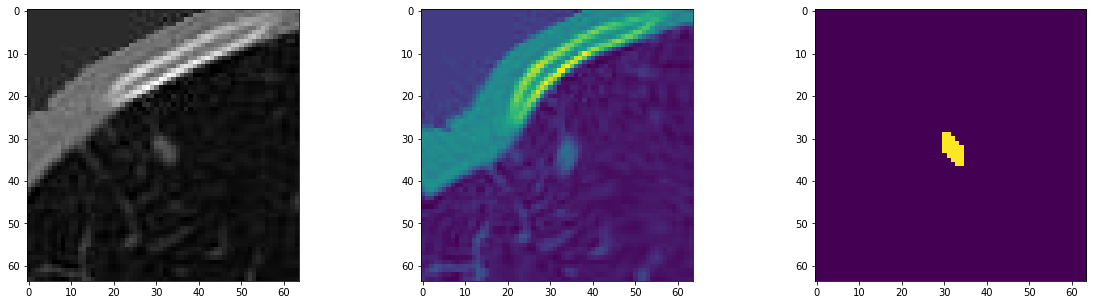

In [498]:
root_dir = "/data/unet/train/"
image_name = "LIDC-IDRI-0141_211.jpg"
img = cv2.imread(root_dir + 'images/' + image_name)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ms = cv2.imread(root_dir + 'masks/' + image_name)
ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)
(thresh, ms) = cv2.threshold(ms, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_t = elastic_transform(copy.deepcopy(img))
print(len(np.unique(img_t)))
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)
print(len(np.unique(img_t)))
print(np.unique(img_t))
f,a = plt.subplots(1,3, figsize=(20, 5))
a[0].imshow(img)
a[1].imshow(img_t)
a[2].imshow(ms)

In [16]:
def image_in_painting(x):
    img_rows, img_cols, img_deps = x.shape
    block_noise_size_x = random.randint(img_rows // 6, img_rows // 3)
    block_noise_size_y = random.randint(img_cols // 6, img_cols // 3)
    block_noise_size_z = random.randint(img_deps // 6, img_deps // 3)
    noise_x = random.randint(3, img_rows - block_noise_size_x - 3)
    noise_y = random.randint(3, img_cols - block_noise_size_y - 3)
    #noise_z = random.randint(3, img_deps - block_noise_size_z - 3)
    noise_z = 0
    block_noise_size_z = 3
    x[noise_x:noise_x + block_noise_size_x,
    noise_y:noise_y + block_noise_size_y,
    noise_z:noise_z + block_noise_size_z] = np.random.rand(block_noise_size_x,
                                                           block_noise_size_y,
                                                          block_noise_size_z, ) * 1.0
    return x

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  74  75  76  77  80  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 176 178 179 180 181 182 184 185 186 187 188 189
 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 207 209 210
 211 213 215 216 222 224 228 229 231 234 236 237 247 253 254 255]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  

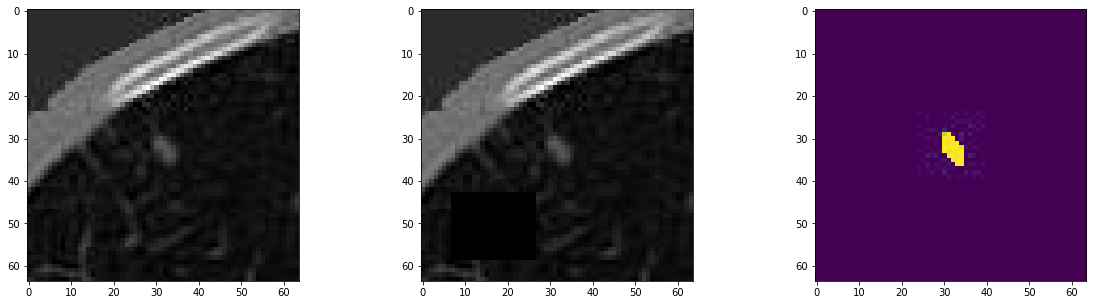

In [466]:
root_dir = "/data/unet/train/"
image_name = "LIDC-IDRI-0141_211.jpg"
img = cv2.imread(root_dir + 'images/' + image_name)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ms = cv2.imread(root_dir + 'masks/' + image_name)
ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)

img_t = image_in_painting(copy.deepcopy(img))
print(np.unique(img_t))
#img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)

print(np.unique(img_t))
f,a = plt.subplots(1,3, figsize=(20, 5))
a[0].imshow(img)
a[1].imshow(img_t)
a[2].imshow(ms)

In [17]:
import copy
def local_pixel_shuffling(x):
    image_temp = copy.deepcopy(x)
    orig_image = copy.deepcopy(x)
    img_rows, img_cols, img_deps = x.shape
    num_block = 5
    for _ in range(num_block):
        block_noise_size_x = random.randint(1, img_rows // 10)
        block_noise_size_y = random.randint(1, img_cols // 10)
#         block_noise_size_z = random.randint(1, img_deps // 10)
        block_noise_size_z = random.randint(1, 3)
        noise_x = random.randint(0, img_rows - block_noise_size_x)
        noise_y = random.randint(0, img_cols - block_noise_size_y)
        noise_z = random.randint(0, img_deps - block_noise_size_z)
        noise_z = 1
        window = orig_image[noise_x:noise_x + block_noise_size_x,
                 noise_y:noise_y + block_noise_size_y,
                 noise_z:noise_z + block_noise_size_z,
                 ]
        window = window.flatten()
        np.random.shuffle(window)
        window = window.reshape((block_noise_size_x,
                                 block_noise_size_y,
                                 block_noise_size_z))
        image_temp[noise_x:noise_x + block_noise_size_x,
        noise_y:noise_y + block_noise_size_y,
        noise_z:noise_z + block_noise_size_z] = window
    local_shuffling_x = image_temp

    return local_shuffling_x

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  74  75  76  77  80  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 176 178 179 180 181 182 184 185 186 187 188 189
 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205 207 209 210
 211 213 215 216 222 224 228 229 231 234 236 237 247 253 254 255]


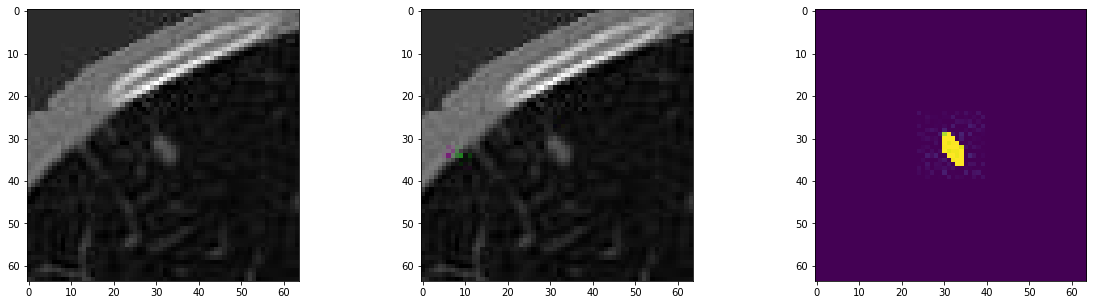

In [472]:
root_dir = "/data/unet/train/"
image_name = "LIDC-IDRI-0141_211.jpg"
img = cv2.imread(root_dir + 'images/' + image_name)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ms = cv2.imread(root_dir + 'masks/' + image_name)
ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)

img_t = local_pixel_shuffling(copy.deepcopy(img))
print(np.unique(img_t))
f,a = plt.subplots(1,3, figsize=(20, 5))
a[0].imshow(img)
a[1].imshow(img_t)
a[2].imshow(ms)

In [32]:
import cv2
from PIL import Image
class NoduleDataset(Dataset):
    def __init__(self, root_dir, image_paths, mask_paths, transforms=None, image_shape=(128,128), augment=False):
        super().__init__()
        self.augment = augment
        self.image_shape = image_shape
        self.batch_size = len(image_paths)
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.root_dir + 'images/' + self.image_paths[index])
        r = np.random.random()
        if self.augment:
            #image = elastic_transform(image)
            
            if r <= 0.33:
                image = image_in_painting(image)
#             elif 0.33 < r <= 0.66:
#                 image = local_pixel_shuffling(image)
            else: # no transformation except for gaussion blur done in elastic
                image = image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        
        mask = cv2.imread(self.root_dir + 'masks/' + self.mask_paths[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
#         image = image.astype('float32')
#         mean = np.mean(image)
#         std = np.std(image)
#         image = image-mean
#         if std >0:
#             image = image/std
        if self.transforms:
            image = self.transforms(image)
        mask = mask_transform(mask)
        #convert from Boolean to int (0,1)
        mask = mask.to(torch.uint8)
        mask = (mask > 0).float()
        return image, mask#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 16
num_workers = 0

nodule_data_train = NoduleDataset('/data/unet/train/',train_image_files, train_mask_files, transforms=train_transform, augment=True)
train_loader = DataLoader(nodule_data_train, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = NoduleDataset('/data/unet/val/',val_image_files, val_mask_files, transforms=val_transform, augment=False)
val_loader = DataLoader(nodule_data_val, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers, drop_last=True)
print("Number of train files are {} and test files are {}".format(len(train_mask_files), len(val_mask_files)))

Number of train files are 5424 and test files are 921


In [30]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [302]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


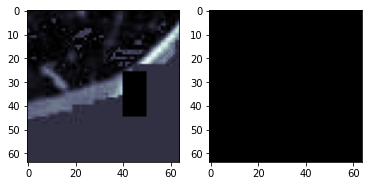

In [31]:
#images.shape
f,a = plt.subplots(1,2)
a[0].imshow(images[0][0,:,:], 'bone')
#images.shape
a[1].imshow(labels[0][0,:,:], 'bone')

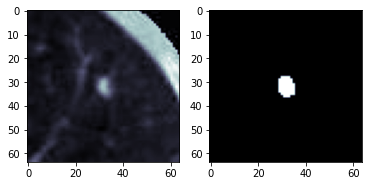

In [299]:
#images.shape
f,a = plt.subplots(1,2)
a[0].imshow(images[2][0,:,:], 'bone')
#images.shape
a[1].imshow(labels[2][0,:,:], 'bone')

In [43]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [44]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 2


In [45]:
model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
model = torch.nn.parallel.DataParallel(model, device_ids=[0, 1]).cuda()

In [46]:
device = torch.device("cuda")

In [47]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
            Conv2d-2           [-1, 32, 64, 64]             320
              ReLU-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
       BatchNorm2d-5           [-1, 32, 64, 64]              64
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 32, 64, 64]           9,248
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
             ReLU-10           [-1, 32, 64, 64]               0
      BatchNorm2d-11           [-1, 32, 64, 64]              64
      BatchNorm2d-12           [-1, 32, 64, 64]              64
            Block-13           [-1, 32, 64, 64]               0
            Block-14           [-1, 32,

In [48]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [49]:
# DICE when using images with nodules as well as blank images
def dice_coeff_2(y_true, y_pred):
    smooth = 0.0001
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
    return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

#### Configure metrics logging in tensorboard

In [39]:
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter('runs/unet_lidc_2')

In [40]:
def get_next_rundir():
    dirs = os.listdir('runs')
    idx = np.sort([int(d.split('_')[2]) for d in dirs])[-1]
    newdirname = 'runs/unet_lidc_{}'.format(idx+1)
    return newdirname

## Run training

In [50]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(train_epochs):
    
    num_epochs = train_epochs
    
    
    criterion  = nn.BCEWithLogitsLoss()
    #optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    #TODO: fix this later
    # use LR params from Yolo training
#     learning_rate = 0.00654
#     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.00042, momentum=0.47849)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9, weight_decay=0.0, nesterov=False)
    
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
#         lr = scheduler._last_lr
        writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch)
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            if mask_pre.ndim == 2:
                mask_pre = mask_pre[None,:,:]
            #print('labels shape = ', labels.shape, 'mask shape =', mask_pre.shape, 'ndim=', mask_pre.ndim)
            
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                #print('labels shape = ', labels.shape, 'mask shape =', mask_pre.shape)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score

#                 if i % 100 == 99: # every 10 minibatch
#                     writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
#                     writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
#                     running_loss = 0.0
#                     batch_dice_score = []
        writer.add_scalar('eval loss', running_loss/len(batch_dice_score), epoch)
        writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch)
        running_loss = 0.0
        batch_dice_score = []
        
        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")
        #update scheduler step
        #scheduler.step(epoch_loss)
        
        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [51]:
train(150)

Epoch 0 trained with loss: 0.4142629813216077, and dice score 0.15611787140369415. The running time is 12.079622983932495.
Epoch 0 evaluated with loss: 0.24728817924072868, and dice score: 0.06371690332889557. The running time is 1.0296063423156738.
Last model saved at epoch: 0
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.18762333170238849, and dice score 0.03117179311811924. The running time is 12.02704381942749.
Epoch 1 evaluated with loss: 0.14313627387347974, and dice score: 0.05299462750554085. The running time is 1.0468742847442627.
Last model saved at epoch: 1
Epoch 2 trained with loss: 0.1290460338810552, and dice score 0.10224178433418274. The running time is 12.115981578826904.
Epoch 2 evaluated with loss: 0.10654150642323912, and dice score: 0.29751384258270264. The running time is 1.037870168685913.
Last model saved at epoch: 2
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.0973372800292167, and dice score 0.3435468375682831. The running time is 11.9

In [68]:
import cv2
from PIL import Image
class NoduleDataset(Dataset):
    def __init__(self, root_dir, image_paths, mask_paths, transforms=None, image_shape=(128,128), augment=False):
        super().__init__()
        self.augment = augment
        self.image_shape = image_shape
        self.batch_size = len(image_paths)
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.root_dir + 'images/' + self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(self.root_dir + 'masks/' + self.mask_paths[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if self.transforms:
            image = self.transforms(image)
        mask = mask_transform(mask)
        #convert from Boolean to int (0,1)
        mask = mask.to(torch.uint8)
        mask = (mask > 0).float()
        return image, mask
            

batch_size = 16
num_workers = 0

nodule_data_test = NoduleDataset('/data/unet/test/',test_image_files, test_mask_files, transforms=val_transform, augment=False)
test_loader = DataLoader(nodule_data_test, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers)
print("Number of test files are {}".format(len(nodule_data_test)))

Number of test files are 380


In [60]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    scores = []
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            score_map = {'id': i, 'dice': score.item()}
            scores.append(score_map)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    print("dice score: {}".format(final_score))
    return final_score, least_dice, least_label, least_pre, scores

In [69]:
device = torch.device("cuda")
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre, scores  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}".format(final_score))

10it [00:00, 46.64it/s]

Accumulated dice coeff 0.8632689714431763


24it [00:00, 49.63it/s]

dice score: 0.7982342839241028
Final test dice score = 0.7982342839241028


In [72]:
def load_best_model():
    device = torch.device("cuda")
    seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
    seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
    seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth'))
    seg_model.eval()
    return seg_model

Text(0.5, 1.0, 'Predicted mask')

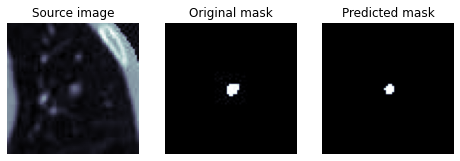

In [73]:
# verify some images and predictions
image_file = 'LIDC-IDRI-0012_52.jpg'
test_dir = '/data/unet/test/'
image_path = test_dir + 'images/' + image_file
mask_path = test_dir + 'masks/' + image_file.replace('img','mask')
seg_model = load_best_model()
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = val_transform(image)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#add new axis to input data for batch dimension
image = image[None, :]
mask_pre_prob = torch.sigmoid(seg_model(image))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)

#draw plots
image = np.squeeze(image)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(image, 'bone')
ax1.set_axis_off()
ax1.set_title("Source image")

mask = np.squeeze(mask)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask, 'bone')
ax2.set_axis_off()
ax2.set_title("Original mask")

mask_pre = np.squeeze(mask_pre)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(mask_pre, 'bone')
ax3.set_axis_off()
ax3.set_title("Predicted mask")